In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
import os
import random
from tqdm import tqdm
from PIL import Image
import math
import json
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import torch.quantization
import torchvision.transforms.functional as TF


# from utils import *

In [2]:
from google.colab import drive
drive.mount(('/content/drive'))

Mounted at /content/drive


In [3]:
%%time

import tarfile

path = "/content/drive/MyDrive/LaPa.tar.gz"
extract_path = "/tmp"

# Open the tar.gz file
with tarfile.open(path, "r:gz") as tar:
    # Extract all contents to /tmp
    tar.extractall(path=extract_path)

CPU times: user 19 s, sys: 9.95 s, total: 29 s
Wall time: 57.6 s


In [4]:
# Define paths to the subfolders
train_path = os.path.join("/tmp/LaPa/train")
test_path = os.path.join("/tmp/LaPa/test")
validation_path = os.path.join("/tmp/LaPa/val")

# Define paths to the images subfolder in each dataset split
train_images_path = os.path.join(train_path, "images")
test_images_path = os.path.join(test_path, "images")
validation_images_path = os.path.join(validation_path, "images")

# List files in each subfolder
print("Train files:", os.listdir(train_path))
print("Test files:", os.listdir(test_path))
print("Validation files:", os.listdir(validation_path))
print("__________________________________________")

print("Train images:", os.listdir(train_images_path))
print("Test images:", os.listdir(test_images_path))
print("Validation images:", os.listdir(validation_images_path))
print("__________________________________________")

# Define paths to the landmarks subfolder in each dataset split
train_landmarks_path = os.path.join(train_path, "landmarks")
test_landmarks_path = os.path.join(test_path, "landmarks")
validation_landmarks_path = os.path.join(validation_path, "landmarks")

print("Train landmarks:", os.listdir(train_landmarks_path))
print("Test landmarks:", os.listdir(test_landmarks_path))
print("Validation landmarks:", os.listdir(validation_landmarks_path))
print("__________________________________________")

# Define paths to the labels subfolder in each dataset split
train_labels_path = os.path.join(train_path, "labels")[:1500]
test_labels_path = os.path.join(test_path, "labels")[:400]
validation_labels_path = os.path.join(validation_path, "labels")[:200]

print("Train labels:", os.listdir(train_labels_path))
print("Test labels:", os.listdir(test_labels_path))
print("Validation labels:", os.listdir(validation_labels_path))
print("__________________________________________")

Train files: ['labels', 'images', 'landmarks']
Test files: ['labels', 'images', 'landmarks']
Validation files: ['labels', 'images', 'landmarks']
__________________________________________
Train images: ['HELEN_2442576256_1_0.jpg', '13751443933_1.jpg', '10434831435_3.jpg', '3031046947_3.jpg', '189839728_0.jpg', '8928172225_4.jpg', '16943697_0.jpg', 'HELEN_2414792473_1_2.jpg', '198523128_0.jpg', 'LFPW_image_train_0392_4.jpg', 'HELEN_26041966_2_4.jpg', '247965513_4.jpg', 'AFW_4538917191_10_1.jpg', '7053776845_2.jpg', 'HELEN_3052865023_5_1.jpg', '1830838923_5.jpg', 'LFPW_image_train_0091_0.jpg', '4016415985_0.jpg', '12205431363_42.jpg', '3485895863_3.jpg', 'LFPW_image_test_0036_4.jpg', '184401111_0.jpg', 'HELEN_2541112439_2_0.jpg', 'LFPW_image_test_0207_1.jpg', '9138314149_5.jpg', '12089390433_5.jpg', '3333644622_1.jpg', 'LFPW_image_test_0139_1.jpg', '5291523175_1.jpg', 'LFPW_image_train_0067_2.jpg', 'LFPW_image_train_0095_2.jpg', '5563360089_1.jpg', 'HELEN_2005566839_1_2.jpg', 'LFPW_image

In [5]:
# Save checkpoint
def save_checkpoint(state,filename='weights.pth.tar'):
    print('Saving weights-->')
    torch.save(state,filename)

# Load checkpoint
def load_checkpoint(filename,model,optim):
    print('Loading weights-->')
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['state_dict'])
    optim.load_state_dict(checkpoint['optimizer'])

In [6]:
# We need to generate 1 single mask from all masks
# First we retrieve all masks associated with current image

def generate_image_from_masks(mask,original_image):
    custom_colors = np.array([
    [0, 0, 0],
    [0, 153, 255],
    [102, 255, 153],
    [0, 204, 153],
    [255, 255, 102],
    [255, 255, 204],
    [255, 153, 0],
    [255, 102, 255],
    [102, 0, 51],
    [255, 204, 255],
    [255, 0, 102]])
    h, w = mask.shape
    rgb_image = np.zeros((h, w, 3), dtype=np.uint8)

    for y in range(h):
        for x in range(w):
            class_value = mask[y, x]
            rgb_image[y, x] = custom_colors[class_value]
    return rgb_image

def normalise_image(image): # not used currently, lets add based on performance
    # perform mean and std deviation normalization
    mean = np.mean(image)
    std = np.std(image)
    normalized_image = (image - mean) / std
    return normalized_image

In [ ]:
print((train_images_path + "/" + os.listdir(train_images_path)[0]))
print((train_labels_path + "/" + os.listdir(train_images_path)[0]).partition(".")[0] + ".png")

/tmp/LaPa/train/images/LFPW_image_train_0740_1.jpg
/tmp/LaPa/train/labels/LFPW_image_train_0740_1.png


In [ ]:
print(mask_img.shape)

(512, 512, 3)


In [20]:
# Data Visualization
i = 22
image_path = train_images_path + "/" + os.listdir(train_images_path)[i]
mask_path = (train_labels_path + "/" + os.listdir(train_images_path)[i]).partition(".")[0] + ".png"

image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
image_rgb = cv2.resize(image_rgb, (512, 512))
mask_img = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
# mask_img = cv2.resize(mask_img, (512, 512))
# mask_img = generate_image_from_masks(mask_img,image_rgb)

print(image_bgr.shape)
print(mask_img.shape)

(450, 450, 3)
(450, 450)


In [38]:
np.array(Image.open(image_path)).shape

(450, 450, 3)

(450, 450, 3)


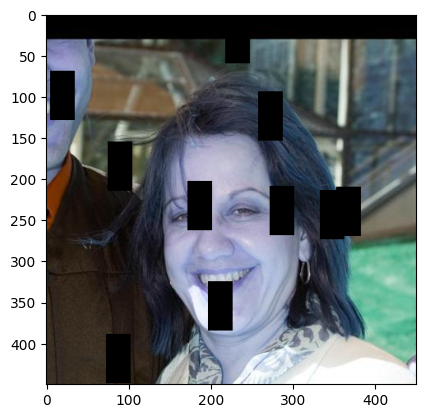

In [63]:
import numpy as np
import cv2
import random

# Load the image
image = cv2.imread(image_path)

# Define the number and size of the patches
num_patches = 10
patch_size = (30, 60)  # width, height

# Get image dimensions
img_height, img_width, _ = np.array(image).shape

for _ in range(num_patches):
    # Generate random position
    x = random.randint(0, img_width - patch_size[0])
    y = random.randint(0, img_height - patch_size[1])

    # Color the patch black
    image[y:y + patch_size[1], x:x + patch_size[0]] = (0, 0, 0)

# Save or display the modified image
print(image.shape)
plt.imshow(image)


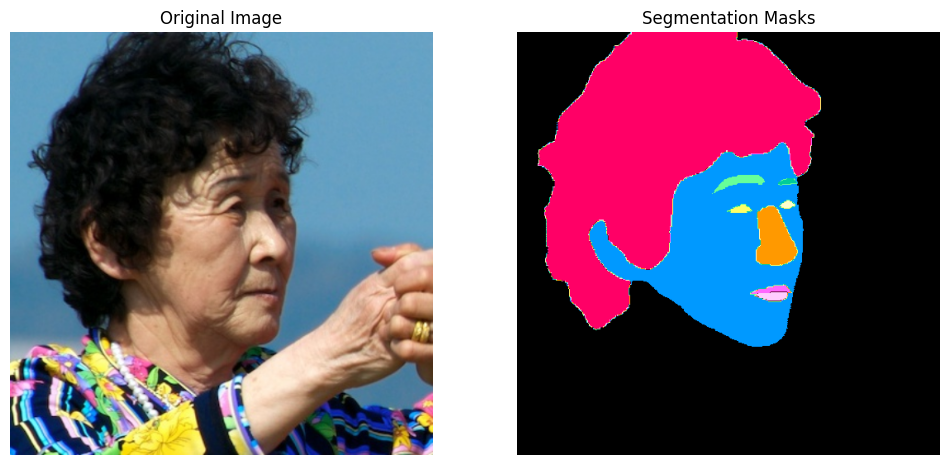

In [64]:
# Data Visualization
i = 90
image_path = train_images_path + "/" + os.listdir(train_images_path)[i]
mask_path = (train_labels_path + "/" + os.listdir(train_images_path)[i]).partition(".")[0] + ".png"

image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
image_rgb = cv2.resize(image_rgb, (512, 512))
mask_img = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
mask_img = cv2.resize(mask_img, (512, 512))
mask_img = generate_image_from_masks(mask_img,image_rgb)

# Display original and mask images side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with two subplots
axes[0].imshow(image_rgb)  # Display original image
axes[0].set_title('Original Image')
axes[0].axis('off')  # Hide axis
axes[1].imshow(mask_img)  # Display composite image with masks
axes[1].set_title('Segmentation Masks')
axes[1].axis('off')  # Hide axis
plt.show()

# Patches creation

In [115]:
class Lapa2(Dataset):
    def __init__(self,images_dir,size,transform=None):
        self.images_dir = images_dir
        self.transform = transform
        self.image_files = os.listdir(images_dir)[:size]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        img_path = os.path.join(self.images_dir, self.image_files[index])
        # Open image
        image = cv2.imread(img_path)
        target = cv2.imread(img_path)
        num_patches = 10
        patch_size = (30, 60)  # width, height

        img_height, img_width, _ = image.shape

        for _ in range(num_patches):
            # Generate random position
            x = random.randint(0, img_width - patch_size[0])
            y = random.randint(0, img_height - patch_size[1])

            # Color the patch black
            image[y:y + patch_size[1], x:x + patch_size[0]] = (0, 0, 0)

        # convert to tensor
        return self.transform(Image.fromarray(image)), self.transform(Image.fromarray(target))

In [116]:
# Create datasets
p_train_dataset = Lapa2(train_images_path,
                    1100,
                    transform)

p_val_dataset = Lapa2(validation_images_path,
                   250,
                   transform)

In [134]:
image, target = next(iter(p_val_dataset))

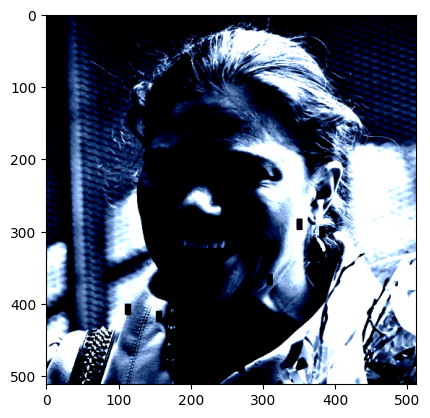

In [135]:
plt.imshow(np.array(image).transpose(1,2,0))

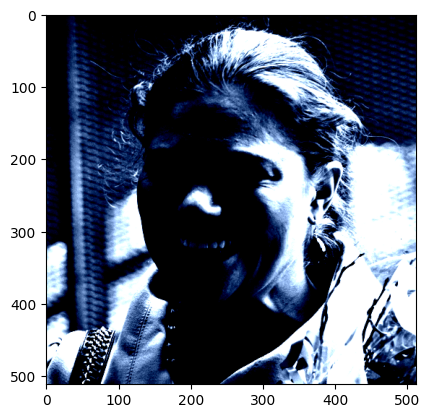

In [136]:
plt.imshow(np.array(target).transpose(1,2,0))

# Dataset creation

In [ ]:
class Lapa(Dataset):
    def __init__(self,images_dir,masks_dir,size,transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.image_files = os.listdir(images_dir)[:size]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        img_path = os.path.join(self.images_dir, self.image_files[index])
        mask_path = img_path.replace("images","labels").replace("jpg","png")
        # Open image
        image = Image.open(img_path)
        # Open masks - create 1 mask or N masks???? N mask for ground truth and N masks from CNN seems like a better design choice
        mask_img = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
        mask_img = cv2.resize(mask_img, (512, 512))
        # Split the masks
        binary_masks = []

        # Iterate over each class
        for class_value in range(0, 11):
            # Create a binary mask for the current class
            binary_mask = (mask_img == class_value).astype(np.float32)
            binary_masks.append(binary_mask)
        # convert to tensor
        torch_tensors_list = [torch.tensor(mask) for mask in binary_masks]
        return self.transform(image), torch.stack(torch_tensors_list, dim=0)

In [71]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize the image
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
class SynchronizedTransform():
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            transforms.ToTensor()
        ])

        self.normalize = transforms.Compose([
          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
      ])

    def __call__(self, image, masks):
        seed = random.randint(0, 2**32)

        random.seed(seed)
        torch.manual_seed(seed)
        image = self.transform(image)
        image = self.normalize(image)

        random.seed(seed)
        torch.manual_seed(seed)
        masks = self.transform(masks)

        return image, masks

In [ ]:
# Define the Transform Customly - as when we do random flips on img, these flips should happen on mask as well
class CustomTransform():
    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        # Resize
        image = transforms.functional.resize(image,[512,512])
        # Random horizontal and vertical flipping
        if random.random() > 0.5:
            image = transforms.functional.hflip(image)
            mask = transforms.functional.hflip(mask)
        if random.random() > 0.5:
            image = transforms.functional.vflip(image)
            mask = transforms.functional.vflip(mask)
        # Convert PIL images to PyTorch tensors
        image = transforms.ToTensor()(image)
        mask = transforms.ToTensor()(mask)
        return image,mask

In [ ]:
image_files = os.listdir(train_images_path)
print(image_files)

['LFPW_image_train_0740_1.jpg', '4832818348_1.jpg', 'HELEN_2534288728_1_1.jpg', '3735180332_0.jpg', '2348319657_0.jpg', '7799715496_0.jpg', 'HELEN_3179878396_1_0.jpg', '165460606_1.jpg', '13920981282_0.jpg', '10515277104_0.jpg', '462884827_0.jpg', 'HELEN_172183000_1_1.jpg', '14016853103_0.jpg', '12479470275_5.jpg', '2098076625_14.jpg', 'HELEN_3080573833_1_1.jpg', 'HELEN_2685751196_1_0.jpg', 'HELEN_3217491791_1_0.jpg', '1259094191_0.jpg', 'HELEN_2983659912_1_1.jpg', 'HELEN_2127986751_1_0.jpg', 'HELEN_10405424_1_0.jpg', 'HELEN_2168442533_1_0.jpg', 'HELEN_2936371718_1_3.jpg', 'HELEN_2783667002_1_2.jpg', 'HELEN_276823387_1_4.jpg', '3972174723_5.jpg', 'HELEN_1895136013_1_1.jpg', 'HELEN_2880878213_1_0.jpg', '2895520758_4.jpg', 'HELEN_1507775914_1_1.jpg', 'HELEN_2739463536_1_1.jpg', '2448842362_11.jpg', 'HELEN_182804431_1_1.jpg', '6041686014_0.jpg', 'HELEN_1385689774_1_0.jpg', 'HELEN_2815981843_2_3.jpg', 'LFPW_image_train_0669_3.jpg', '4625333004_7.jpg', '10059815886_1.jpg', 'LFPW_image_train

In [ ]:
type(image_files)

list

In [ ]:
# Create datasets
train_dataset = Lapa(train_images_path,
                    train_labels_path,
                    1100,
                    transform)

val_dataset = Lapa(validation_images_path,
                   validation_labels_path,
                   250,
                   transform)

In [ ]:
len(train_dataset)

1000

In [ ]:
prima_img = np.array(train_dataset[1][0].permute(1,2,0))

In [ ]:
tensor = train_dataset[1][1]

In [ ]:
isinstance(tensor, torch.Tensor)

True

In [ ]:
prima_mask = np.array(train_dataset[1][1])

In [ ]:
msk1 = prima_mask[0]

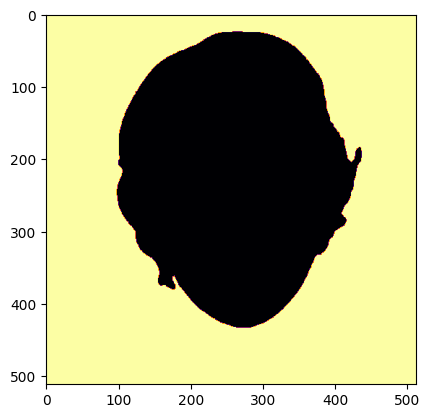

In [ ]:
plt.imshow(msk1, cmap = 'inferno')

In [ ]:
msk2 = prima_mask[1]

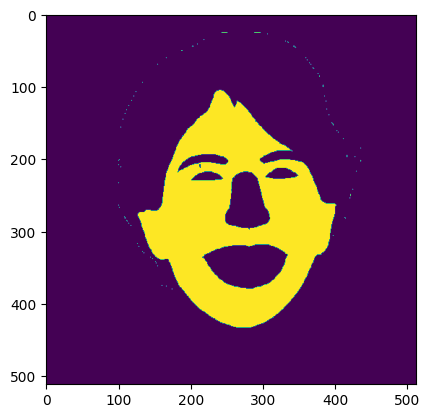

In [ ]:
plt.imshow(msk2)

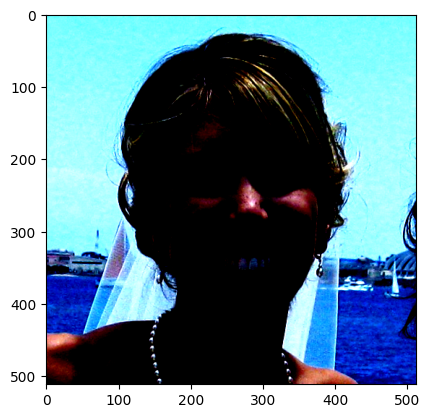

In [ ]:
plt.imshow(prima_img)

# Nuova trasformazione

In [ ]:
def my_img_mask_transforms(image, mask):
    resize = transforms.Resize((512, 512))
    totensor = transforms.ToTensor()
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    image = resize(image)
    mask = resize(mask)

    seed = np.random.randint(2147483647)
    random.seed(seed)
    torch.manual_seed(seed)

    if random.random() > 0.5:
          angle = random.randint(-30, 30)
          image = TF.rotate(image, angle)
          mask = TF.rotate(mask, angle)

    if random.random() > 0.5:
        image = TF.hflip(image)
        mask = TF.hflip(mask)

    if random.random() > 0.5:
        image = TF.vflip(image)
        mask = TF.vflip(mask)

    image = totensor(image)
    image = normalize(image)
    mask = torch.tensor(np.array(mask), dtype=torch.float32)

    return image, mask


In [ ]:
class Lapa(Dataset):
    def __init__(self, images_dir, masks_dir, size):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_files = os.listdir(images_dir)[:size]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        img_path = os.path.join(self.images_dir, self.image_files[index])
        mask_path = img_path.replace("images", "labels").replace("jpg", "png")

        # Open image
        image = Image.open(img_path).convert("RGB")

        # Open mask and convert to PIL Image
        mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask_img = Image.fromarray(cv2.resize(mask_img, (512, 512)))


        image, mask_img = my_img_mask_transforms(image, mask_img)

        # Split the masks
        binary_masks = []
        for class_value in range(0, 11):
            binary_mask = (mask_img == class_value).float()
            binary_masks.append(binary_mask)

        return image, torch.stack(binary_masks, dim=0)

In [ ]:
train_dataset = Lapa(train_images_path,
                    train_labels_path,
                    1100)

val_dataset = Lapa(validation_images_path,
                   validation_labels_path,
                   250)


Image 0 is tensor: True


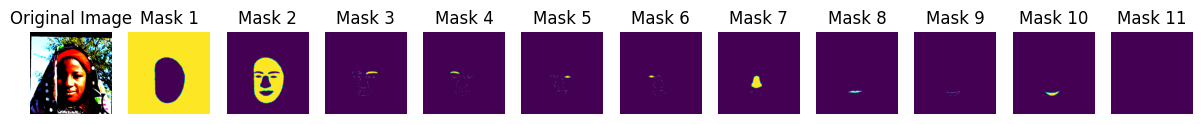

Image 1 is tensor: True


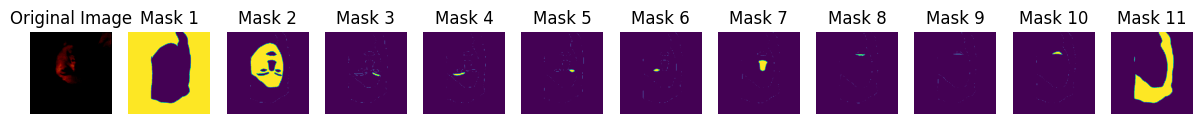

Image 2 is tensor: True


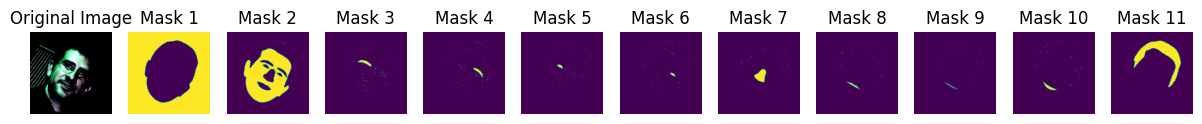

Image 3 is tensor: True


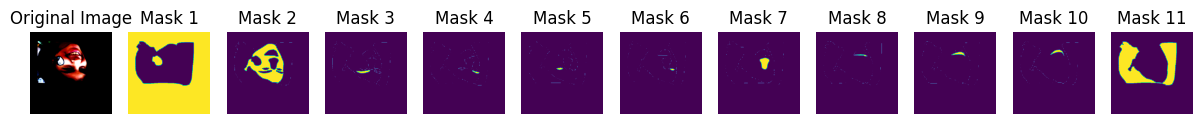

Image 4 is tensor: True


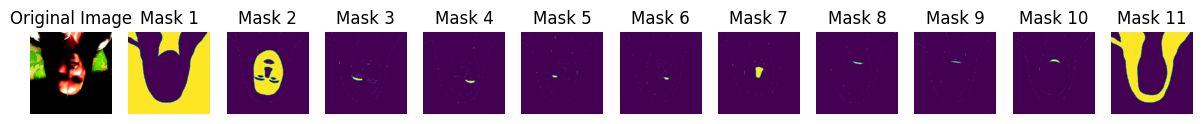

Image 5 is tensor: True


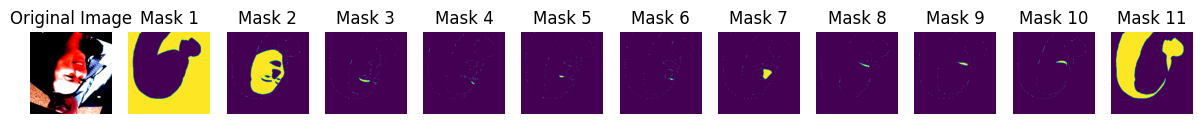

Image 6 is tensor: True


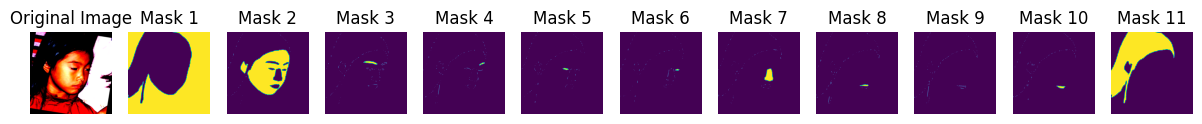

Image 7 is tensor: True


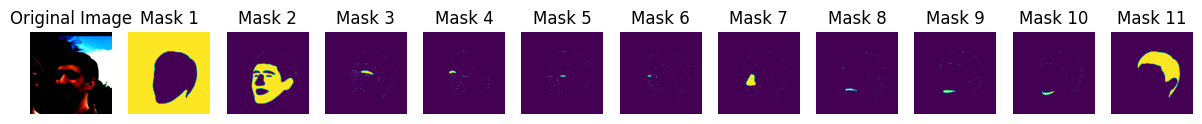

Image 8 is tensor: True


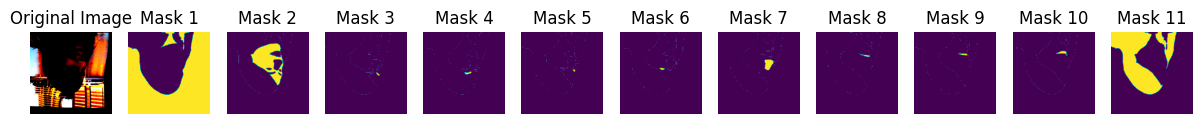

Image 9 is tensor: True


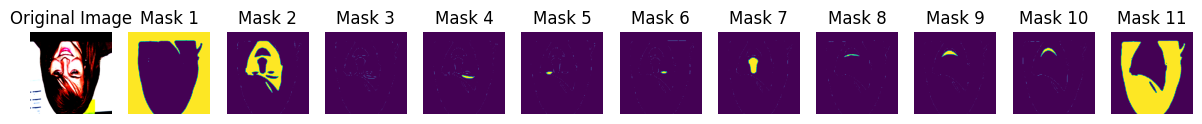

In [ ]:
for i in range(10):  # Change the range as needed
    t = train_dataset[i]
    img = np.array(t[0].permute(1, 2, 0))
    print(f"Image {i} is tensor: {isinstance(t[1], torch.Tensor)}")
    mask = np.array(t[1])

    num_masks = mask.shape[0]
    fig, axes = plt.subplots(1, num_masks + 1, figsize=(15, 15))

    # Display the original image
    axes[0].imshow(img)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Display each mask
    for m in range(num_masks):
        axes[m + 1].imshow(mask[m])
        axes[m + 1].set_title(f'Mask {m + 1}')
        axes[m + 1].axis('off')

    plt.show()

# Dataloader and co

In [ ]:
batch_size = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Custom loss function that takes BCE and Dice Coefficient
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss()

    def forward(self, y_pred, y_truth):
        assert y_pred.shape == y_truth.shape
        return self.bce_loss(y_pred, y_truth)

In [ ]:
def train_loop(model,dataloader,loss_fun,optimizer, num_epochs,device):
    model.train()
    model.to(device)
    min_loss = None
    for epoch in range(num_epochs):
        losses = []
        loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True)
        for batch,(x,y) in loop:
            # put on cuda
            x = x.to(device)
            y = y.to(device)

            # forward pass
            y_pred = model(x)

            # calculate loss & accuracy
            loss = loss_fun(y_pred.reshape(-1),y.reshape(-1))
            losses.append(loss.detach().item())

            # zero out prior gradients
            optimizer.zero_grad()

            # backprop
            loss.backward()

            # update weights
            optimizer.step()
            scheduler.step()

            # Update TQDM progress bar
            loop.set_description(f"Epoch [{epoch}/{num_epochs}] ")
            loop.set_postfix(loss=loss.detach().item())

        moving_loss = sum(losses) / len(losses)
        checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
        # Save check point
        if min_loss == None:
            min_loss = moving_loss
            save_checkpoint(checkpoint)
        elif moving_loss < min_loss:
            min_loss = moving_loss
            save_checkpoint(checkpoint)
        print('Epoch {0} : Loss = {1}'.format(epoch + 1, moving_loss))

In [ ]:
def test_loop(model,dataloader,loss_fun,device):
    model.eval()
    model.to(device)
    losses = []
    loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True)
    with torch.no_grad():
        for batch,(x,y) in loop:
            # put on cuda
            x = x.to(device)
            y = y.to(device)

            # forward pass
            y_pred = model(x)

            # caclulate test loss
            loss = loss_fun(y_pred.reshape(-1),y.reshape(-1))
            losses.append(loss.detach().item())

            # Update TQDM progress bar
            loop.set_postfix(loss=loss.item())

# Deep Residual Network

In [ ]:
import torch
import torch.nn as nn

class ResUNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=11, f = [64, 128, 256, 512]):
        super(ResUNet, self).__init__()

        # Encoding
        self.input_block_layer = self.input_block(in_channels, 64)
        self.input_skip_layer = self.input_skip(in_channels, 64)

        self.db_conv1 = self.double_conv(64, 128)
        self.skip1 = self.skip(64, 128)

        self.db_conv2 = self.double_conv(128, 256)
        self.skip2 = self.skip(128, 256)

        # self.db_conv3 = self.double_conv(256, 512)
        # self.skip3 = self.skip(256, 512)

        # Bridge
        self.bridge_layer = self.double_conv(256, 512)
        # self.bridge_layer = self.bridge(256)

        # Decoding
        self.up_1_layer = self.upsample(512)
        self.db_conv4 = self.double_conv(512 + 256, 256, stride = 1)
        self.skip4 = self.skip(512 + 256, 256, stride = 1)

        self.up_2_layer = self.upsample(256)
        self.db_conv5 = self.double_conv(256 + 128, 128, stride = 1)
        self.skip5 = self.skip(256 + 128, 128, stride = 1)

        self.up_3_layer = self.upsample(128)
        self.db_conv6 = self.double_conv(128 + 64, 64, stride = 1)
        self.skip6 = self.skip(128 + 64, 64, stride = 1)

        self.final_conv = nn.Sequential(
            nn.Conv2d(64, num_classes, 1, 1),
            nn.Sigmoid(),
        )

    def bridge(self, channels, kernel_size=3, stride=1):
        bridge = nn.Sequential(
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=kernel_size, stride=2, padding=1), # try stride 2
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=kernel_size, padding=1),
        )
        return bridge

    def input_block(self, in_channels, out_channels):
        input_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same', stride=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same', stride=1),
        )
        return input_block

    def input_skip(self, in_channels, out_channels):
        input_skip = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, padding='same')
        )
        return input_skip

    def double_conv(self, in_channels, out_channels, kernel_size=3, stride=2):
        conv_block = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride = stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride = 1, padding=1),
        )
        return conv_block

    def skip(self, in_channels, out_channels, kernel_size=3, stride=2):
        conv_skip = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
        )
        return conv_skip

    def upsample(self, channels): # non cambia il numero di canali
        return nn.ConvTranspose2d(channels, channels, kernel_size=2, stride=2)

    def forward(self, x):
        # Encode
        x1 = self.input_block_layer(x) + self.input_skip_layer(x)
        # print('x1', x1.shape)
        x2 = self.db_conv1(x1) + self.skip1(x1)
        # print('x2', x2.shape)
        x3 = self.db_conv2(x2) + self.skip2(x2)
        # print('x3', x3.shape)
        # x4 = self.db_conv3(x3) + self.skip3(x3)
        # print('x4', x4.shape)


        # Bridge
        x4 = self.bridge_layer(x3)
        # print('x4', x4.shape)

        # Decode
        x5 = self.up_1_layer(x4)
        # print('x5', x5.shape)
        x6 = torch.cat([x3, x5], dim=1)
        # print('x6', x6.shape)
        x7 = self.db_conv4(x6) + self.skip4(x6)
        # print('x7', x7.shape)

        x8 = self.up_2_layer(x7)
        # print('x8', x8.shape)
        x9 = torch.cat([x8, x2], dim=1)
        # print('x9', x9.shape)
        x10 = self.db_conv5(x9) + self.skip5(x9)
        # print('x10', x10.shape)

        x11 = self.up_3_layer(x10)
        # print('x11', x11.shape)
        x12 = torch.cat([x1, x11], dim=1)
        # print('x12', x12.shape)
        x13 = self.db_conv6(x12) + self.skip6(x12)
        # print('x13', x13.shape)


        output = self.final_conv(x13)

        return output


In [ ]:
model = ResUNet(in_channels=3, num_classes=11)
x = torch.randn(2, 3, 512, 512)  # Example input tensor
output = model(x)
print(output.shape)

KeyboardInterrupt: 

In [90]:
# Params
learning_rate = 0.00005
num_epochs = 5
num_workers = 2
batch_size = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Running on: ',device)

Running on:  cuda


In [ ]:
# Define Criterion, Loss function, LR Scheduler
model = ResUNet(in_channels=3, num_classes=11)
criterion = CustomLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

In [ ]:
train_loop(model,train_loader,criterion,optimizer,device)

  0%|          | 0/550 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 384.00 MiB. GPU 

In [ ]:
test_loop(model, val_loader, criterion, device)

In [ ]:
image, mask = next(iter(val_loader))
image, mask = image.to(device), mask.to(device)
model.eval()
pred = model(image)

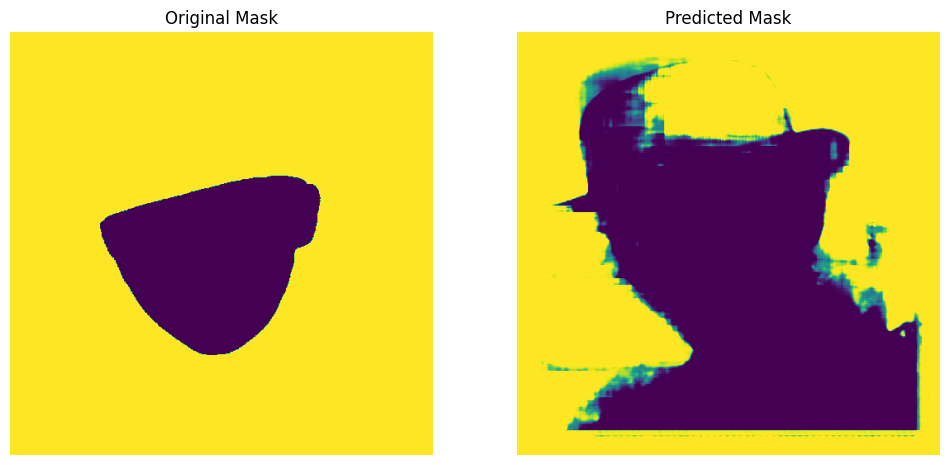

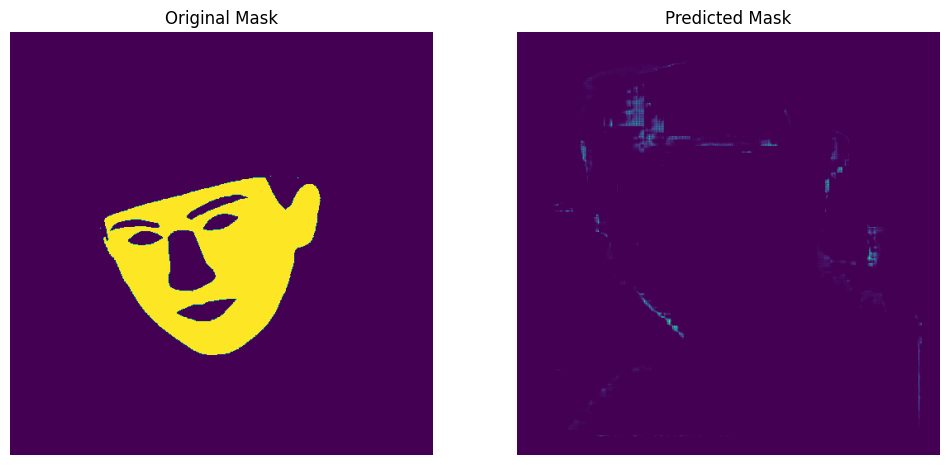

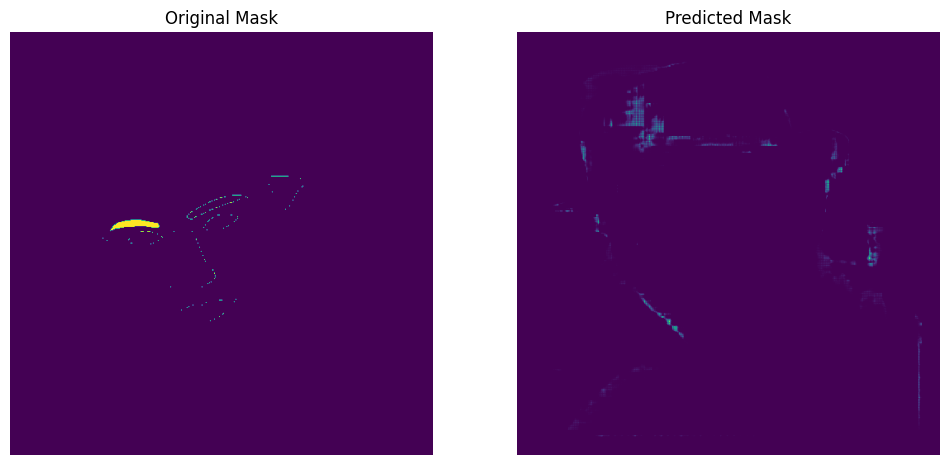

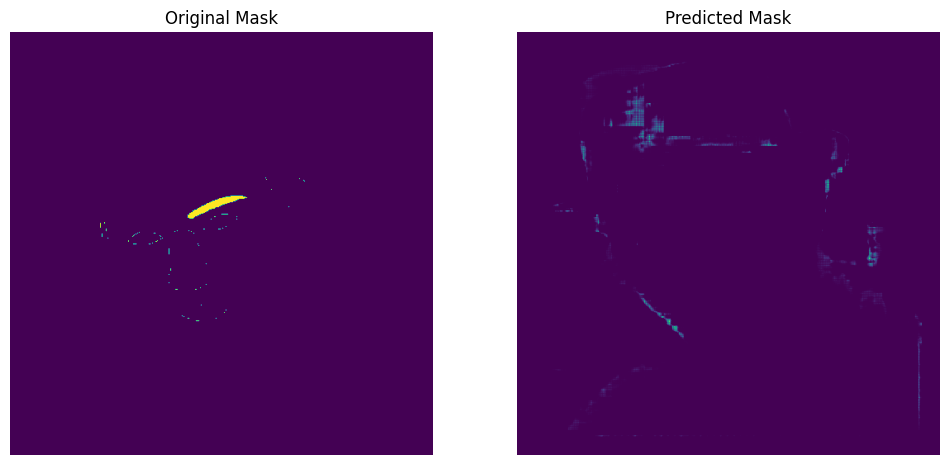

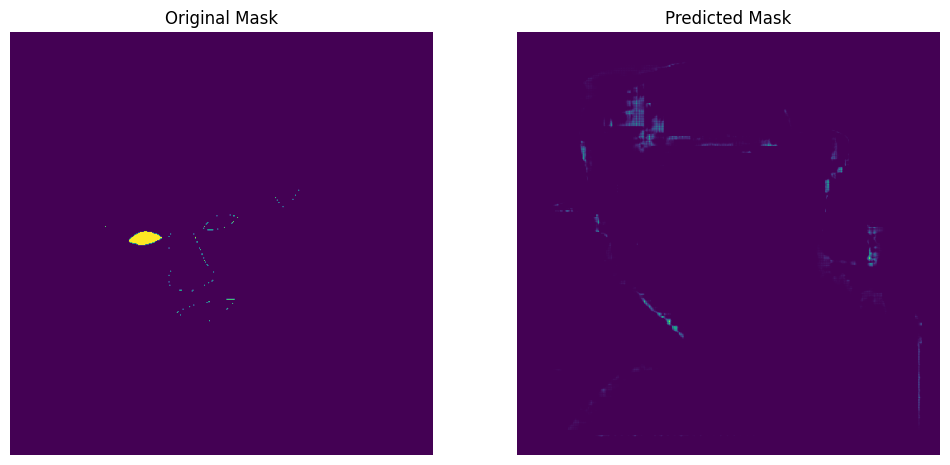

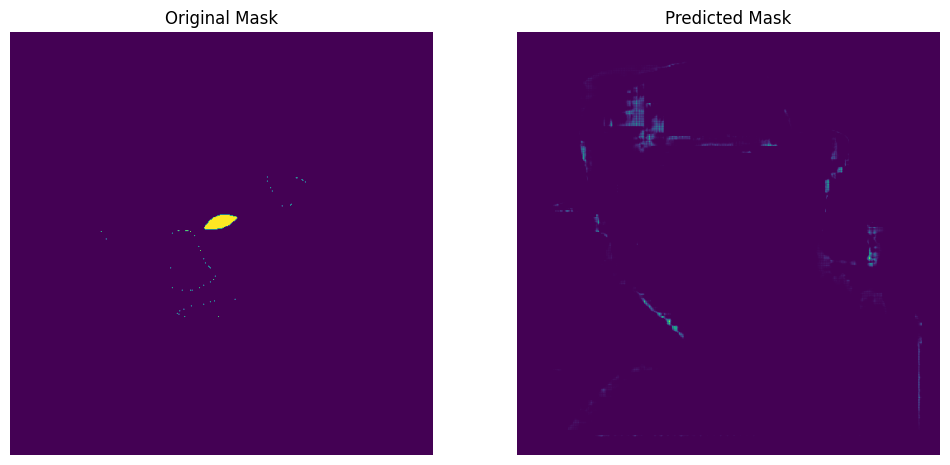

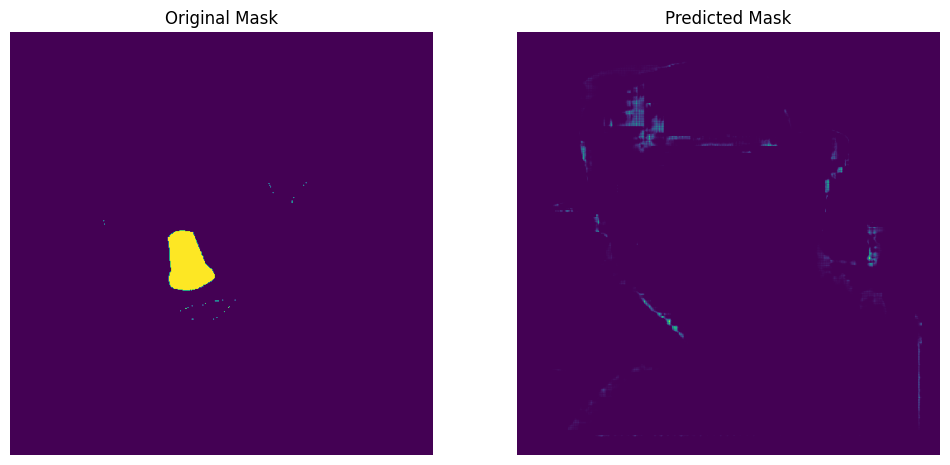

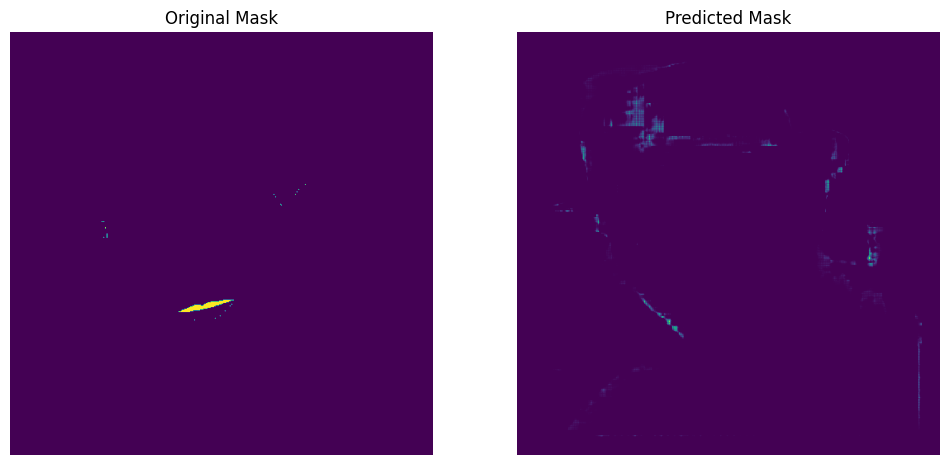

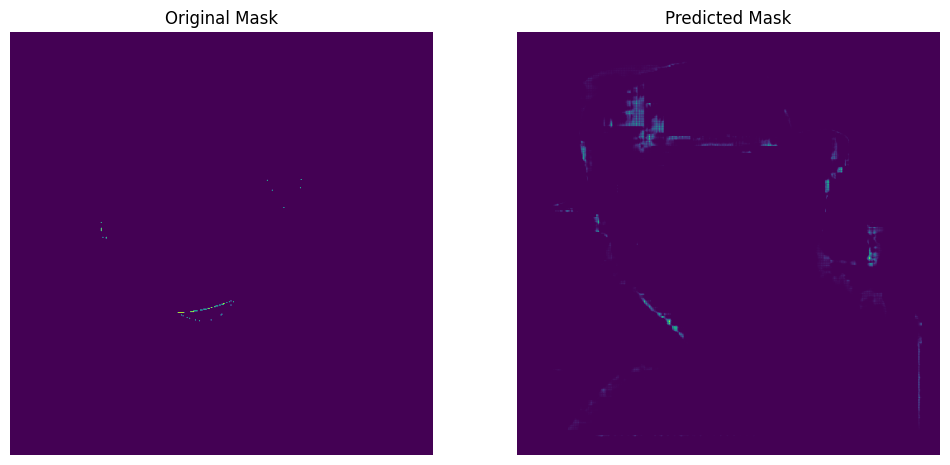

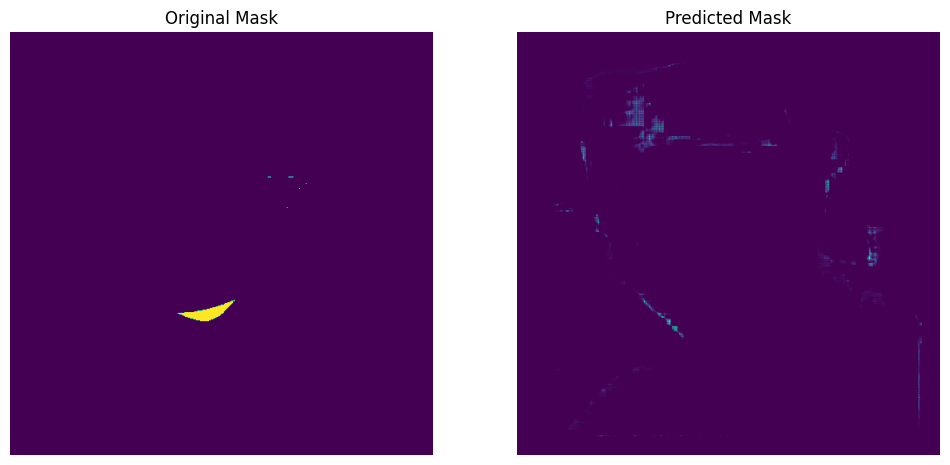

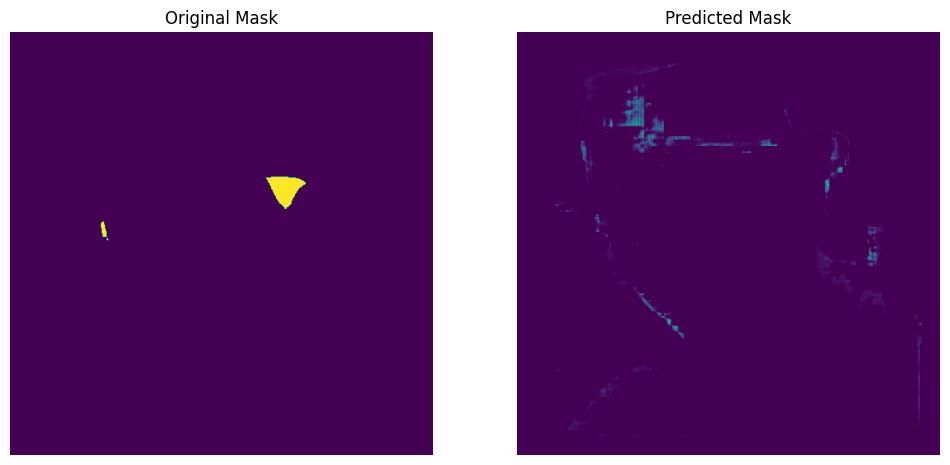

In [ ]:
for i in range(0, 11):
  fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with two subplots
  axes[0].imshow(mask[0][i].cpu())  # Display original image
  axes[0].set_title('Original Mask')
  axes[0].axis('off')  # Hide axis
  axes[1].imshow(pred[0][i].detach().cpu().numpy())  # Display composite image with masks
  axes[1].set_title('Predicted Mask')
  axes[1].axis('off')  # Hide axis
  plt.show()

# DRSUNet

In [ ]:
# Depth Residual Seperable UNet
# Different from VanillaUNet - has skip connections inside Conv blocks, uses Depth Seperable Conv ops
# resulting in lesser computations

class DRSUNet(nn.Module):
    def __init__(self,in_channels=3,num_classes=11):
        super(DRSUNet, self).__init__()
        # Encode architecture
        self.dsconv1_1 = self._depth_seperable_conv(in_channels, 64)
        self.dsconv1_2 = self._depth_seperable_conv(64, 64)
        self.dsconv2_1 = self._depth_seperable_conv(64, 64)
        self.dsconv2_2 = self._depth_seperable_conv(128, 128)
        self.dsconv3_1 = self._depth_seperable_conv(128, 128)
        self.dsconv3_2 = self._depth_seperable_conv(256, 256)
        self.dsconv4_1 = self._depth_seperable_conv(256, 256)
        self.dsconv4_2 = self._depth_seperable_conv(512, 512)
        self.dsconv5_1 = self._depth_seperable_conv(512, 512)
        self.dsconv5_2 = self._depth_seperable_conv(1024, 1024)
        # Decoder architecture
        self.uconv1 = nn.ConvTranspose2d(1024,512,stride=2,kernel_size=2)
        self.dconv6 = self._double_conv(1024, 512)
        self.uconv2 = nn.ConvTranspose2d(512, 256,stride=2,kernel_size=2)
        self.dconv7 = self._double_conv(512, 256)
        self.uconv3 = nn.ConvTranspose2d(256, 128,stride=2,kernel_size=2)
        self.dconv8 = self._double_conv(256, 128)
        self.uconv4 = nn.ConvTranspose2d(128, 64,stride=2,kernel_size=2)
        self.dconv9 = self._double_conv(128, 64)
        # Final conv
        self.final_conv = nn.Conv2d(64,num_classes,kernel_size=1)
        # Max pool
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def _depth_seperable_conv(self, in_channels, out_channels):
        # Modifying Conv2d such that it performs 2 operations
        # 1. Depth wise convolution
        # 2. Point wise convolution
        # The 2 consecutive Conv2d represent the Depth Wise & Point Wise Conv operations respectively
        depth_seperable_conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, groups=in_channels, kernel_size=3, padding='same'),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
        )
        return depth_seperable_conv

    def _double_conv(self, in_channels,out_channels):
        conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, groups=in_channels, kernel_size=3, padding='same'),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, groups=out_channels, kernel_size=3, padding='same'),
            nn.Conv2d(out_channels, out_channels, kernel_size=1, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
        )
        return conv

    def forward(self,X0):
        # Forward Prop thru Encoder
        # X Shape : [B X 3 X 512 X 512]
        X1 = self.dsconv1_1(X0)          # X1 Shape : [B X 64 X 512 X 512]
        X2 = self.dsconv1_2(X1)          # X2 Shape : [B X 64 X 512 X 512]

        X3 = self.max_pool(X2)           # X3 Shape : [B X 64 X 256 X 256]

        X4 = self.dsconv2_1(X3)          # X4 Shape : [B X 64 X 256 X 256]
        X5 = torch.cat((X3,X4),dim=1)    # X5 Shape : [B X 128 X 256 X 256]
        X6 = self.dsconv2_2(X5)          # X6 Shape : [B X 128 X 256 X 256]

        X7 = self.max_pool(X6)           # X7 Shape : [B X 128 X 128 X 128]

        X8 = self.dsconv3_1(X7)          # X8 Shape : [B X 128 X 128 X 128]
        X9 = torch.cat((X7,X8),dim=1)    # X9 Shape : [B X 256 X 128 X 128]
        X10 = self.dsconv3_2(X9)         # X10 Shape : [B X 256 X 128 X 128]

        X11 = self.max_pool(X10)         # X11 Shape : [B X 256 X 64 X 64]

        X12 = self.dsconv4_1(X11)        # X12 Shape : [B X 256 X 64 X 64]
        X13 = torch.cat((X11,X12),dim=1) # X13 Shape : [B X 512 X 64 X 64]
        X14 = self.dsconv4_2(X13)        # X14 Shape : [B X 512 X 64 X 64]

        X15 = self.max_pool(X14)         # X15 Shape : [B X 512 X 32 X 32]

        X16 = self.dsconv5_1(X15)        # X16 Shape : [B X 512 X 32 X 32]
        X17 = torch.cat((X15,X16),dim=1) # X17 Shape : [B X 1024 X 32 X 32]
        X18 = self.dsconv5_2(X17)        # X18 Shape : [B X 1024 X 32 X 32]

        # Forward Prop thru Decoder
        X19 = self.uconv1(X18)           # X19 Shape : [B X 512 X 64 X 64]
        X20 = torch.cat((X19,X14),dim=1) # X20 Shape : [B X 1024 X 64 X 64]
        X21 = self.dconv6(X20)           # X21 Shape : [B X 512 X 64 X 64]

        X22 = self.uconv2(X21)           # X22 Shape : [B X 256 X 128 X 128]
        X23 = torch.cat((X22,X10),dim=1) # X23 Shape : [B X 512 X 128 X 128]
        X24 = self.dconv7(X23)           # X24 Shape : [B X 256 X 128 X 128]

        X25 = self.uconv3(X24)            # X25 Shape : [B X 128 X 256 X 256]
        X26 = torch.cat((X25,X6),dim=1)   # X26 Shape : [B X 256 X 256 X 256]
        X27 = self.dconv8(X26)            # X27 Shape : [B X 128 X 256 X 256]

        X28 = self.uconv4(X27)            # X28 Shape : [B X 64 X 512 X 512]
        X29 = torch.cat((X28,X2),dim=1)   # X29 Shape : [B X 128 X 512 X 512]
        X30 = self.dconv9(X29)            # X30 Shape : [B X 64 X 512 X 512]

        # Final Conv Layer
        X31 = self.final_conv(X30)        # X31 Shape : [B X num_classes X 512 X 512]

        return F.softmax(X31,dim=1)

In [ ]:
len(val_dataset)

2000

In [ ]:
# Params
learning_rate = 0.001
num_epochs = 25
num_workers = 2
batch_size = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Running on: ',device)

Running on:  cuda


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Instantiate model
model = DRSUNet(in_channels=3,num_classes=11)

NameError: name 'DRSUNet' is not defined

## a

In [ ]:
model = ResUNet(in_channels=3,num_classes=11)

ValueError: padding='same' is not supported for strided convolutions

In [ ]:
# Custom loss function that takes BCE and Dice Coefficient
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss()

    def forward(self, y_pred, y_truth):
        assert y_pred.shape == y_truth.shape
        return self.bce_loss(y_pred, y_truth)

In [ ]:
# Define Criterion, Loss function, LR Scheduler
criterion = CustomLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

In [ ]:
x,y = next(iter(train_loader))
print(x.shape,y.shape)
# ignore warnings - some images do not have all 10 segment masks

torch.Size([2, 3, 512, 512]) torch.Size([2, 11, 512, 512])


In [ ]:
model.to(device)
x = x.to(device)
y = y.to(device)
print()

In [ ]:
print(y[1].unique())

tensor([0., 1.], device='cuda:0')


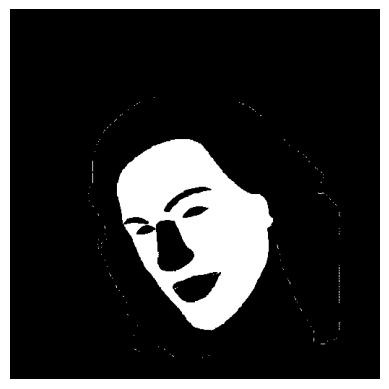

In [ ]:
# sample mask
image_tensor = y[1][1]
image_array = image_tensor.cpu().numpy()

# Display the grayscale image using Matplotlib
plt.imshow(image_array, cmap='gray')
plt.axis('off')  # Turn off axis
plt.show()

In [ ]:
y_pred = model(x)
print(y_pred.shape,y.shape)

torch.Size([2, 11, 512, 512]) torch.Size([2, 11, 512, 512])


In [ ]:
load_checkpoint("/kaggle/working/weights.pth.tar",model,optimizer) ###??? da dove???

Loading weights-->


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/weights.pth.tar'

In [ ]:
train_loop(model,train_loader,criterion,optimizer,device)

Epoch [0/25] :  18%|█▊        | 1606/9084 [10:24<48:29,  2.57it/s, loss=0.667]  


KeyboardInterrupt: 

In [ ]:
test_loop(model,val_loader,criterion,device)

# U-net

In [88]:
# Define segmentation architectures
class VanillaUNet(nn.Module):
    def __init__(self,in_channels=3,num_classes=11):
        super(VanillaUNet, self).__init__()
        # Encode architecture
        self.dconv1 = self._double_conv(in_channels, 64)
        self.dconv2 = self._double_conv(64, 128)
        self.dconv3 = self._double_conv(128, 256)
        self.dconv4 = self._double_conv(256, 512)
        self.dconv5 = self._double_conv(512, 1024)
        # Decoder architecture
        self.uconv1 = nn.ConvTranspose2d(1024,512,stride=2,kernel_size=2)
        self.dconv6 = self._double_conv(1024, 512)
        self.uconv2 = nn.ConvTranspose2d(512,256,stride=2,kernel_size=2)
        self.dconv7 = self._double_conv(512, 256)
        self.uconv3 = nn.ConvTranspose2d(256,128,stride=2,kernel_size=2)
        self.dconv8 = self._double_conv(256, 128)
        self.uconv4 = nn.ConvTranspose2d(128,64,stride=2,kernel_size=2)
        self.dconv9 = self._double_conv(128, 64)
        # Final conv
        self.final_conv = nn.Conv2d(64,num_classes,kernel_size=1)
        # Max pool
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def _double_conv(self, in_channels, out_channels):
        conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
        )
        return conv

    def forward(self,X):
        # Forward Prop thru Encoder
        # X Shape : [B X 3 X 512 X 512]
        X1 = self.dconv1(X)              # X1 Shape : [B X 64 X 512 X 512]
        X2 = self.max_pool(X1)           # X2 Shape : [B X 64 X 256 X 256]

        X3 = self.dconv2(X2)             # X3 Shape : [B X 128 X 256 X 256]
        X4 = self.max_pool(X3)           # X4 Shape : [B X 128 X 128 X 128]

        X5 = self.dconv3(X4)             # X5 Shape : [B X 256 X 128 X 128]
        X6 = self.max_pool(X5)           # X6 Shape : [B X 256 X 64 X 64]

        X7 = self.dconv4(X6)             # X7 Shape : [B X 512 X 64 X 64]
        X8 = self.max_pool(X7)           # X8 Shape : [B X 512 X 32 X 32]

        X9 = self.dconv5(X8)             # X9 Shape : [B X 1024 X 32 X 32]

        # Forward Prop thru Decoder
        X10 = self.uconv1(X9)            # X10 Shape : [B X 512 X 64 X 64]
        X11 = torch.cat((X10,X7),dim=1)  # X11 Shape : [B X 1024 X 64 X 64]
        X12 = self.dconv6(X11)           # X12 Shape : [B X 512 X 64 X 64]

        X13 = self.uconv2(X12)           # X13 Shape : [B X 256 X 128 X 128]
        X14 = torch.cat((X13,X5),dim=1)  # X14 Shape : [B X 512 X 128 X 128]
        X15 = self.dconv7(X14)           # X15 Shape : [B X 256 X 128 X 128]

        X16 = self.uconv3(X15)            # X16 Shape : [B X 128 X 256 X 256]
        X17 = torch.cat((X16,X3),dim=1)   # X17 Shape : [B X 256 X 256 X 256]
        X18 = self.dconv8(X17)            # X18 Shape : [B X 128 X 256 X 256]

        X19 = self.uconv4(X18)            # X19 Shape : [B X 64 X 512 X 512]
        X20 = torch.cat((X19,X1),dim=1)   # X20 Shape : [B X 128 X 512 X 512]
        X21 = self.dconv9(X20)            # X21 Shape : [B X 64 X 512 X 512]

        # Final Conv Layer
        X22 = self.final_conv(X21)        # X22 Shape : [B X num_classes X 512 X 512]

        return X22 #F.softmax(X22,dim=1)

In [ ]:
model = VanillaUNet(in_channels=3,num_classes=11)

In [ ]:
image, lab = next(iter(train_loader))

In [ ]:
print(model(image).shape)

torch.Size([2, 11, 512, 512])


In [ ]:
pred = model(image)

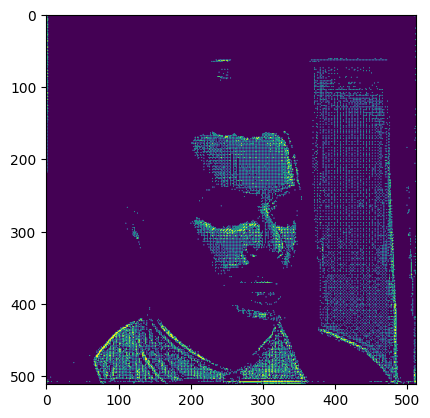

In [ ]:
plt.imshow(pred[0][0].cpu().detach().numpy() > 0.8)

In [ ]:
a > 0.4

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
# Define Criterion, Loss function, LR Scheduler
criterion = nn.BCEWithLogitsLoss()
# criterion = CustomLoss()
learning_rate = 0.0005
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

In [ ]:
train_loop(model,train_loader,criterion,optimizer,7, device)

Epoch [0/7] : 100%|██████████| 550/550 [04:44<00:00,  1.93it/s, loss=0.678]


Saving weights-->
Epoch 1 : Loss = 0.6747199588472192


Epoch [1/7] : 100%|██████████| 550/550 [04:51<00:00,  1.89it/s, loss=0.673]


Saving weights-->
Epoch 2 : Loss = 0.6745336016741665


Epoch [2/7] : 100%|██████████| 550/550 [04:51<00:00,  1.88it/s, loss=0.677]


Saving weights-->
Epoch 3 : Loss = 0.6742212134057826


Epoch [3/7] : 100%|██████████| 550/550 [04:52<00:00,  1.88it/s, loss=0.677]


Saving weights-->
Epoch 4 : Loss = 0.6739883544228293


Epoch [4/7] : 100%|██████████| 550/550 [04:51<00:00,  1.89it/s, loss=0.669]


Saving weights-->
Epoch 5 : Loss = 0.6737560172514482


Epoch [5/7] : 100%|██████████| 550/550 [04:52<00:00,  1.88it/s, loss=0.67]


Saving weights-->
Epoch 6 : Loss = 0.6737348134951158


Epoch [6/7] : 100%|██████████| 550/550 [04:52<00:00,  1.88it/s, loss=0.671]


Saving weights-->
Epoch 7 : Loss = 0.673296960809014


In [ ]:
def test_loop(model,dataloader,loss_fun,device):
    model.eval()
    model.to(device)
    losses = []
    loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True)
    with torch.no_grad():
        for batch,(x,y) in loop:
            # put on cuda
            x = x.to(device)
            y = y.to(device)

            # forward pass
            y_pred = model(x)

            # caclulate test loss
            loss = loss_fun(y_pred.reshape(-1),y.reshape(-1))
            losses.append(loss.detach().item())

            # Update TQDM progress bar
            loop.set_postfix(loss=loss.item())

In [ ]:
test_loop(model, val_loader, criterion,device)

100%|██████████| 125/125 [00:35<00:00,  3.53it/s, loss=0.682]


In [ ]:
image, mask = next(iter(val_loader))
image, mask = image.to(device), mask.to(device)

In [ ]:
image, mask = next(iter(val_loader))
image, mask = image.to(device), mask.to(device)
model.eval()
pred = model(image)

In [ ]:
iou_scores, dice_scores, mIoU = compute_metrics(pred, mask)

In [ ]:
print(iou_scores, dice_scores, mIoU)

[tensor(0.0909), tensor(0.0909)] [tensor(1.), tensor(1.)] 0.09090909


In [ ]:
def compute_metrics(pred_masks, true_masks):
    iou_scores = []
    dice_scores = []

    for pred_mask, true_mask in zip(pred_masks, true_masks):
        pred_mask, true_mask = pred_mask.detach().cpu(), true_mask.cpu()
        intersection = np.logical_and(pred_mask, true_mask).sum()
        union = np.logical_or(pred_mask, true_mask).sum()

        iou = intersection / union if union != 0 else 0
        iou_scores.append(iou)

        dice = 2 * intersection / (pred_mask.sum() + true_mask.sum())
        dice_scores.append(dice)

    mIoU = np.mean(iou_scores)

    return iou_scores, dice_scores, mIoU

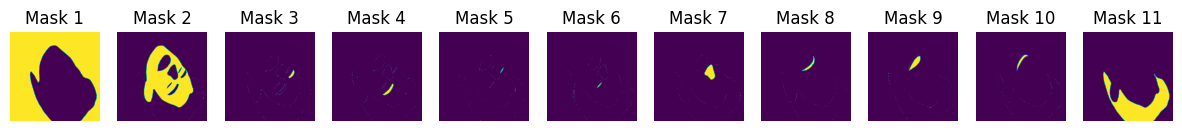

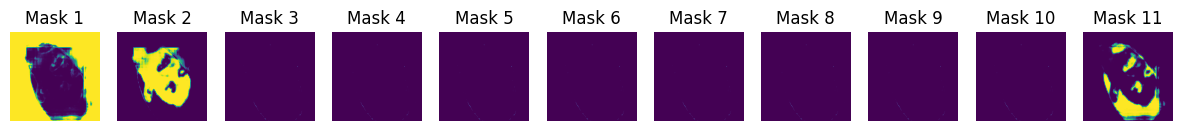

In [ ]:
    num_masks = 11
    fig, axes = plt.subplots(1, num_masks, figsize=(15, 15))
    fig1, axes1 = plt.subplots(1, num_masks, figsize=(15, 15))

    # Display each mask
    for m in range(num_masks):
        axes[m].imshow(mask[1][m].cpu())
        axes[m].set_title(f'Mask {m + 1}')
        axes[m].axis('off')

    for m in range(num_masks):
        axes1[m].imshow(pred[1][m].detach().cpu().numpy())
        axes1[m].set_title(f'Mask {m + 1}')
        axes1[m].axis('off')


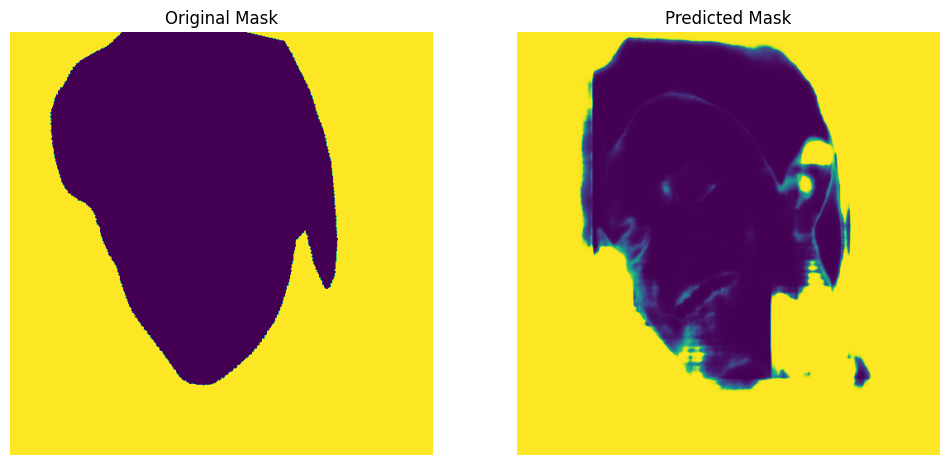

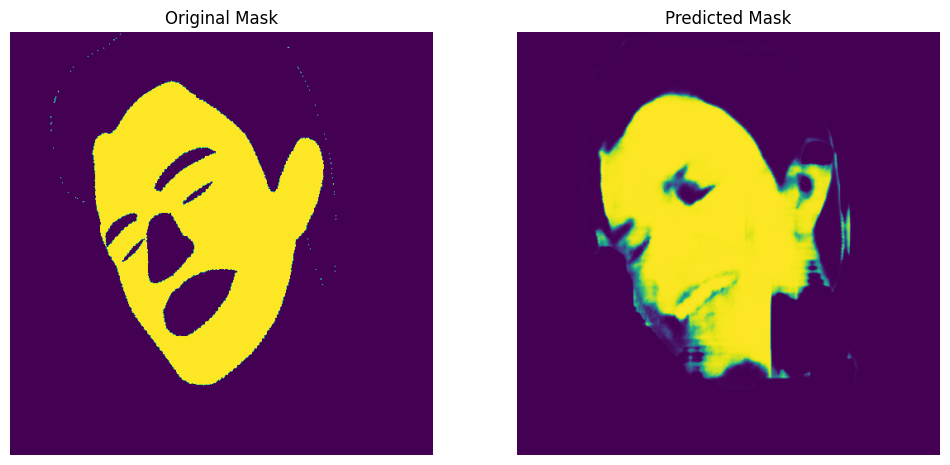

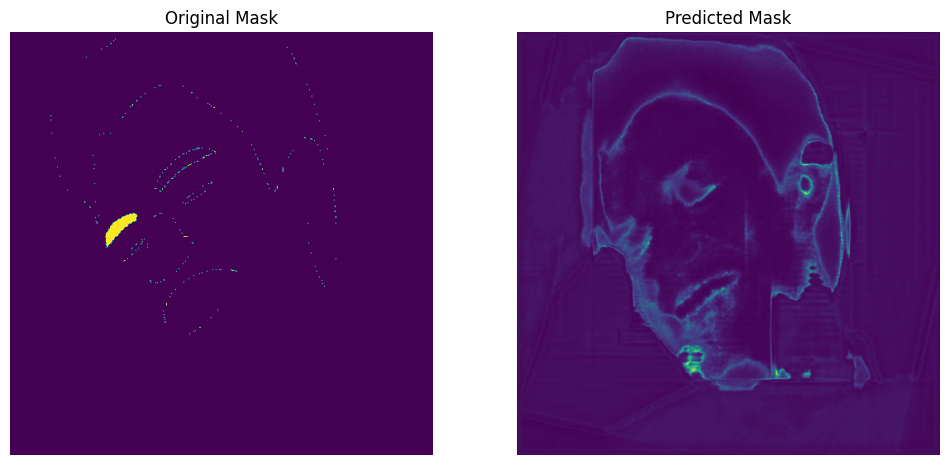

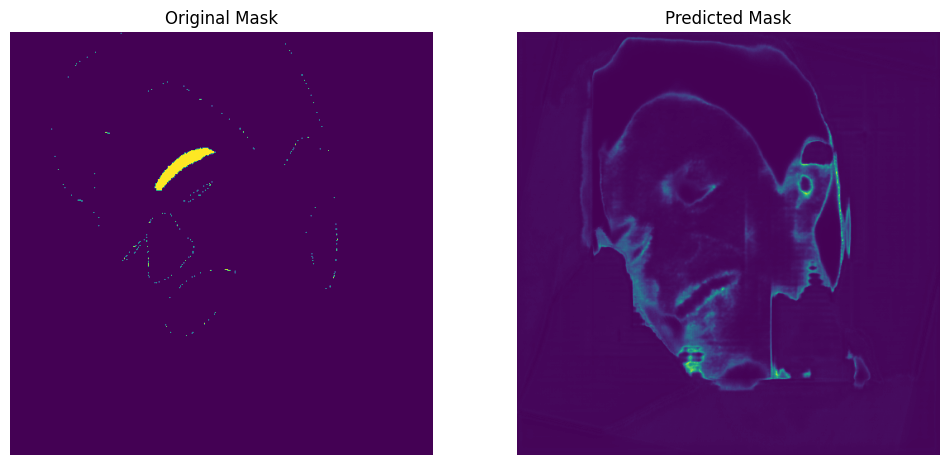

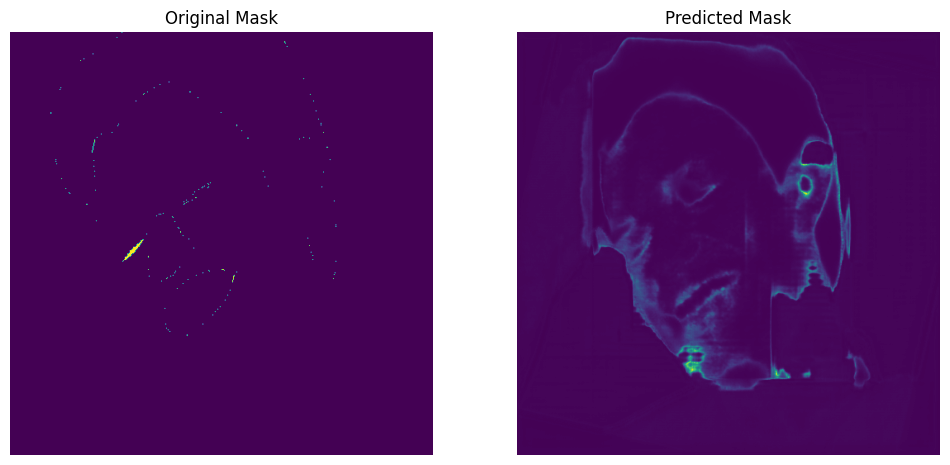

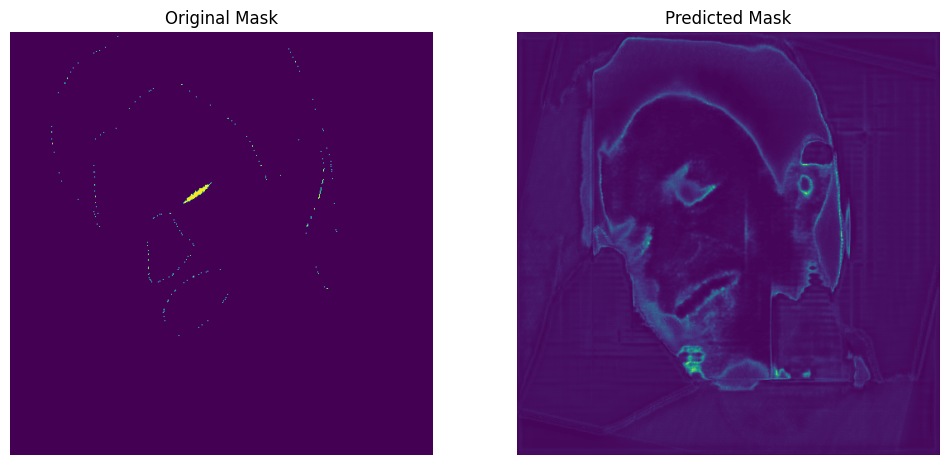

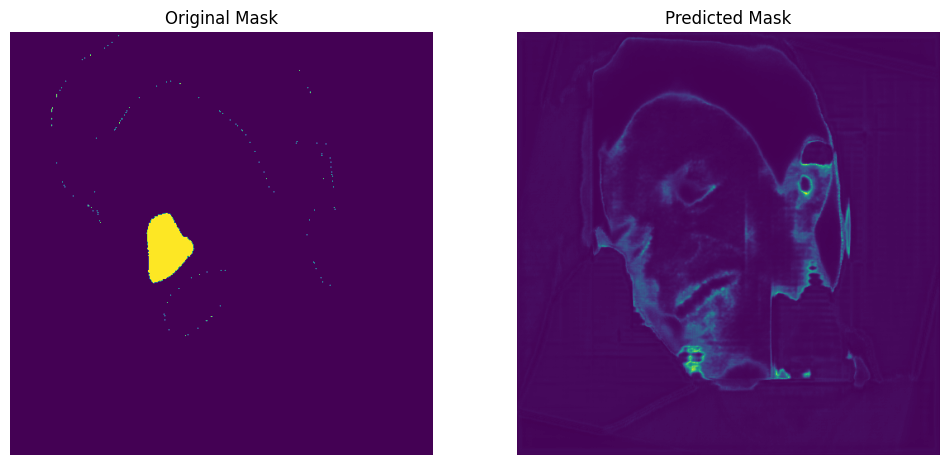

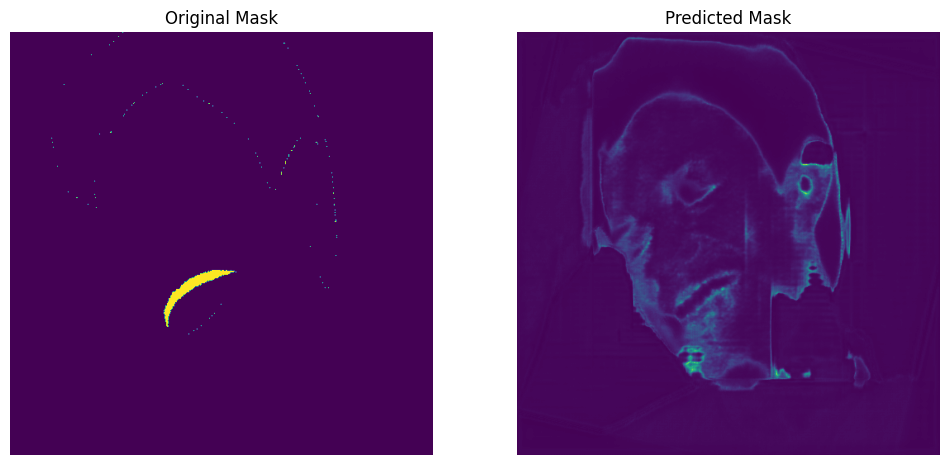

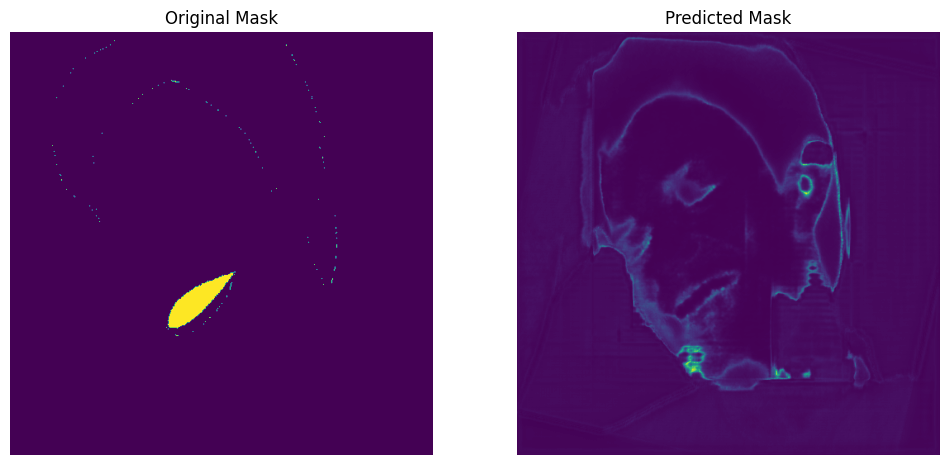

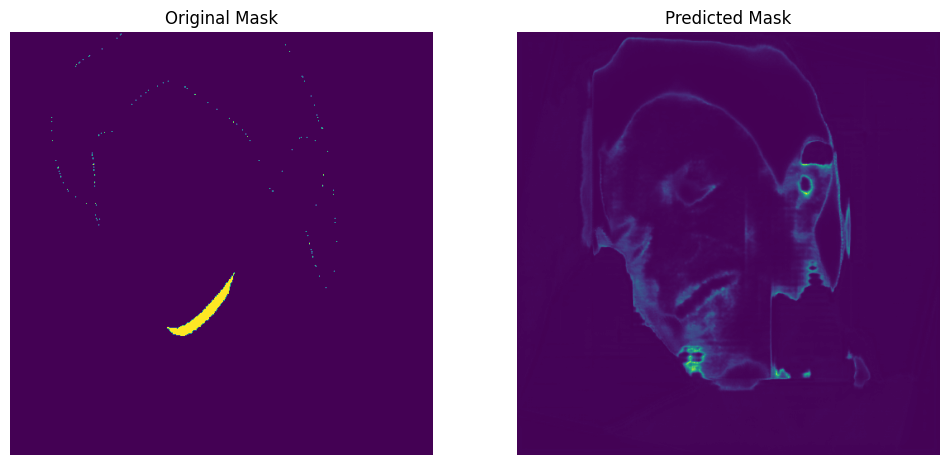

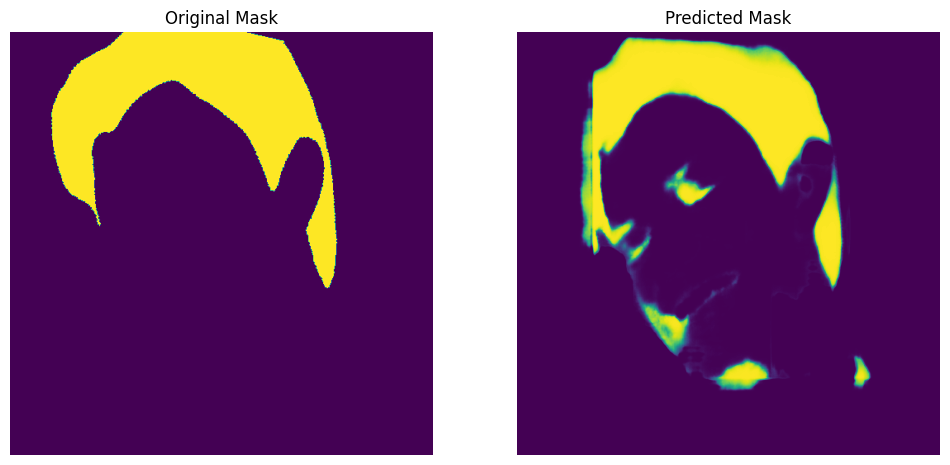

In [ ]:
for i in range(0, 11):
  fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with two subplots
  axes[0].imshow(mask[1][i].cpu())  # Display original image
  axes[0].set_title('Original Mask')
  axes[0].axis('off')  # Hide axis
  axes[1].imshow(pred[1][i].detach().cpu().numpy())  # Display composite image with masks
  axes[1].set_title('Predicted Mask')
  axes[1].axis('off')  # Hide axis
  plt.show()

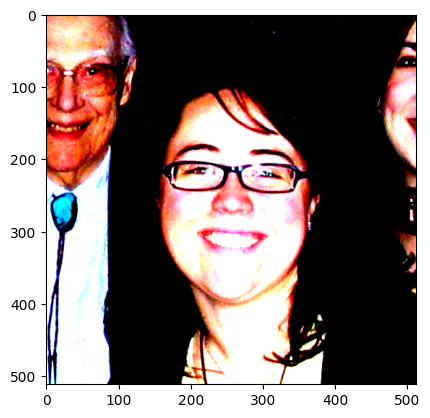

In [ ]:
img = np.array(image[1].permute(1,2,0).cpu())
plt.imshow(img)

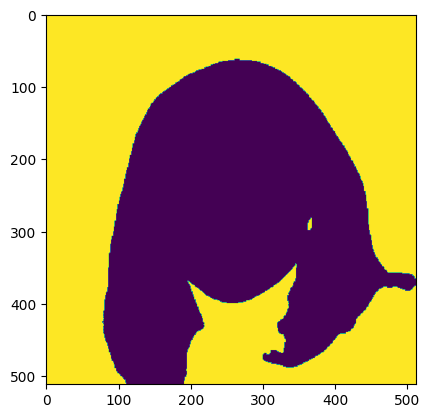

In [ ]:
plt.imshow(mask[1][0].cpu())

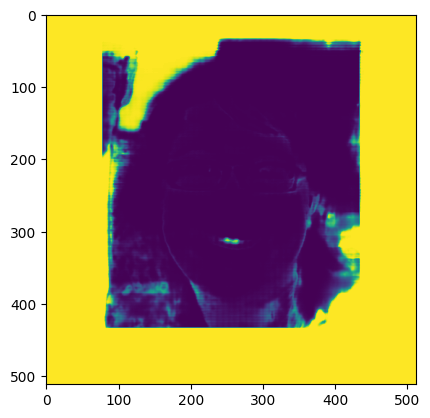

In [ ]:
plt.imshow(pred[1][0].detach().cpu().numpy())

# U-net GAN

In [81]:
import torch
from torch import nn
from torch.nn import functional as F


class EncoderBlock(nn.Module):
    """Encoder block"""
    def __init__(self, inplanes, outplanes, kernel_size=4, stride=2, padding=1, norm=True):
        super().__init__()
        self.lrelu = nn.LeakyReLU(0.2, inplace=True)
        self.conv = nn.Conv2d(inplanes, outplanes, kernel_size, stride, padding)

        self.bn=None
        if norm:
            self.bn = nn.BatchNorm2d(outplanes)

    def forward(self, x):
        fx = self.lrelu(x)
        fx = self.conv(fx)

        if self.bn is not None:
            fx = self.bn(fx)

        return fx


class DecoderBlock(nn.Module):
    """Decoder block"""
    def __init__(self, inplanes, outplanes, kernel_size=4, stride=2, padding=1, dropout=False):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.deconv = nn.ConvTranspose2d(inplanes, outplanes, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(outplanes)

        self.dropout=None
        if dropout:
            self.dropout = nn.Dropout2d(p=0.5, inplace=True)

    def forward(self, x):
        fx = self.relu(x)
        fx = self.deconv(fx)
        fx = self.bn(fx)

        if self.dropout is not None:
            fx = self.dropout(fx)

        return fx


class Generator(nn.Module):
    """Encoder-Decoder model"""
    def __init__(self,):
        super().__init__()

        self.encoder1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.encoder2 = EncoderBlock(64, 128)
        self.encoder3 = EncoderBlock(128, 256)
        self.encoder4 = EncoderBlock(256, 512)
        self.encoder5 = EncoderBlock(512, 512)
        self.encoder6 = EncoderBlock(512, 512)
        self.encoder7 = EncoderBlock(512, 512)
        self.encoder8 = EncoderBlock(512, 512, norm=False)

        self.decoder8 = DecoderBlock(512, 512, dropout=True)
        self.decoder7 = DecoderBlock(512, 512, dropout=True)
        self.decoder6 = DecoderBlock(512, 512, dropout=True)
        self.decoder5 = DecoderBlock(512, 512)
        self.decoder4 = DecoderBlock(512, 256)
        self.decoder3 = DecoderBlock(256, 128)
        self.decoder2 = DecoderBlock(128, 64)
        self.decoder1 = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        # encoder forward
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)
        e5 = self.encoder5(e4)
        e6 = self.encoder6(e5)
        e7 = self.encoder7(e6)
        e8 = self.encoder8(e7)
        # decoder forward
        d8 = self.decoder8(e8)
        d7 = self.decoder7(d8)
        d6 = self.decoder6(d7)
        d5 = self.decoder5(d6)
        d4 = self.decoder4(d5)
        d3 = self.decoder3(d4)
        d2 = F.relu(self.decoder2(d3))
        d1 = self.decoder1(d2)

        return torch.tanh(d1)


class UnetGenerator(nn.Module):
    """Unet-like Encoder-Decoder model"""
    def __init__(self,):
        super().__init__()

        self.encoder1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.encoder2 = EncoderBlock(64, 128)
        self.encoder3 = EncoderBlock(128, 256)
        self.encoder4 = EncoderBlock(256, 512)
        self.encoder5 = EncoderBlock(512, 512)
        self.encoder6 = EncoderBlock(512, 512)
        self.encoder7 = EncoderBlock(512, 512)
        self.encoder8 = EncoderBlock(512, 512, norm=False)

        self.decoder8 = DecoderBlock(512, 512, dropout=True)
        self.decoder7 = DecoderBlock(2*512, 512, dropout=True)
        self.decoder6 = DecoderBlock(2*512, 512, dropout=True)
        self.decoder5 = DecoderBlock(2*512, 512)
        self.decoder4 = DecoderBlock(2*512, 256)
        self.decoder3 = DecoderBlock(2*256, 128)
        self.decoder2 = DecoderBlock(2*128, 64)
        self.decoder1 = nn.ConvTranspose2d(2*64, 3, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        # encoder forward
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)
        e5 = self.encoder5(e4)
        e6 = self.encoder6(e5)
        e7 = self.encoder7(e6)
        e8 = self.encoder8(e7)
        # decoder forward + skip connections
        d8 = self.decoder8(e8)
        d8 = torch.cat([d8, e7], dim=1)
        d7 = self.decoder7(d8)
        d7 = torch.cat([d7, e6], dim=1)
        d6 = self.decoder6(d7)
        d6 = torch.cat([d6, e5], dim=1)
        d5 = self.decoder5(d6)
        d5 = torch.cat([d5, e4], dim=1)
        d4 = self.decoder4(d5)
        d4 = torch.cat([d4, e3], dim=1)
        d3 = self.decoder3(d4)
        d3 = torch.cat([d3, e2], dim=1)
        d2 = F.relu(self.decoder2(d3))
        d2 = torch.cat([d2, e1], dim=1)
        d1 = self.decoder1(d2)

        return torch.tanh(d1)

In [104]:
class BasicBlock(nn.Module):
    """Basic block"""
    def __init__(self, inplanes, outplanes, kernel_size=4, stride=2, padding=1, norm=True):
        super().__init__()
        self.conv = nn.Conv2d(inplanes, outplanes, kernel_size, stride, padding)
        self.isn = None
        if norm:
            self.isn = nn.InstanceNorm2d(outplanes)
        self.lrelu = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        fx = self.conv(x)

        if self.isn is not None:
            fx = self.isn(fx)

        fx = self.lrelu(fx)
        return fx


class Discriminator(nn.Module):
    """Basic Discriminator"""
    def __init__(self,):
        super().__init__()
        self.block1 = BasicBlock(3, 64, norm=False)
        self.block2 = BasicBlock(64, 128)
        self.block3 = BasicBlock(128, 256)
        self.block4 = BasicBlock(256, 512)
        self.block5 = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)

    def forward(self, x):
        # blocks forward
        fx = self.block1(x)
        fx = self.block2(fx)
        fx = self.block3(fx)
        fx = self.block4(fx)
        fx = self.block5(fx)

        return fx


class ConditionalDiscriminator(nn.Module):
    """Conditional Discriminator"""
    def __init__(self,):
        super().__init__()
        self.block1 = BasicBlock(6, 64, norm=False)
        self.block2 = BasicBlock(64, 128)
        self.block3 = BasicBlock(128, 256)
        self.block4 = BasicBlock(256, 512)
        self.block5 = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)

    def forward(self, x, cond):
        x = torch.cat([x, cond], dim=1)
        # blocks forward
        fx = self.block1(x)
        fx = self.block2(fx)
        fx = self.block3(fx)
        fx = self.block4(fx)
        fx = self.block5(fx)

        return fx

In [105]:
class GeneratorLoss(nn.Module):
    def __init__(self, alpha=100):
        super().__init__()
        self.alpha=alpha
        self.bce=nn.BCEWithLogitsLoss()
        self.l1=nn.L1Loss()

    def forward(self, fake, real, fake_pred):
        fake_target = torch.ones_like(fake_pred)
        loss = self.bce(fake_pred, fake_target) + self.alpha* self.l1(fake, real)
        return loss


class DiscriminatorLoss(nn.Module):
    def __init__(self,):
        super().__init__()
        self.loss_fn = nn.BCEWithLogitsLoss()

    def forward(self, fake_pred, real_pred):
        fake_target = torch.zeros_like(fake_pred)
        real_target = torch.ones_like(real_pred)
        fake_loss = self.loss_fn(fake_pred, fake_target)
        real_loss = self.loss_fn(real_pred, real_target)
        loss = (fake_loss + real_loss)/2
        return loss

In [106]:
lr = 0.0001

In [107]:
batch_size = 2
train_loader = DataLoader(p_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(p_val_dataset, batch_size=batch_size, shuffle=False)

In [108]:
# generator = UnetGenerator().to(device)
generator = VanillaUNet(in_channels=3,num_classes=3).to(device)
# generator = UnetGenerator().to(device)
discriminator = ConditionalDiscriminator().to(device)
# optimizers
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
# loss functions
g_criterion = GeneratorLoss(alpha=100)
d_criterion = DiscriminatorLoss()

In [109]:
def train_loop(model,dataloader,loss_fun,optimizer, num_epochs,device):
    model.train()
    model.to(device)
    min_loss = None
    for epoch in range(num_epochs):
        losses = []
        loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True)
        for batch,(x,y) in loop:
            # put on cuda
            x = x.to(device)
            y = y.to(device)

            # forward pass
            y_pred = model(x)

            # calculate loss & accuracy
            loss = loss_fun(y_pred.reshape(-1),y.reshape(-1))
            losses.append(loss.detach().item())

            # zero out prior gradients
            optimizer.zero_grad()

            # backprop
            loss.backward()

            # update weights
            optimizer.step()
            scheduler.step()

            # Update TQDM progress bar
            loop.set_description(f"Epoch [{epoch}/{num_epochs}] ")
            loop.set_postfix(loss=loss.detach().item())

        moving_loss = sum(losses) / len(losses)
        checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
        # Save check point
        if min_loss == None:
            min_loss = moving_loss
            save_checkpoint(checkpoint)
        elif moving_loss < min_loss:
            min_loss = moving_loss
            save_checkpoint(checkpoint)
        print('Epoch {0} : Loss = {1}'.format(epoch + 1, moving_loss))

In [117]:
# def GAN_train(geneator, discriminator, dataloader, g_loss, d_loss, g_optimizer, d_optimizer, num_epochs,device):
for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_loader), total = len(train_loader), leave = True)
    ge_loss=0.
    de_loss=0.
    start = time.time()
    # bar = IncrementalBar(f'[Epoch {epoch+1}/{args.epochs}]', max=len(dataloader))
    for batch, (x, real) in loop:
        x = x.to(device)
        real = real.to(device)

        # Generator`s loss
        fake = generator(x)
        # print(fake.shape, x.shape)
        fake_pred = discriminator(fake, x)
        # print(real.shape, fake.shape, fake_pred.shape)
        g_loss = g_criterion(fake, real, fake_pred)

        # Discriminator`s loss
        fake = generator(x).detach()
        fake_pred = discriminator(fake, x)
        real_pred = discriminator(real, x)
        d_loss = d_criterion(fake_pred, real_pred)

        # Generator`s params update
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # Discriminator`s params update
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        # add batch losses
        ge_loss += g_loss.item()
        de_loss += d_loss.item()

        # Update TQDM progress bar
    loop.set_description(f"Epoch [{epoch}/{num_epochs}] ")


    # obttain per epoch losses
    g_loss = ge_loss/len(train_loader)
    d_loss = de_loss/len(train_loader)

    '''
    checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
    # Save check point
    if min_loss == None:
      min_loss = moving_loss
      save_checkpoint(checkpoint)
    elif moving_loss < min_loss:
      min_loss = moving_loss
      save_checkpoint(checkpoint)
    '''
    # count timeframe
    end = time.time()
    tm = (end - start)
    print("[Epoch %d/%d] [G loss: %.3f] [D loss: %.3f] ETA: %.3fs" % (epoch+1, num_epochs, g_loss, d_loss, tm))

  0%|          | 0/550 [00:00<?, ?it/s]

(450, 450, 3)
(450, 450, 3)


  0%|          | 1/550 [00:00<07:37,  1.20it/s]

(450, 450, 3)
(730, 730, 3)


  0%|          | 2/550 [00:01<07:26,  1.23it/s]

(358, 356, 3)
(744, 676, 3)


  1%|          | 3/550 [00:02<07:25,  1.23it/s]

(450, 450, 3)
(450, 450, 3)


  1%|          | 4/550 [00:03<07:21,  1.24it/s]

(506, 514, 3)
(450, 450, 3)


  1%|          | 5/550 [00:04<07:19,  1.24it/s]

(508, 506, 3)
(450, 450, 3)


  1%|          | 6/550 [00:04<07:18,  1.24it/s]

(450, 450, 3)
(450, 450, 3)


  1%|▏         | 7/550 [00:05<07:15,  1.25it/s]

(450, 450, 3)
(590, 550, 3)


  1%|▏         | 8/550 [00:06<07:18,  1.24it/s]

(570, 570, 3)
(354, 332, 3)


  2%|▏         | 9/550 [00:07<07:18,  1.24it/s]

(558, 568, 3)
(1204, 939, 3)


  2%|▏         | 10/550 [00:08<07:20,  1.23it/s]

(450, 450, 3)
(510, 486, 3)


  2%|▏         | 11/550 [00:08<07:20,  1.22it/s]

(620, 620, 3)
(450, 450, 3)


  2%|▏         | 12/550 [00:09<07:20,  1.22it/s]

(1601, 1562, 3)
(450, 450, 3)


  2%|▏         | 13/550 [00:10<07:31,  1.19it/s]

(534, 534, 3)
(462, 462, 3)


  3%|▎         | 14/550 [00:11<07:30,  1.19it/s]

(450, 450, 3)
(668, 686, 3)


  3%|▎         | 15/550 [00:12<07:29,  1.19it/s]

(656, 652, 3)
(642, 640, 3)


  3%|▎         | 16/550 [00:13<07:32,  1.18it/s]

(598, 614, 3)
(450, 450, 3)


  3%|▎         | 17/550 [00:14<07:32,  1.18it/s]

(406, 420, 3)
(450, 450, 3)


  3%|▎         | 18/550 [00:14<07:31,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


  3%|▎         | 19/550 [00:15<07:25,  1.19it/s]

(490, 490, 3)
(450, 450, 3)


  4%|▎         | 20/550 [00:16<07:23,  1.19it/s]

(450, 450, 3)
(432, 432, 3)


  4%|▍         | 21/550 [00:17<07:21,  1.20it/s]

(450, 450, 3)
(706, 708, 3)


  4%|▍         | 22/550 [00:18<07:21,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


  4%|▍         | 23/550 [00:19<07:21,  1.19it/s]

(864, 840, 3)
(450, 450, 3)


  4%|▍         | 24/550 [00:19<07:21,  1.19it/s]

(450, 450, 3)
(1482, 1520, 3)


  5%|▍         | 25/550 [00:20<07:27,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


  5%|▍         | 26/550 [00:21<07:25,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


  5%|▍         | 27/550 [00:22<07:23,  1.18it/s]

(696, 646, 3)
(450, 450, 3)


  5%|▌         | 28/550 [00:23<07:23,  1.18it/s]

(588, 536, 3)
(450, 450, 3)


  5%|▌         | 29/550 [00:24<07:22,  1.18it/s]

(450, 450, 3)
(454, 414, 3)


  5%|▌         | 30/550 [00:25<07:19,  1.18it/s]

(666, 716, 3)
(478, 452, 3)


  6%|▌         | 31/550 [00:25<07:23,  1.17it/s]

(450, 450, 3)
(526, 530, 3)


  6%|▌         | 32/550 [00:26<07:22,  1.17it/s]

(342, 342, 3)
(674, 624, 3)


  6%|▌         | 33/550 [00:27<07:25,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


  6%|▌         | 34/550 [00:28<07:26,  1.16it/s]

(552, 544, 3)
(304, 304, 3)


  6%|▋         | 35/550 [00:29<07:24,  1.16it/s]

(450, 450, 3)
(392, 400, 3)


  7%|▋         | 36/550 [00:30<07:22,  1.16it/s]

(410, 380, 3)
(450, 450, 3)


  7%|▋         | 37/550 [00:31<07:21,  1.16it/s]

(450, 450, 3)
(410, 390, 3)


  7%|▋         | 38/550 [00:31<07:20,  1.16it/s]

(450, 450, 3)
(572, 614, 3)


  7%|▋         | 39/550 [00:32<07:19,  1.16it/s]

(998, 946, 3)
(450, 450, 3)


  7%|▋         | 40/550 [00:33<07:21,  1.16it/s]

(558, 514, 3)
(408, 416, 3)


  7%|▋         | 41/550 [00:34<07:21,  1.15it/s]

(450, 450, 3)
(402, 398, 3)


  8%|▊         | 42/550 [00:35<07:20,  1.15it/s]

(220, 216, 3)
(450, 450, 3)


  8%|▊         | 43/550 [00:36<07:18,  1.16it/s]

(1109, 939, 3)
(766, 728, 3)


  8%|▊         | 44/550 [00:37<07:24,  1.14it/s]

(478, 444, 3)
(372, 340, 3)


  8%|▊         | 45/550 [00:38<07:21,  1.14it/s]

(744, 704, 3)
(450, 450, 3)


  8%|▊         | 46/550 [00:38<07:24,  1.13it/s]

(450, 450, 3)
(450, 450, 3)


  9%|▊         | 47/550 [00:39<07:21,  1.14it/s]

(786, 696, 3)
(608, 608, 3)


  9%|▊         | 48/550 [00:40<07:24,  1.13it/s]

(804, 804, 3)
(450, 450, 3)


  9%|▉         | 49/550 [00:41<07:25,  1.12it/s]

(662, 553, 3)
(450, 450, 3)


  9%|▉         | 50/550 [00:42<07:25,  1.12it/s]

(450, 450, 3)
(450, 450, 3)


  9%|▉         | 51/550 [00:43<07:20,  1.13it/s]

(450, 450, 3)
(1498, 1558, 3)


  9%|▉         | 52/550 [00:44<07:23,  1.12it/s]

(450, 450, 3)
(1478, 1438, 3)


 10%|▉         | 53/550 [00:45<07:25,  1.12it/s]

(534, 488, 3)
(450, 450, 3)


 10%|▉         | 54/550 [00:46<07:17,  1.13it/s]

(450, 450, 3)
(450, 450, 3)


 10%|█         | 55/550 [00:46<07:12,  1.14it/s]

(450, 450, 3)
(450, 450, 3)


 10%|█         | 56/550 [00:47<07:07,  1.16it/s]

(450, 450, 3)
(396, 432, 3)


 10%|█         | 57/550 [00:48<07:03,  1.16it/s]

(450, 450, 3)
(370, 338, 3)


 11%|█         | 58/550 [00:49<06:59,  1.17it/s]

(450, 450, 3)
(634, 578, 3)


 11%|█         | 59/550 [00:50<06:58,  1.17it/s]

(450, 450, 3)
(710, 716, 3)


 11%|█         | 60/550 [00:51<06:59,  1.17it/s]

(450, 450, 3)
(1971, 1425, 3)


 11%|█         | 61/550 [00:52<07:06,  1.15it/s]

(450, 450, 3)
(508, 452, 3)


 11%|█▏        | 62/550 [00:52<07:02,  1.15it/s]

(450, 450, 3)
(626, 620, 3)


 11%|█▏        | 63/550 [00:53<07:02,  1.15it/s]

(432, 392, 3)
(450, 450, 3)


 12%|█▏        | 64/550 [00:54<06:59,  1.16it/s]

(506, 518, 3)
(490, 484, 3)


 12%|█▏        | 65/550 [00:55<06:58,  1.16it/s]

(948, 888, 3)
(450, 450, 3)


 12%|█▏        | 66/550 [00:56<06:59,  1.15it/s]

(232, 232, 3)
(300, 270, 3)


 12%|█▏        | 67/550 [00:57<06:56,  1.16it/s]

(450, 450, 3)
(762, 740, 3)


 12%|█▏        | 68/550 [00:58<06:51,  1.17it/s]

(450, 450, 3)
(650, 648, 3)


 13%|█▎        | 69/550 [00:58<06:48,  1.18it/s]

(498, 496, 3)
(450, 450, 3)


 13%|█▎        | 70/550 [00:59<06:44,  1.19it/s]

(380, 348, 3)
(372, 390, 3)


 13%|█▎        | 71/550 [01:00<06:41,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 13%|█▎        | 72/550 [01:01<06:38,  1.20it/s]

(450, 450, 3)
(546, 508, 3)


 13%|█▎        | 73/550 [01:02<06:37,  1.20it/s]

(444, 440, 3)
(676, 648, 3)


 13%|█▎        | 74/550 [01:03<06:35,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 14%|█▎        | 75/550 [01:03<06:34,  1.21it/s]

(450, 450, 3)
(328, 350, 3)


 14%|█▍        | 76/550 [01:04<06:33,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 14%|█▍        | 77/550 [01:05<06:32,  1.21it/s]

(450, 450, 3)
(450, 450, 3)


 14%|█▍        | 78/550 [01:06<06:31,  1.20it/s]

(681, 660, 3)
(486, 326, 3)


 14%|█▍        | 79/550 [01:07<06:33,  1.20it/s]

(450, 450, 3)
(824, 824, 3)


 15%|█▍        | 80/550 [01:08<06:37,  1.18it/s]

(480, 482, 3)
(450, 450, 3)


 15%|█▍        | 81/550 [01:08<06:36,  1.18it/s]

(450, 450, 3)
(1368, 1440, 3)


 15%|█▍        | 82/550 [01:09<06:48,  1.15it/s]

(340, 376, 3)
(450, 450, 3)


 15%|█▌        | 83/550 [01:10<06:43,  1.16it/s]

(600, 564, 3)
(1268, 1502, 3)


 15%|█▌        | 84/550 [01:11<06:43,  1.15it/s]

(674, 672, 3)
(1472, 1368, 3)


 15%|█▌        | 85/550 [01:12<06:45,  1.15it/s]

(514, 514, 3)
(452, 480, 3)


 16%|█▌        | 86/550 [01:13<06:39,  1.16it/s]

(606, 606, 3)
(450, 450, 3)


 16%|█▌        | 87/550 [01:14<06:34,  1.17it/s]

(450, 450, 3)
(610, 610, 3)


 16%|█▌        | 88/550 [01:14<06:29,  1.18it/s]

(450, 450, 3)
(660, 682, 3)


 16%|█▌        | 89/550 [01:15<06:26,  1.19it/s]

(324, 324, 3)
(620, 572, 3)


 16%|█▋        | 90/550 [01:16<06:23,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 17%|█▋        | 91/550 [01:17<06:20,  1.21it/s]

(450, 450, 3)
(450, 450, 3)


 17%|█▋        | 92/550 [01:18<06:17,  1.21it/s]

(486, 456, 3)
(450, 450, 3)


 17%|█▋        | 93/550 [01:19<06:17,  1.21it/s]

(450, 450, 3)
(572, 572, 3)


 17%|█▋        | 94/550 [01:19<06:15,  1.22it/s]

(466, 446, 3)
(450, 450, 3)


 17%|█▋        | 95/550 [01:20<06:14,  1.21it/s]

(450, 450, 3)
(2872, 2733, 3)


 17%|█▋        | 96/550 [01:21<07:19,  1.03it/s]

(450, 450, 3)
(450, 450, 3)


 18%|█▊        | 97/550 [01:22<06:59,  1.08it/s]

(494, 470, 3)
(450, 450, 3)


 18%|█▊        | 98/550 [01:23<06:45,  1.11it/s]

(532, 534, 3)
(454, 454, 3)


 18%|█▊        | 99/550 [01:24<06:35,  1.14it/s]

(818, 818, 3)
(450, 450, 3)


 18%|█▊        | 100/550 [01:25<06:28,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


 18%|█▊        | 101/550 [01:26<06:19,  1.18it/s]

(450, 450, 3)
(532, 532, 3)


 19%|█▊        | 102/550 [01:26<06:16,  1.19it/s]

(450, 450, 3)
(344, 316, 3)


 19%|█▊        | 103/550 [01:27<06:11,  1.20it/s]

(640, 582, 3)
(760, 830, 3)


 19%|█▉        | 104/550 [01:28<06:11,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 19%|█▉        | 105/550 [01:29<06:08,  1.21it/s]

(450, 450, 3)
(384, 354, 3)


 19%|█▉        | 106/550 [01:30<06:06,  1.21it/s]

(136, 148, 3)
(450, 450, 3)


 19%|█▉        | 107/550 [01:31<06:03,  1.22it/s]

(450, 450, 3)
(450, 450, 3)


 20%|█▉        | 108/550 [01:31<05:59,  1.23it/s]

(450, 450, 3)
(450, 450, 3)


 20%|█▉        | 109/550 [01:32<06:00,  1.22it/s]

(142, 140, 3)
(450, 450, 3)


 20%|██        | 110/550 [01:33<05:58,  1.23it/s]

(450, 450, 3)
(548, 484, 3)


 20%|██        | 111/550 [01:34<06:01,  1.21it/s]

(492, 454, 3)
(450, 450, 3)


 20%|██        | 112/550 [01:35<06:03,  1.20it/s]

(812, 768, 3)
(450, 450, 3)


 21%|██        | 113/550 [01:36<06:06,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 21%|██        | 114/550 [01:36<06:06,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 21%|██        | 115/550 [01:37<06:06,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 21%|██        | 116/550 [01:38<06:04,  1.19it/s]

(450, 450, 3)
(606, 644, 3)


 21%|██▏       | 117/550 [01:39<06:03,  1.19it/s]

(392, 390, 3)
(450, 450, 3)


 21%|██▏       | 118/550 [01:40<06:03,  1.19it/s]

(448, 438, 3)
(610, 612, 3)


 22%|██▏       | 119/550 [01:41<06:04,  1.18it/s]

(354, 354, 3)
(352, 352, 3)


 22%|██▏       | 120/550 [01:41<06:01,  1.19it/s]

(4506, 3648, 3)
(364, 326, 3)


 22%|██▏       | 121/550 [01:43<07:20,  1.03s/it]

(450, 450, 3)
(576, 514, 3)


 22%|██▏       | 122/550 [01:44<06:56,  1.03it/s]

(186, 192, 3)
(1500, 1402, 3)


 22%|██▏       | 123/550 [01:45<06:43,  1.06it/s]

(450, 450, 3)
(450, 450, 3)


 23%|██▎       | 124/550 [01:45<06:30,  1.09it/s]

(450, 450, 3)
(476, 488, 3)


 23%|██▎       | 125/550 [01:46<06:18,  1.12it/s]

(450, 450, 3)
(1148, 1102, 3)


 23%|██▎       | 126/550 [01:47<06:13,  1.13it/s]

(800, 600, 3)
(450, 450, 3)


 23%|██▎       | 127/550 [01:48<06:09,  1.14it/s]

(450, 450, 3)
(450, 450, 3)


 23%|██▎       | 128/550 [01:49<06:05,  1.15it/s]

(450, 450, 3)
(450, 450, 3)


 23%|██▎       | 129/550 [01:50<06:01,  1.16it/s]

(626, 628, 3)
(409, 452, 3)


 24%|██▎       | 130/550 [01:51<06:01,  1.16it/s]

(373, 348, 3)
(486, 486, 3)


 24%|██▍       | 131/550 [01:51<06:00,  1.16it/s]

(472, 498, 3)
(450, 450, 3)


 24%|██▍       | 132/550 [01:52<05:57,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 24%|██▍       | 133/550 [01:53<05:54,  1.18it/s]

(450, 450, 3)
(648, 694, 3)


 24%|██▍       | 134/550 [01:54<05:53,  1.18it/s]

(474, 482, 3)
(450, 450, 3)


 25%|██▍       | 135/550 [01:55<05:50,  1.18it/s]

(886, 679, 3)
(450, 450, 3)


 25%|██▍       | 136/550 [01:56<05:50,  1.18it/s]

(420, 420, 3)
(450, 450, 3)


 25%|██▍       | 137/550 [01:56<05:48,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 25%|██▌       | 138/550 [01:57<05:46,  1.19it/s]

(450, 450, 3)
(402, 386, 3)


 25%|██▌       | 139/550 [01:58<05:46,  1.19it/s]

(494, 506, 3)
(788, 716, 3)


 25%|██▌       | 140/550 [01:59<05:46,  1.18it/s]

(446, 416, 3)
(446, 414, 3)


 26%|██▌       | 141/550 [02:00<05:45,  1.18it/s]

(450, 450, 3)
(368, 340, 3)


 26%|██▌       | 142/550 [02:01<05:44,  1.18it/s]

(450, 450, 3)
(564, 566, 3)


 26%|██▌       | 143/550 [02:02<05:45,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 26%|██▌       | 144/550 [02:02<05:44,  1.18it/s]

(590, 552, 3)
(450, 418, 3)


 26%|██▋       | 145/550 [02:03<05:46,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 27%|██▋       | 146/550 [02:04<05:44,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 27%|██▋       | 147/550 [02:05<05:43,  1.17it/s]

(372, 372, 3)
(450, 450, 3)


 27%|██▋       | 148/550 [02:06<05:42,  1.18it/s]

(724, 694, 3)
(450, 450, 3)


 27%|██▋       | 149/550 [02:07<05:41,  1.18it/s]

(956, 1020, 3)
(450, 450, 3)


 27%|██▋       | 150/550 [02:07<05:39,  1.18it/s]

(612, 634, 3)
(572, 596, 3)


 27%|██▋       | 151/550 [02:08<05:39,  1.17it/s]

(450, 450, 3)
(802, 800, 3)


 28%|██▊       | 152/550 [02:09<05:38,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 28%|██▊       | 153/550 [02:10<05:35,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 28%|██▊       | 154/550 [02:11<05:33,  1.19it/s]

(464, 464, 3)
(450, 450, 3)


 28%|██▊       | 155/550 [02:12<05:32,  1.19it/s]

(386, 378, 3)
(450, 450, 3)


 28%|██▊       | 156/550 [02:13<05:31,  1.19it/s]

(568, 554, 3)
(554, 562, 3)


 29%|██▊       | 157/550 [02:13<05:30,  1.19it/s]

(652, 632, 3)
(450, 450, 3)


 29%|██▊       | 158/550 [02:14<05:30,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 29%|██▉       | 159/550 [02:15<05:28,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 29%|██▉       | 160/550 [02:16<05:26,  1.19it/s]

(354, 338, 3)
(462, 462, 3)


 29%|██▉       | 161/550 [02:17<05:26,  1.19it/s]

(434, 434, 3)
(498, 498, 3)


 29%|██▉       | 162/550 [02:18<05:26,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 30%|██▉       | 163/550 [02:18<05:24,  1.19it/s]

(722, 722, 3)
(668, 692, 3)


 30%|██▉       | 164/550 [02:19<05:25,  1.19it/s]

(562, 550, 3)
(358, 358, 3)


 30%|███       | 165/550 [02:20<05:23,  1.19it/s]

(450, 450, 3)
(616, 600, 3)


 30%|███       | 166/550 [02:21<05:22,  1.19it/s]

(450, 450, 3)
(334, 334, 3)


 30%|███       | 167/550 [02:22<05:20,  1.19it/s]

(482, 454, 3)
(454, 422, 3)


 31%|███       | 168/550 [02:23<05:19,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 31%|███       | 169/550 [02:23<05:17,  1.20it/s]

(370, 370, 3)
(450, 450, 3)


 31%|███       | 170/550 [02:24<05:17,  1.20it/s]

(450, 450, 3)
(614, 640, 3)


 31%|███       | 171/550 [02:25<05:15,  1.20it/s]

(450, 450, 3)
(1040, 1112, 3)


 31%|███▏      | 172/550 [02:26<05:16,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 31%|███▏      | 173/550 [02:27<05:15,  1.20it/s]

(450, 450, 3)
(430, 444, 3)


 32%|███▏      | 174/550 [02:28<05:14,  1.19it/s]

(450, 450, 3)
(382, 382, 3)


 32%|███▏      | 175/550 [02:28<05:13,  1.20it/s]

(450, 450, 3)
(426, 426, 3)


 32%|███▏      | 176/550 [02:29<05:12,  1.20it/s]

(538, 552, 3)
(856, 756, 3)


 32%|███▏      | 177/550 [02:30<05:15,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 32%|███▏      | 178/550 [02:31<05:14,  1.18it/s]

(450, 450, 3)
(284, 284, 3)


 33%|███▎      | 179/550 [02:32<05:12,  1.19it/s]

(430, 438, 3)
(323, 342, 3)


 33%|███▎      | 180/550 [02:33<05:11,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 33%|███▎      | 181/550 [02:33<05:07,  1.20it/s]

(276, 282, 3)
(450, 450, 3)


 33%|███▎      | 182/550 [02:34<05:05,  1.20it/s]

(450, 450, 3)
(668, 656, 3)


 33%|███▎      | 183/550 [02:35<05:05,  1.20it/s]

(450, 450, 3)
(362, 362, 3)


 33%|███▎      | 184/550 [02:36<05:04,  1.20it/s]

(596, 558, 3)
(300, 310, 3)


 34%|███▎      | 185/550 [02:37<05:03,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 34%|███▍      | 186/550 [02:38<05:02,  1.21it/s]

(450, 450, 3)
(450, 450, 3)


 34%|███▍      | 187/550 [02:38<05:00,  1.21it/s]

(478, 468, 3)
(450, 450, 3)


 34%|███▍      | 188/550 [02:39<04:59,  1.21it/s]

(834, 902, 3)
(450, 450, 3)


 34%|███▍      | 189/550 [02:40<04:59,  1.21it/s]

(552, 574, 3)
(450, 450, 3)


 35%|███▍      | 190/550 [02:41<04:59,  1.20it/s]

(450, 450, 3)
(500, 491, 3)


 35%|███▍      | 191/550 [02:42<04:58,  1.20it/s]

(360, 360, 3)
(520, 518, 3)


 35%|███▍      | 192/550 [02:43<04:57,  1.20it/s]

(728, 754, 3)
(434, 438, 3)


 35%|███▌      | 193/550 [02:43<04:59,  1.19it/s]

(448, 448, 3)
(308, 290, 3)


 35%|███▌      | 194/550 [02:44<05:00,  1.19it/s]

(450, 450, 3)
(436, 412, 3)


 35%|███▌      | 195/550 [02:45<04:59,  1.18it/s]

(554, 530, 3)
(450, 450, 3)


 36%|███▌      | 196/550 [02:46<04:58,  1.19it/s]

(704, 664, 3)
(450, 450, 3)


 36%|███▌      | 197/550 [02:47<04:57,  1.19it/s]

(450, 450, 3)
(710, 716, 3)


 36%|███▌      | 198/550 [02:48<04:55,  1.19it/s]

(562, 596, 3)
(532, 486, 3)


 36%|███▌      | 199/550 [02:49<04:53,  1.19it/s]

(450, 450, 3)
(328, 334, 3)


 36%|███▋      | 200/550 [02:49<04:52,  1.20it/s]

(330, 278, 3)
(388, 380, 3)


 37%|███▋      | 201/550 [02:50<04:51,  1.20it/s]

(586, 586, 3)
(450, 450, 3)


 37%|███▋      | 202/550 [02:51<04:49,  1.20it/s]

(450, 450, 3)
(390, 416, 3)


 37%|███▋      | 203/550 [02:52<04:48,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 37%|███▋      | 204/550 [02:53<04:47,  1.20it/s]

(550, 536, 3)
(318, 318, 3)


 37%|███▋      | 205/550 [02:54<04:47,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 37%|███▋      | 206/550 [02:54<04:45,  1.20it/s]

(406, 428, 3)
(450, 450, 3)


 38%|███▊      | 207/550 [02:55<04:45,  1.20it/s]

(450, 450, 3)
(804, 802, 3)


 38%|███▊      | 208/550 [02:56<04:45,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 38%|███▊      | 209/550 [02:57<04:46,  1.19it/s]

(450, 450, 3)
(422, 396, 3)


 38%|███▊      | 210/550 [02:58<04:45,  1.19it/s]

(714, 698, 3)
(502, 492, 3)


 38%|███▊      | 211/550 [02:59<04:47,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 39%|███▊      | 212/550 [02:59<04:46,  1.18it/s]

(672, 690, 3)
(450, 450, 3)


 39%|███▊      | 213/550 [03:00<04:47,  1.17it/s]

(256, 254, 3)
(680, 668, 3)


 39%|███▉      | 214/550 [03:01<04:46,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 39%|███▉      | 215/550 [03:02<04:44,  1.18it/s]

(770, 770, 3)
(494, 494, 3)


 39%|███▉      | 216/550 [03:03<04:42,  1.18it/s]

(564, 564, 3)
(604, 604, 3)


 39%|███▉      | 217/550 [03:04<04:42,  1.18it/s]

(450, 450, 3)
(658, 696, 3)


 40%|███▉      | 218/550 [03:05<04:40,  1.18it/s]

(482, 494, 3)
(700, 632, 3)


 40%|███▉      | 219/550 [03:05<04:40,  1.18it/s]

(386, 380, 3)
(674, 616, 3)


 40%|████      | 220/550 [03:06<04:38,  1.19it/s]

(450, 450, 3)
(424, 424, 3)


 40%|████      | 221/550 [03:07<04:36,  1.19it/s]

(450, 450, 3)
(2304, 2595, 3)


 40%|████      | 222/550 [03:08<04:53,  1.12it/s]

(1612, 1566, 3)
(450, 450, 3)


 41%|████      | 223/550 [03:09<04:52,  1.12it/s]

(568, 532, 3)
(710, 722, 3)


 41%|████      | 224/550 [03:10<04:47,  1.13it/s]

(450, 450, 3)
(450, 450, 3)


 41%|████      | 225/550 [03:11<04:43,  1.15it/s]

(1282, 1492, 3)
(800, 748, 3)


 41%|████      | 226/550 [03:12<04:50,  1.11it/s]

(720, 762, 3)
(434, 432, 3)


 41%|████▏     | 227/550 [03:12<04:46,  1.13it/s]

(450, 450, 3)
(450, 450, 3)


 41%|████▏     | 228/550 [03:13<04:42,  1.14it/s]

(450, 450, 3)
(450, 450, 3)


 42%|████▏     | 229/550 [03:14<04:38,  1.15it/s]

(450, 450, 3)
(450, 450, 3)


 42%|████▏     | 230/550 [03:15<04:34,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 42%|████▏     | 231/550 [03:16<04:31,  1.18it/s]

(410, 424, 3)
(392, 404, 3)


 42%|████▏     | 232/550 [03:17<04:28,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 42%|████▏     | 233/550 [03:17<04:26,  1.19it/s]

(762, 744, 3)
(450, 450, 3)


 43%|████▎     | 234/550 [03:18<04:26,  1.19it/s]

(706, 754, 3)
(450, 450, 3)


 43%|████▎     | 235/550 [03:19<04:25,  1.19it/s]

(450, 450, 3)
(646, 624, 3)


 43%|████▎     | 236/550 [03:20<04:24,  1.19it/s]

(1345, 1516, 3)
(510, 476, 3)


 43%|████▎     | 237/550 [03:21<04:27,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 43%|████▎     | 238/550 [03:22<04:25,  1.17it/s]

(450, 450, 3)
(552, 552, 3)


 43%|████▎     | 239/550 [03:23<04:23,  1.18it/s]

(1540, 1390, 3)
(450, 450, 3)


 44%|████▎     | 240/550 [03:23<04:27,  1.16it/s]

(450, 450, 3)
(424, 436, 3)


 44%|████▍     | 241/550 [03:24<04:24,  1.17it/s]

(962, 968, 3)
(666, 666, 3)


 44%|████▍     | 242/550 [03:25<04:28,  1.15it/s]

(450, 450, 3)
(392, 360, 3)


 44%|████▍     | 243/550 [03:26<04:25,  1.16it/s]

(340, 255, 3)
(450, 450, 3)


 44%|████▍     | 244/550 [03:27<04:22,  1.16it/s]

(506, 496, 3)
(450, 450, 3)


 45%|████▍     | 245/550 [03:28<04:21,  1.17it/s]

(450, 450, 3)
(1028, 1088, 3)


 45%|████▍     | 246/550 [03:29<04:20,  1.17it/s]

(358, 326, 3)
(450, 450, 3)


 45%|████▍     | 247/550 [03:29<04:17,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 45%|████▌     | 248/550 [03:30<04:15,  1.18it/s]

(450, 450, 3)
(720, 768, 3)


 45%|████▌     | 249/550 [03:31<04:13,  1.19it/s]

(436, 442, 3)
(408, 382, 3)


 45%|████▌     | 250/550 [03:32<04:11,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 46%|████▌     | 251/550 [03:33<04:09,  1.20it/s]

(376, 350, 3)
(450, 450, 3)


 46%|████▌     | 252/550 [03:34<04:09,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 46%|████▌     | 253/550 [03:34<04:07,  1.20it/s]

(550, 552, 3)
(450, 450, 3)


 46%|████▌     | 254/550 [03:35<04:06,  1.20it/s]

(442, 456, 3)
(1760, 1586, 3)


 46%|████▋     | 255/550 [03:36<04:12,  1.17it/s]

(450, 450, 3)
(520, 562, 3)


 47%|████▋     | 256/550 [03:37<04:10,  1.17it/s]

(1496, 1568, 3)
(450, 450, 3)


 47%|████▋     | 257/550 [03:38<04:12,  1.16it/s]

(450, 450, 3)
(362, 368, 3)


 47%|████▋     | 258/550 [03:39<04:10,  1.16it/s]

(450, 450, 3)
(428, 394, 3)


 47%|████▋     | 259/550 [03:40<04:08,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 47%|████▋     | 260/550 [03:40<04:06,  1.18it/s]

(450, 450, 3)
(666, 680, 3)


 47%|████▋     | 261/550 [03:41<04:05,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 48%|████▊     | 262/550 [03:42<04:04,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 48%|████▊     | 263/550 [03:43<04:02,  1.18it/s]

(488, 438, 3)
(626, 618, 3)


 48%|████▊     | 264/550 [03:44<04:00,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 48%|████▊     | 265/550 [03:45<03:58,  1.20it/s]

(392, 402, 3)
(450, 450, 3)


 48%|████▊     | 266/550 [03:45<03:57,  1.20it/s]

(638, 600, 3)
(450, 450, 3)


 49%|████▊     | 267/550 [03:46<03:55,  1.20it/s]

(450, 450, 3)
(2396, 1936, 3)


 49%|████▊     | 268/550 [03:47<04:07,  1.14it/s]

(450, 450, 3)
(452, 460, 3)


 49%|████▉     | 269/550 [03:48<04:03,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


 49%|████▉     | 270/550 [03:49<03:59,  1.17it/s]

(612, 644, 3)
(560, 520, 3)


 49%|████▉     | 271/550 [03:50<03:57,  1.18it/s]

(608, 618, 3)
(450, 450, 3)


 49%|████▉     | 272/550 [03:51<03:54,  1.19it/s]

(450, 450, 3)
(304, 306, 3)


 50%|████▉     | 273/550 [03:51<03:52,  1.19it/s]

(368, 334, 3)
(450, 450, 3)


 50%|████▉     | 274/550 [03:52<03:50,  1.20it/s]

(450, 450, 3)
(1344, 1366, 3)


 50%|█████     | 275/550 [03:53<03:59,  1.15it/s]

(450, 450, 3)
(450, 450, 3)


 50%|█████     | 276/550 [03:54<03:56,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


 50%|█████     | 277/550 [03:55<03:53,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 51%|█████     | 278/550 [03:56<03:50,  1.18it/s]

(592, 604, 3)
(626, 626, 3)


 51%|█████     | 279/550 [03:57<03:49,  1.18it/s]

(336, 328, 3)
(368, 370, 3)


 51%|█████     | 280/550 [03:57<03:47,  1.19it/s]

(558, 540, 3)
(450, 450, 3)


 51%|█████     | 281/550 [03:58<03:45,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 51%|█████▏    | 282/550 [03:59<03:43,  1.20it/s]

(448, 456, 3)
(450, 450, 3)


 51%|█████▏    | 283/550 [04:00<03:42,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 52%|█████▏    | 284/550 [04:01<03:41,  1.20it/s]

(610, 610, 3)
(450, 450, 3)


 52%|█████▏    | 285/550 [04:02<03:40,  1.20it/s]

(450, 450, 3)
(598, 602, 3)


 52%|█████▏    | 286/550 [04:02<03:39,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 52%|█████▏    | 287/550 [04:03<03:38,  1.20it/s]

(450, 450, 3)
(388, 396, 3)


 52%|█████▏    | 288/550 [04:04<03:37,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 53%|█████▎    | 289/550 [04:05<03:36,  1.20it/s]

(444, 446, 3)
(450, 450, 3)


 53%|█████▎    | 290/550 [04:06<03:35,  1.20it/s]

(450, 450, 3)
(358, 376, 3)


 53%|█████▎    | 291/550 [04:07<03:35,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 53%|█████▎    | 292/550 [04:07<03:35,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 53%|█████▎    | 293/550 [04:08<03:35,  1.19it/s]

(450, 450, 3)
(516, 514, 3)


 53%|█████▎    | 294/550 [04:09<03:35,  1.19it/s]

(344, 342, 3)
(450, 450, 3)


 54%|█████▎    | 295/550 [04:10<03:34,  1.19it/s]

(684, 638, 3)
(488, 482, 3)


 54%|█████▍    | 296/550 [04:11<03:33,  1.19it/s]

(450, 450, 3)
(606, 548, 3)


 54%|█████▍    | 297/550 [04:12<03:32,  1.19it/s]

(506, 486, 3)
(450, 450, 3)


 54%|█████▍    | 298/550 [04:12<03:30,  1.20it/s]

(518, 478, 3)
(402, 404, 3)


 54%|█████▍    | 299/550 [04:13<03:29,  1.20it/s]

(450, 450, 3)
(1108, 1104, 3)


 55%|█████▍    | 300/550 [04:14<03:30,  1.19it/s]

(590, 568, 3)
(450, 450, 3)


 55%|█████▍    | 301/550 [04:15<03:30,  1.18it/s]

(814, 814, 3)
(280, 274, 3)


 55%|█████▍    | 302/550 [04:16<03:30,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 55%|█████▌    | 303/550 [04:17<03:28,  1.18it/s]

(450, 450, 3)
(518, 488, 3)


 55%|█████▌    | 304/550 [04:18<03:26,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 55%|█████▌    | 305/550 [04:18<03:24,  1.20it/s]

(450, 450, 3)
(3290, 2336, 3)


 56%|█████▌    | 306/550 [04:19<03:41,  1.10it/s]

(718, 666, 3)
(450, 450, 3)


 56%|█████▌    | 307/550 [04:20<03:35,  1.13it/s]

(450, 450, 3)
(636, 590, 3)


 56%|█████▌    | 308/550 [04:21<03:32,  1.14it/s]

(579, 616, 3)
(450, 450, 3)


 56%|█████▌    | 309/550 [04:22<03:29,  1.15it/s]

(450, 450, 3)
(278, 278, 3)


 56%|█████▋    | 310/550 [04:23<03:26,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


 57%|█████▋    | 311/550 [04:24<03:24,  1.17it/s]

(612, 624, 3)
(450, 450, 3)


 57%|█████▋    | 312/550 [04:24<03:22,  1.17it/s]

(450, 450, 3)
(492, 492, 3)


 57%|█████▋    | 313/550 [04:25<03:20,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 57%|█████▋    | 314/550 [04:26<03:17,  1.19it/s]

(460, 494, 3)
(450, 450, 3)


 57%|█████▋    | 315/550 [04:27<03:16,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 57%|█████▋    | 316/550 [04:28<03:14,  1.20it/s]

(402, 396, 3)
(380, 394, 3)


 58%|█████▊    | 317/550 [04:29<03:14,  1.20it/s]

(530, 490, 3)
(450, 450, 3)


 58%|█████▊    | 318/550 [04:29<03:12,  1.20it/s]

(626, 590, 3)
(1128, 1210, 3)


 58%|█████▊    | 319/550 [04:30<03:14,  1.19it/s]

(450, 450, 3)
(438, 404, 3)


 58%|█████▊    | 320/550 [04:31<03:13,  1.19it/s]

(636, 620, 3)
(640, 620, 3)


 58%|█████▊    | 321/550 [04:32<03:12,  1.19it/s]

(704, 740, 3)
(660, 646, 3)


 59%|█████▊    | 322/550 [04:33<03:12,  1.19it/s]

(450, 450, 3)
(526, 522, 3)


 59%|█████▊    | 323/550 [04:34<03:10,  1.19it/s]

(450, 450, 3)
(630, 666, 3)


 59%|█████▉    | 324/550 [04:35<03:11,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 59%|█████▉    | 325/550 [04:35<03:10,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 59%|█████▉    | 326/550 [04:36<03:09,  1.18it/s]

(722, 722, 3)
(482, 492, 3)


 59%|█████▉    | 327/550 [04:37<03:08,  1.18it/s]

(1000, 932, 3)
(394, 412, 3)


 60%|█████▉    | 328/550 [04:38<03:09,  1.17it/s]

(686, 694, 3)
(432, 432, 3)


 60%|█████▉    | 329/550 [04:39<03:09,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 60%|██████    | 330/550 [04:40<03:06,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 60%|██████    | 331/550 [04:40<03:05,  1.18it/s]

(414, 376, 3)
(860, 848, 3)


 60%|██████    | 332/550 [04:41<03:03,  1.19it/s]

(450, 450, 3)
(576, 574, 3)


 61%|██████    | 333/550 [04:42<03:02,  1.19it/s]

(608, 610, 3)
(450, 450, 3)


 61%|██████    | 334/550 [04:43<03:01,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 61%|██████    | 335/550 [04:44<02:59,  1.20it/s]

(512, 466, 3)
(450, 450, 3)


 61%|██████    | 336/550 [04:45<02:58,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 61%|██████▏   | 337/550 [04:45<02:57,  1.20it/s]

(428, 428, 3)
(276, 288, 3)


 61%|██████▏   | 338/550 [04:46<02:56,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 62%|██████▏   | 339/550 [04:47<02:55,  1.20it/s]

(642, 622, 3)
(334, 356, 3)


 62%|██████▏   | 340/550 [04:48<02:54,  1.20it/s]

(450, 450, 3)
(390, 382, 3)


 62%|██████▏   | 341/550 [04:49<02:55,  1.19it/s]

(976, 1056, 3)
(360, 362, 3)


 62%|██████▏   | 342/550 [04:50<02:57,  1.17it/s]

(372, 386, 3)
(450, 450, 3)


 62%|██████▏   | 343/550 [04:51<02:56,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 63%|██████▎   | 344/550 [04:51<02:55,  1.18it/s]

(524, 522, 3)
(450, 450, 3)


 63%|██████▎   | 345/550 [04:52<02:53,  1.18it/s]

(450, 450, 3)
(1042, 978, 3)


 63%|██████▎   | 346/550 [04:53<02:53,  1.18it/s]

(450, 450, 3)
(784, 756, 3)


 63%|██████▎   | 347/550 [04:54<02:52,  1.18it/s]

(450, 450, 3)
(476, 492, 3)


 63%|██████▎   | 348/550 [04:55<02:50,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 63%|██████▎   | 349/550 [04:56<02:48,  1.19it/s]

(668, 706, 3)
(450, 450, 3)


 64%|██████▎   | 350/550 [04:56<02:48,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 64%|██████▍   | 351/550 [04:57<02:46,  1.19it/s]

(450, 450, 3)
(1659, 1536, 3)


 64%|██████▍   | 352/550 [04:58<02:50,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


 64%|██████▍   | 353/550 [04:59<02:48,  1.17it/s]

(450, 450, 3)
(447, 564, 3)


 64%|██████▍   | 354/550 [05:00<02:46,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 65%|██████▍   | 355/550 [05:01<02:44,  1.18it/s]

(450, 450, 3)
(354, 344, 3)


 65%|██████▍   | 356/550 [05:02<02:43,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 65%|██████▍   | 357/550 [05:02<02:42,  1.19it/s]

(450, 450, 3)
(346, 344, 3)


 65%|██████▌   | 358/550 [05:03<02:41,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 65%|██████▌   | 359/550 [05:04<02:41,  1.18it/s]

(380, 370, 3)
(450, 450, 3)


 65%|██████▌   | 360/550 [05:05<02:41,  1.18it/s]

(450, 450, 3)
(388, 404, 3)


 66%|██████▌   | 361/550 [05:06<02:41,  1.17it/s]

(450, 450, 3)
(620, 576, 3)


 66%|██████▌   | 362/550 [05:07<02:41,  1.17it/s]

(184, 196, 3)
(450, 450, 3)


 66%|██████▌   | 363/550 [05:08<02:39,  1.17it/s]

(296, 280, 3)
(450, 450, 3)


 66%|██████▌   | 364/550 [05:08<02:38,  1.17it/s]

(526, 516, 3)
(552, 654, 3)


 66%|██████▋   | 365/550 [05:09<02:36,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 67%|██████▋   | 366/550 [05:10<02:35,  1.19it/s]

(294, 286, 3)
(450, 450, 3)


 67%|██████▋   | 367/550 [05:11<02:33,  1.19it/s]

(450, 450, 3)
(1526, 1624, 3)


 67%|██████▋   | 368/550 [05:12<02:35,  1.17it/s]

(592, 592, 3)
(450, 450, 3)


 67%|██████▋   | 369/550 [05:13<02:34,  1.18it/s]

(450, 450, 3)
(634, 634, 3)


 67%|██████▋   | 370/550 [05:13<02:32,  1.18it/s]

(450, 450, 3)
(586, 544, 3)


 67%|██████▋   | 371/550 [05:14<02:31,  1.19it/s]

(450, 450, 3)
(390, 374, 3)


 68%|██████▊   | 372/550 [05:15<02:29,  1.19it/s]

(592, 622, 3)
(450, 450, 3)


 68%|██████▊   | 373/550 [05:16<02:28,  1.19it/s]

(146, 140, 3)
(658, 658, 3)


 68%|██████▊   | 374/550 [05:17<02:27,  1.19it/s]

(450, 450, 3)
(1334, 1406, 3)


 68%|██████▊   | 375/550 [05:18<02:28,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 68%|██████▊   | 376/550 [05:18<02:27,  1.18it/s]

(584, 588, 3)
(734, 670, 3)


 69%|██████▊   | 377/550 [05:19<02:27,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 69%|██████▊   | 378/550 [05:20<02:26,  1.18it/s]

(1938, 1828, 3)
(450, 450, 3)


 69%|██████▉   | 379/550 [05:21<02:35,  1.10it/s]

(450, 450, 3)
(450, 450, 3)


 69%|██████▉   | 380/550 [05:22<02:31,  1.12it/s]

(722, 642, 3)
(450, 450, 3)


 69%|██████▉   | 381/550 [05:23<02:28,  1.14it/s]

(518, 516, 3)
(450, 450, 3)


 69%|██████▉   | 382/550 [05:24<02:25,  1.16it/s]

(302, 312, 3)
(450, 450, 3)


 70%|██████▉   | 383/550 [05:25<02:22,  1.17it/s]

(622, 568, 3)
(404, 410, 3)


 70%|██████▉   | 384/550 [05:25<02:20,  1.18it/s]

(450, 450, 3)
(360, 504, 3)


 70%|███████   | 385/550 [05:26<02:18,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 70%|███████   | 386/550 [05:27<02:18,  1.19it/s]

(538, 540, 3)
(502, 502, 3)


 70%|███████   | 387/550 [05:28<02:16,  1.19it/s]

(628, 630, 3)
(450, 450, 3)


 71%|███████   | 388/550 [05:29<02:15,  1.20it/s]

(480, 468, 3)
(464, 464, 3)


 71%|███████   | 389/550 [05:30<02:14,  1.20it/s]

(620, 618, 3)
(724, 680, 3)


 71%|███████   | 390/550 [05:30<02:14,  1.19it/s]

(450, 450, 3)
(502, 502, 3)


 71%|███████   | 391/550 [05:31<02:13,  1.19it/s]

(486, 484, 3)
(450, 450, 3)


 71%|███████▏  | 392/550 [05:32<02:11,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 71%|███████▏  | 393/550 [05:33<02:11,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 72%|███████▏  | 394/550 [05:34<02:10,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 72%|███████▏  | 395/550 [05:35<02:10,  1.19it/s]

(784, 726, 3)
(2848, 3606, 3)


 72%|███████▏  | 396/550 [05:36<02:37,  1.03s/it]

(512, 542, 3)
(450, 450, 3)


 72%|███████▏  | 397/550 [05:37<02:28,  1.03it/s]

(450, 450, 3)
(450, 450, 3)


 72%|███████▏  | 398/550 [05:38<02:20,  1.08it/s]

(712, 844, 3)
(1518, 1510, 3)


 73%|███████▎  | 399/550 [05:39<02:19,  1.08it/s]

(450, 450, 3)
(450, 450, 3)


 73%|███████▎  | 400/550 [05:40<02:15,  1.11it/s]

(450, 450, 3)
(754, 778, 3)


 73%|███████▎  | 401/550 [05:40<02:12,  1.13it/s]

(450, 450, 3)
(414, 426, 3)


 73%|███████▎  | 402/550 [05:41<02:09,  1.15it/s]

(450, 450, 3)
(1426, 1460, 3)


 73%|███████▎  | 403/550 [05:42<02:08,  1.14it/s]

(506, 528, 3)
(380, 364, 3)


 73%|███████▎  | 404/550 [05:43<02:06,  1.15it/s]

(450, 450, 3)
(450, 450, 3)


 74%|███████▎  | 405/550 [05:44<02:04,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 74%|███████▍  | 406/550 [05:45<02:02,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 74%|███████▍  | 407/550 [05:45<02:00,  1.19it/s]

(610, 656, 3)
(450, 450, 3)


 74%|███████▍  | 408/550 [05:46<01:59,  1.19it/s]

(450, 450, 3)
(360, 358, 3)


 74%|███████▍  | 409/550 [05:47<01:58,  1.19it/s]

(348, 348, 3)
(450, 450, 3)


 75%|███████▍  | 410/550 [05:48<01:58,  1.19it/s]

(450, 450, 3)
(310, 298, 3)


 75%|███████▍  | 411/550 [05:49<01:57,  1.19it/s]

(450, 450, 3)
(1832, 1804, 3)


 75%|███████▍  | 412/550 [05:50<02:05,  1.10it/s]

(416, 408, 3)
(634, 666, 3)


 75%|███████▌  | 413/550 [05:51<02:01,  1.12it/s]

(450, 450, 3)
(450, 450, 3)


 75%|███████▌  | 414/550 [05:52<01:58,  1.15it/s]

(372, 364, 3)
(420, 422, 3)


 75%|███████▌  | 415/550 [05:52<01:56,  1.16it/s]

(384, 368, 3)
(436, 436, 3)


 76%|███████▌  | 416/550 [05:53<01:54,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 76%|███████▌  | 417/550 [05:54<01:52,  1.18it/s]

(426, 426, 3)
(468, 436, 3)


 76%|███████▌  | 418/550 [05:55<01:51,  1.19it/s]

(336, 330, 3)
(450, 450, 3)


 76%|███████▌  | 419/550 [05:56<01:50,  1.19it/s]

(766, 712, 3)
(450, 450, 3)


 76%|███████▋  | 420/550 [05:57<01:49,  1.19it/s]

(728, 714, 3)
(476, 512, 3)


 77%|███████▋  | 421/550 [05:57<01:48,  1.19it/s]

(372, 372, 3)
(450, 450, 3)


 77%|███████▋  | 422/550 [05:58<01:47,  1.20it/s]

(728, 728, 3)
(450, 450, 3)


 77%|███████▋  | 423/550 [05:59<01:46,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 77%|███████▋  | 424/550 [06:00<01:45,  1.19it/s]

(142, 142, 3)
(1336, 1234, 3)


 77%|███████▋  | 425/550 [06:01<01:47,  1.16it/s]

(450, 450, 3)
(1714, 1660, 3)


 77%|███████▋  | 426/550 [06:02<01:52,  1.10it/s]

(450, 450, 3)
(450, 450, 3)


 78%|███████▊  | 427/550 [06:03<01:49,  1.12it/s]

(450, 450, 3)
(1216, 1132, 3)


 78%|███████▊  | 428/550 [06:04<01:49,  1.11it/s]

(450, 450, 3)
(450, 450, 3)


 78%|███████▊  | 429/550 [06:04<01:46,  1.14it/s]

(450, 450, 3)
(762, 754, 3)


 78%|███████▊  | 430/550 [06:05<01:44,  1.15it/s]

(450, 450, 3)
(498, 456, 3)


 78%|███████▊  | 431/550 [06:06<01:42,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


 79%|███████▊  | 432/550 [06:07<01:40,  1.18it/s]

(542, 524, 3)
(594, 534, 3)


 79%|███████▊  | 433/550 [06:08<01:39,  1.18it/s]

(224, 214, 3)
(336, 336, 3)


 79%|███████▉  | 434/550 [06:09<01:37,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 79%|███████▉  | 435/550 [06:09<01:37,  1.18it/s]

(754, 824, 3)
(704, 712, 3)


 79%|███████▉  | 436/550 [06:10<01:36,  1.18it/s]

(450, 450, 3)
(632, 676, 3)


 79%|███████▉  | 437/550 [06:11<01:35,  1.19it/s]

(562, 560, 3)
(450, 450, 3)


 80%|███████▉  | 438/550 [06:12<01:34,  1.19it/s]

(1166, 1158, 3)
(722, 722, 3)


 80%|███████▉  | 439/550 [06:13<01:34,  1.18it/s]

(464, 488, 3)
(450, 450, 3)


 80%|████████  | 440/550 [06:14<01:33,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 80%|████████  | 441/550 [06:15<01:32,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 80%|████████  | 442/550 [06:15<01:31,  1.18it/s]

(450, 450, 3)
(350, 320, 3)


 81%|████████  | 443/550 [06:16<01:30,  1.18it/s]

(450, 450, 3)
(1192, 1108, 3)


 81%|████████  | 444/550 [06:17<01:31,  1.16it/s]

(314, 342, 3)
(450, 450, 3)


 81%|████████  | 445/550 [06:18<01:29,  1.17it/s]

(600, 554, 3)
(1964, 2066, 3)


 81%|████████  | 446/550 [06:19<01:32,  1.12it/s]

(450, 450, 3)
(450, 450, 3)


 81%|████████▏ | 447/550 [06:20<01:30,  1.14it/s]

(450, 450, 3)
(636, 644, 3)


 81%|████████▏ | 448/550 [06:21<01:28,  1.16it/s]

(450, 450, 3)
(588, 588, 3)


 82%|████████▏ | 449/550 [06:22<01:26,  1.17it/s]

(636, 634, 3)
(678, 620, 3)


 82%|████████▏ | 450/550 [06:22<01:25,  1.17it/s]

(450, 450, 3)
(422, 454, 3)


 82%|████████▏ | 451/550 [06:23<01:23,  1.18it/s]

(450, 450, 3)
(596, 576, 3)


 82%|████████▏ | 452/550 [06:24<01:22,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 82%|████████▏ | 453/550 [06:25<01:21,  1.19it/s]

(164, 164, 3)
(450, 450, 3)


 83%|████████▎ | 454/550 [06:26<01:20,  1.20it/s]

(582, 582, 3)
(908, 970, 3)


 83%|████████▎ | 455/550 [06:27<01:19,  1.19it/s]

(570, 560, 3)
(450, 450, 3)


 83%|████████▎ | 456/550 [06:27<01:18,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 83%|████████▎ | 457/550 [06:28<01:17,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 83%|████████▎ | 458/550 [06:29<01:17,  1.19it/s]

(2784, 2588, 3)
(450, 450, 3)


 83%|████████▎ | 459/550 [06:30<01:27,  1.05it/s]

(1406, 1322, 3)
(450, 450, 3)


 84%|████████▎ | 460/550 [06:31<01:26,  1.04it/s]

(450, 450, 3)
(450, 450, 3)


 84%|████████▍ | 461/550 [06:32<01:22,  1.08it/s]

(450, 450, 3)
(718, 758, 3)


 84%|████████▍ | 462/550 [06:33<01:18,  1.12it/s]

(556, 514, 3)
(450, 450, 3)


 84%|████████▍ | 463/550 [06:34<01:16,  1.14it/s]

(350, 352, 3)
(392, 410, 3)


 84%|████████▍ | 464/550 [06:35<01:14,  1.16it/s]

(561, 636, 3)
(606, 608, 3)


 85%|████████▍ | 465/550 [06:35<01:12,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 85%|████████▍ | 466/550 [06:36<01:11,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 85%|████████▍ | 467/550 [06:37<01:09,  1.19it/s]

(450, 450, 3)
(484, 466, 3)


 85%|████████▌ | 468/550 [06:38<01:09,  1.19it/s]

(450, 450, 3)
(516, 548, 3)


 85%|████████▌ | 469/550 [06:39<01:08,  1.19it/s]

(1582, 1446, 3)
(360, 362, 3)


 85%|████████▌ | 470/550 [06:40<01:08,  1.16it/s]

(366, 366, 3)
(628, 636, 3)


 86%|████████▌ | 471/550 [06:41<01:07,  1.17it/s]

(450, 450, 3)
(552, 510, 3)


 86%|████████▌ | 472/550 [06:41<01:06,  1.17it/s]

(436, 446, 3)
(450, 450, 3)


 86%|████████▌ | 473/550 [06:42<01:05,  1.18it/s]

(572, 546, 3)
(1422, 1362, 3)


 86%|████████▌ | 474/550 [06:43<01:07,  1.13it/s]

(450, 450, 3)
(512, 498, 3)


 86%|████████▋ | 475/550 [06:44<01:05,  1.14it/s]

(450, 450, 3)
(450, 450, 3)


 87%|████████▋ | 476/550 [06:45<01:04,  1.15it/s]

(450, 450, 3)
(1200, 1174, 3)


 87%|████████▋ | 477/550 [06:46<01:03,  1.15it/s]

(618, 652, 3)
(496, 508, 3)


 87%|████████▋ | 478/550 [06:47<01:02,  1.15it/s]

(1516, 1374, 3)
(450, 450, 3)


 87%|████████▋ | 479/550 [06:47<01:01,  1.15it/s]

(476, 428, 3)
(410, 442, 3)


 87%|████████▋ | 480/550 [06:48<01:00,  1.16it/s]

(400, 388, 3)
(442, 444, 3)


 87%|████████▋ | 481/550 [06:49<00:58,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 88%|████████▊ | 482/550 [06:50<00:57,  1.18it/s]

(442, 444, 3)
(450, 450, 3)


 88%|████████▊ | 483/550 [06:51<00:56,  1.19it/s]

(450, 450, 3)
(570, 506, 3)


 88%|████████▊ | 484/550 [06:52<00:55,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 88%|████████▊ | 485/550 [06:52<00:54,  1.20it/s]

(412, 410, 3)
(488, 454, 3)


 88%|████████▊ | 486/550 [06:53<00:53,  1.20it/s]

(1316, 1204, 3)
(450, 450, 3)


 89%|████████▊ | 487/550 [06:54<00:53,  1.19it/s]

(450, 450, 3)
(440, 426, 3)


 89%|████████▊ | 488/550 [06:55<00:52,  1.18it/s]

(618, 616, 3)
(566, 538, 3)


 89%|████████▉ | 489/550 [06:56<00:51,  1.18it/s]

(450, 450, 3)
(300, 306, 3)


 89%|████████▉ | 490/550 [06:57<00:50,  1.18it/s]

(492, 470, 3)
(450, 450, 3)


 89%|████████▉ | 491/550 [06:58<00:50,  1.18it/s]

(450, 450, 3)
(416, 404, 3)


 89%|████████▉ | 492/550 [06:58<00:49,  1.18it/s]

(550, 552, 3)
(358, 358, 3)


 90%|████████▉ | 493/550 [06:59<00:48,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 90%|████████▉ | 494/550 [07:00<00:47,  1.18it/s]

(800, 531, 3)
(570, 602, 3)


 90%|█████████ | 495/550 [07:01<00:46,  1.18it/s]

(450, 450, 3)
(364, 380, 3)


 90%|█████████ | 496/550 [07:02<00:45,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 90%|█████████ | 497/550 [07:03<00:44,  1.20it/s]

(114, 112, 3)
(450, 450, 3)


 91%|█████████ | 498/550 [07:03<00:43,  1.20it/s]

(464, 464, 3)
(372, 350, 3)


 91%|█████████ | 499/550 [07:04<00:42,  1.20it/s]

(450, 450, 3)
(784, 794, 3)


 91%|█████████ | 500/550 [07:05<00:41,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 91%|█████████ | 501/550 [07:06<00:40,  1.20it/s]

(524, 516, 3)
(450, 450, 3)


 91%|█████████▏| 502/550 [07:07<00:40,  1.20it/s]

(450, 450, 3)
(296, 296, 3)


 91%|█████████▏| 503/550 [07:08<00:39,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 92%|█████████▏| 504/550 [07:08<00:38,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 92%|█████████▏| 505/550 [07:09<00:37,  1.20it/s]

(300, 300, 3)
(450, 450, 3)


 92%|█████████▏| 506/550 [07:10<00:36,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 92%|█████████▏| 507/550 [07:11<00:35,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 92%|█████████▏| 508/550 [07:12<00:35,  1.19it/s]

(368, 330, 3)
(182, 198, 3)


 93%|█████████▎| 509/550 [07:13<00:34,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 93%|█████████▎| 510/550 [07:13<00:33,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 93%|█████████▎| 511/550 [07:14<00:32,  1.20it/s]

(468, 470, 3)
(376, 376, 3)


 93%|█████████▎| 512/550 [07:15<00:31,  1.19it/s]

(450, 450, 3)
(650, 650, 3)


 93%|█████████▎| 513/550 [07:16<00:30,  1.20it/s]

(564, 592, 3)
(450, 450, 3)


 93%|█████████▎| 514/550 [07:17<00:29,  1.20it/s]

(612, 580, 3)
(488, 510, 3)


 94%|█████████▎| 515/550 [07:18<00:29,  1.20it/s]

(450, 450, 3)
(606, 572, 3)


 94%|█████████▍| 516/550 [07:18<00:28,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 94%|█████████▍| 517/550 [07:19<00:27,  1.20it/s]

(450, 450, 3)
(380, 352, 3)


 94%|█████████▍| 518/550 [07:20<00:26,  1.20it/s]

(450, 450, 3)
(430, 426, 3)


 94%|█████████▍| 519/550 [07:21<00:25,  1.20it/s]

(438, 436, 3)
(450, 450, 3)


 95%|█████████▍| 520/550 [07:22<00:24,  1.20it/s]

(450, 450, 3)
(650, 648, 3)


 95%|█████████▍| 521/550 [07:23<00:24,  1.20it/s]

(714, 676, 3)
(450, 450, 3)


 95%|█████████▍| 522/550 [07:23<00:23,  1.20it/s]

(552, 568, 3)
(432, 446, 3)


 95%|█████████▌| 523/550 [07:24<00:22,  1.19it/s]

(496, 458, 3)
(450, 450, 3)


 95%|█████████▌| 524/550 [07:25<00:21,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 95%|█████████▌| 525/550 [07:26<00:21,  1.19it/s]

(526, 528, 3)
(324, 306, 3)


 96%|█████████▌| 526/550 [07:27<00:20,  1.18it/s]

(450, 450, 3)
(642, 642, 3)


 96%|█████████▌| 527/550 [07:28<00:19,  1.19it/s]

(674, 702, 3)
(1266, 1204, 3)


 96%|█████████▌| 528/550 [07:29<00:18,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 96%|█████████▌| 529/550 [07:29<00:17,  1.18it/s]

(612, 568, 3)
(384, 350, 3)


 96%|█████████▋| 530/550 [07:30<00:16,  1.18it/s]

(830, 836, 3)
(450, 450, 3)


 97%|█████████▋| 531/550 [07:31<00:16,  1.18it/s]

(450, 450, 3)
(1064, 1070, 3)


 97%|█████████▋| 532/550 [07:32<00:15,  1.18it/s]

(452, 436, 3)
(450, 450, 3)


 97%|█████████▋| 533/550 [07:33<00:14,  1.19it/s]

(450, 450, 3)
(372, 386, 3)


 97%|█████████▋| 534/550 [07:34<00:13,  1.19it/s]

(470, 470, 3)
(450, 450, 3)


 97%|█████████▋| 535/550 [07:34<00:12,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 97%|█████████▋| 536/550 [07:35<00:11,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 98%|█████████▊| 537/550 [07:36<00:10,  1.20it/s]

(450, 450, 3)
(670, 686, 3)


 98%|█████████▊| 538/550 [07:37<00:09,  1.20it/s]

(438, 402, 3)
(468, 432, 3)


 98%|█████████▊| 539/550 [07:38<00:09,  1.19it/s]

(450, 450, 3)
(448, 454, 3)


 98%|█████████▊| 540/550 [07:39<00:08,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 98%|█████████▊| 541/550 [07:39<00:07,  1.19it/s]

(254, 254, 3)
(450, 450, 3)


 99%|█████████▊| 542/550 [07:40<00:06,  1.19it/s]

(842, 770, 3)
(612, 604, 3)


 99%|█████████▊| 543/550 [07:41<00:05,  1.17it/s]

(416, 416, 3)
(424, 420, 3)


 99%|█████████▉| 544/550 [07:42<00:05,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 99%|█████████▉| 545/550 [07:43<00:04,  1.18it/s]

(450, 450, 3)
(444, 444, 3)


 99%|█████████▉| 546/550 [07:44<00:03,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 99%|█████████▉| 547/550 [07:45<00:02,  1.19it/s]

(318, 318, 3)
(522, 522, 3)


100%|█████████▉| 548/550 [07:45<00:01,  1.19it/s]

(416, 412, 3)
(450, 450, 3)


100%|█████████▉| 549/550 [07:46<00:00,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


100%|██████████| 550/550 [07:47<00:00,  1.18it/s]


[Epoch 1/5] [G loss: 40.751] [D loss: 0.281] ETA: 467.574s


  0%|          | 0/550 [00:00<?, ?it/s]

(552, 568, 3)
(336, 328, 3)


  0%|          | 1/550 [00:00<07:38,  1.20it/s]

(518, 488, 3)
(482, 454, 3)


  0%|          | 2/550 [00:01<07:41,  1.19it/s]

(328, 334, 3)
(488, 482, 3)


  1%|          | 3/550 [00:02<07:37,  1.20it/s]

(804, 802, 3)
(450, 450, 3)


  1%|          | 4/550 [00:03<07:39,  1.19it/s]

(450, 450, 3)
(956, 1020, 3)


  1%|          | 5/550 [00:04<07:40,  1.18it/s]

(2396, 1936, 3)
(450, 450, 3)


  1%|          | 6/550 [00:05<08:29,  1.07it/s]

(1478, 1438, 3)
(450, 450, 3)


  1%|▏         | 7/550 [00:06<08:34,  1.06it/s]

(450, 450, 3)
(402, 396, 3)


  1%|▏         | 8/550 [00:07<08:15,  1.09it/s]

(1422, 1362, 3)
(428, 428, 3)


  2%|▏         | 9/550 [00:08<08:24,  1.07it/s]

(450, 450, 3)
(450, 450, 3)


  2%|▏         | 10/550 [00:08<08:08,  1.11it/s]

(450, 450, 3)
(450, 450, 3)


  2%|▏         | 11/550 [00:09<07:56,  1.13it/s]

(450, 450, 3)
(450, 450, 3)


  2%|▏         | 12/550 [00:10<07:46,  1.15it/s]

(450, 450, 3)
(450, 450, 3)


  2%|▏         | 13/550 [00:11<07:39,  1.17it/s]

(1406, 1322, 3)
(686, 694, 3)


  3%|▎         | 14/550 [00:12<07:44,  1.15it/s]

(450, 450, 3)
(420, 420, 3)


  3%|▎         | 15/550 [00:13<07:40,  1.16it/s]

(470, 470, 3)
(450, 450, 3)


  3%|▎         | 16/550 [00:14<07:35,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


  3%|▎         | 17/550 [00:14<07:30,  1.18it/s]

(450, 450, 3)
(354, 354, 3)


  3%|▎         | 18/550 [00:15<07:27,  1.19it/s]

(706, 754, 3)
(2848, 3606, 3)


  3%|▎         | 19/550 [00:16<08:17,  1.07it/s]

(650, 650, 3)
(450, 450, 3)


  4%|▎         | 20/550 [00:17<08:01,  1.10it/s]

(450, 450, 3)
(450, 450, 3)


  4%|▍         | 21/550 [00:18<07:48,  1.13it/s]

(372, 364, 3)
(762, 754, 3)


  4%|▍         | 22/550 [00:19<07:44,  1.14it/s]

(450, 450, 3)
(450, 450, 3)


  4%|▍         | 23/550 [00:20<07:40,  1.14it/s]

(570, 602, 3)
(450, 450, 3)


  4%|▍         | 24/550 [00:21<07:36,  1.15it/s]

(450, 450, 3)
(450, 450, 3)


  5%|▍         | 25/550 [00:21<07:32,  1.16it/s]

(622, 568, 3)
(450, 450, 3)


  5%|▍         | 26/550 [00:22<07:27,  1.17it/s]

(380, 370, 3)
(618, 616, 3)


  5%|▍         | 27/550 [00:23<07:25,  1.17it/s]

(450, 450, 3)
(382, 382, 3)


  5%|▌         | 28/550 [00:24<07:21,  1.18it/s]

(436, 436, 3)
(450, 450, 3)


  5%|▌         | 29/550 [00:25<07:17,  1.19it/s]

(450, 450, 3)
(492, 492, 3)


  5%|▌         | 30/550 [00:26<07:15,  1.19it/s]

(450, 450, 3)
(1472, 1368, 3)


  6%|▌         | 31/550 [00:27<07:21,  1.17it/s]

(606, 644, 3)
(450, 450, 3)


  6%|▌         | 32/550 [00:27<07:21,  1.17it/s]

(632, 676, 3)
(450, 450, 3)


  6%|▌         | 33/550 [00:28<07:17,  1.18it/s]

(422, 396, 3)
(681, 660, 3)


  6%|▌         | 34/550 [00:29<07:14,  1.19it/s]

(450, 450, 3)
(674, 672, 3)


  6%|▋         | 35/550 [00:30<07:13,  1.19it/s]

(440, 426, 3)
(450, 450, 3)


  7%|▋         | 36/550 [00:31<07:11,  1.19it/s]

(576, 514, 3)
(1516, 1374, 3)


  7%|▋         | 37/550 [00:32<07:20,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


  7%|▋         | 38/550 [00:32<07:18,  1.17it/s]

(1601, 1562, 3)
(184, 196, 3)


  7%|▋         | 39/550 [00:33<07:36,  1.12it/s]

(450, 450, 3)
(556, 514, 3)


  7%|▋         | 40/550 [00:34<07:28,  1.14it/s]

(450, 450, 3)
(450, 450, 3)


  7%|▋         | 41/550 [00:35<07:23,  1.15it/s]

(450, 450, 3)
(376, 376, 3)


  8%|▊         | 42/550 [00:36<07:16,  1.16it/s]

(744, 676, 3)
(548, 484, 3)


  8%|▊         | 43/550 [00:37<07:13,  1.17it/s]

(436, 442, 3)
(450, 450, 3)


  8%|▊         | 44/550 [00:38<07:09,  1.18it/s]

(572, 572, 3)
(704, 712, 3)


  8%|▊         | 45/550 [00:38<07:08,  1.18it/s]

(284, 284, 3)
(1659, 1536, 3)


  8%|▊         | 46/550 [00:39<07:29,  1.12it/s]

(450, 450, 3)
(474, 482, 3)


  9%|▊         | 47/550 [00:40<07:22,  1.14it/s]

(704, 664, 3)
(450, 450, 3)


  9%|▊         | 48/550 [00:41<07:16,  1.15it/s]

(360, 358, 3)
(450, 450, 3)


  9%|▉         | 49/550 [00:42<07:12,  1.16it/s]

(450, 450, 3)
(526, 528, 3)


  9%|▉         | 50/550 [00:43<07:06,  1.17it/s]

(450, 450, 3)
(722, 722, 3)


  9%|▉         | 51/550 [00:44<07:03,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


  9%|▉         | 52/550 [00:45<06:59,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 10%|▉         | 53/550 [00:45<06:56,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 10%|▉         | 54/550 [00:46<06:56,  1.19it/s]

(368, 370, 3)
(494, 470, 3)


 10%|█         | 55/550 [00:47<06:57,  1.19it/s]

(478, 452, 3)
(450, 450, 3)


 10%|█         | 56/550 [00:48<06:56,  1.19it/s]

(296, 296, 3)
(450, 450, 3)


 10%|█         | 57/550 [00:49<06:55,  1.19it/s]

(450, 450, 3)
(366, 366, 3)


 11%|█         | 58/550 [00:50<06:55,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 11%|█         | 59/550 [00:50<06:52,  1.19it/s]

(1518, 1510, 3)
(450, 450, 3)


 11%|█         | 60/550 [00:51<06:59,  1.17it/s]

(450, 450, 3)
(324, 324, 3)


 11%|█         | 61/550 [00:52<06:57,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 11%|█▏        | 62/550 [00:53<06:54,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 11%|█▏        | 63/550 [00:54<06:48,  1.19it/s]

(426, 426, 3)
(450, 450, 3)


 12%|█▏        | 64/550 [00:55<06:46,  1.20it/s]

(564, 566, 3)
(318, 318, 3)


 12%|█▏        | 65/550 [00:55<06:46,  1.19it/s]

(450, 450, 3)
(626, 626, 3)


 12%|█▏        | 66/550 [00:56<06:44,  1.20it/s]

(392, 360, 3)
(450, 450, 3)


 12%|█▏        | 67/550 [00:57<06:43,  1.20it/s]

(450, 450, 3)
(490, 490, 3)


 12%|█▏        | 68/550 [00:58<06:42,  1.20it/s]

(164, 164, 3)
(450, 450, 3)


 13%|█▎        | 69/550 [00:59<06:40,  1.20it/s]

(760, 830, 3)
(450, 450, 3)


 13%|█▎        | 70/550 [01:00<06:40,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 13%|█▎        | 71/550 [01:00<06:40,  1.20it/s]

(450, 450, 3)
(318, 318, 3)


 13%|█▎        | 72/550 [01:01<06:39,  1.20it/s]

(616, 600, 3)
(646, 624, 3)


 13%|█▎        | 73/550 [01:02<06:43,  1.18it/s]

(450, 450, 3)
(552, 574, 3)


 13%|█▎        | 74/550 [01:03<06:43,  1.18it/s]

(444, 446, 3)
(450, 450, 3)


 14%|█▎        | 75/550 [01:04<06:42,  1.18it/s]

(450, 450, 3)
(350, 352, 3)


 14%|█▍        | 76/550 [01:05<06:39,  1.19it/s]

(586, 544, 3)
(450, 450, 3)


 14%|█▍        | 77/550 [01:06<06:35,  1.20it/s]

(450, 450, 3)
(476, 428, 3)


 14%|█▍        | 78/550 [01:06<06:35,  1.19it/s]

(450, 450, 3)
(436, 412, 3)


 14%|█▍        | 79/550 [01:07<06:33,  1.20it/s]

(450, 450, 3)
(672, 690, 3)


 15%|█▍        | 80/550 [01:08<06:33,  1.20it/s]

(1938, 1828, 3)
(450, 450, 3)


 15%|█▍        | 81/550 [01:09<06:46,  1.15it/s]

(498, 498, 3)
(450, 450, 3)


 15%|█▍        | 82/550 [01:10<06:43,  1.16it/s]

(344, 342, 3)
(658, 696, 3)


 15%|█▌        | 83/550 [01:11<06:39,  1.17it/s]

(590, 568, 3)
(450, 450, 3)


 15%|█▌        | 84/550 [01:12<06:35,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 15%|█▌        | 85/550 [01:12<06:32,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 16%|█▌        | 86/550 [01:13<06:27,  1.20it/s]

(450, 450, 3)
(636, 644, 3)


 16%|█▌        | 87/550 [01:14<06:29,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 16%|█▌        | 88/550 [01:15<06:28,  1.19it/s]

(608, 608, 3)
(450, 450, 3)


 16%|█▌        | 89/550 [01:16<06:30,  1.18it/s]

(860, 848, 3)
(1109, 939, 3)


 16%|█▋        | 90/550 [01:17<06:40,  1.15it/s]

(450, 450, 3)
(450, 450, 3)


 17%|█▋        | 91/550 [01:17<06:37,  1.15it/s]

(734, 670, 3)
(1714, 1660, 3)


 17%|█▋        | 92/550 [01:18<06:45,  1.13it/s]

(450, 450, 3)
(450, 450, 3)


 17%|█▋        | 93/550 [01:19<06:38,  1.15it/s]

(450, 450, 3)
(368, 334, 3)


 17%|█▋        | 94/550 [01:20<06:32,  1.16it/s]

(508, 452, 3)
(406, 420, 3)


 17%|█▋        | 95/550 [01:21<06:27,  1.17it/s]

(328, 350, 3)
(722, 642, 3)


 17%|█▋        | 96/550 [01:22<06:25,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 18%|█▊        | 97/550 [01:23<06:22,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 18%|█▊        | 98/550 [01:23<06:19,  1.19it/s]

(450, 450, 3)
(562, 550, 3)


 18%|█▊        | 99/550 [01:24<06:18,  1.19it/s]

(380, 352, 3)
(450, 450, 3)


 18%|█▊        | 100/550 [01:25<06:15,  1.20it/s]

(428, 394, 3)
(450, 450, 3)


 18%|█▊        | 101/550 [01:26<06:13,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 19%|█▊        | 102/550 [01:27<06:12,  1.20it/s]

(372, 372, 3)
(450, 450, 3)


 19%|█▊        | 103/550 [01:28<06:12,  1.20it/s]

(450, 450, 3)
(766, 728, 3)


 19%|█▉        | 104/550 [01:28<06:15,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 19%|█▉        | 105/550 [01:29<06:15,  1.19it/s]

(450, 450, 3)
(1042, 978, 3)


 19%|█▉        | 106/550 [01:30<06:21,  1.16it/s]

(856, 756, 3)
(450, 450, 3)


 19%|█▉        | 107/550 [01:31<06:22,  1.16it/s]

(300, 300, 3)
(666, 666, 3)


 20%|█▉        | 108/550 [01:32<06:20,  1.16it/s]

(552, 654, 3)
(380, 348, 3)


 20%|█▉        | 109/550 [01:33<06:17,  1.17it/s]

(450, 450, 3)
(424, 424, 3)


 20%|██        | 110/550 [01:34<06:13,  1.18it/s]

(450, 450, 3)
(392, 400, 3)


 20%|██        | 111/550 [01:34<06:10,  1.19it/s]

(444, 440, 3)
(450, 450, 3)


 20%|██        | 112/550 [01:35<06:08,  1.19it/s]

(662, 553, 3)
(762, 744, 3)


 21%|██        | 113/550 [01:36<06:08,  1.19it/s]

(358, 358, 3)
(354, 344, 3)


 21%|██        | 114/550 [01:37<06:06,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 21%|██        | 115/550 [01:38<06:03,  1.20it/s]

(450, 450, 3)
(360, 362, 3)


 21%|██        | 116/550 [01:39<06:02,  1.20it/s]

(626, 620, 3)
(450, 450, 3)


 21%|██▏       | 117/550 [01:39<06:01,  1.20it/s]

(220, 216, 3)
(410, 424, 3)


 21%|██▏       | 118/550 [01:40<05:59,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 22%|██▏       | 119/550 [01:41<05:57,  1.20it/s]

(480, 468, 3)
(450, 450, 3)


 22%|██▏       | 120/550 [01:42<05:58,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 22%|██▏       | 121/550 [01:43<05:58,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 22%|██▏       | 122/550 [01:44<05:58,  1.19it/s]

(620, 618, 3)
(512, 466, 3)


 22%|██▏       | 123/550 [01:44<05:59,  1.19it/s]

(450, 450, 3)
(380, 394, 3)


 23%|██▎       | 124/550 [01:45<06:01,  1.18it/s]

(432, 432, 3)
(432, 446, 3)


 23%|██▎       | 125/550 [01:46<05:59,  1.18it/s]

(450, 450, 3)
(674, 702, 3)


 23%|██▎       | 126/550 [01:47<05:58,  1.18it/s]

(450, 450, 3)
(636, 634, 3)


 23%|██▎       | 127/550 [01:48<05:56,  1.19it/s]

(526, 530, 3)
(450, 450, 3)


 23%|██▎       | 128/550 [01:49<05:54,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 23%|██▎       | 129/550 [01:50<05:51,  1.20it/s]

(666, 680, 3)
(570, 560, 3)


 24%|██▎       | 130/550 [01:50<05:52,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 24%|██▍       | 131/550 [01:51<05:50,  1.20it/s]

(442, 444, 3)
(450, 450, 3)


 24%|██▍       | 132/550 [01:52<05:48,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 24%|██▍       | 133/550 [01:53<05:47,  1.20it/s]

(588, 588, 3)
(384, 350, 3)


 24%|██▍       | 134/550 [01:54<05:46,  1.20it/s]

(354, 338, 3)
(700, 632, 3)


 25%|██▍       | 135/550 [01:55<05:47,  1.19it/s]

(600, 554, 3)
(450, 450, 3)


 25%|██▍       | 136/550 [01:55<05:46,  1.20it/s]

(496, 508, 3)
(802, 800, 3)


 25%|██▍       | 137/550 [01:56<05:49,  1.18it/s]

(450, 450, 3)
(518, 516, 3)


 25%|██▌       | 138/550 [01:57<05:49,  1.18it/s]

(336, 330, 3)
(550, 552, 3)


 25%|██▌       | 139/550 [01:58<05:48,  1.18it/s]

(1216, 1132, 3)
(450, 450, 3)


 25%|██▌       | 140/550 [01:59<05:55,  1.15it/s]

(450, 450, 3)
(714, 676, 3)


 26%|██▌       | 141/550 [02:00<05:52,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


 26%|██▌       | 142/550 [02:01<05:48,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 26%|██▌       | 143/550 [02:01<05:44,  1.18it/s]

(526, 522, 3)
(392, 404, 3)


 26%|██▌       | 144/550 [02:02<05:41,  1.19it/s]

(724, 694, 3)
(434, 434, 3)


 26%|██▋       | 145/550 [02:03<05:40,  1.19it/s]

(436, 446, 3)
(450, 450, 3)


 27%|██▋       | 146/550 [02:04<05:37,  1.20it/s]

(562, 596, 3)
(450, 450, 3)


 27%|██▋       | 147/550 [02:05<05:36,  1.20it/s]

(450, 450, 3)
(452, 460, 3)


 27%|██▋       | 148/550 [02:06<05:35,  1.20it/s]

(612, 634, 3)
(450, 450, 3)


 27%|██▋       | 149/550 [02:06<05:34,  1.20it/s]

(1128, 1210, 3)
(612, 644, 3)


 27%|██▋       | 150/550 [02:07<05:37,  1.19it/s]

(416, 416, 3)
(232, 232, 3)


 27%|██▋       | 151/550 [02:08<05:35,  1.19it/s]

(532, 534, 3)
(744, 704, 3)


 28%|██▊       | 152/550 [02:09<05:35,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 28%|██▊       | 153/550 [02:10<05:35,  1.18it/s]

(256, 254, 3)
(450, 450, 3)


 28%|██▊       | 154/550 [02:11<05:33,  1.19it/s]

(450, 450, 3)
(358, 356, 3)


 28%|██▊       | 155/550 [02:11<05:32,  1.19it/s]

(824, 824, 3)
(450, 450, 3)


 28%|██▊       | 156/550 [02:12<05:34,  1.18it/s]

(388, 404, 3)
(754, 824, 3)


 29%|██▊       | 157/550 [02:13<05:35,  1.17it/s]

(420, 422, 3)
(634, 634, 3)


 29%|██▊       | 158/550 [02:14<05:34,  1.17it/s]

(524, 522, 3)
(450, 450, 3)


 29%|██▉       | 159/550 [02:15<05:31,  1.18it/s]

(450, 450, 3)
(466, 446, 3)


 29%|██▉       | 160/550 [02:16<05:29,  1.18it/s]

(450, 450, 3)
(608, 610, 3)


 29%|██▉       | 161/550 [02:17<05:28,  1.18it/s]

(508, 506, 3)
(450, 450, 3)


 29%|██▉       | 162/550 [02:17<05:25,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 30%|██▉       | 163/550 [02:18<05:23,  1.20it/s]

(554, 530, 3)
(450, 450, 3)


 30%|██▉       | 164/550 [02:19<05:22,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 30%|███       | 165/550 [02:20<05:20,  1.20it/s]

(962, 968, 3)
(450, 450, 3)


 30%|███       | 166/550 [02:21<05:21,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 30%|███       | 167/550 [02:22<05:19,  1.20it/s]

(450, 450, 3)
(1000, 932, 3)


 31%|███       | 168/550 [02:22<05:19,  1.20it/s]

(596, 576, 3)
(722, 722, 3)


 31%|███       | 169/550 [02:23<05:19,  1.19it/s]

(450, 450, 3)
(492, 454, 3)


 31%|███       | 170/550 [02:24<05:19,  1.19it/s]

(450, 450, 3)
(416, 412, 3)


 31%|███       | 171/550 [02:25<05:19,  1.19it/s]

(450, 450, 3)
(640, 582, 3)


 31%|███▏      | 172/550 [02:26<05:19,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 31%|███▏      | 173/550 [02:27<05:18,  1.18it/s]

(450, 450, 3)
(1064, 1070, 3)


 32%|███▏      | 174/550 [02:27<05:18,  1.18it/s]

(620, 576, 3)
(450, 450, 3)


 32%|███▏      | 175/550 [02:28<05:16,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 32%|███▏      | 176/550 [02:29<05:13,  1.19it/s]

(364, 326, 3)
(182, 198, 3)


 32%|███▏      | 177/550 [02:30<05:12,  1.19it/s]

(450, 450, 3)
(360, 360, 3)


 32%|███▏      | 178/550 [02:31<05:09,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 33%|███▎      | 179/550 [02:32<05:09,  1.20it/s]

(450, 450, 3)
(454, 422, 3)


 33%|███▎      | 180/550 [02:32<05:07,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 33%|███▎      | 181/550 [02:33<05:06,  1.20it/s]

(680, 668, 3)
(450, 450, 3)


 33%|███▎      | 182/550 [02:34<05:05,  1.20it/s]

(468, 436, 3)
(450, 450, 3)


 33%|███▎      | 183/550 [02:35<05:04,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 33%|███▎      | 184/550 [02:36<05:04,  1.20it/s]

(502, 492, 3)
(800, 600, 3)


 34%|███▎      | 185/550 [02:37<05:05,  1.20it/s]

(522, 522, 3)
(450, 450, 3)


 34%|███▍      | 186/550 [02:37<05:05,  1.19it/s]

(450, 450, 3)
(730, 730, 3)


 34%|███▍      | 187/550 [02:38<05:06,  1.19it/s]

(550, 552, 3)
(492, 470, 3)


 34%|███▍      | 188/550 [02:39<05:07,  1.18it/s]

(512, 542, 3)
(450, 450, 3)


 34%|███▍      | 189/550 [02:40<05:06,  1.18it/s]

(412, 410, 3)
(572, 614, 3)


 35%|███▍      | 190/550 [02:41<05:05,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 35%|███▍      | 191/550 [02:42<05:02,  1.19it/s]

(464, 488, 3)
(450, 450, 3)


 35%|███▍      | 192/550 [02:43<05:01,  1.19it/s]

(572, 546, 3)
(450, 450, 3)


 35%|███▌      | 193/550 [02:43<04:59,  1.19it/s]

(358, 326, 3)
(626, 590, 3)


 35%|███▌      | 194/550 [02:44<04:57,  1.20it/s]

(450, 450, 3)
(568, 554, 3)


 35%|███▌      | 195/550 [02:45<04:56,  1.20it/s]

(450, 450, 3)
(674, 616, 3)


 36%|███▌      | 196/550 [02:46<04:56,  1.19it/s]

(592, 592, 3)
(278, 278, 3)


 36%|███▌      | 197/550 [02:47<04:54,  1.20it/s]

(340, 255, 3)
(1832, 1804, 3)


 36%|███▌      | 198/550 [02:48<05:03,  1.16it/s]

(588, 536, 3)
(416, 408, 3)


 36%|███▌      | 199/550 [02:48<05:01,  1.17it/s]

(450, 450, 3)
(558, 514, 3)


 36%|███▋      | 200/550 [02:49<04:58,  1.17it/s]

(390, 374, 3)
(450, 450, 3)


 37%|███▋      | 201/550 [02:50<04:55,  1.18it/s]

(450, 450, 3)
(392, 402, 3)


 37%|███▋      | 202/550 [02:51<04:52,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 37%|███▋      | 203/550 [02:52<04:51,  1.19it/s]

(310, 298, 3)
(628, 636, 3)


 37%|███▋      | 204/550 [02:53<04:51,  1.19it/s]

(336, 336, 3)
(1028, 1088, 3)


 37%|███▋      | 205/550 [02:54<04:56,  1.16it/s]

(450, 450, 3)
(464, 464, 3)


 37%|███▋      | 206/550 [02:54<04:54,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 38%|███▊      | 207/550 [02:55<04:52,  1.17it/s]

(376, 350, 3)
(450, 450, 3)


 38%|███▊      | 208/550 [02:56<04:49,  1.18it/s]

(392, 390, 3)
(424, 436, 3)


 38%|███▊      | 209/550 [02:57<04:47,  1.19it/s]

(450, 450, 3)
(396, 432, 3)


 38%|███▊      | 210/550 [02:58<04:45,  1.19it/s]

(579, 616, 3)
(450, 450, 3)


 38%|███▊      | 211/550 [02:59<04:43,  1.19it/s]

(450, 450, 3)
(448, 456, 3)


 39%|███▊      | 212/550 [02:59<04:43,  1.19it/s]

(450, 450, 3)
(1040, 1112, 3)


 39%|███▊      | 213/550 [03:00<04:43,  1.19it/s]

(542, 524, 3)
(390, 382, 3)


 39%|███▉      | 214/550 [03:01<04:43,  1.18it/s]

(668, 692, 3)
(358, 358, 3)


 39%|███▉      | 215/550 [03:02<04:43,  1.18it/s]

(342, 342, 3)
(518, 478, 3)


 39%|███▉      | 216/550 [03:03<04:41,  1.19it/s]

(350, 320, 3)
(450, 450, 3)


 39%|███▉      | 217/550 [03:04<04:39,  1.19it/s]

(450, 450, 3)
(424, 420, 3)


 40%|███▉      | 218/550 [03:04<04:37,  1.20it/s]

(2872, 2733, 3)
(486, 456, 3)


 40%|███▉      | 219/550 [03:06<05:23,  1.02it/s]

(450, 450, 3)
(450, 450, 3)


 40%|████      | 220/550 [03:07<05:10,  1.06it/s]

(372, 390, 3)
(1204, 939, 3)


 40%|████      | 221/550 [03:08<05:04,  1.08it/s]

(450, 450, 3)
(450, 450, 3)


 40%|████      | 222/550 [03:08<04:55,  1.11it/s]

(442, 444, 3)
(678, 620, 3)


 41%|████      | 223/550 [03:09<04:48,  1.13it/s]

(450, 450, 3)
(618, 652, 3)


 41%|████      | 224/550 [03:10<04:43,  1.15it/s]

(450, 450, 3)
(462, 462, 3)


 41%|████      | 225/550 [03:11<04:39,  1.16it/s]

(438, 402, 3)
(450, 450, 3)


 41%|████      | 226/550 [03:12<04:36,  1.17it/s]

(606, 572, 3)
(362, 368, 3)


 41%|████▏     | 227/550 [03:13<04:33,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 41%|████▏     | 228/550 [03:13<04:30,  1.19it/s]

(450, 450, 3)
(564, 564, 3)


 42%|████▏     | 229/550 [03:14<04:28,  1.19it/s]

(450, 450, 3)
(488, 438, 3)


 42%|████▏     | 230/550 [03:15<04:28,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 42%|████▏     | 231/550 [03:16<04:26,  1.20it/s]

(360, 504, 3)
(450, 450, 3)


 42%|████▏     | 232/550 [03:17<04:25,  1.20it/s]

(1971, 1425, 3)
(554, 562, 3)


 42%|████▏     | 233/550 [03:18<04:32,  1.16it/s]

(334, 334, 3)
(450, 450, 3)


 43%|████▎     | 234/550 [03:18<04:28,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 43%|████▎     | 235/550 [03:19<04:27,  1.18it/s]

(450, 450, 3)
(446, 414, 3)


 43%|████▎     | 236/550 [03:20<04:26,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 43%|████▎     | 237/550 [03:21<04:24,  1.18it/s]

(570, 570, 3)
(450, 450, 3)


 43%|████▎     | 238/550 [03:22<04:24,  1.18it/s]

(372, 386, 3)
(450, 450, 3)


 43%|████▎     | 239/550 [03:23<04:23,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 44%|████▎     | 240/550 [03:24<04:21,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 44%|████▍     | 241/550 [03:24<04:19,  1.19it/s]

(642, 640, 3)
(392, 410, 3)


 44%|████▍     | 242/550 [03:25<04:18,  1.19it/s]

(594, 534, 3)
(450, 450, 3)


 44%|████▍     | 243/550 [03:26<04:17,  1.19it/s]

(402, 404, 3)
(450, 450, 3)


 44%|████▍     | 244/550 [03:27<04:15,  1.20it/s]

(450, 450, 3)
(552, 544, 3)


 45%|████▍     | 245/550 [03:28<04:14,  1.20it/s]

(610, 610, 3)
(510, 476, 3)


 45%|████▍     | 246/550 [03:29<04:14,  1.20it/s]

(450, 450, 3)
(380, 364, 3)


 45%|████▍     | 247/550 [03:29<04:12,  1.20it/s]

(450, 450, 3)
(530, 490, 3)


 45%|████▌     | 248/550 [03:30<04:11,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 45%|████▌     | 249/550 [03:31<04:09,  1.20it/s]

(532, 486, 3)
(450, 450, 3)


 45%|████▌     | 250/550 [03:32<04:09,  1.20it/s]

(450, 450, 3)
(784, 726, 3)


 46%|████▌     | 251/550 [03:33<04:09,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 46%|████▌     | 252/550 [03:34<04:08,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 46%|████▌     | 253/550 [03:34<04:08,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 46%|████▌     | 254/550 [03:35<04:09,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 46%|████▋     | 255/550 [03:36<04:09,  1.18it/s]

(450, 450, 3)
(300, 270, 3)


 47%|████▋     | 256/550 [03:37<04:07,  1.19it/s]

(414, 426, 3)
(450, 450, 3)


 47%|████▋     | 257/550 [03:38<04:06,  1.19it/s]

(114, 112, 3)
(438, 404, 3)


 47%|████▋     | 258/550 [03:39<04:04,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 47%|████▋     | 259/550 [03:39<04:02,  1.20it/s]

(516, 514, 3)
(450, 450, 3)


 47%|████▋     | 260/550 [03:40<04:02,  1.20it/s]

(450, 450, 3)
(658, 658, 3)


 47%|████▋     | 261/550 [03:41<04:01,  1.20it/s]

(394, 412, 3)
(450, 450, 3)


 48%|████▊     | 262/550 [03:42<03:59,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 48%|████▊     | 263/550 [03:43<03:58,  1.20it/s]

(450, 450, 3)
(558, 540, 3)


 48%|████▊     | 264/550 [03:44<03:57,  1.20it/s]

(754, 778, 3)
(352, 352, 3)


 48%|████▊     | 265/550 [03:44<03:58,  1.20it/s]

(568, 532, 3)
(886, 679, 3)


 48%|████▊     | 266/550 [03:45<03:58,  1.19it/s]

(452, 436, 3)
(450, 450, 3)


 49%|████▊     | 267/550 [03:46<03:57,  1.19it/s]

(450, 450, 3)
(142, 140, 3)


 49%|████▊     | 268/550 [03:47<03:55,  1.20it/s]

(304, 306, 3)
(450, 450, 3)


 49%|████▉     | 269/550 [03:48<03:55,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 49%|████▉     | 270/550 [03:49<03:55,  1.19it/s]

(561, 636, 3)
(706, 708, 3)


 49%|████▉     | 271/550 [03:49<03:57,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 49%|████▉     | 272/550 [03:50<03:56,  1.18it/s]

(450, 450, 3)
(308, 290, 3)


 50%|████▉     | 273/550 [03:51<03:54,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 50%|████▉     | 274/550 [03:52<03:51,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 50%|█████     | 275/550 [03:53<03:50,  1.19it/s]

(388, 380, 3)
(330, 278, 3)


 50%|█████     | 276/550 [03:54<03:48,  1.20it/s]

(2784, 2588, 3)
(450, 450, 3)


 50%|█████     | 277/550 [03:55<04:05,  1.11it/s]

(450, 450, 3)
(450, 450, 3)


 51%|█████     | 278/550 [03:56<04:00,  1.13it/s]

(450, 450, 3)
(402, 398, 3)


 51%|█████     | 279/550 [03:56<03:55,  1.15it/s]

(450, 450, 3)
(462, 462, 3)


 51%|█████     | 280/550 [03:57<03:51,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 51%|█████     | 281/550 [03:58<03:48,  1.18it/s]

(710, 716, 3)
(1368, 1440, 3)


 51%|█████▏    | 282/550 [03:59<03:51,  1.16it/s]

(430, 444, 3)
(450, 450, 3)


 51%|█████▏    | 283/550 [04:00<03:49,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


 52%|█████▏    | 284/550 [04:01<03:46,  1.17it/s]

(450, 450, 3)
(354, 332, 3)


 52%|█████▏    | 285/550 [04:01<03:45,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 52%|█████▏    | 286/550 [04:02<03:44,  1.18it/s]

(818, 818, 3)
(546, 508, 3)


 52%|█████▏    | 287/550 [04:03<03:48,  1.15it/s]

(552, 510, 3)
(450, 450, 3)


 52%|█████▏    | 288/550 [04:04<03:46,  1.16it/s]

(450, 450, 3)
(786, 696, 3)


 53%|█████▎    | 289/550 [04:05<03:45,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


 53%|█████▎    | 290/550 [04:06<03:44,  1.16it/s]

(450, 450, 3)
(728, 728, 3)


 53%|█████▎    | 291/550 [04:07<03:43,  1.16it/s]

(564, 592, 3)
(450, 450, 3)


 53%|█████▎    | 292/550 [04:08<03:41,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


 53%|█████▎    | 293/550 [04:08<03:40,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 53%|█████▎    | 294/550 [04:09<03:37,  1.18it/s]

(450, 450, 3)
(476, 488, 3)


 54%|█████▎    | 295/550 [04:10<03:36,  1.18it/s]

(450, 450, 3)
(590, 550, 3)


 54%|█████▍    | 296/550 [04:11<03:34,  1.18it/s]

(450, 450, 3)
(1282, 1492, 3)


 54%|█████▍    | 297/550 [04:12<03:35,  1.18it/s]

(582, 582, 3)
(430, 438, 3)


 54%|█████▍    | 298/550 [04:13<03:34,  1.18it/s]

(450, 450, 3)
(372, 386, 3)


 54%|█████▍    | 299/550 [04:13<03:33,  1.18it/s]

(830, 836, 3)
(450, 450, 3)


 55%|█████▍    | 300/550 [04:14<03:32,  1.17it/s]

(1482, 1520, 3)
(450, 450, 3)


 55%|█████▍    | 301/550 [04:15<03:34,  1.16it/s]

(450, 450, 3)
(626, 628, 3)


 55%|█████▍    | 302/550 [04:16<03:33,  1.16it/s]

(450, 450, 3)
(1582, 1446, 3)


 55%|█████▌    | 303/550 [04:17<03:35,  1.15it/s]

(410, 380, 3)
(450, 450, 3)


 55%|█████▌    | 304/550 [04:18<03:32,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


 55%|█████▌    | 305/550 [04:19<03:30,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


 56%|█████▌    | 306/550 [04:19<03:29,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 56%|█████▌    | 307/550 [04:20<03:27,  1.17it/s]

(1526, 1624, 3)
(450, 450, 3)


 56%|█████▌    | 308/550 [04:21<03:35,  1.12it/s]

(450, 450, 3)
(450, 450, 3)


 56%|█████▌    | 309/550 [04:22<03:31,  1.14it/s]

(450, 450, 3)
(450, 450, 3)


 56%|█████▋    | 310/550 [04:23<03:27,  1.16it/s]

(484, 466, 3)
(323, 342, 3)


 57%|█████▋    | 311/550 [04:24<03:24,  1.17it/s]

(468, 432, 3)
(450, 450, 3)


 57%|█████▋    | 312/550 [04:25<03:22,  1.18it/s]

(450, 450, 3)
(668, 686, 3)


 57%|█████▋    | 313/550 [04:26<03:20,  1.18it/s]

(494, 506, 3)
(450, 450, 3)


 57%|█████▋    | 314/550 [04:26<03:18,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 57%|█████▋    | 315/550 [04:27<03:17,  1.19it/s]

(254, 254, 3)
(450, 450, 3)


 57%|█████▋    | 316/550 [04:28<03:15,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 58%|█████▊    | 317/550 [04:29<03:14,  1.20it/s]

(450, 450, 3)
(224, 214, 3)


 58%|█████▊    | 318/550 [04:30<03:13,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 58%|█████▊    | 319/550 [04:30<03:11,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 58%|█████▊    | 320/550 [04:31<03:10,  1.20it/s]

(804, 804, 3)
(442, 456, 3)


 58%|█████▊    | 321/550 [04:32<03:11,  1.20it/s]

(596, 558, 3)
(638, 600, 3)


 59%|█████▊    | 322/550 [04:33<03:12,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 59%|█████▊    | 323/550 [04:34<03:12,  1.18it/s]

(606, 548, 3)
(502, 502, 3)


 59%|█████▉    | 324/550 [04:35<03:12,  1.17it/s]

(450, 450, 3)
(409, 452, 3)


 59%|█████▉    | 325/550 [04:36<03:11,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 59%|█████▉    | 326/550 [04:36<03:08,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 59%|█████▉    | 327/550 [04:37<03:06,  1.19it/s]

(762, 740, 3)
(450, 450, 3)


 60%|█████▉    | 328/550 [04:38<03:06,  1.19it/s]

(446, 416, 3)
(340, 376, 3)


 60%|█████▉    | 329/550 [04:39<03:05,  1.19it/s]

(534, 534, 3)
(696, 646, 3)


 60%|██████    | 330/550 [04:40<03:05,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 60%|██████    | 331/550 [04:41<03:03,  1.19it/s]

(386, 380, 3)
(346, 344, 3)


 60%|██████    | 332/550 [04:41<03:02,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 61%|██████    | 333/550 [04:42<03:01,  1.20it/s]

(1344, 1366, 3)
(450, 450, 3)


 61%|██████    | 334/550 [04:43<03:02,  1.19it/s]

(592, 604, 3)
(450, 450, 3)


 61%|██████    | 335/550 [04:44<03:01,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 61%|██████    | 336/550 [04:45<03:00,  1.19it/s]

(450, 450, 3)
(560, 520, 3)


 61%|██████▏   | 337/550 [04:46<02:58,  1.19it/s]

(642, 622, 3)
(450, 450, 3)


 61%|██████▏   | 338/550 [04:46<02:58,  1.19it/s]

(450, 450, 3)
(276, 282, 3)


 62%|██████▏   | 339/550 [04:47<02:58,  1.18it/s]

(608, 618, 3)
(368, 340, 3)


 62%|██████▏   | 340/550 [04:48<02:58,  1.18it/s]

(486, 486, 3)
(450, 450, 3)


 62%|██████▏   | 341/550 [04:49<02:57,  1.18it/s]

(514, 514, 3)
(450, 450, 3)


 62%|██████▏   | 342/550 [04:50<02:56,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 62%|██████▏   | 343/550 [04:51<02:54,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 63%|██████▎   | 344/550 [04:52<02:52,  1.19it/s]

(526, 516, 3)
(450, 450, 3)


 63%|██████▎   | 345/550 [04:52<02:52,  1.19it/s]

(450, 450, 3)
(770, 770, 3)


 63%|██████▎   | 346/550 [04:53<02:51,  1.19it/s]

(610, 656, 3)
(650, 648, 3)


 63%|██████▎   | 347/550 [04:54<02:51,  1.19it/s]

(640, 620, 3)
(550, 536, 3)


 63%|██████▎   | 348/550 [04:55<02:50,  1.18it/s]

(558, 568, 3)
(476, 512, 3)


 63%|██████▎   | 349/550 [04:56<02:49,  1.19it/s]

(592, 622, 3)
(714, 698, 3)


 64%|██████▎   | 350/550 [04:57<02:49,  1.18it/s]

(450, 450, 3)
(136, 148, 3)


 64%|██████▍   | 351/550 [04:57<02:47,  1.19it/s]

(506, 528, 3)
(438, 436, 3)


 64%|██████▍   | 352/550 [04:58<02:46,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 64%|██████▍   | 353/550 [04:59<02:44,  1.19it/s]

(642, 642, 3)
(450, 450, 3)


 64%|██████▍   | 354/550 [05:00<02:43,  1.20it/s]

(450, 450, 3)
(402, 386, 3)


 65%|██████▍   | 355/550 [05:01<02:43,  1.19it/s]

(450, 450, 3)
(668, 706, 3)


 65%|██████▍   | 356/550 [05:02<02:44,  1.18it/s]

(450, 450, 3)
(576, 574, 3)


 65%|██████▍   | 357/550 [05:03<02:44,  1.18it/s]

(448, 438, 3)
(276, 288, 3)


 65%|██████▌   | 358/550 [05:03<02:43,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 65%|██████▌   | 359/550 [05:04<02:41,  1.18it/s]

(1964, 2066, 3)
(422, 454, 3)


 65%|██████▌   | 360/550 [05:05<02:47,  1.14it/s]

(324, 306, 3)
(450, 450, 3)


 66%|██████▌   | 361/550 [05:06<02:43,  1.15it/s]

(494, 494, 3)
(304, 304, 3)


 66%|██████▌   | 362/550 [05:07<02:41,  1.17it/s]

(450, 450, 3)
(302, 312, 3)


 66%|██████▌   | 363/550 [05:08<02:38,  1.18it/s]

(450, 450, 3)
(506, 518, 3)


 66%|██████▌   | 364/550 [05:09<02:36,  1.18it/s]

(628, 630, 3)
(450, 450, 3)


 66%|██████▋   | 365/550 [05:09<02:35,  1.19it/s]

(1268, 1502, 3)
(766, 712, 3)


 67%|██████▋   | 366/550 [05:10<02:38,  1.16it/s]

(450, 450, 3)
(314, 342, 3)


 67%|██████▋   | 367/550 [05:11<02:36,  1.17it/s]

(478, 468, 3)
(948, 888, 3)


 67%|██████▋   | 368/550 [05:12<02:35,  1.17it/s]

(370, 370, 3)
(604, 604, 3)


 67%|██████▋   | 369/550 [05:13<02:33,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 67%|██████▋   | 370/550 [05:14<02:31,  1.19it/s]

(450, 450, 3)
(524, 516, 3)


 67%|██████▋   | 371/550 [05:14<02:30,  1.19it/s]

(676, 648, 3)
(534, 488, 3)


 68%|██████▊   | 372/550 [05:15<02:31,  1.17it/s]

(450, 450, 3)
(834, 902, 3)


 68%|██████▊   | 373/550 [05:16<02:31,  1.17it/s]

(450, 450, 3)
(812, 768, 3)


 68%|██████▊   | 374/550 [05:17<02:31,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


 68%|██████▊   | 375/550 [05:18<02:30,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


 68%|██████▊   | 376/550 [05:19<02:28,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 69%|██████▊   | 377/550 [05:20<02:26,  1.18it/s]

(450, 450, 3)
(636, 590, 3)


 69%|██████▊   | 378/550 [05:20<02:25,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 69%|██████▉   | 379/550 [05:21<02:23,  1.19it/s]

(788, 716, 3)
(450, 450, 3)


 69%|██████▉   | 380/550 [05:22<02:23,  1.18it/s]

(450, 450, 3)
(612, 580, 3)


 69%|██████▉   | 381/550 [05:23<02:22,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 69%|██████▉   | 382/550 [05:24<02:20,  1.19it/s]

(448, 454, 3)
(1200, 1174, 3)


 70%|██████▉   | 383/550 [05:25<02:21,  1.18it/s]

(1192, 1108, 3)
(450, 450, 3)


 70%|██████▉   | 384/550 [05:26<02:21,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 70%|███████   | 385/550 [05:26<02:19,  1.18it/s]

(626, 618, 3)
(450, 450, 3)


 70%|███████   | 386/550 [05:27<02:18,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 70%|███████   | 387/550 [05:28<02:17,  1.18it/s]

(364, 380, 3)
(450, 450, 3)


 71%|███████   | 388/550 [05:29<02:16,  1.18it/s]

(450, 450, 3)
(842, 770, 3)


 71%|███████   | 389/550 [05:30<02:16,  1.18it/s]

(334, 356, 3)
(570, 506, 3)


 71%|███████   | 390/550 [05:31<02:15,  1.18it/s]

(1108, 1104, 3)
(598, 602, 3)


 71%|███████   | 391/550 [05:32<02:18,  1.14it/s]

(450, 418, 3)
(450, 450, 3)


 71%|███████▏  | 392/550 [05:32<02:16,  1.16it/s]

(416, 404, 3)
(450, 450, 3)


 71%|███████▏  | 393/550 [05:33<02:14,  1.17it/s]

(450, 450, 3)
(2304, 2595, 3)


 72%|███████▏  | 394/550 [05:34<02:21,  1.10it/s]

(434, 432, 3)
(718, 666, 3)


 72%|███████▏  | 395/550 [05:35<02:17,  1.12it/s]

(450, 450, 3)
(538, 552, 3)


 72%|███████▏  | 396/550 [05:36<02:14,  1.14it/s]

(450, 450, 3)
(468, 470, 3)


 72%|███████▏  | 397/550 [05:37<02:11,  1.16it/s]

(450, 450, 3)
(532, 532, 3)


 72%|███████▏  | 398/550 [05:38<02:09,  1.17it/s]

(142, 142, 3)
(450, 450, 3)


 73%|███████▎  | 399/550 [05:38<02:07,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 73%|███████▎  | 400/550 [05:39<02:06,  1.19it/s]

(552, 552, 3)
(450, 450, 3)


 73%|███████▎  | 401/550 [05:40<02:04,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 73%|███████▎  | 402/550 [05:41<02:03,  1.20it/s]

(368, 330, 3)
(684, 638, 3)


 73%|███████▎  | 403/550 [05:42<02:03,  1.19it/s]

(450, 450, 3)
(1426, 1460, 3)


 73%|███████▎  | 404/550 [05:43<02:07,  1.15it/s]

(432, 392, 3)
(450, 450, 3)


 74%|███████▎  | 405/550 [05:44<02:06,  1.15it/s]

(450, 450, 3)
(450, 450, 3)


 74%|███████▍  | 406/550 [05:44<02:04,  1.16it/s]

(496, 458, 3)
(506, 496, 3)


 74%|███████▍  | 407/550 [05:45<02:02,  1.16it/s]

(630, 666, 3)
(480, 482, 3)


 74%|███████▍  | 408/550 [05:46<02:01,  1.17it/s]

(450, 450, 3)
(3290, 2336, 3)


 74%|███████▍  | 409/550 [05:47<02:10,  1.08it/s]

(410, 442, 3)
(450, 450, 3)


 75%|███████▍  | 410/550 [05:48<02:05,  1.11it/s]

(728, 714, 3)
(372, 340, 3)


 75%|███████▍  | 411/550 [05:49<02:02,  1.13it/s]

(450, 450, 3)
(450, 450, 3)


 75%|███████▍  | 412/550 [05:50<01:59,  1.16it/s]

(712, 844, 3)
(482, 492, 3)


 75%|███████▌  | 413/550 [05:51<01:57,  1.17it/s]

(502, 502, 3)
(434, 438, 3)


 75%|███████▌  | 414/550 [05:51<01:55,  1.18it/s]

(358, 376, 3)
(450, 450, 3)


 75%|███████▌  | 415/550 [05:52<01:54,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 76%|███████▌  | 416/550 [05:53<01:52,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 76%|███████▌  | 417/550 [05:54<01:51,  1.20it/s]

(450, 450, 3)
(512, 498, 3)


 76%|███████▌  | 418/550 [05:55<01:50,  1.20it/s]

(450, 450, 3)
(634, 578, 3)


 76%|███████▌  | 419/550 [05:56<01:49,  1.20it/s]

(390, 416, 3)
(450, 450, 3)


 76%|███████▋  | 420/550 [05:56<01:48,  1.19it/s]

(510, 486, 3)
(450, 450, 3)


 77%|███████▋  | 421/550 [05:57<01:48,  1.19it/s]

(450, 450, 3)
(520, 562, 3)


 77%|███████▋  | 422/550 [05:58<01:48,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 77%|███████▋  | 423/550 [05:59<01:47,  1.18it/s]

(300, 310, 3)
(348, 348, 3)


 77%|███████▋  | 424/550 [06:00<01:46,  1.19it/s]

(472, 498, 3)
(464, 464, 3)


 77%|███████▋  | 425/550 [06:01<01:45,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 77%|███████▋  | 426/550 [06:01<01:43,  1.19it/s]

(450, 450, 3)
(660, 682, 3)


 78%|███████▊  | 427/550 [06:02<01:43,  1.19it/s]

(482, 494, 3)
(488, 454, 3)


 78%|███████▊  | 428/550 [06:03<01:42,  1.19it/s]

(344, 316, 3)
(362, 362, 3)


 78%|███████▊  | 429/550 [06:04<01:41,  1.20it/s]

(1345, 1516, 3)
(460, 494, 3)


 78%|███████▊  | 430/550 [06:05<01:41,  1.18it/s]

(590, 552, 3)
(450, 450, 3)


 78%|███████▊  | 431/550 [06:06<01:41,  1.18it/s]

(450, 450, 3)
(620, 620, 3)


 79%|███████▊  | 432/550 [06:07<01:40,  1.18it/s]

(406, 428, 3)
(280, 274, 3)


 79%|███████▊  | 433/550 [06:07<01:38,  1.18it/s]

(634, 666, 3)
(450, 450, 3)


 79%|███████▉  | 434/550 [06:08<01:37,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 79%|███████▉  | 435/550 [06:09<01:36,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 79%|███████▉  | 436/550 [06:10<01:35,  1.19it/s]

(1266, 1204, 3)
(370, 338, 3)


 79%|███████▉  | 437/550 [06:11<01:37,  1.16it/s]

(476, 492, 3)
(450, 450, 3)


 80%|███████▉  | 438/550 [06:12<01:36,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


 80%|███████▉  | 439/550 [06:12<01:35,  1.17it/s]

(612, 568, 3)
(450, 450, 3)


 80%|████████  | 440/550 [06:13<01:33,  1.18it/s]

(612, 604, 3)
(450, 450, 3)


 80%|████████  | 441/550 [06:14<01:32,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 80%|████████  | 442/550 [06:15<01:31,  1.19it/s]

(450, 450, 3)
(388, 396, 3)


 81%|████████  | 443/550 [06:16<01:30,  1.19it/s]

(373, 348, 3)
(450, 450, 3)


 81%|████████  | 444/550 [06:17<01:28,  1.19it/s]

(800, 748, 3)
(450, 450, 3)


 81%|████████  | 445/550 [06:17<01:28,  1.19it/s]

(668, 656, 3)
(450, 450, 3)


 81%|████████  | 446/550 [06:18<01:27,  1.19it/s]

(1612, 1566, 3)
(450, 450, 3)


 81%|████████▏ | 447/550 [06:19<01:28,  1.17it/s]

(450, 450, 3)
(1496, 1568, 3)


 81%|████████▏ | 448/550 [06:20<01:28,  1.15it/s]

(720, 768, 3)
(450, 450, 3)


 82%|████████▏ | 449/550 [06:21<01:27,  1.16it/s]

(450, 450, 3)
(674, 624, 3)


 82%|████████▏ | 450/550 [06:22<01:25,  1.17it/s]

(636, 620, 3)
(724, 680, 3)


 82%|████████▏ | 451/550 [06:23<01:24,  1.17it/s]

(784, 794, 3)
(450, 450, 3)


 82%|████████▏ | 452/550 [06:24<01:23,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 82%|████████▏ | 453/550 [06:24<01:22,  1.17it/s]

(814, 814, 3)
(450, 450, 3)


 83%|████████▎ | 454/550 [06:25<01:22,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 83%|████████▎ | 455/550 [06:26<01:21,  1.17it/s]

(450, 450, 3)
(710, 716, 3)


 83%|████████▎ | 456/550 [06:27<01:20,  1.17it/s]

(450, 450, 3)
(1500, 1402, 3)


 83%|████████▎ | 457/550 [06:28<01:20,  1.16it/s]

(864, 840, 3)
(656, 652, 3)


 83%|████████▎ | 458/550 [06:29<01:19,  1.15it/s]

(450, 450, 3)
(450, 450, 3)


 83%|████████▎ | 459/550 [06:30<01:17,  1.17it/s]

(450, 450, 3)
(426, 426, 3)


 84%|████████▎ | 460/550 [06:30<01:16,  1.17it/s]

(386, 378, 3)
(450, 450, 3)


 84%|████████▍ | 461/550 [06:31<01:15,  1.18it/s]

(410, 390, 3)
(450, 450, 3)


 84%|████████▍ | 462/550 [06:32<01:13,  1.19it/s]

(450, 450, 3)
(976, 1056, 3)


 84%|████████▍ | 463/550 [06:33<01:13,  1.19it/s]

(360, 362, 3)
(488, 510, 3)


 84%|████████▍ | 464/550 [06:34<01:12,  1.19it/s]

(1316, 1204, 3)
(450, 450, 3)


 85%|████████▍ | 465/550 [06:35<01:12,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 85%|████████▍ | 466/550 [06:35<01:11,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 85%|████████▍ | 467/550 [06:36<01:09,  1.19it/s]

(450, 450, 3)
(660, 646, 3)


 85%|████████▌ | 468/550 [06:37<01:09,  1.18it/s]

(586, 586, 3)
(450, 450, 3)


 85%|████████▌ | 469/550 [06:38<01:08,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 85%|████████▌ | 470/550 [06:39<01:07,  1.18it/s]

(447, 564, 3)
(650, 648, 3)


 86%|████████▌ | 471/550 [06:40<01:07,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 86%|████████▌ | 472/550 [06:41<01:06,  1.18it/s]

(450, 450, 3)
(444, 444, 3)


 86%|████████▌ | 473/550 [06:41<01:04,  1.19it/s]

(450, 450, 3)
(722, 722, 3)


 86%|████████▌ | 474/550 [06:42<01:04,  1.19it/s]

(450, 450, 3)
(704, 740, 3)


 86%|████████▋ | 475/550 [06:43<01:03,  1.19it/s]

(478, 444, 3)
(450, 450, 3)


 87%|████████▋ | 476/550 [06:44<01:01,  1.19it/s]

(450, 450, 3)
(652, 632, 3)


 87%|████████▋ | 477/550 [06:45<01:01,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 87%|████████▋ | 478/550 [06:46<01:00,  1.20it/s]

(450, 450, 3)
(506, 514, 3)


 87%|████████▋ | 479/550 [06:46<00:59,  1.20it/s]

(1334, 1406, 3)
(448, 448, 3)


 87%|████████▋ | 480/550 [06:47<00:59,  1.18it/s]

(606, 608, 3)
(720, 762, 3)


 87%|████████▋ | 481/550 [06:48<00:58,  1.18it/s]

(400, 388, 3)
(600, 564, 3)


 88%|████████▊ | 482/550 [06:49<00:57,  1.18it/s]

(584, 588, 3)
(450, 450, 3)


 88%|████████▊ | 483/550 [06:50<00:56,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 88%|████████▊ | 484/550 [06:51<00:55,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 88%|████████▊ | 485/550 [06:51<00:54,  1.19it/s]

(372, 372, 3)
(486, 326, 3)


 88%|████████▊ | 486/550 [06:52<00:53,  1.19it/s]

(450, 450, 3)
(666, 716, 3)


 89%|████████▊ | 487/550 [06:53<00:53,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 89%|████████▊ | 488/550 [06:54<00:52,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 89%|████████▉ | 489/550 [06:55<00:51,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 89%|████████▉ | 490/550 [06:56<00:50,  1.19it/s]

(498, 496, 3)
(186, 192, 3)


 89%|████████▉ | 491/550 [06:56<00:49,  1.20it/s]

(372, 350, 3)
(450, 450, 3)


 89%|████████▉ | 492/550 [06:57<00:48,  1.20it/s]

(450, 450, 3)
(408, 382, 3)


 90%|████████▉ | 493/550 [06:58<00:47,  1.20it/s]

(450, 450, 3)
(146, 140, 3)


 90%|████████▉ | 494/550 [06:59<00:46,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 90%|█████████ | 495/550 [07:00<00:45,  1.20it/s]

(670, 686, 3)
(450, 450, 3)


 90%|█████████ | 496/550 [07:01<00:45,  1.20it/s]

(562, 560, 3)
(384, 354, 3)


 90%|█████████ | 497/550 [07:01<00:44,  1.20it/s]

(450, 450, 3)
(538, 540, 3)


 91%|█████████ | 498/550 [07:02<00:43,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 91%|█████████ | 499/550 [07:03<00:42,  1.20it/s]

(612, 624, 3)
(404, 410, 3)


 91%|█████████ | 500/550 [07:04<00:41,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 91%|█████████ | 501/550 [07:05<00:40,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 91%|█████████▏| 502/550 [07:06<00:40,  1.20it/s]

(566, 538, 3)
(450, 450, 3)


 91%|█████████▏| 503/550 [07:06<00:39,  1.19it/s]

(450, 450, 3)
(998, 946, 3)


 92%|█████████▏| 504/550 [07:07<00:39,  1.17it/s]

(454, 454, 3)
(450, 450, 3)


 92%|█████████▏| 505/550 [07:08<00:38,  1.17it/s]

(450, 450, 3)
(1148, 1102, 3)


 92%|█████████▏| 506/550 [07:09<00:37,  1.17it/s]

(450, 450, 3)
(430, 426, 3)


 92%|█████████▏| 507/550 [07:10<00:36,  1.18it/s]

(610, 612, 3)
(450, 450, 3)


 92%|█████████▏| 508/550 [07:11<00:35,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 93%|█████████▎| 509/550 [07:12<00:34,  1.19it/s]

(450, 450, 3)
(516, 548, 3)


 93%|█████████▎| 510/550 [07:12<00:33,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 93%|█████████▎| 511/550 [07:13<00:32,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 93%|█████████▎| 512/550 [07:14<00:31,  1.20it/s]

(464, 464, 3)
(450, 450, 3)


 93%|█████████▎| 513/550 [07:15<00:30,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 93%|█████████▎| 514/550 [07:16<00:29,  1.20it/s]

(450, 450, 3)
(908, 970, 3)


 94%|█████████▎| 515/550 [07:17<00:29,  1.20it/s]

(452, 480, 3)
(500, 491, 3)


 94%|█████████▍| 516/550 [07:17<00:28,  1.20it/s]

(450, 450, 3)
(414, 376, 3)


 94%|█████████▍| 517/550 [07:18<00:27,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 94%|█████████▍| 518/550 [07:19<00:26,  1.20it/s]

(450, 450, 3)
(296, 280, 3)


 94%|█████████▍| 519/550 [07:20<00:25,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 95%|█████████▍| 520/550 [07:21<00:25,  1.19it/s]

(450, 450, 3)
(1540, 1390, 3)


 95%|█████████▍| 521/550 [07:22<00:25,  1.13it/s]

(450, 450, 3)
(450, 450, 3)


 95%|█████████▍| 522/550 [07:23<00:24,  1.14it/s]

(1760, 1586, 3)
(450, 450, 3)


 95%|█████████▌| 523/550 [07:24<00:24,  1.10it/s]

(450, 450, 3)
(454, 414, 3)


 95%|█████████▌| 524/550 [07:24<00:23,  1.12it/s]

(450, 450, 3)
(450, 450, 3)


 95%|█████████▌| 525/550 [07:25<00:21,  1.14it/s]

(450, 450, 3)
(784, 756, 3)


 96%|█████████▌| 526/550 [07:26<00:20,  1.15it/s]

(800, 531, 3)
(718, 758, 3)


 96%|█████████▌| 527/550 [07:27<00:19,  1.16it/s]

(384, 368, 3)
(450, 450, 3)


 96%|█████████▌| 528/550 [07:28<00:18,  1.17it/s]

(710, 722, 3)
(450, 450, 3)


 96%|█████████▌| 529/550 [07:29<00:17,  1.17it/s]

(450, 450, 3)
(648, 694, 3)


 96%|█████████▋| 530/550 [07:30<00:16,  1.18it/s]

(1336, 1234, 3)
(450, 450, 3)


 97%|█████████▋| 531/550 [07:30<00:16,  1.17it/s]

(728, 754, 3)
(450, 450, 3)


 97%|█████████▋| 532/550 [07:31<00:15,  1.17it/s]

(610, 610, 3)
(450, 450, 3)


 97%|█████████▋| 533/550 [07:32<00:14,  1.17it/s]

(572, 596, 3)
(620, 572, 3)


 97%|█████████▋| 534/550 [07:33<00:13,  1.18it/s]

(450, 450, 3)
(506, 486, 3)


 97%|█████████▋| 535/550 [07:34<00:12,  1.18it/s]

(4506, 3648, 3)
(606, 606, 3)


 97%|█████████▋| 536/550 [07:35<00:15,  1.10s/it]

(450, 450, 3)
(432, 432, 3)


 98%|█████████▊| 537/550 [07:36<00:13,  1.03s/it]

(450, 450, 3)
(498, 456, 3)


 98%|█████████▊| 538/550 [07:37<00:11,  1.03it/s]

(598, 614, 3)
(450, 450, 3)


 98%|█████████▊| 539/550 [07:38<00:10,  1.07it/s]

(450, 450, 3)
(450, 450, 3)


 98%|█████████▊| 540/550 [07:39<00:09,  1.10it/s]

(520, 518, 3)
(450, 450, 3)


 98%|█████████▊| 541/550 [07:40<00:07,  1.13it/s]

(450, 450, 3)
(300, 306, 3)


 99%|█████████▊| 542/550 [07:41<00:06,  1.15it/s]

(490, 484, 3)
(1498, 1558, 3)


 99%|█████████▊| 543/550 [07:41<00:06,  1.14it/s]

(450, 450, 3)
(450, 450, 3)


 99%|█████████▉| 544/550 [07:42<00:05,  1.15it/s]

(450, 450, 3)
(450, 450, 3)


 99%|█████████▉| 545/550 [07:43<00:04,  1.17it/s]

(450, 450, 3)
(614, 640, 3)


 99%|█████████▉| 546/550 [07:44<00:03,  1.17it/s]

(1166, 1158, 3)
(450, 450, 3)


 99%|█████████▉| 547/550 [07:45<00:02,  1.17it/s]

(450, 450, 3)
(294, 286, 3)


100%|█████████▉| 548/550 [07:46<00:01,  1.17it/s]

(486, 484, 3)
(408, 416, 3)


100%|█████████▉| 549/550 [07:46<00:00,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


100%|██████████| 550/550 [07:47<00:00,  1.18it/s]


[Epoch 2/5] [G loss: 34.492] [D loss: 0.107] ETA: 467.814s


  0%|          | 0/550 [00:00<?, ?it/s]

(552, 510, 3)
(720, 768, 3)


  0%|          | 1/550 [00:00<07:49,  1.17it/s]

(360, 358, 3)
(814, 814, 3)


  0%|          | 2/550 [00:01<07:50,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


  1%|          | 3/550 [00:02<07:44,  1.18it/s]

(522, 522, 3)
(450, 450, 3)


  1%|          | 4/550 [00:03<07:43,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


  1%|          | 5/550 [00:04<07:40,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


  1%|          | 6/550 [00:05<07:38,  1.19it/s]

(714, 698, 3)
(278, 278, 3)


  1%|▏         | 7/550 [00:05<07:37,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


  1%|▏         | 8/550 [00:06<07:35,  1.19it/s]

(572, 546, 3)
(676, 648, 3)


  2%|▏         | 9/550 [00:07<07:37,  1.18it/s]

(450, 450, 3)
(344, 342, 3)


  2%|▏         | 10/550 [00:08<07:34,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


  2%|▏         | 11/550 [00:09<07:31,  1.19it/s]

(450, 450, 3)
(800, 748, 3)


  2%|▏         | 12/550 [00:10<07:32,  1.19it/s]

(450, 450, 3)
(424, 436, 3)


  2%|▏         | 13/550 [00:10<07:29,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


  3%|▎         | 14/550 [00:11<07:27,  1.20it/s]

(294, 286, 3)
(730, 730, 3)


  3%|▎         | 15/550 [00:12<07:27,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


  3%|▎         | 16/550 [00:13<07:24,  1.20it/s]

(450, 450, 3)
(296, 280, 3)


  3%|▎         | 17/550 [00:14<07:24,  1.20it/s]

(450, 450, 3)
(302, 312, 3)


  3%|▎         | 18/550 [00:15<07:22,  1.20it/s]

(502, 502, 3)
(380, 348, 3)


  3%|▎         | 19/550 [00:15<07:25,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


  4%|▎         | 20/550 [00:16<07:24,  1.19it/s]

(450, 450, 3)
(446, 414, 3)


  4%|▍         | 21/550 [00:17<07:26,  1.19it/s]

(450, 450, 3)
(510, 476, 3)


  4%|▍         | 22/550 [00:18<07:28,  1.18it/s]

(704, 712, 3)
(450, 450, 3)


  4%|▍         | 23/550 [00:19<07:28,  1.17it/s]

(2304, 2595, 3)
(478, 444, 3)


  4%|▍         | 24/550 [00:20<07:56,  1.10it/s]

(1192, 1108, 3)
(450, 450, 3)


  5%|▍         | 25/550 [00:21<07:47,  1.12it/s]

(464, 464, 3)
(600, 554, 3)


  5%|▍         | 26/550 [00:22<07:41,  1.13it/s]

(182, 198, 3)
(598, 614, 3)


  5%|▍         | 27/550 [00:22<07:35,  1.15it/s]

(886, 679, 3)
(450, 450, 3)


  5%|▌         | 28/550 [00:23<07:30,  1.16it/s]

(508, 452, 3)
(450, 450, 3)


  5%|▌         | 29/550 [00:24<07:26,  1.17it/s]

(372, 390, 3)
(448, 456, 3)


  5%|▌         | 30/550 [00:25<07:22,  1.17it/s]

(450, 450, 3)
(380, 370, 3)


  6%|▌         | 31/550 [00:26<07:19,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


  6%|▌         | 32/550 [00:27<07:16,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


  6%|▌         | 33/550 [00:27<07:13,  1.19it/s]

(674, 702, 3)
(450, 450, 3)


  6%|▌         | 34/550 [00:28<07:14,  1.19it/s]

(1268, 1502, 3)
(554, 530, 3)


  6%|▋         | 35/550 [00:29<07:29,  1.15it/s]

(450, 450, 3)
(450, 450, 3)


  7%|▋         | 36/550 [00:30<07:24,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


  7%|▋         | 37/550 [00:31<07:20,  1.17it/s]

(564, 564, 3)
(450, 450, 3)


  7%|▋         | 38/550 [00:32<07:17,  1.17it/s]

(450, 450, 3)
(824, 824, 3)


  7%|▋         | 39/550 [00:33<07:18,  1.16it/s]

(1472, 1368, 3)
(642, 640, 3)


  7%|▋         | 40/550 [00:34<07:22,  1.15it/s]

(450, 450, 3)
(336, 328, 3)


  7%|▋         | 41/550 [00:34<07:18,  1.16it/s]

(450, 450, 3)
(434, 438, 3)


  8%|▊         | 42/550 [00:35<07:13,  1.17it/s]

(344, 316, 3)
(450, 450, 3)


  8%|▊         | 43/550 [00:36<07:09,  1.18it/s]

(620, 572, 3)
(450, 450, 3)


  8%|▊         | 44/550 [00:37<07:05,  1.19it/s]

(450, 450, 3)
(598, 602, 3)


  8%|▊         | 45/550 [00:38<07:03,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


  8%|▊         | 46/550 [00:39<07:00,  1.20it/s]

(450, 450, 3)
(520, 518, 3)


  9%|▊         | 47/550 [00:39<07:01,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


  9%|▊         | 48/550 [00:40<06:59,  1.20it/s]

(606, 606, 3)
(452, 436, 3)


  9%|▉         | 49/550 [00:41<07:00,  1.19it/s]

(450, 450, 3)
(348, 348, 3)


  9%|▉         | 50/550 [00:42<06:58,  1.19it/s]

(410, 390, 3)
(354, 338, 3)


  9%|▉         | 51/550 [00:43<06:57,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


  9%|▉         | 52/550 [00:44<06:57,  1.19it/s]

(476, 512, 3)
(1108, 1104, 3)


 10%|▉         | 53/550 [00:45<07:07,  1.16it/s]

(450, 450, 3)
(864, 840, 3)


 10%|▉         | 54/550 [00:45<07:07,  1.16it/s]

(342, 342, 3)
(638, 600, 3)


 10%|█         | 55/550 [00:46<07:06,  1.16it/s]

(442, 456, 3)
(256, 254, 3)


 10%|█         | 56/550 [00:47<07:02,  1.17it/s]

(534, 488, 3)
(450, 450, 3)


 10%|█         | 57/550 [00:48<06:58,  1.18it/s]

(450, 450, 3)
(484, 466, 3)


 11%|█         | 58/550 [00:49<06:56,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 11%|█         | 59/550 [00:50<06:52,  1.19it/s]

(400, 388, 3)
(450, 450, 3)


 11%|█         | 60/550 [00:50<06:49,  1.20it/s]

(1714, 1660, 3)
(450, 450, 3)


 11%|█         | 61/550 [00:51<07:01,  1.16it/s]

(450, 450, 3)
(494, 470, 3)


 11%|█▏        | 62/550 [00:52<06:58,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


 11%|█▏        | 63/550 [00:53<06:55,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 12%|█▏        | 64/550 [00:54<06:49,  1.19it/s]

(396, 432, 3)
(450, 450, 3)


 12%|█▏        | 65/550 [00:55<06:48,  1.19it/s]

(450, 450, 3)
(446, 416, 3)


 12%|█▏        | 66/550 [00:56<06:45,  1.19it/s]

(762, 754, 3)
(450, 450, 3)


 12%|█▏        | 67/550 [00:56<06:47,  1.19it/s]

(1406, 1322, 3)
(450, 450, 3)


 12%|█▏        | 68/550 [00:57<07:01,  1.14it/s]

(450, 450, 3)
(450, 450, 3)


 13%|█▎        | 69/550 [00:58<06:56,  1.15it/s]

(410, 424, 3)
(666, 666, 3)


 13%|█▎        | 70/550 [00:59<06:57,  1.15it/s]

(450, 450, 3)
(450, 450, 3)


 13%|█▎        | 71/550 [01:00<06:53,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


 13%|█▎        | 72/550 [01:01<06:48,  1.17it/s]

(408, 416, 3)
(634, 666, 3)


 13%|█▎        | 73/550 [01:02<06:44,  1.18it/s]

(538, 540, 3)
(450, 450, 3)


 13%|█▎        | 74/550 [01:02<06:41,  1.18it/s]

(754, 824, 3)
(450, 450, 3)


 14%|█▎        | 75/550 [01:03<06:41,  1.18it/s]

(614, 640, 3)
(998, 946, 3)


 14%|█▍        | 76/550 [01:04<06:40,  1.18it/s]

(668, 686, 3)
(450, 450, 3)


 14%|█▍        | 77/550 [01:05<06:40,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 14%|█▍        | 78/550 [01:06<06:37,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 14%|█▍        | 79/550 [01:07<06:35,  1.19it/s]

(422, 396, 3)
(618, 616, 3)


 15%|█▍        | 80/550 [01:07<06:35,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 15%|█▍        | 81/550 [01:08<06:33,  1.19it/s]

(450, 450, 3)
(464, 464, 3)


 15%|█▍        | 82/550 [01:09<06:30,  1.20it/s]

(450, 450, 3)
(466, 446, 3)


 15%|█▌        | 83/550 [01:10<06:29,  1.20it/s]

(450, 450, 3)
(512, 542, 3)


 15%|█▌        | 84/550 [01:11<06:27,  1.20it/s]

(502, 502, 3)
(450, 450, 3)


 15%|█▌        | 85/550 [01:12<06:27,  1.20it/s]

(612, 604, 3)
(526, 530, 3)


 16%|█▌        | 86/550 [01:12<06:31,  1.18it/s]

(616, 600, 3)
(2396, 1936, 3)


 16%|█▌        | 87/550 [01:14<07:09,  1.08it/s]

(450, 450, 3)
(450, 450, 3)


 16%|█▌        | 88/550 [01:14<06:58,  1.10it/s]

(447, 564, 3)
(450, 450, 3)


 16%|█▌        | 89/550 [01:15<06:46,  1.13it/s]

(450, 450, 3)
(450, 450, 3)


 16%|█▋        | 90/550 [01:16<06:38,  1.15it/s]

(450, 450, 3)
(558, 568, 3)


 17%|█▋        | 91/550 [01:17<06:33,  1.17it/s]

(450, 450, 3)
(744, 704, 3)


 17%|█▋        | 92/550 [01:18<06:30,  1.17it/s]

(368, 340, 3)
(450, 450, 3)


 17%|█▋        | 93/550 [01:19<06:27,  1.18it/s]

(572, 596, 3)
(450, 450, 3)


 17%|█▋        | 94/550 [01:19<06:24,  1.19it/s]

(976, 1056, 3)
(450, 450, 3)


 17%|█▋        | 95/550 [01:20<06:24,  1.18it/s]

(450, 450, 3)
(1971, 1425, 3)


 17%|█▋        | 96/550 [01:21<06:31,  1.16it/s]

(450, 450, 3)
(414, 426, 3)


 18%|█▊        | 97/550 [01:22<06:27,  1.17it/s]

(450, 450, 3)
(628, 630, 3)


 18%|█▊        | 98/550 [01:23<06:24,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 18%|█▊        | 99/550 [01:24<06:20,  1.19it/s]

(136, 148, 3)
(308, 290, 3)


 18%|█▊        | 100/550 [01:25<06:17,  1.19it/s]

(450, 450, 3)
(358, 376, 3)


 18%|█▊        | 101/550 [01:25<06:16,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 19%|█▊        | 102/550 [01:26<06:15,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 19%|█▊        | 103/550 [01:27<06:13,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 19%|█▉        | 104/550 [01:28<06:13,  1.19it/s]

(384, 350, 3)
(1216, 1132, 3)


 19%|█▉        | 105/550 [01:29<06:21,  1.17it/s]

(430, 444, 3)
(1282, 1492, 3)


 19%|█▉        | 106/550 [01:30<06:22,  1.16it/s]

(450, 450, 3)
(802, 800, 3)


 19%|█▉        | 107/550 [01:31<06:19,  1.17it/s]

(450, 450, 3)
(380, 352, 3)


 20%|█▉        | 108/550 [01:31<06:15,  1.18it/s]

(586, 544, 3)
(450, 450, 3)


 20%|█▉        | 109/550 [01:32<06:13,  1.18it/s]

(440, 426, 3)
(450, 450, 3)


 20%|██        | 110/550 [01:33<06:11,  1.18it/s]

(804, 804, 3)
(340, 376, 3)


 20%|██        | 111/550 [01:34<06:10,  1.19it/s]

(323, 342, 3)
(450, 450, 3)


 20%|██        | 112/550 [01:35<06:08,  1.19it/s]

(1128, 1210, 3)
(610, 610, 3)


 21%|██        | 113/550 [01:36<06:11,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 21%|██        | 114/550 [01:36<06:10,  1.18it/s]

(552, 544, 3)
(524, 522, 3)


 21%|██        | 115/550 [01:37<06:09,  1.18it/s]

(450, 450, 3)
(464, 488, 3)


 21%|██        | 116/550 [01:38<06:07,  1.18it/s]

(468, 470, 3)
(450, 450, 3)


 21%|██▏       | 117/550 [01:39<06:04,  1.19it/s]

(1266, 1204, 3)
(498, 456, 3)


 21%|██▏       | 118/550 [01:40<06:14,  1.15it/s]

(450, 450, 3)
(450, 450, 3)


 22%|██▏       | 119/550 [01:41<06:13,  1.15it/s]

(450, 450, 3)
(450, 450, 3)


 22%|██▏       | 120/550 [01:42<06:08,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 22%|██▏       | 121/550 [01:42<06:07,  1.17it/s]

(448, 448, 3)
(450, 450, 3)


 22%|██▏       | 122/550 [01:43<06:03,  1.18it/s]

(1426, 1460, 3)
(450, 450, 3)


 22%|██▏       | 123/550 [01:44<06:06,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


 23%|██▎       | 124/550 [01:45<06:04,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 23%|██▎       | 125/550 [01:46<06:01,  1.18it/s]

(432, 432, 3)
(328, 350, 3)


 23%|██▎       | 126/550 [01:47<05:58,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 23%|██▎       | 127/550 [01:47<05:56,  1.19it/s]

(358, 356, 3)
(666, 716, 3)


 23%|██▎       | 128/550 [01:48<05:56,  1.18it/s]

(422, 454, 3)
(450, 450, 3)


 23%|██▎       | 129/550 [01:49<05:54,  1.19it/s]

(450, 450, 3)
(438, 402, 3)


 24%|██▎       | 130/550 [01:50<05:51,  1.19it/s]

(600, 564, 3)
(450, 450, 3)


 24%|██▍       | 131/550 [01:51<05:52,  1.19it/s]

(450, 450, 3)
(486, 486, 3)


 24%|██▍       | 132/550 [01:52<05:52,  1.19it/s]

(450, 450, 3)
(1200, 1174, 3)


 24%|██▍       | 133/550 [01:53<05:54,  1.17it/s]

(450, 450, 3)
(410, 380, 3)


 24%|██▍       | 134/550 [01:53<05:53,  1.18it/s]

(450, 450, 3)
(608, 608, 3)


 25%|██▍       | 135/550 [01:54<05:54,  1.17it/s]

(436, 412, 3)
(1345, 1516, 3)


 25%|██▍       | 136/550 [01:55<06:07,  1.13it/s]

(450, 450, 3)
(1478, 1438, 3)


 25%|██▍       | 137/550 [01:56<06:15,  1.10it/s]

(450, 450, 3)
(450, 450, 3)


 25%|██▌       | 138/550 [01:57<06:07,  1.12it/s]

(494, 506, 3)
(486, 484, 3)


 25%|██▌       | 139/550 [01:58<05:59,  1.14it/s]

(436, 442, 3)
(450, 450, 3)


 25%|██▌       | 140/550 [01:59<05:54,  1.16it/s]

(640, 620, 3)
(450, 450, 3)


 26%|██▌       | 141/550 [02:00<05:50,  1.17it/s]

(450, 450, 3)
(392, 390, 3)


 26%|██▌       | 142/550 [02:00<05:45,  1.18it/s]

(460, 494, 3)
(856, 756, 3)


 26%|██▌       | 143/550 [02:01<05:45,  1.18it/s]

(562, 550, 3)
(360, 362, 3)


 26%|██▌       | 144/550 [02:02<05:44,  1.18it/s]

(450, 450, 3)
(760, 830, 3)


 26%|██▋       | 145/550 [02:03<05:43,  1.18it/s]

(450, 450, 3)
(468, 436, 3)


 27%|██▋       | 146/550 [02:04<05:41,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 27%|██▋       | 147/550 [02:05<05:38,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 27%|██▋       | 148/550 [02:05<05:36,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 27%|██▋       | 149/550 [02:06<05:34,  1.20it/s]

(564, 566, 3)
(416, 408, 3)


 27%|██▋       | 150/550 [02:07<05:33,  1.20it/s]

(860, 848, 3)
(562, 560, 3)


 27%|██▋       | 151/550 [02:08<05:38,  1.18it/s]

(588, 536, 3)
(450, 450, 3)


 28%|██▊       | 152/550 [02:09<05:39,  1.17it/s]

(1498, 1558, 3)
(450, 450, 3)


 28%|██▊       | 153/550 [02:10<05:52,  1.13it/s]

(318, 318, 3)
(450, 450, 3)


 28%|██▊       | 154/550 [02:11<05:46,  1.14it/s]

(450, 450, 3)
(450, 450, 3)


 28%|██▊       | 155/550 [02:11<05:40,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


 28%|██▊       | 156/550 [02:12<05:36,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 29%|██▊       | 157/550 [02:13<05:32,  1.18it/s]

(450, 450, 3)
(452, 480, 3)


 29%|██▊       | 158/550 [02:14<05:30,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 29%|██▉       | 159/550 [02:15<05:27,  1.20it/s]

(284, 284, 3)
(948, 888, 3)


 29%|██▉       | 160/550 [02:16<05:26,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 29%|██▉       | 161/550 [02:16<05:26,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 29%|██▉       | 162/550 [02:17<05:24,  1.20it/s]

(1582, 1446, 3)
(770, 770, 3)


 30%|██▉       | 163/550 [02:18<05:34,  1.16it/s]

(674, 616, 3)
(450, 450, 3)


 30%|██▉       | 164/550 [02:19<05:30,  1.17it/s]

(576, 574, 3)
(564, 592, 3)


 30%|███       | 165/550 [02:20<05:28,  1.17it/s]

(592, 592, 3)
(454, 422, 3)


 30%|███       | 166/550 [02:21<05:26,  1.18it/s]

(672, 690, 3)
(494, 494, 3)


 30%|███       | 167/550 [02:22<05:28,  1.17it/s]

(722, 722, 3)
(520, 562, 3)


 31%|███       | 168/550 [02:23<05:26,  1.17it/s]

(442, 444, 3)
(450, 450, 3)


 31%|███       | 169/550 [02:23<05:25,  1.17it/s]

(450, 450, 3)
(660, 682, 3)


 31%|███       | 170/550 [02:24<05:24,  1.17it/s]

(450, 450, 3)
(558, 540, 3)


 31%|███       | 171/550 [02:25<05:22,  1.17it/s]

(450, 450, 3)
(710, 716, 3)


 31%|███▏      | 172/550 [02:26<05:21,  1.18it/s]

(450, 450, 3)
(612, 580, 3)


 31%|███▏      | 173/550 [02:27<05:18,  1.18it/s]

(114, 112, 3)
(450, 450, 3)


 32%|███▏      | 174/550 [02:28<05:15,  1.19it/s]

(300, 300, 3)
(450, 450, 3)


 32%|███▏      | 175/550 [02:28<05:13,  1.19it/s]

(506, 514, 3)
(450, 450, 3)


 32%|███▏      | 176/550 [02:29<05:12,  1.20it/s]

(450, 450, 3)
(360, 504, 3)


 32%|███▏      | 177/550 [02:30<05:11,  1.20it/s]

(1334, 1406, 3)
(304, 306, 3)


 32%|███▏      | 178/550 [02:31<05:14,  1.18it/s]

(696, 646, 3)
(373, 348, 3)


 33%|███▎      | 179/550 [02:32<05:14,  1.18it/s]

(450, 450, 3)
(490, 484, 3)


 33%|███▎      | 180/550 [02:33<05:12,  1.18it/s]

(450, 450, 3)
(300, 270, 3)


 33%|███▎      | 181/550 [02:33<05:10,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 33%|███▎      | 182/550 [02:34<05:08,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 33%|███▎      | 183/550 [02:35<05:06,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 33%|███▎      | 184/550 [02:36<05:07,  1.19it/s]

(486, 456, 3)
(280, 274, 3)


 34%|███▎      | 185/550 [02:37<05:07,  1.19it/s]

(640, 582, 3)
(606, 548, 3)


 34%|███▍      | 186/550 [02:38<05:09,  1.18it/s]

(384, 354, 3)
(812, 768, 3)


 34%|███▍      | 187/550 [02:39<05:09,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 34%|███▍      | 188/550 [02:39<05:06,  1.18it/s]

(300, 310, 3)
(450, 450, 3)


 34%|███▍      | 189/550 [02:40<05:03,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 35%|███▍      | 190/550 [02:41<05:02,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 35%|███▍      | 191/550 [02:42<04:59,  1.20it/s]

(354, 354, 3)
(450, 450, 3)


 35%|███▍      | 192/550 [02:43<04:58,  1.20it/s]

(626, 620, 3)
(450, 450, 3)


 35%|███▌      | 193/550 [02:44<04:59,  1.19it/s]

(276, 288, 3)
(674, 672, 3)


 35%|███▌      | 194/550 [02:44<04:57,  1.19it/s]

(1526, 1624, 3)
(450, 450, 3)


 35%|███▌      | 195/550 [02:45<05:03,  1.17it/s]

(480, 468, 3)
(350, 320, 3)


 36%|███▌      | 196/550 [02:46<05:01,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 36%|███▌      | 197/550 [02:47<04:58,  1.18it/s]

(450, 450, 3)
(1028, 1088, 3)


 36%|███▌      | 198/550 [02:48<04:58,  1.18it/s]

(678, 620, 3)
(450, 450, 3)


 36%|███▌      | 199/550 [02:49<04:56,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 36%|███▋      | 200/550 [02:49<04:56,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 37%|███▋      | 201/550 [02:50<04:54,  1.19it/s]

(784, 794, 3)
(450, 450, 3)


 37%|███▋      | 202/550 [02:51<04:57,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 37%|███▋      | 203/550 [02:52<04:56,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 37%|███▋      | 204/550 [02:53<04:53,  1.18it/s]

(450, 450, 3)
(590, 568, 3)


 37%|███▋      | 205/550 [02:54<04:51,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 37%|███▋      | 206/550 [02:55<04:47,  1.19it/s]

(1500, 1402, 3)
(450, 450, 3)


 38%|███▊      | 207/550 [02:55<04:51,  1.18it/s]

(372, 372, 3)
(568, 554, 3)


 38%|███▊      | 208/550 [02:56<04:50,  1.18it/s]

(652, 632, 3)
(3290, 2336, 3)


 38%|███▊      | 209/550 [02:57<05:15,  1.08it/s]

(450, 450, 3)
(450, 450, 3)


 38%|███▊      | 210/550 [02:58<05:05,  1.11it/s]

(706, 708, 3)
(430, 426, 3)


 38%|███▊      | 211/550 [02:59<04:59,  1.13it/s]

(450, 450, 3)
(450, 450, 3)


 39%|███▊      | 212/550 [03:00<04:53,  1.15it/s]

(450, 450, 3)
(450, 450, 3)


 39%|███▊      | 213/550 [03:01<04:48,  1.17it/s]

(512, 498, 3)
(728, 714, 3)


 39%|███▉      | 214/550 [03:02<04:48,  1.16it/s]

(450, 450, 3)
(632, 676, 3)


 39%|███▉      | 215/550 [03:02<04:46,  1.17it/s]

(634, 578, 3)
(608, 618, 3)


 39%|███▉      | 216/550 [03:03<04:47,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


 39%|███▉      | 217/550 [03:04<04:45,  1.17it/s]

(450, 450, 3)
(568, 532, 3)


 40%|███▉      | 218/550 [03:05<04:43,  1.17it/s]

(450, 450, 3)
(368, 370, 3)


 40%|███▉      | 219/550 [03:06<04:42,  1.17it/s]

(642, 622, 3)
(450, 450, 3)


 40%|████      | 220/550 [03:07<04:41,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 40%|████      | 221/550 [03:08<04:40,  1.17it/s]

(450, 450, 3)
(1422, 1362, 3)


 40%|████      | 222/550 [03:09<04:51,  1.12it/s]

(444, 446, 3)
(450, 450, 3)


 41%|████      | 223/550 [03:09<04:46,  1.14it/s]

(450, 450, 3)
(450, 450, 3)


 41%|████      | 224/550 [03:10<04:41,  1.16it/s]

(1064, 1070, 3)
(450, 450, 3)


 41%|████      | 225/550 [03:11<04:40,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


 41%|████      | 226/550 [03:12<04:37,  1.17it/s]

(548, 484, 3)
(496, 508, 3)


 41%|████▏     | 227/550 [03:13<04:34,  1.18it/s]

(380, 394, 3)
(450, 450, 3)


 41%|████▏     | 228/550 [03:14<04:32,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 42%|████▏     | 229/550 [03:14<04:29,  1.19it/s]

(2784, 2588, 3)
(450, 450, 3)


 42%|████▏     | 230/550 [03:15<04:48,  1.11it/s]

(450, 450, 3)
(324, 306, 3)


 42%|████▏     | 231/550 [03:16<04:40,  1.14it/s]

(450, 450, 3)
(450, 450, 3)


 42%|████▏     | 232/550 [03:17<04:35,  1.15it/s]

(612, 568, 3)
(450, 450, 3)


 42%|████▏     | 233/550 [03:18<04:32,  1.17it/s]

(450, 450, 3)
(670, 686, 3)


 43%|████▎     | 234/550 [03:19<04:29,  1.17it/s]

(650, 650, 3)
(650, 648, 3)


 43%|████▎     | 235/550 [03:20<04:30,  1.16it/s]

(424, 420, 3)
(518, 478, 3)


 43%|████▎     | 236/550 [03:21<04:30,  1.16it/s]

(450, 450, 3)
(560, 520, 3)


 43%|████▎     | 237/550 [03:21<04:28,  1.17it/s]

(450, 450, 3)
(590, 550, 3)


 43%|████▎     | 238/550 [03:22<04:27,  1.17it/s]

(472, 498, 3)
(450, 450, 3)


 43%|████▎     | 239/550 [03:23<04:24,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 44%|████▎     | 240/550 [03:24<04:22,  1.18it/s]

(1482, 1520, 3)
(450, 450, 3)


 44%|████▍     | 241/550 [03:25<04:26,  1.16it/s]

(450, 450, 3)
(360, 362, 3)


 44%|████▍     | 242/550 [03:26<04:23,  1.17it/s]

(390, 382, 3)
(450, 450, 3)


 44%|████▍     | 243/550 [03:27<04:21,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 44%|████▍     | 244/550 [03:27<04:18,  1.18it/s]

(450, 450, 3)
(956, 1020, 3)


 45%|████▍     | 245/550 [03:28<04:17,  1.18it/s]

(450, 450, 3)
(488, 482, 3)


 45%|████▍     | 246/550 [03:29<04:17,  1.18it/s]

(392, 360, 3)
(712, 844, 3)


 45%|████▍     | 247/550 [03:30<04:16,  1.18it/s]

(358, 326, 3)
(450, 450, 3)


 45%|████▌     | 248/550 [03:31<04:14,  1.19it/s]

(1516, 1374, 3)
(450, 450, 3)


 45%|████▌     | 249/550 [03:32<04:17,  1.17it/s]

(376, 376, 3)
(420, 420, 3)


 45%|████▌     | 250/550 [03:32<04:16,  1.17it/s]

(450, 450, 3)
(720, 762, 3)


 46%|████▌     | 251/550 [03:33<04:15,  1.17it/s]

(508, 506, 3)
(406, 428, 3)


 46%|████▌     | 252/550 [03:34<04:13,  1.17it/s]

(450, 450, 3)
(660, 646, 3)


 46%|████▌     | 253/550 [03:35<04:14,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 46%|████▌     | 254/550 [03:36<04:12,  1.17it/s]

(724, 694, 3)
(1344, 1366, 3)


 46%|████▋     | 255/550 [03:37<04:22,  1.12it/s]

(450, 450, 3)
(450, 450, 3)


 47%|████▋     | 256/550 [03:38<04:17,  1.14it/s]

(450, 450, 3)
(360, 360, 3)


 47%|████▋     | 257/550 [03:39<04:13,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


 47%|████▋     | 258/550 [03:39<04:09,  1.17it/s]

(364, 326, 3)
(450, 450, 3)


 47%|████▋     | 259/550 [03:40<04:06,  1.18it/s]

(450, 450, 3)
(546, 508, 3)


 47%|████▋     | 260/550 [03:41<04:05,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 47%|████▋     | 261/550 [03:42<04:03,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 48%|████▊     | 262/550 [03:43<04:01,  1.19it/s]

(530, 490, 3)
(450, 450, 3)


 48%|████▊     | 263/550 [03:44<04:00,  1.19it/s]

(450, 450, 3)
(552, 552, 3)


 48%|████▊     | 264/550 [03:44<03:59,  1.19it/s]

(606, 608, 3)
(450, 450, 3)


 48%|████▊     | 265/550 [03:45<03:59,  1.19it/s]

(1601, 1562, 3)
(334, 334, 3)


 48%|████▊     | 266/550 [03:46<04:04,  1.16it/s]

(450, 450, 3)
(668, 656, 3)


 49%|████▊     | 267/550 [03:47<04:02,  1.17it/s]

(512, 466, 3)
(450, 450, 3)


 49%|████▊     | 268/550 [03:48<04:00,  1.17it/s]

(714, 676, 3)
(450, 450, 3)


 49%|████▉     | 269/550 [03:49<03:59,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 49%|████▉     | 270/550 [03:50<03:58,  1.18it/s]

(450, 450, 3)
(710, 722, 3)


 49%|████▉     | 271/550 [03:50<03:57,  1.17it/s]

(606, 644, 3)
(372, 350, 3)


 49%|████▉     | 272/550 [03:51<03:56,  1.18it/s]

(390, 416, 3)
(1760, 1586, 3)


 50%|████▉     | 273/550 [03:52<04:00,  1.15it/s]

(450, 450, 3)
(450, 450, 3)


 50%|████▉     | 274/550 [03:53<03:57,  1.16it/s]

(448, 438, 3)
(438, 436, 3)


 50%|█████     | 275/550 [03:54<03:54,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 50%|█████     | 276/550 [03:55<03:51,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 50%|█████     | 277/550 [03:55<03:49,  1.19it/s]

(450, 450, 3)
(1368, 1440, 3)


 51%|█████     | 278/550 [03:56<03:51,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 51%|█████     | 279/550 [03:57<03:49,  1.18it/s]

(450, 450, 3)
(432, 392, 3)


 51%|█████     | 280/550 [03:58<03:47,  1.18it/s]

(450, 450, 3)
(1336, 1234, 3)


 51%|█████     | 281/550 [03:59<03:48,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 51%|█████▏    | 282/550 [04:00<03:46,  1.18it/s]

(450, 450, 3)
(538, 552, 3)


 51%|█████▏    | 283/550 [04:01<03:45,  1.18it/s]

(818, 818, 3)
(392, 404, 3)


 52%|█████▏    | 284/550 [04:01<03:46,  1.17it/s]

(450, 450, 3)
(409, 452, 3)


 52%|█████▏    | 285/550 [04:02<03:45,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 52%|█████▏    | 286/550 [04:03<03:44,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 52%|█████▏    | 287/550 [04:04<03:42,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 52%|█████▏    | 288/550 [04:05<03:41,  1.18it/s]

(402, 404, 3)
(336, 336, 3)


 53%|█████▎    | 289/550 [04:06<03:40,  1.18it/s]

(450, 450, 3)
(448, 454, 3)


 53%|█████▎    | 290/550 [04:06<03:38,  1.19it/s]

(434, 434, 3)
(450, 450, 3)


 53%|█████▎    | 291/550 [04:07<03:36,  1.20it/s]

(318, 318, 3)
(436, 436, 3)


 53%|█████▎    | 292/550 [04:08<03:35,  1.20it/s]

(526, 522, 3)
(450, 450, 3)


 53%|█████▎    | 293/550 [04:09<03:34,  1.20it/s]

(450, 450, 3)
(4506, 3648, 3)


 53%|█████▎    | 294/550 [04:10<04:20,  1.02s/it]

(734, 670, 3)
(450, 450, 3)


 54%|█████▎    | 295/550 [04:11<04:05,  1.04it/s]

(388, 404, 3)
(450, 450, 3)


 54%|█████▍    | 296/550 [04:12<03:54,  1.08it/s]

(492, 454, 3)
(324, 324, 3)


 54%|█████▍    | 297/550 [04:13<03:46,  1.12it/s]

(450, 450, 3)
(388, 396, 3)


 54%|█████▍    | 298/550 [04:14<03:40,  1.14it/s]

(346, 344, 3)
(470, 470, 3)


 54%|█████▍    | 299/550 [04:15<03:36,  1.16it/s]

(386, 380, 3)
(532, 534, 3)


 55%|█████▍    | 300/550 [04:15<03:34,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 55%|█████▍    | 301/550 [04:16<03:31,  1.18it/s]

(722, 722, 3)
(450, 450, 3)


 55%|█████▍    | 302/550 [04:17<03:30,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 55%|█████▌    | 303/550 [04:18<03:29,  1.18it/s]

(468, 432, 3)
(372, 372, 3)


 55%|█████▌    | 304/550 [04:19<03:28,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 55%|█████▌    | 305/550 [04:20<03:28,  1.18it/s]

(450, 450, 3)
(626, 618, 3)


 56%|█████▌    | 306/550 [04:20<03:26,  1.18it/s]

(532, 532, 3)
(488, 438, 3)


 56%|█████▌    | 307/550 [04:21<03:24,  1.19it/s]

(800, 600, 3)
(630, 666, 3)


 56%|█████▌    | 308/550 [04:22<03:24,  1.19it/s]

(704, 664, 3)
(612, 624, 3)


 56%|█████▌    | 309/550 [04:23<03:23,  1.18it/s]

(350, 352, 3)
(394, 412, 3)


 56%|█████▋    | 310/550 [04:24<03:22,  1.19it/s]

(450, 450, 3)
(558, 514, 3)


 57%|█████▋    | 311/550 [04:25<03:20,  1.19it/s]

(450, 450, 3)
(384, 368, 3)


 57%|█████▋    | 312/550 [04:25<03:18,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 57%|█████▋    | 313/550 [04:26<03:17,  1.20it/s]

(432, 446, 3)
(450, 450, 3)


 57%|█████▋    | 314/550 [04:27<03:16,  1.20it/s]

(506, 528, 3)
(450, 450, 3)


 57%|█████▋    | 315/550 [04:28<03:15,  1.20it/s]

(428, 394, 3)
(450, 450, 3)


 57%|█████▋    | 316/550 [04:29<03:14,  1.20it/s]

(450, 450, 3)
(416, 404, 3)


 58%|█████▊    | 317/550 [04:30<03:14,  1.20it/s]

(450, 450, 3)
(762, 744, 3)


 58%|█████▊    | 318/550 [04:31<03:15,  1.19it/s]

(408, 382, 3)
(450, 450, 3)


 58%|█████▊    | 319/550 [04:31<03:14,  1.19it/s]

(304, 304, 3)
(352, 352, 3)


 58%|█████▊    | 320/550 [04:32<03:13,  1.19it/s]

(450, 450, 3)
(524, 516, 3)


 58%|█████▊    | 321/550 [04:33<03:12,  1.19it/s]

(450, 450, 3)
(476, 488, 3)


 59%|█████▊    | 322/550 [04:34<03:11,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 59%|█████▊    | 323/550 [04:35<03:09,  1.20it/s]

(436, 446, 3)
(450, 450, 3)


 59%|█████▉    | 324/550 [04:36<03:08,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 59%|█████▉    | 325/550 [04:36<03:07,  1.20it/s]

(962, 968, 3)
(450, 450, 3)


 59%|█████▉    | 326/550 [04:37<03:07,  1.19it/s]

(450, 450, 3)
(804, 802, 3)


 59%|█████▉    | 327/550 [04:38<03:07,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 60%|█████▉    | 328/550 [04:39<03:06,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 60%|█████▉    | 329/550 [04:40<03:05,  1.19it/s]

(480, 482, 3)
(606, 572, 3)


 60%|██████    | 330/550 [04:41<03:04,  1.19it/s]

(728, 754, 3)
(368, 334, 3)


 60%|██████    | 331/550 [04:41<03:04,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 60%|██████    | 332/550 [04:42<03:02,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 61%|██████    | 333/550 [04:43<03:01,  1.20it/s]

(450, 450, 3)
(718, 758, 3)


 61%|██████    | 334/550 [04:44<03:01,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 61%|██████    | 335/550 [04:45<03:02,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 61%|██████    | 336/550 [04:46<03:00,  1.19it/s]

(354, 332, 3)
(328, 334, 3)


 61%|██████▏   | 337/550 [04:46<03:00,  1.18it/s]

(412, 410, 3)
(450, 450, 3)


 61%|██████▏   | 338/550 [04:47<02:58,  1.19it/s]

(372, 340, 3)
(450, 450, 3)


 62%|██████▏   | 339/550 [04:48<02:57,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 62%|██████▏   | 340/550 [04:49<02:56,  1.19it/s]

(462, 462, 3)
(1204, 939, 3)


 62%|██████▏   | 341/550 [04:50<02:55,  1.19it/s]

(562, 596, 3)
(450, 450, 3)


 62%|██████▏   | 342/550 [04:51<02:55,  1.19it/s]

(450, 450, 3)
(232, 232, 3)


 62%|██████▏   | 343/550 [04:52<02:53,  1.19it/s]

(576, 514, 3)
(450, 450, 3)


 63%|██████▎   | 344/550 [04:52<02:52,  1.19it/s]

(561, 636, 3)
(579, 616, 3)


 63%|██████▎   | 345/550 [04:53<02:52,  1.19it/s]

(1316, 1204, 3)
(386, 378, 3)


 63%|██████▎   | 346/550 [04:54<02:53,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 63%|██████▎   | 347/550 [04:55<02:52,  1.18it/s]

(648, 694, 3)
(146, 140, 3)


 63%|██████▎   | 348/550 [04:56<02:51,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 63%|██████▎   | 349/550 [04:57<02:49,  1.18it/s]

(334, 356, 3)
(1659, 1536, 3)


 64%|██████▎   | 350/550 [04:58<02:59,  1.12it/s]

(450, 450, 3)
(450, 450, 3)


 64%|██████▍   | 351/550 [04:58<02:55,  1.13it/s]

(142, 140, 3)
(450, 450, 3)


 64%|██████▍   | 352/550 [04:59<02:52,  1.15it/s]

(450, 450, 3)
(450, 450, 3)


 64%|██████▍   | 353/550 [05:00<02:49,  1.16it/s]

(420, 422, 3)
(452, 460, 3)


 64%|██████▍   | 354/550 [05:01<02:48,  1.17it/s]

(388, 380, 3)
(450, 450, 3)


 65%|██████▍   | 355/550 [05:02<02:46,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 65%|██████▍   | 356/550 [05:03<02:44,  1.18it/s]

(450, 450, 3)
(588, 588, 3)


 65%|██████▍   | 357/550 [05:04<02:43,  1.18it/s]

(450, 450, 3)
(628, 636, 3)


 65%|██████▌   | 358/550 [05:04<02:42,  1.18it/s]

(434, 432, 3)
(464, 464, 3)


 65%|██████▌   | 359/550 [05:05<02:40,  1.19it/s]

(490, 490, 3)
(354, 344, 3)


 65%|██████▌   | 360/550 [05:06<02:39,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 66%|██████▌   | 361/550 [05:07<02:38,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 66%|██████▌   | 362/550 [05:08<02:38,  1.19it/s]

(582, 582, 3)
(450, 450, 3)


 66%|██████▌   | 363/550 [05:09<02:37,  1.19it/s]

(586, 586, 3)
(392, 402, 3)


 66%|██████▌   | 364/550 [05:09<02:36,  1.19it/s]

(506, 518, 3)
(450, 450, 3)


 66%|██████▋   | 365/550 [05:10<02:35,  1.19it/s]

(482, 454, 3)
(450, 450, 3)


 67%|██████▋   | 366/550 [05:11<02:34,  1.19it/s]

(1612, 1566, 3)
(380, 364, 3)


 67%|██████▋   | 367/550 [05:12<02:42,  1.13it/s]

(450, 450, 3)
(392, 400, 3)


 67%|██████▋   | 368/550 [05:13<02:39,  1.14it/s]

(450, 450, 3)
(450, 450, 3)


 67%|██████▋   | 369/550 [05:14<02:37,  1.15it/s]

(506, 496, 3)
(368, 330, 3)


 67%|██████▋   | 370/550 [05:15<02:35,  1.16it/s]

(450, 450, 3)
(718, 666, 3)


 67%|██████▋   | 371/550 [05:15<02:33,  1.17it/s]

(502, 492, 3)
(450, 450, 3)


 68%|██████▊   | 372/550 [05:16<02:31,  1.18it/s]

(594, 534, 3)
(450, 450, 3)


 68%|██████▊   | 373/550 [05:17<02:29,  1.19it/s]

(310, 298, 3)
(450, 450, 3)


 68%|██████▊   | 374/550 [05:18<02:27,  1.19it/s]

(450, 450, 3)
(724, 680, 3)


 68%|██████▊   | 375/550 [05:19<02:27,  1.19it/s]

(784, 756, 3)
(450, 450, 3)


 68%|██████▊   | 376/550 [05:20<02:26,  1.19it/s]

(592, 622, 3)
(492, 470, 3)


 69%|██████▊   | 377/550 [05:20<02:25,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 69%|██████▊   | 378/550 [05:21<02:24,  1.19it/s]

(450, 450, 3)
(486, 326, 3)


 69%|██████▉   | 379/550 [05:22<02:23,  1.20it/s]

(450, 450, 3)
(728, 728, 3)


 69%|██████▉   | 380/550 [05:23<02:22,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 69%|██████▉   | 381/550 [05:24<02:21,  1.20it/s]

(450, 450, 3)
(830, 836, 3)


 69%|██████▉   | 382/550 [05:25<02:21,  1.19it/s]

(450, 450, 3)
(650, 648, 3)


 70%|██████▉   | 383/550 [05:26<02:21,  1.18it/s]

(450, 450, 3)
(658, 696, 3)


 70%|██████▉   | 384/550 [05:26<02:20,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 70%|███████   | 385/550 [05:27<02:20,  1.17it/s]

(684, 638, 3)
(372, 386, 3)


 70%|███████   | 386/550 [05:28<02:20,  1.17it/s]

(686, 694, 3)
(370, 338, 3)


 70%|███████   | 387/550 [05:29<02:19,  1.17it/s]

(1000, 932, 3)
(450, 450, 3)


 71%|███████   | 388/550 [05:30<02:18,  1.17it/s]

(428, 428, 3)
(584, 588, 3)


 71%|███████   | 389/550 [05:31<02:16,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 71%|███████   | 390/550 [05:31<02:15,  1.18it/s]

(2848, 3606, 3)
(406, 420, 3)


 71%|███████   | 391/550 [05:33<02:28,  1.07it/s]

(450, 450, 3)
(450, 450, 3)


 71%|███████▏  | 392/550 [05:33<02:23,  1.10it/s]

(722, 642, 3)
(706, 754, 3)


 71%|███████▏  | 393/550 [05:34<02:19,  1.12it/s]

(542, 524, 3)
(450, 450, 3)


 72%|███████▏  | 394/550 [05:35<02:16,  1.14it/s]

(680, 668, 3)
(450, 450, 3)


 72%|███████▏  | 395/550 [05:36<02:14,  1.15it/s]

(296, 296, 3)
(450, 450, 3)


 72%|███████▏  | 396/550 [05:37<02:12,  1.17it/s]

(552, 574, 3)
(454, 454, 3)


 72%|███████▏  | 397/550 [05:38<02:10,  1.17it/s]

(658, 658, 3)
(450, 450, 3)


 72%|███████▏  | 398/550 [05:39<02:08,  1.18it/s]

(450, 450, 3)
(330, 278, 3)


 73%|███████▎  | 399/550 [05:39<02:07,  1.19it/s]

(450, 450, 3)
(1496, 1568, 3)


 73%|███████▎  | 400/550 [05:40<02:12,  1.14it/s]

(450, 450, 3)
(370, 370, 3)


 73%|███████▎  | 401/550 [05:41<02:09,  1.15it/s]

(518, 516, 3)
(450, 450, 3)


 73%|███████▎  | 402/550 [05:42<02:08,  1.16it/s]

(450, 450, 3)
(744, 676, 3)


 73%|███████▎  | 403/550 [05:43<02:06,  1.16it/s]

(424, 424, 3)
(1540, 1390, 3)


 73%|███████▎  | 404/550 [05:44<02:06,  1.15it/s]

(666, 680, 3)
(450, 450, 3)


 74%|███████▎  | 405/550 [05:45<02:05,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


 74%|███████▍  | 406/550 [05:45<02:02,  1.17it/s]

(362, 362, 3)
(450, 450, 3)


 74%|███████▍  | 407/550 [05:46<02:01,  1.18it/s]

(482, 494, 3)
(450, 450, 3)


 74%|███████▍  | 408/550 [05:47<01:59,  1.19it/s]

(550, 552, 3)
(662, 553, 3)


 74%|███████▍  | 409/550 [05:48<01:58,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 75%|███████▍  | 410/550 [05:49<01:57,  1.19it/s]

(450, 450, 3)
(358, 358, 3)


 75%|███████▍  | 411/550 [05:50<01:56,  1.20it/s]

(450, 450, 3)
(636, 590, 3)


 75%|███████▍  | 412/550 [05:50<01:55,  1.20it/s]

(254, 254, 3)
(450, 450, 3)


 75%|███████▌  | 413/550 [05:51<01:54,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 75%|███████▌  | 414/550 [05:52<01:53,  1.20it/s]

(450, 450, 3)
(506, 486, 3)


 75%|███████▌  | 415/550 [05:53<01:52,  1.20it/s]

(674, 624, 3)
(450, 450, 3)


 76%|███████▌  | 416/550 [05:54<01:52,  1.19it/s]

(450, 450, 3)
(488, 510, 3)


 76%|███████▌  | 417/550 [05:55<01:51,  1.19it/s]

(450, 450, 3)
(404, 410, 3)


 76%|███████▌  | 418/550 [05:55<01:51,  1.19it/s]

(570, 570, 3)
(476, 428, 3)


 76%|███████▌  | 419/550 [05:56<01:50,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 76%|███████▋  | 420/550 [05:57<01:49,  1.19it/s]

(1832, 1804, 3)
(1964, 2066, 3)


 77%|███████▋  | 421/550 [05:58<01:57,  1.10it/s]

(450, 450, 3)
(450, 450, 3)


 77%|███████▋  | 422/550 [05:59<01:53,  1.12it/s]

(450, 450, 3)
(596, 576, 3)


 77%|███████▋  | 423/550 [06:00<01:50,  1.14it/s]

(416, 412, 3)
(450, 450, 3)


 77%|███████▋  | 424/550 [06:01<01:48,  1.16it/s]

(620, 618, 3)
(450, 450, 3)


 77%|███████▋  | 425/550 [06:02<01:46,  1.17it/s]

(610, 656, 3)
(450, 450, 3)


 77%|███████▋  | 426/550 [06:02<01:44,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 78%|███████▊  | 427/550 [06:03<01:43,  1.19it/s]

(1040, 1112, 3)
(1109, 939, 3)


 78%|███████▊  | 428/550 [06:04<01:44,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 78%|███████▊  | 429/550 [06:05<01:43,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 78%|███████▊  | 430/550 [06:06<01:41,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 78%|███████▊  | 431/550 [06:07<01:40,  1.19it/s]

(416, 416, 3)
(382, 382, 3)


 79%|███████▊  | 432/550 [06:07<01:39,  1.19it/s]

(704, 740, 3)
(402, 396, 3)


 79%|███████▊  | 433/550 [06:08<01:38,  1.18it/s]

(526, 516, 3)
(450, 450, 3)


 79%|███████▉  | 434/550 [06:09<01:38,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 79%|███████▉  | 435/550 [06:10<01:37,  1.18it/s]

(450, 450, 3)
(762, 740, 3)


 79%|███████▉  | 436/550 [06:11<01:36,  1.18it/s]

(1148, 1102, 3)
(450, 450, 3)


 79%|███████▉  | 437/550 [06:12<01:35,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 80%|███████▉  | 438/550 [06:13<01:34,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 80%|███████▉  | 439/550 [06:13<01:33,  1.18it/s]

(450, 450, 3)
(622, 568, 3)


 80%|████████  | 440/550 [06:14<01:32,  1.19it/s]

(450, 450, 3)
(358, 358, 3)


 80%|████████  | 441/550 [06:15<01:31,  1.19it/s]

(450, 450, 3)
(164, 164, 3)


 80%|████████  | 442/550 [06:16<01:30,  1.20it/s]

(572, 614, 3)
(450, 450, 3)


 81%|████████  | 443/550 [06:17<01:29,  1.20it/s]

(402, 386, 3)
(450, 450, 3)


 81%|████████  | 444/550 [06:18<01:28,  1.19it/s]

(554, 562, 3)
(1166, 1158, 3)


 81%|████████  | 445/550 [06:18<01:29,  1.18it/s]

(636, 620, 3)
(450, 450, 3)


 81%|████████  | 446/550 [06:19<01:28,  1.17it/s]

(534, 534, 3)
(450, 450, 3)


 81%|████████▏ | 447/550 [06:20<01:27,  1.18it/s]

(224, 214, 3)
(450, 450, 3)


 81%|████████▏ | 448/550 [06:21<01:26,  1.19it/s]

(450, 450, 3)
(552, 654, 3)


 82%|████████▏ | 449/550 [06:22<01:25,  1.18it/s]

(450, 450, 3)
(766, 712, 3)


 82%|████████▏ | 450/550 [06:23<01:25,  1.17it/s]

(626, 628, 3)
(450, 450, 3)


 82%|████████▏ | 451/550 [06:24<01:24,  1.17it/s]

(592, 604, 3)
(516, 548, 3)


 82%|████████▏ | 452/550 [06:24<01:24,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


 82%|████████▏ | 453/550 [06:25<01:23,  1.17it/s]

(444, 444, 3)
(604, 604, 3)


 83%|████████▎ | 454/550 [06:26<01:21,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 83%|████████▎ | 455/550 [06:27<01:20,  1.18it/s]

(372, 364, 3)
(620, 620, 3)


 83%|████████▎ | 456/550 [06:28<01:20,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 83%|████████▎ | 457/550 [06:29<01:19,  1.17it/s]

(450, 450, 3)
(646, 624, 3)


 83%|████████▎ | 458/550 [06:30<01:18,  1.17it/s]

(450, 450, 3)
(596, 558, 3)


 83%|████████▎ | 459/550 [06:30<01:17,  1.17it/s]

(450, 450, 3)
(834, 902, 3)


 84%|████████▎ | 460/550 [06:31<01:16,  1.18it/s]

(450, 450, 3)
(610, 610, 3)


 84%|████████▍ | 461/550 [06:32<01:15,  1.18it/s]

(636, 634, 3)
(842, 770, 3)


 84%|████████▍ | 462/550 [06:33<01:14,  1.18it/s]

(634, 634, 3)
(220, 216, 3)


 84%|████████▍ | 463/550 [06:34<01:13,  1.18it/s]

(450, 450, 3)
(414, 376, 3)


 84%|████████▍ | 464/550 [06:35<01:12,  1.18it/s]

(410, 442, 3)
(450, 450, 3)


 85%|████████▍ | 465/550 [06:35<01:11,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 85%|████████▍ | 466/550 [06:36<01:10,  1.19it/s]

(626, 590, 3)
(450, 450, 3)


 85%|████████▍ | 467/550 [06:37<01:09,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 85%|████████▌ | 468/550 [06:38<01:09,  1.18it/s]

(300, 306, 3)
(514, 514, 3)


 85%|████████▌ | 469/550 [06:39<01:08,  1.18it/s]

(450, 450, 3)
(366, 366, 3)


 85%|████████▌ | 470/550 [06:40<01:07,  1.18it/s]

(518, 488, 3)
(552, 568, 3)


 86%|████████▌ | 471/550 [06:41<01:06,  1.18it/s]

(372, 386, 3)
(450, 450, 3)


 86%|████████▌ | 472/550 [06:41<01:05,  1.19it/s]

(570, 560, 3)
(788, 716, 3)


 86%|████████▌ | 473/550 [06:42<01:05,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 86%|████████▌ | 474/550 [06:43<01:03,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 86%|████████▋ | 475/550 [06:44<01:02,  1.19it/s]

(450, 450, 3)
(1518, 1510, 3)


 87%|████████▋ | 476/550 [06:45<01:03,  1.17it/s]

(450, 450, 3)
(362, 368, 3)


 87%|████████▋ | 477/550 [06:46<01:02,  1.17it/s]

(450, 450, 3)
(618, 652, 3)


 87%|████████▋ | 478/550 [06:47<01:01,  1.17it/s]

(426, 426, 3)
(612, 644, 3)


 87%|████████▋ | 479/550 [06:47<01:00,  1.18it/s]

(488, 454, 3)
(450, 450, 3)


 87%|████████▋ | 480/550 [06:48<00:59,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 87%|████████▋ | 481/550 [06:49<00:58,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 88%|████████▊ | 482/550 [06:50<00:57,  1.19it/s]

(450, 450, 3)
(402, 398, 3)


 88%|████████▊ | 483/550 [06:51<00:56,  1.19it/s]

(516, 514, 3)
(1938, 1828, 3)


 88%|████████▊ | 484/550 [06:52<01:00,  1.09it/s]

(478, 452, 3)
(450, 418, 3)


 88%|████████▊ | 485/550 [06:53<00:58,  1.12it/s]

(450, 450, 3)
(496, 458, 3)


 88%|████████▊ | 486/550 [06:53<00:56,  1.13it/s]

(450, 450, 3)
(450, 450, 3)


 89%|████████▊ | 487/550 [06:54<00:54,  1.15it/s]

(450, 450, 3)
(570, 506, 3)


 89%|████████▊ | 488/550 [06:55<00:53,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 89%|████████▉ | 489/550 [06:56<00:51,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 89%|████████▉ | 490/550 [06:57<00:50,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 89%|████████▉ | 491/550 [06:58<00:49,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 89%|████████▉ | 492/550 [06:58<00:48,  1.19it/s]

(450, 450, 3)
(754, 778, 3)


 90%|████████▉ | 493/550 [06:59<00:47,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 90%|████████▉ | 494/550 [07:00<00:46,  1.20it/s]

(450, 450, 3)
(376, 350, 3)


 90%|█████████ | 495/550 [07:01<00:45,  1.20it/s]

(444, 440, 3)
(784, 726, 3)


 90%|█████████ | 496/550 [07:02<00:44,  1.20it/s]

(426, 426, 3)
(450, 450, 3)


 90%|█████████ | 497/550 [07:03<00:44,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 91%|█████████ | 498/550 [07:03<00:43,  1.20it/s]

(450, 450, 3)
(620, 576, 3)


 91%|█████████ | 499/550 [07:04<00:42,  1.20it/s]

(700, 632, 3)
(450, 450, 3)


 91%|█████████ | 500/550 [07:05<00:42,  1.19it/s]

(276, 282, 3)
(722, 722, 3)


 91%|█████████ | 501/550 [07:06<00:41,  1.18it/s]

(454, 414, 3)
(450, 450, 3)


 91%|█████████▏| 502/550 [07:07<00:40,  1.18it/s]

(450, 450, 3)
(510, 486, 3)


 91%|█████████▏| 503/550 [07:08<00:39,  1.18it/s]

(498, 496, 3)
(450, 450, 3)


 92%|█████████▏| 504/550 [07:09<00:38,  1.18it/s]

(526, 528, 3)
(450, 450, 3)


 92%|█████████▏| 505/550 [07:09<00:37,  1.18it/s]

(908, 970, 3)
(450, 450, 3)


 92%|█████████▏| 506/550 [07:10<00:37,  1.19it/s]

(450, 450, 3)
(442, 444, 3)


 92%|█████████▏| 507/550 [07:11<00:36,  1.19it/s]

(450, 450, 3)
(142, 142, 3)


 92%|█████████▏| 508/550 [07:12<00:35,  1.20it/s]

(336, 330, 3)
(450, 450, 3)


 93%|█████████▎| 509/550 [07:13<00:34,  1.20it/s]

(710, 716, 3)
(786, 696, 3)


 93%|█████████▎| 510/550 [07:14<00:33,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 93%|█████████▎| 511/550 [07:14<00:32,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 93%|█████████▎| 512/550 [07:15<00:31,  1.20it/s]

(498, 498, 3)
(450, 450, 3)


 93%|█████████▎| 513/550 [07:16<00:30,  1.20it/s]

(450, 450, 3)
(392, 410, 3)


 93%|█████████▎| 514/550 [07:17<00:29,  1.20it/s]

(184, 196, 3)
(1042, 978, 3)


 94%|█████████▎| 515/550 [07:18<00:29,  1.19it/s]

(612, 634, 3)
(450, 450, 3)


 94%|█████████▍| 516/550 [07:19<00:28,  1.18it/s]

(450, 450, 3)
(500, 491, 3)


 94%|█████████▍| 517/550 [07:19<00:27,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 94%|█████████▍| 518/550 [07:20<00:27,  1.18it/s]

(656, 652, 3)
(668, 706, 3)


 94%|█████████▍| 519/550 [07:21<00:26,  1.18it/s]

(462, 462, 3)
(432, 432, 3)


 95%|█████████▍| 520/550 [07:22<00:25,  1.18it/s]

(492, 492, 3)
(556, 514, 3)


 95%|█████████▍| 521/550 [07:23<00:24,  1.18it/s]

(610, 612, 3)
(450, 450, 3)


 95%|█████████▍| 522/550 [07:24<00:23,  1.18it/s]

(476, 492, 3)
(340, 255, 3)


 95%|█████████▌| 523/550 [07:25<00:22,  1.19it/s]

(800, 531, 3)
(314, 342, 3)


 95%|█████████▌| 524/550 [07:25<00:21,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 95%|█████████▌| 525/550 [07:26<00:20,  1.19it/s]

(450, 450, 3)
(438, 404, 3)


 96%|█████████▌| 526/550 [07:27<00:20,  1.20it/s]

(668, 692, 3)
(450, 450, 3)


 96%|█████████▌| 527/550 [07:28<00:19,  1.19it/s]

(450, 450, 3)
(2872, 2733, 3)


 96%|█████████▌| 528/550 [07:29<00:20,  1.08it/s]

(450, 450, 3)
(450, 450, 3)


 96%|█████████▌| 529/550 [07:30<00:18,  1.11it/s]

(430, 438, 3)
(450, 450, 3)


 96%|█████████▋| 530/550 [07:31<00:17,  1.14it/s]

(766, 728, 3)
(450, 450, 3)


 97%|█████████▋| 531/550 [07:31<00:16,  1.15it/s]

(681, 660, 3)
(450, 450, 3)


 97%|█████████▋| 532/550 [07:32<00:15,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


 97%|█████████▋| 533/550 [07:33<00:14,  1.17it/s]

(590, 552, 3)
(450, 450, 3)


 97%|█████████▋| 534/550 [07:34<00:13,  1.17it/s]

(450, 450, 3)
(478, 468, 3)


 97%|█████████▋| 535/550 [07:35<00:12,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 97%|█████████▋| 536/550 [07:36<00:11,  1.17it/s]

(450, 450, 3)
(570, 602, 3)


 98%|█████████▊| 537/550 [07:37<00:10,  1.18it/s]

(626, 626, 3)
(450, 450, 3)


 98%|█████████▊| 538/550 [07:37<00:10,  1.19it/s]

(532, 486, 3)
(186, 192, 3)


 98%|█████████▊| 539/550 [07:38<00:09,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 98%|█████████▊| 540/550 [07:39<00:08,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 98%|█████████▊| 541/550 [07:40<00:07,  1.20it/s]

(474, 482, 3)
(550, 536, 3)


 99%|█████████▊| 542/550 [07:41<00:06,  1.19it/s]

(572, 572, 3)
(364, 380, 3)


 99%|█████████▊| 543/550 [07:42<00:05,  1.19it/s]

(608, 610, 3)
(550, 552, 3)


 99%|█████████▉| 544/550 [07:42<00:05,  1.19it/s]

(450, 450, 3)
(636, 644, 3)


 99%|█████████▉| 545/550 [07:43<00:04,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 99%|█████████▉| 546/550 [07:44<00:03,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 99%|█████████▉| 547/550 [07:45<00:02,  1.19it/s]

(450, 450, 3)
(566, 538, 3)


100%|█████████▉| 548/550 [07:46<00:01,  1.20it/s]

(390, 374, 3)
(450, 450, 3)


100%|█████████▉| 549/550 [07:47<00:00,  1.19it/s]

(482, 492, 3)
(642, 642, 3)


100%|██████████| 550/550 [07:47<00:00,  1.18it/s]


[Epoch 3/5] [G loss: 32.136] [D loss: 0.070] ETA: 468.001s


  0%|          | 0/550 [00:00<?, ?it/s]

(450, 450, 3)
(450, 450, 3)


  0%|          | 1/550 [00:00<07:49,  1.17it/s]

(538, 540, 3)
(508, 506, 3)


  0%|          | 2/550 [00:01<07:51,  1.16it/s]

(450, 450, 3)
(2848, 3606, 3)


  1%|          | 3/550 [00:03<10:00,  1.10s/it]

(450, 450, 3)
(526, 522, 3)


  1%|          | 4/550 [00:03<09:05,  1.00it/s]

(360, 504, 3)
(390, 374, 3)


  1%|          | 5/550 [00:04<08:32,  1.06it/s]

(450, 450, 3)
(594, 534, 3)


  1%|          | 6/550 [00:05<08:14,  1.10it/s]

(1472, 1368, 3)
(450, 450, 3)


  1%|▏         | 7/550 [00:06<08:09,  1.11it/s]

(706, 754, 3)
(590, 552, 3)


  1%|▏         | 8/550 [00:07<08:00,  1.13it/s]

(450, 450, 3)
(362, 368, 3)


  2%|▏         | 9/550 [00:08<07:49,  1.15it/s]

(366, 366, 3)
(370, 370, 3)


  2%|▏         | 10/550 [00:09<07:43,  1.16it/s]

(494, 506, 3)
(804, 802, 3)


  2%|▏         | 11/550 [00:09<07:42,  1.17it/s]

(620, 572, 3)
(564, 592, 3)


  2%|▏         | 12/550 [00:10<07:39,  1.17it/s]

(622, 568, 3)
(182, 198, 3)


  2%|▏         | 13/550 [00:11<07:37,  1.17it/s]

(1971, 1425, 3)
(450, 450, 3)


  3%|▎         | 14/550 [00:12<07:47,  1.15it/s]

(450, 450, 3)
(962, 968, 3)


  3%|▎         | 15/550 [00:13<07:48,  1.14it/s]

(612, 580, 3)
(450, 450, 3)


  3%|▎         | 16/550 [00:14<07:44,  1.15it/s]

(450, 450, 3)
(450, 450, 3)


  3%|▎         | 17/550 [00:15<07:40,  1.16it/s]

(450, 450, 3)
(372, 386, 3)


  3%|▎         | 18/550 [00:15<07:38,  1.16it/s]

(352, 352, 3)
(608, 610, 3)


  3%|▎         | 19/550 [00:16<07:37,  1.16it/s]

(348, 348, 3)
(452, 460, 3)


  4%|▎         | 20/550 [00:17<07:35,  1.16it/s]

(562, 550, 3)
(450, 450, 3)


  4%|▍         | 21/550 [00:18<07:32,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


  4%|▍         | 22/550 [00:19<07:29,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


  4%|▍         | 23/550 [00:20<07:25,  1.18it/s]

(680, 668, 3)
(450, 450, 3)


  4%|▍         | 24/550 [00:21<07:24,  1.18it/s]

(409, 452, 3)
(612, 604, 3)


  5%|▍         | 25/550 [00:21<07:24,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


  5%|▍         | 26/550 [00:22<07:21,  1.19it/s]

(450, 450, 3)
(2784, 2588, 3)


  5%|▍         | 27/550 [00:23<08:01,  1.09it/s]

(450, 450, 3)
(324, 306, 3)


  5%|▌         | 28/550 [00:24<07:50,  1.11it/s]

(450, 450, 3)
(450, 450, 3)


  5%|▌         | 29/550 [00:25<07:39,  1.13it/s]

(450, 450, 3)
(450, 450, 3)


  5%|▌         | 30/550 [00:26<07:30,  1.15it/s]

(450, 450, 3)
(276, 288, 3)


  6%|▌         | 31/550 [00:27<07:24,  1.17it/s]

(728, 754, 3)
(450, 450, 3)


  6%|▌         | 32/550 [00:28<07:24,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


  6%|▌         | 33/550 [00:28<07:23,  1.17it/s]

(766, 728, 3)
(506, 486, 3)


  6%|▌         | 34/550 [00:29<07:23,  1.16it/s]

(450, 450, 3)
(386, 378, 3)


  6%|▋         | 35/550 [00:30<07:23,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


  7%|▋         | 36/550 [00:31<07:17,  1.17it/s]

(722, 722, 3)
(604, 604, 3)


  7%|▋         | 37/550 [00:32<07:17,  1.17it/s]

(1345, 1516, 3)
(450, 450, 3)


  7%|▋         | 38/550 [00:33<07:23,  1.15it/s]

(450, 450, 3)
(373, 348, 3)


  7%|▋         | 39/550 [00:34<07:21,  1.16it/s]

(482, 454, 3)
(450, 450, 3)


  7%|▋         | 40/550 [00:34<07:18,  1.16it/s]

(650, 650, 3)
(370, 338, 3)


  7%|▋         | 41/550 [00:35<07:15,  1.17it/s]

(572, 614, 3)
(450, 450, 3)


  8%|▊         | 42/550 [00:36<07:12,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


  8%|▊         | 43/550 [00:37<07:10,  1.18it/s]

(450, 450, 3)
(534, 488, 3)


  8%|▊         | 44/550 [00:38<07:09,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


  8%|▊         | 45/550 [00:39<07:06,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


  8%|▊         | 46/550 [00:39<07:03,  1.19it/s]

(450, 450, 3)
(408, 416, 3)


  9%|▊         | 47/550 [00:40<07:01,  1.19it/s]

(600, 564, 3)
(450, 450, 3)


  9%|▊         | 48/550 [00:41<07:01,  1.19it/s]

(610, 610, 3)
(450, 450, 3)


  9%|▉         | 49/550 [00:42<07:02,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


  9%|▉         | 50/550 [00:43<07:02,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


  9%|▉         | 51/550 [00:44<07:01,  1.18it/s]

(450, 450, 3)
(1938, 1828, 3)


  9%|▉         | 52/550 [00:45<07:31,  1.10it/s]

(636, 590, 3)
(626, 590, 3)


 10%|▉         | 53/550 [00:46<07:22,  1.12it/s]

(582, 582, 3)
(812, 768, 3)


 10%|▉         | 54/550 [00:46<07:15,  1.14it/s]

(522, 522, 3)
(450, 450, 3)


 10%|█         | 55/550 [00:47<07:07,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


 10%|█         | 56/550 [00:48<07:02,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 10%|█         | 57/550 [00:49<06:58,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 11%|█         | 58/550 [00:50<06:54,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 11%|█         | 59/550 [00:51<06:51,  1.19it/s]

(450, 450, 3)
(336, 330, 3)


 11%|█         | 60/550 [00:51<06:49,  1.20it/s]

(548, 484, 3)
(450, 450, 3)


 11%|█         | 61/550 [00:52<06:49,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 11%|█▏        | 62/550 [00:53<06:48,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 11%|█▏        | 63/550 [00:54<06:45,  1.20it/s]

(450, 450, 3)
(506, 514, 3)


 12%|█▏        | 64/550 [00:55<06:45,  1.20it/s]

(480, 468, 3)
(1714, 1660, 3)


 12%|█▏        | 65/550 [00:56<07:14,  1.12it/s]

(328, 350, 3)
(462, 462, 3)


 12%|█▏        | 66/550 [00:57<07:06,  1.14it/s]

(450, 450, 3)
(526, 516, 3)


 12%|█▏        | 67/550 [00:57<07:00,  1.15it/s]

(434, 434, 3)
(450, 450, 3)


 12%|█▏        | 68/550 [00:58<06:55,  1.16it/s]

(450, 450, 3)
(506, 518, 3)


 13%|█▎        | 69/550 [00:59<06:52,  1.17it/s]

(636, 634, 3)
(1964, 2066, 3)


 13%|█▎        | 70/550 [01:00<07:07,  1.12it/s]

(450, 450, 3)
(450, 450, 3)


 13%|█▎        | 71/550 [01:01<07:00,  1.14it/s]

(450, 450, 3)
(450, 450, 3)


 13%|█▎        | 72/550 [01:02<06:53,  1.16it/s]

(568, 532, 3)
(450, 450, 3)


 13%|█▎        | 73/550 [01:03<06:48,  1.17it/s]

(364, 380, 3)
(438, 402, 3)


 13%|█▎        | 74/550 [01:03<06:43,  1.18it/s]

(554, 530, 3)
(818, 818, 3)


 14%|█▎        | 75/550 [01:04<06:43,  1.18it/s]

(450, 450, 3)
(668, 656, 3)


 14%|█▍        | 76/550 [01:05<06:41,  1.18it/s]

(450, 450, 3)
(714, 676, 3)


 14%|█▍        | 77/550 [01:06<06:41,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 14%|█▍        | 78/550 [01:07<06:37,  1.19it/s]

(552, 544, 3)
(450, 450, 3)


 14%|█▍        | 79/550 [01:08<06:36,  1.19it/s]

(300, 306, 3)
(662, 553, 3)


 15%|█▍        | 80/550 [01:09<06:35,  1.19it/s]

(754, 824, 3)
(424, 424, 3)


 15%|█▍        | 81/550 [01:09<06:37,  1.18it/s]

(438, 436, 3)
(450, 450, 3)


 15%|█▍        | 82/550 [01:10<06:37,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 15%|█▌        | 83/550 [01:11<06:38,  1.17it/s]

(444, 446, 3)
(360, 362, 3)


 15%|█▌        | 84/550 [01:12<06:35,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 15%|█▌        | 85/550 [01:13<06:35,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 16%|█▌        | 86/550 [01:14<06:32,  1.18it/s]

(450, 450, 3)
(392, 402, 3)


 16%|█▌        | 87/550 [01:14<06:29,  1.19it/s]

(606, 606, 3)
(450, 450, 3)


 16%|█▌        | 88/550 [01:15<06:26,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 16%|█▌        | 89/550 [01:16<06:25,  1.20it/s]

(886, 679, 3)
(224, 214, 3)


 16%|█▋        | 90/550 [01:17<06:24,  1.20it/s]

(450, 450, 3)
(510, 476, 3)


 17%|█▋        | 91/550 [01:18<06:24,  1.19it/s]

(414, 426, 3)
(516, 548, 3)


 17%|█▋        | 92/550 [01:19<06:22,  1.20it/s]

(552, 568, 3)
(908, 970, 3)


 17%|█▋        | 93/550 [01:19<06:23,  1.19it/s]

(450, 450, 3)
(492, 470, 3)


 17%|█▋        | 94/550 [01:20<06:22,  1.19it/s]

(658, 658, 3)
(450, 450, 3)


 17%|█▋        | 95/550 [01:21<06:22,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 17%|█▋        | 96/550 [01:22<06:18,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 18%|█▊        | 97/550 [01:23<06:18,  1.20it/s]

(496, 508, 3)
(430, 438, 3)


 18%|█▊        | 98/550 [01:24<06:18,  1.20it/s]

(520, 562, 3)
(450, 450, 3)


 18%|█▊        | 99/550 [01:25<06:18,  1.19it/s]

(554, 562, 3)
(450, 450, 3)


 18%|█▊        | 100/550 [01:25<06:19,  1.19it/s]

(620, 618, 3)
(632, 676, 3)


 18%|█▊        | 101/550 [01:26<06:20,  1.18it/s]

(450, 450, 3)
(670, 686, 3)


 19%|█▊        | 102/550 [01:27<06:21,  1.17it/s]

(450, 450, 3)
(402, 386, 3)


 19%|█▊        | 103/550 [01:28<06:17,  1.18it/s]

(450, 450, 3)
(428, 394, 3)


 19%|█▉        | 104/550 [01:29<06:14,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 19%|█▉        | 105/550 [01:30<06:11,  1.20it/s]

(184, 196, 3)
(450, 450, 3)


 19%|█▉        | 106/550 [01:30<06:10,  1.20it/s]

(628, 630, 3)
(450, 450, 3)


 19%|█▉        | 107/550 [01:31<06:09,  1.20it/s]

(800, 600, 3)
(450, 450, 3)


 20%|█▉        | 108/550 [01:32<06:09,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 20%|█▉        | 109/550 [01:33<06:07,  1.20it/s]

(310, 298, 3)
(450, 450, 3)


 20%|██        | 110/550 [01:34<06:07,  1.20it/s]

(360, 358, 3)
(450, 450, 3)


 20%|██        | 111/550 [01:35<06:05,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 20%|██        | 112/550 [01:35<06:04,  1.20it/s]

(588, 588, 3)
(428, 428, 3)


 21%|██        | 113/550 [01:36<06:05,  1.20it/s]

(1406, 1322, 3)
(864, 840, 3)


 21%|██        | 114/550 [01:37<06:15,  1.16it/s]

(450, 450, 3)
(552, 574, 3)


 21%|██        | 115/550 [01:38<06:14,  1.16it/s]

(358, 358, 3)
(630, 666, 3)


 21%|██        | 116/550 [01:39<06:12,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 21%|██▏       | 117/550 [01:40<06:10,  1.17it/s]

(802, 800, 3)
(450, 450, 3)


 21%|██▏       | 118/550 [01:41<06:09,  1.17it/s]

(450, 450, 3)
(2872, 2733, 3)


 22%|██▏       | 119/550 [01:42<06:48,  1.05it/s]

(704, 712, 3)
(626, 628, 3)


 22%|██▏       | 120/550 [01:43<06:35,  1.09it/s]

(710, 716, 3)
(450, 450, 3)


 22%|██▏       | 121/550 [01:43<06:25,  1.11it/s]

(1516, 1374, 3)
(450, 450, 3)


 22%|██▏       | 122/550 [01:44<06:23,  1.12it/s]

(948, 888, 3)
(450, 450, 3)


 22%|██▏       | 123/550 [01:45<06:16,  1.13it/s]

(450, 450, 3)
(450, 450, 3)


 23%|██▎       | 124/550 [01:46<06:09,  1.15it/s]

(450, 450, 3)
(700, 632, 3)


 23%|██▎       | 125/550 [01:47<06:05,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


 23%|██▎       | 126/550 [01:48<06:01,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 23%|██▎       | 127/550 [01:49<05:57,  1.18it/s]

(450, 450, 3)
(478, 444, 3)


 23%|██▎       | 128/550 [01:49<05:55,  1.19it/s]

(634, 578, 3)
(450, 450, 3)


 23%|██▎       | 129/550 [01:50<05:54,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 24%|██▎       | 130/550 [01:51<05:52,  1.19it/s]

(530, 490, 3)
(450, 450, 3)


 24%|██▍       | 131/550 [01:52<05:52,  1.19it/s]

(468, 436, 3)
(598, 602, 3)


 24%|██▍       | 132/550 [01:53<05:54,  1.18it/s]

(572, 596, 3)
(424, 436, 3)


 24%|██▍       | 133/550 [01:54<05:55,  1.17it/s]

(450, 450, 3)
(620, 620, 3)


 24%|██▍       | 134/550 [01:54<05:55,  1.17it/s]

(570, 506, 3)
(1166, 1158, 3)


 25%|██▍       | 135/550 [01:55<06:06,  1.13it/s]

(450, 450, 3)
(416, 404, 3)


 25%|██▍       | 136/550 [01:56<06:02,  1.14it/s]

(450, 450, 3)
(450, 450, 3)


 25%|██▍       | 137/550 [01:57<06:00,  1.15it/s]

(450, 450, 3)
(390, 382, 3)


 25%|██▌       | 138/550 [01:58<05:57,  1.15it/s]

(354, 354, 3)
(450, 450, 3)


 25%|██▌       | 139/550 [01:59<05:53,  1.16it/s]

(430, 426, 3)
(570, 602, 3)


 25%|██▌       | 140/550 [02:00<05:51,  1.17it/s]

(640, 620, 3)
(608, 608, 3)


 26%|██▌       | 141/550 [02:01<05:49,  1.17it/s]

(1148, 1102, 3)
(450, 450, 3)


 26%|██▌       | 142/550 [02:01<05:50,  1.17it/s]

(488, 482, 3)
(706, 708, 3)


 26%|██▌       | 143/550 [02:02<05:49,  1.17it/s]

(518, 478, 3)
(372, 386, 3)


 26%|██▌       | 144/550 [02:03<05:47,  1.17it/s]

(856, 756, 3)
(450, 450, 3)


 26%|██▋       | 145/550 [02:04<05:45,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 27%|██▋       | 146/550 [02:05<05:42,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 27%|██▋       | 147/550 [02:06<05:40,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 27%|██▋       | 148/550 [02:06<05:39,  1.18it/s]

(492, 492, 3)
(450, 450, 3)


 27%|██▋       | 149/550 [02:07<05:37,  1.19it/s]

(256, 254, 3)
(442, 456, 3)


 27%|██▋       | 150/550 [02:08<05:35,  1.19it/s]

(1500, 1402, 3)
(570, 560, 3)


 27%|██▋       | 151/550 [02:09<05:50,  1.14it/s]

(2396, 1936, 3)
(532, 534, 3)


 28%|██▊       | 152/550 [02:10<06:21,  1.04it/s]

(490, 490, 3)
(450, 450, 3)


 28%|██▊       | 153/550 [02:11<06:09,  1.07it/s]

(450, 450, 3)
(450, 450, 3)


 28%|██▊       | 154/550 [02:12<05:59,  1.10it/s]

(450, 450, 3)
(358, 326, 3)


 28%|██▊       | 155/550 [02:13<05:49,  1.13it/s]

(358, 376, 3)
(438, 404, 3)


 28%|██▊       | 156/550 [02:14<05:43,  1.15it/s]

(450, 450, 3)
(450, 450, 3)


 29%|██▊       | 157/550 [02:14<05:38,  1.16it/s]

(784, 726, 3)
(464, 464, 3)


 29%|██▊       | 158/550 [02:15<05:35,  1.17it/s]

(448, 438, 3)
(323, 342, 3)


 29%|██▉       | 159/550 [02:16<05:32,  1.17it/s]

(280, 274, 3)
(468, 432, 3)


 29%|██▉       | 160/550 [02:17<05:30,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 29%|██▉       | 161/550 [02:18<05:27,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 29%|██▉       | 162/550 [02:19<05:25,  1.19it/s]

(1526, 1624, 3)
(450, 450, 3)


 30%|██▉       | 163/550 [02:20<05:32,  1.16it/s]

(766, 712, 3)
(450, 450, 3)


 30%|██▉       | 164/550 [02:20<05:30,  1.17it/s]

(354, 344, 3)
(450, 450, 3)


 30%|███       | 165/550 [02:21<05:27,  1.17it/s]

(956, 1020, 3)
(450, 450, 3)


 30%|███       | 166/550 [02:22<05:26,  1.18it/s]

(450, 418, 3)
(484, 466, 3)


 30%|███       | 167/550 [02:23<05:27,  1.17it/s]

(652, 632, 3)
(450, 450, 3)


 31%|███       | 168/550 [02:24<05:25,  1.17it/s]

(450, 450, 3)
(384, 354, 3)


 31%|███       | 169/550 [02:25<05:23,  1.18it/s]

(476, 492, 3)
(800, 748, 3)


 31%|███       | 170/550 [02:26<05:26,  1.16it/s]

(561, 636, 3)
(450, 450, 3)


 31%|███       | 171/550 [02:26<05:25,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


 31%|███▏      | 172/550 [02:27<05:22,  1.17it/s]

(450, 450, 3)
(314, 342, 3)


 31%|███▏      | 173/550 [02:28<05:18,  1.18it/s]

(450, 450, 3)
(410, 380, 3)


 32%|███▏      | 174/550 [02:29<05:16,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 32%|███▏      | 175/550 [02:30<05:13,  1.19it/s]

(436, 446, 3)
(1109, 939, 3)


 32%|███▏      | 176/550 [02:31<05:14,  1.19it/s]

(1108, 1104, 3)
(450, 450, 3)


 32%|███▏      | 177/550 [02:31<05:16,  1.18it/s]

(502, 502, 3)
(450, 450, 3)


 32%|███▏      | 178/550 [02:32<05:14,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 33%|███▎      | 179/550 [02:33<05:11,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 33%|███▎      | 180/550 [02:34<05:09,  1.20it/s]

(722, 722, 3)
(714, 698, 3)


 33%|███▎      | 181/550 [02:35<05:10,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 33%|███▎      | 182/550 [02:36<05:09,  1.19it/s]

(450, 450, 3)
(572, 546, 3)


 33%|███▎      | 183/550 [02:36<05:07,  1.19it/s]

(710, 716, 3)
(444, 444, 3)


 33%|███▎      | 184/550 [02:37<05:10,  1.18it/s]

(658, 696, 3)
(1540, 1390, 3)


 34%|███▎      | 185/550 [02:38<05:25,  1.12it/s]

(744, 704, 3)
(450, 450, 3)


 34%|███▍      | 186/550 [02:39<05:20,  1.13it/s]

(450, 450, 3)
(450, 450, 3)


 34%|███▍      | 187/550 [02:40<05:15,  1.15it/s]

(534, 534, 3)
(1478, 1438, 3)


 34%|███▍      | 188/550 [02:41<05:17,  1.14it/s]

(728, 728, 3)
(668, 706, 3)


 34%|███▍      | 189/550 [02:42<05:14,  1.15it/s]

(592, 604, 3)
(450, 450, 3)


 35%|███▍      | 190/550 [02:43<05:09,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


 35%|███▍      | 191/550 [02:43<05:05,  1.18it/s]

(432, 432, 3)
(572, 572, 3)


 35%|███▍      | 192/550 [02:44<05:02,  1.18it/s]

(660, 682, 3)
(450, 450, 3)


 35%|███▌      | 193/550 [02:45<05:00,  1.19it/s]

(674, 624, 3)
(642, 642, 3)


 35%|███▌      | 194/550 [02:46<05:01,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 35%|███▌      | 195/550 [02:47<04:59,  1.19it/s]

(2304, 2595, 3)
(450, 450, 3)


 36%|███▌      | 196/550 [02:48<05:18,  1.11it/s]

(450, 450, 3)
(450, 450, 3)


 36%|███▌      | 197/550 [02:49<05:09,  1.14it/s]

(814, 814, 3)
(450, 450, 3)


 36%|███▌      | 198/550 [02:50<05:04,  1.15it/s]

(450, 450, 3)
(1282, 1492, 3)


 36%|███▌      | 199/550 [02:50<05:05,  1.15it/s]

(450, 450, 3)
(454, 422, 3)


 36%|███▋      | 200/550 [02:51<05:02,  1.16it/s]

(976, 1056, 3)
(450, 450, 3)


 37%|███▋      | 201/550 [02:52<05:05,  1.14it/s]

(450, 450, 3)
(684, 638, 3)


 37%|███▋      | 202/550 [02:53<05:02,  1.15it/s]

(452, 436, 3)
(610, 610, 3)


 37%|███▋      | 203/550 [02:54<05:01,  1.15it/s]

(368, 330, 3)
(450, 450, 3)


 37%|███▋      | 204/550 [02:55<04:57,  1.16it/s]

(558, 514, 3)
(450, 450, 3)


 37%|███▋      | 205/550 [02:56<04:54,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 37%|███▋      | 206/550 [02:56<04:51,  1.18it/s]

(770, 770, 3)
(634, 666, 3)


 38%|███▊      | 207/550 [02:57<04:50,  1.18it/s]

(402, 404, 3)
(450, 450, 3)


 38%|███▊      | 208/550 [02:58<04:49,  1.18it/s]

(3290, 2336, 3)
(450, 450, 3)


 38%|███▊      | 209/550 [02:59<05:12,  1.09it/s]

(478, 452, 3)
(520, 518, 3)


 38%|███▊      | 210/550 [03:00<05:05,  1.11it/s]

(450, 450, 3)
(308, 290, 3)


 38%|███▊      | 211/550 [03:01<04:58,  1.14it/s]

(414, 376, 3)
(450, 450, 3)


 39%|███▊      | 212/550 [03:02<04:54,  1.15it/s]

(450, 450, 3)
(450, 450, 3)


 39%|███▊      | 213/550 [03:03<04:49,  1.16it/s]

(606, 548, 3)
(450, 450, 3)


 39%|███▉      | 214/550 [03:03<04:47,  1.17it/s]

(498, 496, 3)
(450, 450, 3)


 39%|███▉      | 215/550 [03:04<04:44,  1.18it/s]

(450, 450, 3)
(538, 552, 3)


 39%|███▉      | 216/550 [03:05<04:43,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 39%|███▉      | 217/550 [03:06<04:42,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 40%|███▉      | 218/550 [03:07<04:41,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 40%|███▉      | 219/550 [03:08<04:40,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 40%|████      | 220/550 [03:08<04:38,  1.18it/s]

(450, 450, 3)
(1344, 1366, 3)


 40%|████      | 221/550 [03:09<04:41,  1.17it/s]

(340, 376, 3)
(450, 450, 3)


 40%|████      | 222/550 [03:10<04:40,  1.17it/s]

(1028, 1088, 3)
(450, 450, 3)


 41%|████      | 223/550 [03:11<04:40,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 41%|████      | 224/550 [03:12<04:38,  1.17it/s]

(394, 412, 3)
(450, 450, 3)


 41%|████      | 225/550 [03:13<04:35,  1.18it/s]

(450, 450, 3)
(498, 456, 3)


 41%|████      | 226/550 [03:14<04:33,  1.18it/s]

(762, 740, 3)
(642, 640, 3)


 41%|████▏     | 227/550 [03:14<04:34,  1.18it/s]

(450, 450, 3)
(382, 382, 3)


 41%|████▏     | 228/550 [03:15<04:31,  1.19it/s]

(334, 356, 3)
(390, 416, 3)


 42%|████▏     | 229/550 [03:16<04:31,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 42%|████▏     | 230/550 [03:17<04:29,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 42%|████▏     | 231/550 [03:18<04:28,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 42%|████▏     | 232/550 [03:19<04:28,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 42%|████▏     | 233/550 [03:19<04:28,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 43%|████▎     | 234/550 [03:20<04:30,  1.17it/s]

(450, 450, 3)
(524, 522, 3)


 43%|████▎     | 235/550 [03:21<04:30,  1.16it/s]

(408, 382, 3)
(450, 450, 3)


 43%|████▎     | 236/550 [03:22<04:29,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 43%|████▎     | 237/550 [03:23<04:25,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 43%|████▎     | 238/550 [03:24<04:23,  1.18it/s]

(450, 450, 3)
(276, 282, 3)


 43%|████▎     | 239/550 [03:25<04:21,  1.19it/s]

(674, 702, 3)
(634, 634, 3)


 44%|████▎     | 240/550 [03:25<04:22,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 44%|████▍     | 241/550 [03:26<04:20,  1.18it/s]

(592, 592, 3)
(450, 450, 3)


 44%|████▍     | 242/550 [03:27<04:20,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 44%|████▍     | 243/550 [03:28<04:18,  1.19it/s]

(450, 450, 3)
(164, 164, 3)


 44%|████▍     | 244/550 [03:29<04:16,  1.19it/s]

(524, 516, 3)
(450, 450, 3)


 45%|████▍     | 245/550 [03:30<04:15,  1.19it/s]

(450, 450, 3)
(318, 318, 3)


 45%|████▍     | 246/550 [03:30<04:14,  1.19it/s]

(620, 576, 3)
(450, 450, 3)


 45%|████▍     | 247/550 [03:31<04:14,  1.19it/s]

(114, 112, 3)
(1832, 1804, 3)


 45%|████▌     | 248/550 [03:32<04:21,  1.16it/s]

(512, 498, 3)
(720, 768, 3)


 45%|████▌     | 249/550 [03:33<04:21,  1.15it/s]

(502, 492, 3)
(450, 450, 3)


 45%|████▌     | 250/550 [03:34<04:19,  1.16it/s]

(388, 380, 3)
(450, 450, 3)


 46%|████▌     | 251/550 [03:35<04:17,  1.16it/s]

(450, 450, 3)
(354, 332, 3)


 46%|████▌     | 252/550 [03:36<04:16,  1.16it/s]

(450, 450, 3)
(434, 438, 3)


 46%|████▌     | 253/550 [03:37<04:14,  1.17it/s]

(142, 140, 3)
(450, 450, 3)


 46%|████▌     | 254/550 [03:37<04:11,  1.18it/s]

(676, 648, 3)
(656, 652, 3)


 46%|████▋     | 255/550 [03:38<04:10,  1.18it/s]

(432, 392, 3)
(450, 450, 3)


 47%|████▋     | 256/550 [03:39<04:08,  1.18it/s]

(450, 450, 3)
(550, 536, 3)


 47%|████▋     | 257/550 [03:40<04:06,  1.19it/s]

(304, 306, 3)
(450, 450, 3)


 47%|████▋     | 258/550 [03:41<04:04,  1.19it/s]

(450, 450, 3)
(512, 466, 3)


 47%|████▋     | 259/550 [03:42<04:03,  1.20it/s]

(450, 450, 3)
(1336, 1234, 3)


 47%|████▋     | 260/550 [03:42<04:04,  1.18it/s]

(450, 450, 3)
(386, 380, 3)


 47%|████▋     | 261/550 [03:43<04:04,  1.18it/s]

(476, 488, 3)
(450, 450, 3)


 48%|████▊     | 262/550 [03:44<04:02,  1.19it/s]

(462, 462, 3)
(450, 450, 3)


 48%|████▊     | 263/550 [03:45<04:00,  1.19it/s]

(360, 360, 3)
(450, 450, 3)


 48%|████▊     | 264/550 [03:46<03:59,  1.20it/s]

(336, 328, 3)
(296, 296, 3)


 48%|████▊     | 265/550 [03:47<03:59,  1.19it/s]

(400, 388, 3)
(450, 450, 3)


 48%|████▊     | 266/550 [03:47<03:57,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 49%|████▊     | 267/550 [03:48<03:58,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 49%|████▊     | 268/550 [03:49<03:57,  1.19it/s]

(450, 450, 3)
(718, 666, 3)


 49%|████▉     | 269/550 [03:50<03:58,  1.18it/s]

(718, 758, 3)
(450, 450, 3)


 49%|████▉     | 270/550 [03:51<03:56,  1.18it/s]

(450, 450, 3)
(704, 664, 3)


 49%|████▉     | 271/550 [03:52<03:55,  1.19it/s]

(518, 488, 3)
(396, 432, 3)


 49%|████▉     | 272/550 [03:52<03:54,  1.19it/s]

(450, 450, 3)
(638, 600, 3)


 50%|████▉     | 273/550 [03:53<03:52,  1.19it/s]

(450, 450, 3)
(284, 284, 3)


 50%|████▉     | 274/550 [03:54<03:50,  1.20it/s]

(450, 450, 3)
(564, 564, 3)


 50%|█████     | 275/550 [03:55<03:49,  1.20it/s]

(674, 616, 3)
(450, 450, 3)


 50%|█████     | 276/550 [03:56<03:49,  1.19it/s]

(804, 804, 3)
(450, 450, 3)


 50%|█████     | 277/550 [03:57<03:49,  1.19it/s]

(450, 450, 3)
(1266, 1204, 3)


 51%|█████     | 278/550 [03:58<03:50,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 51%|█████     | 279/550 [03:58<03:50,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 51%|█████     | 280/550 [03:59<03:48,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 51%|█████     | 281/550 [04:00<03:45,  1.19it/s]

(450, 450, 3)
(362, 362, 3)


 51%|█████▏    | 282/550 [04:01<03:44,  1.19it/s]

(472, 498, 3)
(450, 450, 3)


 51%|█████▏    | 283/550 [04:02<03:44,  1.19it/s]

(450, 450, 3)
(436, 442, 3)


 52%|█████▏    | 284/550 [04:03<03:44,  1.19it/s]

(392, 390, 3)
(612, 624, 3)


 52%|█████▏    | 285/550 [04:03<03:43,  1.18it/s]

(464, 464, 3)
(586, 544, 3)


 52%|█████▏    | 286/550 [04:04<03:43,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 52%|█████▏    | 287/550 [04:05<03:41,  1.19it/s]

(488, 510, 3)
(450, 450, 3)


 52%|█████▏    | 288/550 [04:06<03:39,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 53%|█████▎    | 289/550 [04:07<03:38,  1.20it/s]

(576, 514, 3)
(830, 836, 3)


 53%|█████▎    | 290/550 [04:08<03:38,  1.19it/s]

(380, 352, 3)
(392, 410, 3)


 53%|█████▎    | 291/550 [04:08<03:36,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 53%|█████▎    | 292/550 [04:09<03:34,  1.20it/s]

(450, 450, 3)
(432, 446, 3)


 53%|█████▎    | 293/550 [04:10<03:34,  1.20it/s]

(450, 450, 3)
(518, 516, 3)


 53%|█████▎    | 294/550 [04:11<03:32,  1.20it/s]

(450, 450, 3)
(1042, 978, 3)


 54%|█████▎    | 295/550 [04:12<03:33,  1.19it/s]

(294, 286, 3)
(450, 450, 3)


 54%|█████▍    | 296/550 [04:13<03:32,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 54%|█████▍    | 297/550 [04:13<03:30,  1.20it/s]

(550, 552, 3)
(450, 450, 3)


 54%|█████▍    | 298/550 [04:14<03:29,  1.20it/s]

(526, 530, 3)
(450, 450, 3)


 54%|█████▍    | 299/550 [04:15<03:30,  1.19it/s]

(450, 450, 3)
(1200, 1174, 3)


 55%|█████▍    | 300/550 [04:16<03:35,  1.16it/s]

(650, 648, 3)
(450, 450, 3)


 55%|█████▍    | 301/550 [04:17<03:33,  1.17it/s]

(450, 450, 3)
(636, 620, 3)


 55%|█████▍    | 302/550 [04:18<03:32,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 55%|█████▌    | 303/550 [04:19<03:30,  1.17it/s]

(402, 398, 3)
(450, 450, 3)


 55%|█████▌    | 304/550 [04:19<03:28,  1.18it/s]

(552, 552, 3)
(450, 450, 3)


 55%|█████▌    | 305/550 [04:20<03:26,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 56%|█████▌    | 306/550 [04:21<03:24,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 56%|█████▌    | 307/550 [04:22<03:23,  1.20it/s]

(450, 450, 3)
(824, 824, 3)


 56%|█████▌    | 308/550 [04:23<03:22,  1.19it/s]

(686, 694, 3)
(450, 450, 3)


 56%|█████▌    | 309/550 [04:24<03:22,  1.19it/s]

(450, 450, 3)
(486, 486, 3)


 56%|█████▋    | 310/550 [04:24<03:20,  1.19it/s]

(450, 450, 3)
(558, 568, 3)


 57%|█████▋    | 311/550 [04:25<03:19,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 57%|█████▋    | 312/550 [04:26<03:18,  1.20it/s]

(450, 450, 3)
(354, 338, 3)


 57%|█████▋    | 313/550 [04:27<03:17,  1.20it/s]

(372, 390, 3)
(368, 370, 3)


 57%|█████▋    | 314/550 [04:28<03:16,  1.20it/s]

(704, 740, 3)
(546, 508, 3)


 57%|█████▋    | 315/550 [04:29<03:17,  1.19it/s]

(450, 450, 3)
(592, 622, 3)


 57%|█████▋    | 316/550 [04:29<03:17,  1.19it/s]

(450, 450, 3)
(1000, 932, 3)


 58%|█████▊    | 317/550 [04:30<03:19,  1.17it/s]

(340, 255, 3)
(450, 450, 3)


 58%|█████▊    | 318/550 [04:31<03:19,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


 58%|█████▊    | 319/550 [04:32<03:18,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


 58%|█████▊    | 320/550 [04:33<03:16,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 58%|█████▊    | 321/550 [04:34<03:14,  1.18it/s]

(556, 514, 3)
(672, 690, 3)


 59%|█████▊    | 322/550 [04:35<03:13,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 59%|█████▊    | 323/550 [04:35<03:11,  1.19it/s]

(422, 396, 3)
(450, 450, 3)


 59%|█████▉    | 324/550 [04:36<03:09,  1.19it/s]

(420, 422, 3)
(450, 450, 3)


 59%|█████▉    | 325/550 [04:37<03:08,  1.19it/s]

(1192, 1108, 3)
(450, 450, 3)


 59%|█████▉    | 326/550 [04:38<03:09,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 59%|█████▉    | 327/550 [04:39<03:08,  1.18it/s]

(368, 340, 3)
(450, 450, 3)


 60%|█████▉    | 328/550 [04:40<03:07,  1.18it/s]

(450, 450, 3)
(360, 362, 3)


 60%|█████▉    | 329/550 [04:40<03:06,  1.19it/s]

(450, 450, 3)
(380, 348, 3)


 60%|██████    | 330/550 [04:41<03:05,  1.19it/s]

(416, 416, 3)
(760, 830, 3)


 60%|██████    | 331/550 [04:42<03:04,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 60%|██████    | 332/550 [04:43<03:03,  1.19it/s]

(450, 450, 3)
(626, 620, 3)


 61%|██████    | 333/550 [04:44<03:03,  1.18it/s]

(450, 450, 3)
(724, 680, 3)


 61%|██████    | 334/550 [04:45<03:04,  1.17it/s]

(666, 666, 3)
(142, 142, 3)


 61%|██████    | 335/550 [04:46<03:03,  1.17it/s]

(450, 450, 3)
(412, 410, 3)


 61%|██████    | 336/550 [04:46<03:02,  1.18it/s]

(542, 524, 3)
(450, 450, 3)


 61%|██████▏   | 337/550 [04:47<03:01,  1.18it/s]

(450, 450, 3)
(422, 454, 3)


 61%|██████▏   | 338/550 [04:48<02:59,  1.18it/s]

(372, 364, 3)
(186, 192, 3)


 62%|██████▏   | 339/550 [04:49<02:57,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 62%|██████▏   | 340/550 [04:50<02:56,  1.19it/s]

(450, 450, 3)
(334, 334, 3)


 62%|██████▏   | 341/550 [04:51<02:54,  1.20it/s]

(590, 568, 3)
(681, 660, 3)


 62%|██████▏   | 342/550 [04:51<02:55,  1.19it/s]

(450, 450, 3)
(304, 304, 3)


 62%|██████▏   | 343/550 [04:52<02:53,  1.19it/s]

(626, 626, 3)
(450, 450, 3)


 63%|██████▎   | 344/550 [04:53<02:53,  1.19it/s]

(532, 532, 3)
(450, 450, 3)


 63%|██████▎   | 345/550 [04:54<02:52,  1.19it/s]

(450, 450, 3)
(646, 624, 3)


 63%|██████▎   | 346/550 [04:55<02:51,  1.19it/s]

(722, 722, 3)
(440, 426, 3)


 63%|██████▎   | 347/550 [04:56<02:51,  1.18it/s]

(474, 482, 3)
(450, 450, 3)


 63%|██████▎   | 348/550 [04:57<02:49,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 63%|██████▎   | 349/550 [04:57<02:49,  1.19it/s]

(596, 558, 3)
(450, 450, 3)


 64%|██████▎   | 350/550 [04:58<02:49,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 64%|██████▍   | 351/550 [04:59<02:48,  1.18it/s]

(384, 350, 3)
(512, 542, 3)


 64%|██████▍   | 352/550 [05:00<02:48,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 64%|██████▍   | 353/550 [05:01<02:46,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 64%|██████▍   | 354/550 [05:02<02:44,  1.19it/s]

(220, 216, 3)
(486, 456, 3)


 65%|██████▍   | 355/550 [05:02<02:43,  1.19it/s]

(508, 452, 3)
(618, 616, 3)


 65%|██████▍   | 356/550 [05:03<02:42,  1.19it/s]

(586, 586, 3)
(450, 450, 3)


 65%|██████▍   | 357/550 [05:04<02:41,  1.19it/s]

(724, 694, 3)
(450, 450, 3)


 65%|██████▌   | 358/550 [05:05<02:41,  1.19it/s]

(450, 450, 3)
(526, 528, 3)


 65%|██████▌   | 359/550 [05:06<02:40,  1.19it/s]

(514, 514, 3)
(566, 538, 3)


 65%|██████▌   | 360/550 [05:07<02:39,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 66%|██████▌   | 361/550 [05:07<02:38,  1.19it/s]

(436, 436, 3)
(610, 656, 3)


 66%|██████▌   | 362/550 [05:08<02:39,  1.18it/s]

(562, 596, 3)
(450, 450, 3)


 66%|██████▌   | 363/550 [05:09<02:38,  1.18it/s]

(730, 730, 3)
(450, 450, 3)


 66%|██████▌   | 364/550 [05:10<02:38,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 66%|██████▋   | 365/550 [05:11<02:37,  1.17it/s]

(532, 486, 3)
(710, 722, 3)


 67%|██████▋   | 366/550 [05:12<02:36,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 67%|██████▋   | 367/550 [05:13<02:35,  1.17it/s]

(1216, 1132, 3)
(432, 432, 3)


 67%|██████▋   | 368/550 [05:13<02:38,  1.15it/s]

(642, 622, 3)
(450, 450, 3)


 67%|██████▋   | 369/550 [05:14<02:36,  1.15it/s]

(450, 450, 3)
(450, 450, 3)


 67%|██████▋   | 370/550 [05:15<02:35,  1.16it/s]

(612, 644, 3)
(1268, 1502, 3)


 67%|██████▋   | 371/550 [05:16<02:36,  1.14it/s]

(406, 420, 3)
(450, 450, 3)


 68%|██████▊   | 372/550 [05:17<02:34,  1.15it/s]

(450, 450, 3)
(450, 450, 3)


 68%|██████▊   | 373/550 [05:18<02:31,  1.17it/s]

(450, 450, 3)
(636, 644, 3)


 68%|██████▊   | 374/550 [05:19<02:29,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 68%|██████▊   | 375/550 [05:19<02:27,  1.18it/s]

(450, 450, 3)
(584, 588, 3)


 68%|██████▊   | 376/550 [05:20<02:26,  1.19it/s]

(668, 686, 3)
(1498, 1558, 3)


 69%|██████▊   | 377/550 [05:21<02:28,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


 69%|██████▊   | 378/550 [05:22<02:27,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 69%|██████▉   | 379/550 [05:23<02:24,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 69%|██████▉   | 380/550 [05:24<02:23,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 69%|██████▉   | 381/550 [05:25<02:21,  1.19it/s]

(450, 450, 3)
(1426, 1460, 3)


 69%|██████▉   | 382/550 [05:25<02:26,  1.15it/s]

(834, 902, 3)
(450, 450, 3)


 70%|██████▉   | 383/550 [05:26<02:25,  1.15it/s]

(324, 324, 3)
(568, 554, 3)


 70%|██████▉   | 384/550 [05:27<02:23,  1.16it/s]

(450, 450, 3)
(1368, 1440, 3)


 70%|███████   | 385/550 [05:28<02:26,  1.12it/s]

(608, 618, 3)
(424, 420, 3)


 70%|███████   | 386/550 [05:29<02:24,  1.14it/s]

(450, 450, 3)
(450, 450, 3)


 70%|███████   | 387/550 [05:30<02:20,  1.16it/s]

(380, 394, 3)
(372, 340, 3)


 71%|███████   | 388/550 [05:31<02:18,  1.17it/s]

(450, 450, 3)
(650, 648, 3)


 71%|███████   | 389/550 [05:31<02:16,  1.18it/s]

(450, 450, 3)
(1659, 1536, 3)


 71%|███████   | 390/550 [05:32<02:18,  1.15it/s]

(450, 450, 3)
(450, 450, 3)


 71%|███████   | 391/550 [05:33<02:16,  1.17it/s]

(482, 492, 3)
(450, 450, 3)


 71%|███████▏  | 392/550 [05:34<02:14,  1.18it/s]

(450, 450, 3)
(402, 396, 3)


 71%|███████▏  | 393/550 [05:35<02:12,  1.18it/s]

(464, 488, 3)
(628, 636, 3)


 72%|███████▏  | 394/550 [05:36<02:11,  1.18it/s]

(447, 564, 3)
(406, 428, 3)


 72%|███████▏  | 395/550 [05:37<02:10,  1.19it/s]

(450, 450, 3)
(1316, 1204, 3)


 72%|███████▏  | 396/550 [05:37<02:10,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 72%|███████▏  | 397/550 [05:38<02:09,  1.18it/s]

(450, 450, 3)
(278, 278, 3)


 72%|███████▏  | 398/550 [05:39<02:07,  1.19it/s]

(450, 450, 3)
(788, 716, 3)


 73%|███████▎  | 399/550 [05:40<02:07,  1.18it/s]

(450, 450, 3)
(486, 326, 3)


 73%|███████▎  | 400/550 [05:41<02:06,  1.18it/s]

(588, 536, 3)
(550, 552, 3)


 73%|███████▎  | 401/550 [05:42<02:06,  1.18it/s]

(712, 844, 3)
(450, 450, 3)


 73%|███████▎  | 402/550 [05:43<02:05,  1.18it/s]

(450, 450, 3)
(318, 318, 3)


 73%|███████▎  | 403/550 [05:43<02:04,  1.18it/s]

(450, 450, 3)
(668, 692, 3)


 73%|███████▎  | 404/550 [05:44<02:03,  1.18it/s]

(446, 414, 3)
(404, 410, 3)


 74%|███████▎  | 405/550 [05:45<02:02,  1.19it/s]

(450, 450, 3)
(612, 634, 3)


 74%|███████▍  | 406/550 [05:46<02:01,  1.19it/s]

(598, 614, 3)
(450, 450, 3)


 74%|███████▍  | 407/550 [05:47<02:00,  1.19it/s]

(1128, 1210, 3)
(450, 450, 3)


 74%|███████▍  | 408/550 [05:48<02:00,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 74%|███████▍  | 409/550 [05:48<01:59,  1.18it/s]

(376, 376, 3)
(450, 450, 3)


 75%|███████▍  | 410/550 [05:49<01:58,  1.18it/s]

(482, 494, 3)
(450, 450, 3)


 75%|███████▍  | 411/550 [05:50<01:57,  1.18it/s]

(494, 470, 3)
(1582, 1446, 3)


 75%|███████▍  | 412/550 [05:51<01:59,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


 75%|███████▌  | 413/550 [05:52<01:57,  1.16it/s]

(998, 946, 3)
(450, 450, 3)


 75%|███████▌  | 414/550 [05:53<01:56,  1.17it/s]

(380, 370, 3)
(450, 450, 3)


 75%|███████▌  | 415/550 [05:54<01:54,  1.18it/s]

(450, 450, 3)
(442, 444, 3)


 76%|███████▌  | 416/550 [05:54<01:54,  1.17it/s]

(842, 770, 3)
(1040, 1112, 3)


 76%|███████▌  | 417/550 [05:55<01:56,  1.14it/s]

(450, 450, 3)
(450, 450, 3)


 76%|███████▌  | 418/550 [05:56<01:54,  1.15it/s]

(450, 450, 3)
(558, 540, 3)


 76%|███████▌  | 419/550 [05:57<01:53,  1.16it/s]

(506, 496, 3)
(450, 450, 3)


 76%|███████▋  | 420/550 [05:58<01:51,  1.16it/s]

(488, 454, 3)
(450, 450, 3)


 77%|███████▋  | 421/550 [05:59<01:50,  1.17it/s]

(552, 654, 3)
(450, 450, 3)


 77%|███████▋  | 422/550 [06:00<01:49,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 77%|███████▋  | 423/550 [06:00<01:47,  1.18it/s]

(450, 450, 3)
(596, 576, 3)


 77%|███████▋  | 424/550 [06:01<01:46,  1.18it/s]

(446, 416, 3)
(450, 450, 3)


 77%|███████▋  | 425/550 [06:02<01:45,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 77%|███████▋  | 426/550 [06:03<01:44,  1.19it/s]

(442, 444, 3)
(450, 450, 3)


 78%|███████▊  | 427/550 [06:04<01:43,  1.19it/s]

(450, 450, 3)
(300, 310, 3)


 78%|███████▊  | 428/550 [06:05<01:42,  1.19it/s]

(464, 464, 3)
(450, 450, 3)


 78%|███████▊  | 429/550 [06:05<01:41,  1.19it/s]

(450, 450, 3)
(416, 412, 3)


 78%|███████▊  | 430/550 [06:06<01:40,  1.20it/s]

(450, 450, 3)
(426, 426, 3)


 78%|███████▊  | 431/550 [06:07<01:39,  1.19it/s]

(450, 450, 3)
(380, 364, 3)


 79%|███████▊  | 432/550 [06:08<01:39,  1.19it/s]

(450, 450, 3)
(476, 428, 3)


 79%|███████▊  | 433/550 [06:09<01:38,  1.19it/s]

(450, 450, 3)
(416, 408, 3)


 79%|███████▉  | 434/550 [06:10<01:38,  1.18it/s]

(610, 612, 3)
(450, 450, 3)


 79%|███████▉  | 435/550 [06:11<01:37,  1.18it/s]

(728, 714, 3)
(450, 450, 3)


 79%|███████▉  | 436/550 [06:11<01:37,  1.17it/s]

(450, 450, 3)
(452, 480, 3)


 79%|███████▉  | 437/550 [06:12<01:35,  1.18it/s]

(450, 450, 3)
(388, 404, 3)


 80%|███████▉  | 438/550 [06:13<01:34,  1.18it/s]

(450, 450, 3)
(434, 432, 3)


 80%|███████▉  | 439/550 [06:14<01:33,  1.19it/s]

(450, 450, 3)
(342, 342, 3)


 80%|████████  | 440/550 [06:15<01:32,  1.19it/s]

(410, 424, 3)
(254, 254, 3)


 80%|████████  | 441/550 [06:16<01:31,  1.19it/s]

(506, 528, 3)
(616, 600, 3)


 80%|████████  | 442/550 [06:16<01:31,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 81%|████████  | 443/550 [06:17<01:30,  1.19it/s]

(490, 484, 3)
(376, 350, 3)


 81%|████████  | 444/550 [06:18<01:29,  1.19it/s]

(618, 652, 3)
(450, 450, 3)


 81%|████████  | 445/550 [06:19<01:28,  1.19it/s]

(579, 616, 3)
(450, 450, 3)


 81%|████████  | 446/550 [06:20<01:27,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 81%|████████▏ | 447/550 [06:21<01:26,  1.19it/s]

(336, 336, 3)
(450, 450, 3)


 81%|████████▏ | 448/550 [06:21<01:25,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 82%|████████▏ | 449/550 [06:22<01:24,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 82%|████████▏ | 450/550 [06:23<01:24,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 82%|████████▏ | 451/550 [06:24<01:23,  1.19it/s]

(448, 456, 3)
(450, 450, 3)


 82%|████████▏ | 452/550 [06:25<01:22,  1.18it/s]

(476, 512, 3)
(364, 326, 3)


 82%|████████▏ | 453/550 [06:26<01:22,  1.18it/s]

(450, 450, 3)
(300, 270, 3)


 83%|████████▎ | 454/550 [06:27<01:20,  1.19it/s]

(450, 450, 3)
(678, 620, 3)


 83%|████████▎ | 455/550 [06:27<01:20,  1.18it/s]

(232, 232, 3)
(450, 450, 3)


 83%|████████▎ | 456/550 [06:28<01:18,  1.19it/s]

(450, 450, 3)
(296, 280, 3)


 83%|████████▎ | 457/550 [06:29<01:17,  1.19it/s]

(674, 672, 3)
(350, 320, 3)


 83%|████████▎ | 458/550 [06:30<01:17,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 83%|████████▎ | 459/550 [06:31<01:16,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 84%|████████▎ | 460/550 [06:32<01:15,  1.20it/s]

(450, 450, 3)
(460, 494, 3)


 84%|████████▍ | 461/550 [06:32<01:14,  1.20it/s]

(136, 148, 3)
(450, 450, 3)


 84%|████████▍ | 462/550 [06:33<01:13,  1.20it/s]

(450, 450, 3)
(358, 358, 3)


 84%|████████▍ | 463/550 [06:34<01:12,  1.20it/s]

(358, 356, 3)
(606, 644, 3)


 84%|████████▍ | 464/550 [06:35<01:11,  1.20it/s]

(454, 414, 3)
(450, 450, 3)


 85%|████████▍ | 465/550 [06:36<01:10,  1.20it/s]

(420, 420, 3)
(450, 450, 3)


 85%|████████▍ | 466/550 [06:37<01:09,  1.20it/s]

(564, 566, 3)
(450, 450, 3)


 85%|████████▍ | 467/550 [06:37<01:09,  1.19it/s]

(450, 450, 3)
(606, 608, 3)


 85%|████████▌ | 468/550 [06:38<01:09,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 85%|████████▌ | 469/550 [06:39<01:08,  1.18it/s]

(450, 450, 3)
(614, 640, 3)


 85%|████████▌ | 470/550 [06:40<01:07,  1.18it/s]

(450, 450, 3)
(448, 454, 3)


 86%|████████▌ | 471/550 [06:41<01:06,  1.19it/s]

(640, 582, 3)
(492, 454, 3)


 86%|████████▌ | 472/550 [06:42<01:05,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 86%|████████▌ | 473/550 [06:42<01:04,  1.20it/s]

(454, 454, 3)
(436, 412, 3)


 86%|████████▌ | 474/550 [06:43<01:03,  1.20it/s]

(1518, 1510, 3)
(450, 450, 3)


 86%|████████▋ | 475/550 [06:44<01:04,  1.17it/s]

(576, 574, 3)
(392, 360, 3)


 87%|████████▋ | 476/550 [06:45<01:03,  1.17it/s]

(450, 450, 3)
(734, 670, 3)


 87%|████████▋ | 477/550 [06:46<01:02,  1.18it/s]

(466, 446, 3)
(450, 450, 3)


 87%|████████▋ | 478/550 [06:47<01:00,  1.18it/s]

(450, 450, 3)
(600, 554, 3)


 87%|████████▋ | 479/550 [06:48<00:59,  1.19it/s]

(450, 450, 3)
(800, 531, 3)


 87%|████████▋ | 480/550 [06:48<00:58,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 87%|████████▋ | 481/550 [06:49<00:57,  1.20it/s]

(450, 450, 3)
(762, 754, 3)


 88%|████████▊ | 482/550 [06:50<00:57,  1.18it/s]

(786, 696, 3)
(450, 450, 3)


 88%|████████▊ | 483/550 [06:51<00:57,  1.17it/s]

(450, 450, 3)
(496, 458, 3)


 88%|████████▊ | 484/550 [06:52<00:56,  1.17it/s]

(510, 486, 3)
(450, 450, 3)


 88%|████████▊ | 485/550 [06:53<00:55,  1.17it/s]

(612, 568, 3)
(696, 646, 3)


 88%|████████▊ | 486/550 [06:54<00:54,  1.17it/s]

(450, 450, 3)
(328, 334, 3)


 89%|████████▊ | 487/550 [06:54<00:53,  1.18it/s]

(450, 450, 3)
(606, 572, 3)


 89%|████████▊ | 488/550 [06:55<00:52,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 89%|████████▉ | 489/550 [06:56<00:51,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 89%|████████▉ | 490/550 [06:57<00:50,  1.19it/s]

(450, 450, 3)
(516, 514, 3)


 89%|████████▉ | 491/550 [06:58<00:49,  1.19it/s]

(344, 342, 3)
(450, 450, 3)


 89%|████████▉ | 492/550 [06:59<00:48,  1.19it/s]

(498, 498, 3)
(392, 404, 3)


 90%|████████▉ | 493/550 [06:59<00:47,  1.19it/s]

(784, 794, 3)
(502, 502, 3)


 90%|████████▉ | 494/550 [07:00<00:46,  1.19it/s]

(722, 642, 3)
(450, 450, 3)


 90%|█████████ | 495/550 [07:01<00:46,  1.19it/s]

(450, 450, 3)
(560, 520, 3)


 90%|█████████ | 496/550 [07:02<00:45,  1.19it/s]

(450, 450, 3)
(860, 848, 3)


 90%|█████████ | 497/550 [07:03<00:44,  1.19it/s]

(720, 762, 3)
(368, 334, 3)


 91%|█████████ | 498/550 [07:04<00:44,  1.18it/s]

(500, 491, 3)
(1204, 939, 3)


 91%|█████████ | 499/550 [07:05<00:44,  1.16it/s]

(666, 680, 3)
(450, 450, 3)


 91%|█████████ | 500/550 [07:05<00:42,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 91%|█████████ | 501/550 [07:06<00:42,  1.17it/s]

(626, 618, 3)
(450, 450, 3)


 91%|█████████▏| 502/550 [07:07<00:41,  1.17it/s]

(450, 450, 3)
(552, 510, 3)


 91%|█████████▏| 503/550 [07:08<00:40,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 92%|█████████▏| 504/550 [07:09<00:39,  1.17it/s]

(1496, 1568, 3)
(346, 344, 3)


 92%|█████████▏| 505/550 [07:10<00:38,  1.16it/s]

(350, 352, 3)
(450, 450, 3)


 92%|█████████▏| 506/550 [07:10<00:37,  1.17it/s]

(410, 390, 3)
(480, 482, 3)


 92%|█████████▏| 507/550 [07:11<00:36,  1.17it/s]

(1422, 1362, 3)
(468, 470, 3)


 92%|█████████▏| 508/550 [07:12<00:36,  1.16it/s]

(1064, 1070, 3)
(372, 372, 3)


 93%|█████████▎| 509/550 [07:13<00:35,  1.16it/s]

(570, 570, 3)
(648, 694, 3)


 93%|█████████▎| 510/550 [07:14<00:34,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


 93%|█████████▎| 511/550 [07:15<00:33,  1.17it/s]

(450, 450, 3)
(470, 470, 3)


 93%|█████████▎| 512/550 [07:16<00:32,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 93%|█████████▎| 513/550 [07:16<00:31,  1.19it/s]

(1601, 1562, 3)
(372, 350, 3)


 93%|█████████▎| 514/550 [07:17<00:31,  1.16it/s]

(410, 442, 3)
(4506, 3648, 3)


 94%|█████████▎| 515/550 [07:19<00:40,  1.15s/it]

(450, 450, 3)
(450, 450, 3)


 94%|█████████▍| 516/550 [07:20<00:35,  1.05s/it]

(666, 716, 3)
(450, 450, 3)


 94%|█████████▍| 517/550 [07:21<00:32,  1.00it/s]

(450, 450, 3)
(450, 450, 3)


 94%|█████████▍| 518/550 [07:22<00:30,  1.05it/s]

(450, 450, 3)
(1760, 1586, 3)


 94%|█████████▍| 519/550 [07:23<00:29,  1.06it/s]

(762, 744, 3)
(372, 372, 3)


 95%|█████████▍| 520/550 [07:23<00:27,  1.10it/s]

(450, 450, 3)
(478, 468, 3)


 95%|█████████▍| 521/550 [07:24<00:25,  1.12it/s]

(450, 450, 3)
(1612, 1566, 3)


 95%|█████████▍| 522/550 [07:25<00:25,  1.12it/s]

(450, 450, 3)
(444, 440, 3)


 95%|█████████▌| 523/550 [07:26<00:23,  1.14it/s]

(450, 450, 3)
(450, 450, 3)


 95%|█████████▌| 524/550 [07:27<00:22,  1.15it/s]

(450, 450, 3)
(1482, 1520, 3)


 95%|█████████▌| 525/550 [07:28<00:21,  1.14it/s]

(450, 450, 3)
(450, 450, 3)


 96%|█████████▌| 526/550 [07:29<00:20,  1.16it/s]

(486, 484, 3)
(450, 450, 3)


 96%|█████████▌| 527/550 [07:29<00:19,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 96%|█████████▌| 528/550 [07:30<00:18,  1.18it/s]

(450, 450, 3)
(562, 560, 3)


 96%|█████████▌| 529/550 [07:31<00:17,  1.19it/s]

(344, 316, 3)
(302, 312, 3)


 96%|█████████▋| 530/550 [07:32<00:16,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 97%|█████████▋| 531/550 [07:33<00:16,  1.19it/s]

(450, 450, 3)
(488, 438, 3)


 97%|█████████▋| 532/550 [07:34<00:15,  1.19it/s]

(450, 450, 3)
(744, 676, 3)


 97%|█████████▋| 533/550 [07:35<00:14,  1.17it/s]

(300, 300, 3)
(388, 396, 3)


 97%|█████████▋| 534/550 [07:35<00:13,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 97%|█████████▋| 535/550 [07:36<00:12,  1.18it/s]

(494, 494, 3)
(330, 278, 3)


 97%|█████████▋| 536/550 [07:37<00:11,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 98%|█████████▊| 537/550 [07:38<00:10,  1.19it/s]

(146, 140, 3)
(450, 450, 3)


 98%|█████████▊| 538/550 [07:39<00:10,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 98%|█████████▊| 539/550 [07:40<00:09,  1.20it/s]

(450, 450, 3)
(426, 426, 3)


 98%|█████████▊| 540/550 [07:40<00:08,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 98%|█████████▊| 541/550 [07:41<00:07,  1.20it/s]

(754, 778, 3)
(450, 450, 3)


 99%|█████████▊| 542/550 [07:42<00:06,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 99%|█████████▊| 543/550 [07:43<00:05,  1.20it/s]

(392, 400, 3)
(590, 550, 3)


 99%|█████████▉| 544/550 [07:44<00:05,  1.20it/s]

(450, 450, 3)
(430, 444, 3)


 99%|█████████▉| 545/550 [07:45<00:04,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 99%|█████████▉| 546/550 [07:45<00:03,  1.20it/s]

(784, 756, 3)
(450, 450, 3)


 99%|█████████▉| 547/550 [07:46<00:02,  1.19it/s]

(1334, 1406, 3)
(450, 450, 3)


100%|█████████▉| 548/550 [07:47<00:01,  1.15it/s]

(384, 368, 3)
(450, 450, 3)


100%|█████████▉| 549/550 [07:48<00:00,  1.15it/s]

(448, 448, 3)
(660, 646, 3)


100%|██████████| 550/550 [07:49<00:00,  1.17it/s]


[Epoch 4/5] [G loss: 27.283] [D loss: 0.312] ETA: 469.366s


  0%|          | 0/550 [00:00<?, ?it/s]

(340, 376, 3)
(450, 450, 3)


  0%|          | 1/550 [00:00<07:37,  1.20it/s]

(532, 532, 3)
(800, 531, 3)


  0%|          | 2/550 [00:01<07:42,  1.18it/s]

(450, 450, 3)
(412, 410, 3)


  1%|          | 3/550 [00:02<07:39,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


  1%|          | 4/550 [00:03<07:36,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


  1%|          | 5/550 [00:04<07:33,  1.20it/s]

(450, 450, 3)
(4506, 3648, 3)


  1%|          | 6/550 [00:05<09:20,  1.03s/it]

(372, 386, 3)
(956, 1020, 3)


  1%|▏         | 7/550 [00:06<08:48,  1.03it/s]

(450, 450, 3)
(652, 632, 3)


  1%|▏         | 8/550 [00:07<08:25,  1.07it/s]

(1659, 1536, 3)
(450, 450, 3)


  2%|▏         | 9/550 [00:08<08:23,  1.07it/s]

(681, 660, 3)
(450, 450, 3)


  2%|▏         | 10/550 [00:09<08:09,  1.10it/s]

(450, 450, 3)
(450, 450, 3)


  2%|▏         | 11/550 [00:09<07:58,  1.13it/s]

(360, 362, 3)
(612, 580, 3)


  2%|▏         | 12/550 [00:10<07:52,  1.14it/s]

(324, 324, 3)
(502, 492, 3)


  2%|▏         | 13/550 [00:11<07:47,  1.15it/s]

(406, 428, 3)
(450, 450, 3)


  3%|▎         | 14/550 [00:12<07:42,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


  3%|▎         | 15/550 [00:13<07:37,  1.17it/s]

(472, 498, 3)
(450, 450, 3)


  3%|▎         | 16/550 [00:14<07:35,  1.17it/s]

(1498, 1558, 3)
(450, 450, 3)


  3%|▎         | 17/550 [00:15<07:52,  1.13it/s]

(710, 716, 3)
(450, 450, 3)


  3%|▎         | 18/550 [00:15<07:45,  1.14it/s]

(450, 450, 3)
(812, 768, 3)


  3%|▎         | 19/550 [00:16<07:40,  1.15it/s]

(636, 644, 3)
(404, 410, 3)


  4%|▎         | 20/550 [00:17<07:35,  1.16it/s]

(358, 356, 3)
(450, 450, 3)


  4%|▍         | 21/550 [00:18<07:31,  1.17it/s]

(512, 466, 3)
(626, 618, 3)


  4%|▍         | 22/550 [00:19<07:29,  1.17it/s]

(450, 450, 3)
(558, 568, 3)


  4%|▍         | 23/550 [00:20<07:26,  1.18it/s]

(142, 140, 3)
(450, 450, 3)


  4%|▍         | 24/550 [00:21<07:22,  1.19it/s]

(478, 468, 3)
(380, 348, 3)


  5%|▍         | 25/550 [00:21<07:20,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


  5%|▍         | 26/550 [00:22<07:19,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


  5%|▍         | 27/550 [00:23<07:18,  1.19it/s]

(450, 450, 3)
(572, 546, 3)


  5%|▌         | 28/550 [00:24<07:19,  1.19it/s]

(450, 450, 3)
(370, 338, 3)


  5%|▌         | 29/550 [00:25<07:19,  1.19it/s]

(450, 450, 3)
(786, 696, 3)


  5%|▌         | 30/550 [00:26<07:22,  1.17it/s]

(450, 450, 3)
(802, 800, 3)


  6%|▌         | 31/550 [00:26<07:24,  1.17it/s]

(506, 514, 3)
(650, 650, 3)


  6%|▌         | 32/550 [00:27<07:24,  1.16it/s]

(730, 730, 3)
(744, 676, 3)


  6%|▌         | 33/550 [00:28<07:30,  1.15it/s]

(556, 514, 3)
(562, 596, 3)


  6%|▌         | 34/550 [00:29<07:27,  1.15it/s]

(450, 450, 3)
(674, 672, 3)


  6%|▋         | 35/550 [00:30<07:24,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


  7%|▋         | 36/550 [00:31<07:19,  1.17it/s]

(450, 450, 3)
(362, 362, 3)


  7%|▋         | 37/550 [00:32<07:15,  1.18it/s]

(450, 450, 3)
(800, 600, 3)


  7%|▋         | 38/550 [00:32<07:16,  1.17it/s]

(432, 432, 3)
(450, 450, 3)


  7%|▋         | 39/550 [00:33<07:15,  1.17it/s]

(1282, 1492, 3)
(570, 570, 3)


  7%|▋         | 40/550 [00:34<07:28,  1.14it/s]

(450, 450, 3)
(450, 450, 3)


  7%|▋         | 41/550 [00:35<07:24,  1.15it/s]

(450, 450, 3)
(718, 758, 3)


  8%|▊         | 42/550 [00:36<07:20,  1.15it/s]

(450, 450, 3)
(450, 450, 3)


  8%|▊         | 43/550 [00:37<07:14,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


  8%|▊         | 44/550 [00:38<07:09,  1.18it/s]

(636, 634, 3)
(516, 548, 3)


  8%|▊         | 45/550 [00:38<07:08,  1.18it/s]

(358, 358, 3)
(450, 450, 3)


  8%|▊         | 46/550 [00:39<07:06,  1.18it/s]

(450, 450, 3)
(606, 608, 3)


  9%|▊         | 47/550 [00:40<07:06,  1.18it/s]

(516, 514, 3)
(450, 450, 3)


  9%|▊         | 48/550 [00:41<07:06,  1.18it/s]

(1971, 1425, 3)
(450, 450, 3)


  9%|▉         | 49/550 [00:42<07:24,  1.13it/s]

(450, 450, 3)
(450, 450, 3)


  9%|▉         | 50/550 [00:43<07:19,  1.14it/s]

(450, 450, 3)
(592, 592, 3)


  9%|▉         | 51/550 [00:44<07:12,  1.15it/s]

(626, 626, 3)
(718, 666, 3)


  9%|▉         | 52/550 [00:45<07:09,  1.16it/s]

(1516, 1374, 3)
(276, 282, 3)


 10%|▉         | 53/550 [00:45<07:14,  1.14it/s]

(620, 572, 3)
(450, 450, 3)


 10%|▉         | 54/550 [00:46<07:08,  1.16it/s]

(450, 450, 3)
(308, 290, 3)


 10%|█         | 55/550 [00:47<07:03,  1.17it/s]

(364, 326, 3)
(518, 478, 3)


 10%|█         | 56/550 [00:48<06:59,  1.18it/s]

(534, 534, 3)
(492, 470, 3)


 10%|█         | 57/550 [00:49<06:57,  1.18it/s]

(476, 512, 3)
(470, 470, 3)


 11%|█         | 58/550 [00:50<06:55,  1.18it/s]

(450, 450, 3)
(314, 342, 3)


 11%|█         | 59/550 [00:50<06:52,  1.19it/s]

(450, 450, 3)
(948, 888, 3)


 11%|█         | 60/550 [00:51<06:53,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 11%|█         | 61/550 [00:52<06:51,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 11%|█▏        | 62/550 [00:53<06:51,  1.19it/s]

(1344, 1366, 3)
(450, 450, 3)


 11%|█▏        | 63/550 [00:54<07:04,  1.15it/s]

(450, 450, 3)
(568, 532, 3)


 12%|█▏        | 64/550 [00:55<07:00,  1.16it/s]

(402, 396, 3)
(1266, 1204, 3)


 12%|█▏        | 65/550 [00:56<07:08,  1.13it/s]

(548, 484, 3)
(450, 450, 3)


 12%|█▏        | 66/550 [00:57<07:02,  1.14it/s]

(450, 450, 3)
(426, 426, 3)


 12%|█▏        | 67/550 [00:57<06:57,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


 12%|█▏        | 68/550 [00:58<06:51,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 13%|█▎        | 69/550 [00:59<06:46,  1.18it/s]

(450, 450, 3)
(468, 470, 3)


 13%|█▎        | 70/550 [01:00<06:44,  1.19it/s]

(512, 498, 3)
(373, 348, 3)


 13%|█▎        | 71/550 [01:01<06:41,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 13%|█▎        | 72/550 [01:02<06:38,  1.20it/s]

(714, 698, 3)
(476, 428, 3)


 13%|█▎        | 73/550 [01:02<06:38,  1.20it/s]

(450, 450, 3)
(382, 382, 3)


 13%|█▎        | 74/550 [01:03<06:36,  1.20it/s]

(818, 818, 3)
(450, 450, 3)


 14%|█▎        | 75/550 [01:04<06:36,  1.20it/s]

(450, 450, 3)
(610, 656, 3)


 14%|█▍        | 76/550 [01:05<06:36,  1.20it/s]

(450, 450, 3)
(368, 340, 3)


 14%|█▍        | 77/550 [01:06<06:34,  1.20it/s]

(450, 450, 3)
(488, 482, 3)


 14%|█▍        | 78/550 [01:07<06:33,  1.20it/s]

(762, 744, 3)
(450, 450, 3)


 14%|█▍        | 79/550 [01:07<06:35,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 15%|█▍        | 80/550 [01:08<06:35,  1.19it/s]

(526, 522, 3)
(416, 408, 3)


 15%|█▍        | 81/550 [01:09<06:36,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 15%|█▍        | 82/550 [01:10<06:33,  1.19it/s]

(372, 390, 3)
(450, 450, 3)


 15%|█▌        | 83/550 [01:11<06:34,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 15%|█▌        | 84/550 [01:12<06:30,  1.19it/s]

(1482, 1520, 3)
(450, 450, 3)


 15%|█▌        | 85/550 [01:13<06:38,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 16%|█▌        | 86/550 [01:13<06:34,  1.18it/s]

(620, 618, 3)
(384, 350, 3)


 16%|█▌        | 87/550 [01:14<06:33,  1.18it/s]

(450, 450, 3)
(590, 568, 3)


 16%|█▌        | 88/550 [01:15<06:30,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 16%|█▌        | 89/550 [01:16<06:27,  1.19it/s]

(450, 450, 3)
(706, 754, 3)


 16%|█▋        | 90/550 [01:17<06:26,  1.19it/s]

(450, 450, 3)
(486, 456, 3)


 17%|█▋        | 91/550 [01:18<06:24,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 17%|█▋        | 92/550 [01:18<06:22,  1.20it/s]

(450, 450, 3)
(486, 326, 3)


 17%|█▋        | 93/550 [01:19<06:21,  1.20it/s]

(450, 450, 3)
(438, 404, 3)


 17%|█▋        | 94/550 [01:20<06:20,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 17%|█▋        | 95/550 [01:21<06:18,  1.20it/s]

(696, 646, 3)
(350, 320, 3)


 17%|█▋        | 96/550 [01:22<06:20,  1.19it/s]

(450, 450, 3)
(416, 416, 3)


 18%|█▊        | 97/550 [01:23<06:22,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 18%|█▊        | 98/550 [01:23<06:20,  1.19it/s]

(596, 576, 3)
(450, 450, 3)


 18%|█▊        | 99/550 [01:24<06:21,  1.18it/s]

(566, 538, 3)
(1064, 1070, 3)


 18%|█▊        | 100/550 [01:25<06:28,  1.16it/s]

(450, 450, 3)
(402, 404, 3)


 18%|█▊        | 101/550 [01:26<06:24,  1.17it/s]

(186, 192, 3)
(450, 450, 3)


 19%|█▊        | 102/550 [01:27<06:21,  1.17it/s]

(508, 506, 3)
(450, 450, 3)


 19%|█▊        | 103/550 [01:28<06:18,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 19%|█▉        | 104/550 [01:29<06:15,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 19%|█▉        | 105/550 [01:29<06:12,  1.20it/s]

(704, 712, 3)
(448, 438, 3)


 19%|█▉        | 106/550 [01:30<06:13,  1.19it/s]

(324, 306, 3)
(450, 450, 3)


 19%|█▉        | 107/550 [01:31<06:13,  1.19it/s]

(450, 450, 3)
(590, 552, 3)


 20%|█▉        | 108/550 [01:32<06:12,  1.19it/s]

(450, 450, 3)
(656, 652, 3)


 20%|█▉        | 109/550 [01:33<06:11,  1.19it/s]

(450, 450, 3)
(323, 342, 3)


 20%|██        | 110/550 [01:34<06:09,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 20%|██        | 111/550 [01:34<06:10,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 20%|██        | 112/550 [01:35<06:09,  1.18it/s]

(450, 450, 3)
(552, 552, 3)


 21%|██        | 113/550 [01:36<06:09,  1.18it/s]

(450, 450, 3)
(432, 392, 3)


 21%|██        | 114/550 [01:37<06:11,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 21%|██        | 115/550 [01:38<06:10,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 21%|██        | 116/550 [01:39<06:09,  1.18it/s]

(450, 450, 3)
(570, 602, 3)


 21%|██▏       | 117/550 [01:40<06:09,  1.17it/s]

(444, 440, 3)
(436, 442, 3)


 21%|██▏       | 118/550 [01:40<06:08,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 22%|██▏       | 119/550 [01:41<06:06,  1.18it/s]

(754, 778, 3)
(450, 450, 3)


 22%|██▏       | 120/550 [01:42<06:05,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 22%|██▏       | 121/550 [01:43<06:02,  1.18it/s]

(1334, 1406, 3)
(450, 450, 3)


 22%|██▏       | 122/550 [01:44<06:06,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 22%|██▏       | 123/550 [01:45<06:04,  1.17it/s]

(366, 366, 3)
(450, 450, 3)


 23%|██▎       | 124/550 [01:45<06:03,  1.17it/s]

(450, 450, 3)
(358, 326, 3)


 23%|██▎       | 125/550 [01:46<06:00,  1.18it/s]

(450, 450, 3)
(520, 562, 3)


 23%|██▎       | 126/550 [01:47<05:59,  1.18it/s]

(300, 300, 3)
(686, 694, 3)


 23%|██▎       | 127/550 [01:48<05:59,  1.18it/s]

(824, 824, 3)
(674, 702, 3)


 23%|██▎       | 128/550 [01:49<05:59,  1.18it/s]

(350, 352, 3)
(450, 450, 3)


 23%|██▎       | 129/550 [01:50<05:57,  1.18it/s]

(450, 450, 3)
(164, 164, 3)


 24%|██▎       | 130/550 [01:51<05:55,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 24%|██▍       | 131/550 [01:51<05:53,  1.18it/s]

(450, 450, 3)
(524, 516, 3)


 24%|██▍       | 132/550 [01:52<05:54,  1.18it/s]

(450, 450, 3)
(336, 330, 3)


 24%|██▍       | 133/550 [01:53<05:54,  1.17it/s]

(450, 450, 3)
(552, 654, 3)


 24%|██▍       | 134/550 [01:54<05:53,  1.18it/s]

(450, 450, 3)
(998, 946, 3)


 25%|██▍       | 135/550 [01:55<05:54,  1.17it/s]

(450, 450, 3)
(442, 456, 3)


 25%|██▍       | 136/550 [01:56<05:51,  1.18it/s]

(368, 370, 3)
(612, 568, 3)


 25%|██▍       | 137/550 [01:57<05:51,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 25%|██▌       | 138/550 [01:57<05:48,  1.18it/s]

(450, 450, 3)
(428, 394, 3)


 25%|██▌       | 139/550 [01:58<05:47,  1.18it/s]

(390, 374, 3)
(450, 450, 3)


 25%|██▌       | 140/550 [01:59<05:45,  1.19it/s]

(570, 560, 3)
(440, 426, 3)


 26%|██▌       | 141/550 [02:00<05:45,  1.19it/s]

(450, 450, 3)
(354, 332, 3)


 26%|██▌       | 142/550 [02:01<05:43,  1.19it/s]

(508, 452, 3)
(678, 620, 3)


 26%|██▌       | 143/550 [02:02<05:42,  1.19it/s]

(728, 728, 3)
(344, 316, 3)


 26%|██▌       | 144/550 [02:02<05:41,  1.19it/s]

(450, 450, 3)
(714, 676, 3)


 26%|██▋       | 145/550 [02:03<05:41,  1.18it/s]

(450, 450, 3)
(334, 356, 3)


 27%|██▋       | 146/550 [02:04<05:42,  1.18it/s]

(598, 614, 3)
(450, 450, 3)


 27%|██▋       | 147/550 [02:05<05:43,  1.17it/s]

(450, 450, 3)
(1268, 1502, 3)


 27%|██▋       | 148/550 [02:06<05:54,  1.13it/s]

(450, 450, 3)
(450, 450, 3)


 27%|██▋       | 149/550 [02:07<05:49,  1.15it/s]

(450, 450, 3)
(450, 450, 3)


 27%|██▋       | 150/550 [02:08<05:43,  1.16it/s]

(606, 548, 3)
(860, 848, 3)


 27%|██▋       | 151/550 [02:08<05:42,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 28%|██▊       | 152/550 [02:09<05:38,  1.17it/s]

(304, 306, 3)
(380, 364, 3)


 28%|██▊       | 153/550 [02:10<05:35,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 28%|██▊       | 154/550 [02:11<05:32,  1.19it/s]

(660, 682, 3)
(600, 554, 3)


 28%|██▊       | 155/550 [02:12<05:32,  1.19it/s]

(658, 658, 3)
(626, 590, 3)


 28%|██▊       | 156/550 [02:13<05:31,  1.19it/s]

(3290, 2336, 3)
(434, 434, 3)


 29%|██▊       | 157/550 [02:14<05:57,  1.10it/s]

(446, 416, 3)
(450, 450, 3)


 29%|██▊       | 158/550 [02:15<05:47,  1.13it/s]

(414, 426, 3)
(582, 582, 3)


 29%|██▉       | 159/550 [02:15<05:42,  1.14it/s]

(510, 486, 3)
(450, 450, 3)


 29%|██▉       | 160/550 [02:16<05:35,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


 29%|██▉       | 161/550 [02:17<05:31,  1.17it/s]

(674, 616, 3)
(450, 450, 3)


 29%|██▉       | 162/550 [02:18<05:30,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 30%|██▉       | 163/550 [02:19<05:28,  1.18it/s]

(392, 400, 3)
(450, 450, 3)


 30%|██▉       | 164/550 [02:20<05:27,  1.18it/s]

(450, 450, 3)
(586, 586, 3)


 30%|███       | 165/550 [02:20<05:26,  1.18it/s]

(450, 450, 3)
(620, 620, 3)


 30%|███       | 166/550 [02:21<05:26,  1.18it/s]

(450, 450, 3)
(552, 544, 3)


 30%|███       | 167/550 [02:22<05:23,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 31%|███       | 168/550 [02:23<05:20,  1.19it/s]

(446, 414, 3)
(384, 368, 3)


 31%|███       | 169/550 [02:24<05:18,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 31%|███       | 170/550 [02:25<05:16,  1.20it/s]

(450, 450, 3)
(814, 814, 3)


 31%|███       | 171/550 [02:25<05:16,  1.20it/s]

(704, 740, 3)
(448, 454, 3)


 31%|███▏      | 172/550 [02:26<05:16,  1.19it/s]

(744, 704, 3)
(502, 502, 3)


 31%|███▏      | 173/550 [02:27<05:17,  1.19it/s]

(370, 370, 3)
(450, 450, 3)


 32%|███▏      | 174/550 [02:28<05:14,  1.19it/s]

(784, 756, 3)
(634, 666, 3)


 32%|███▏      | 175/550 [02:29<05:14,  1.19it/s]

(360, 360, 3)
(300, 270, 3)


 32%|███▏      | 176/550 [02:30<05:12,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 32%|███▏      | 177/550 [02:30<05:10,  1.20it/s]

(616, 600, 3)
(728, 754, 3)


 32%|███▏      | 178/550 [02:31<05:10,  1.20it/s]

(342, 342, 3)
(450, 450, 3)


 33%|███▎      | 179/550 [02:32<05:10,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 33%|███▎      | 180/550 [02:33<05:11,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 33%|███▎      | 181/550 [02:34<05:10,  1.19it/s]

(564, 592, 3)
(390, 416, 3)


 33%|███▎      | 182/550 [02:35<05:10,  1.19it/s]

(496, 458, 3)
(450, 450, 3)


 33%|███▎      | 183/550 [02:36<05:09,  1.19it/s]

(232, 232, 3)
(436, 436, 3)


 33%|███▎      | 184/550 [02:36<05:08,  1.19it/s]

(450, 450, 3)
(496, 508, 3)


 34%|███▎      | 185/550 [02:37<05:08,  1.18it/s]

(1109, 939, 3)
(666, 666, 3)


 34%|███▍      | 186/550 [02:38<05:09,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 34%|███▍      | 187/550 [02:39<05:07,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 34%|███▍      | 188/550 [02:40<05:05,  1.19it/s]

(428, 428, 3)
(450, 450, 3)


 34%|███▍      | 189/550 [02:41<05:04,  1.19it/s]

(450, 450, 3)
(636, 620, 3)


 35%|███▍      | 190/550 [02:41<05:03,  1.19it/s]

(1042, 978, 3)
(450, 450, 3)


 35%|███▍      | 191/550 [02:42<05:04,  1.18it/s]

(1148, 1102, 3)
(450, 450, 3)


 35%|███▍      | 192/550 [02:43<05:05,  1.17it/s]

(450, 450, 3)
(704, 664, 3)


 35%|███▌      | 193/550 [02:44<05:04,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 35%|███▌      | 194/550 [02:45<05:01,  1.18it/s]

(450, 450, 3)
(2304, 2595, 3)


 35%|███▌      | 195/550 [02:46<05:20,  1.11it/s]

(450, 450, 3)
(450, 450, 3)


 36%|███▌      | 196/550 [02:47<05:13,  1.13it/s]

(184, 196, 3)
(572, 572, 3)


 36%|███▌      | 197/550 [02:48<05:08,  1.14it/s]

(328, 350, 3)
(450, 450, 3)


 36%|███▌      | 198/550 [02:48<05:05,  1.15it/s]

(1472, 1368, 3)
(1028, 1088, 3)


 36%|███▌      | 199/550 [02:49<05:21,  1.09it/s]

(1526, 1624, 3)
(450, 450, 3)


 36%|███▋      | 200/550 [02:50<05:20,  1.09it/s]

(510, 476, 3)
(670, 686, 3)


 37%|███▋      | 201/550 [02:51<05:12,  1.12it/s]

(450, 450, 3)
(452, 480, 3)


 37%|███▋      | 202/550 [02:52<05:07,  1.13it/s]

(450, 450, 3)
(146, 140, 3)


 37%|███▋      | 203/550 [02:53<05:01,  1.15it/s]

(561, 636, 3)
(722, 722, 3)


 37%|███▋      | 204/550 [02:54<04:59,  1.15it/s]

(450, 450, 3)
(392, 402, 3)


 37%|███▋      | 205/550 [02:55<04:56,  1.16it/s]

(564, 566, 3)
(432, 446, 3)


 37%|███▋      | 206/550 [02:55<04:54,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 38%|███▊      | 207/550 [02:56<04:51,  1.18it/s]

(450, 450, 3)
(560, 520, 3)


 38%|███▊      | 208/550 [02:57<04:49,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 38%|███▊      | 209/550 [02:58<04:47,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 38%|███▊      | 210/550 [02:59<04:46,  1.19it/s]

(450, 450, 3)
(762, 740, 3)


 38%|███▊      | 211/550 [03:00<04:45,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 39%|███▊      | 212/550 [03:01<04:46,  1.18it/s]

(532, 534, 3)
(450, 450, 3)


 39%|███▊      | 213/550 [03:01<04:46,  1.18it/s]

(568, 554, 3)
(612, 644, 3)


 39%|███▉      | 214/550 [03:02<04:48,  1.17it/s]

(1422, 1362, 3)
(538, 552, 3)


 39%|███▉      | 215/550 [03:03<04:59,  1.12it/s]

(450, 450, 3)
(420, 420, 3)


 39%|███▉      | 216/550 [03:04<04:54,  1.13it/s]

(450, 450, 3)
(450, 450, 3)


 39%|███▉      | 217/550 [03:05<04:50,  1.15it/s]

(450, 450, 3)
(408, 382, 3)


 40%|███▉      | 218/550 [03:06<04:45,  1.16it/s]

(450, 450, 3)
(552, 574, 3)


 40%|███▉      | 219/550 [03:07<04:43,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 40%|████      | 220/550 [03:07<04:41,  1.17it/s]

(612, 634, 3)
(450, 450, 3)


 40%|████      | 221/550 [03:08<04:40,  1.17it/s]

(388, 396, 3)
(224, 214, 3)


 40%|████      | 222/550 [03:09<04:38,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 41%|████      | 223/550 [03:10<04:36,  1.18it/s]

(734, 670, 3)
(622, 568, 3)


 41%|████      | 224/550 [03:11<04:36,  1.18it/s]

(450, 450, 3)
(482, 492, 3)


 41%|████      | 225/550 [03:12<04:35,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 41%|████      | 226/550 [03:12<04:32,  1.19it/s]

(450, 450, 3)
(482, 454, 3)


 41%|████▏     | 227/550 [03:13<04:32,  1.19it/s]

(450, 450, 3)
(256, 254, 3)


 41%|████▏     | 228/550 [03:14<04:30,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 42%|████▏     | 229/550 [03:15<04:28,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 42%|████▏     | 230/550 [03:16<04:27,  1.20it/s]

(424, 420, 3)
(542, 524, 3)


 42%|████▏     | 231/550 [03:17<04:28,  1.19it/s]

(856, 756, 3)
(340, 255, 3)


 42%|████▏     | 232/550 [03:18<04:31,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 42%|████▏     | 233/550 [03:18<04:29,  1.17it/s]

(450, 450, 3)
(650, 648, 3)


 43%|████▎     | 234/550 [03:19<04:28,  1.18it/s]

(416, 412, 3)
(284, 284, 3)


 43%|████▎     | 235/550 [03:20<04:25,  1.18it/s]

(450, 450, 3)
(526, 528, 3)


 43%|████▎     | 236/550 [03:21<04:25,  1.18it/s]

(368, 334, 3)
(114, 112, 3)


 43%|████▎     | 237/550 [03:22<04:22,  1.19it/s]

(760, 830, 3)
(676, 648, 3)


 43%|████▎     | 238/550 [03:23<04:23,  1.19it/s]

(450, 450, 3)
(666, 716, 3)


 43%|████▎     | 239/550 [03:23<04:22,  1.18it/s]

(450, 450, 3)
(646, 624, 3)


 44%|████▎     | 240/550 [03:24<04:22,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 44%|████▍     | 241/550 [03:25<04:20,  1.19it/s]

(450, 450, 3)
(1832, 1804, 3)


 44%|████▍     | 242/550 [03:26<04:27,  1.15it/s]

(640, 582, 3)
(420, 422, 3)


 44%|████▍     | 243/550 [03:27<04:25,  1.16it/s]

(450, 450, 3)
(136, 148, 3)


 44%|████▍     | 244/550 [03:28<04:21,  1.17it/s]

(376, 376, 3)
(280, 274, 3)


 45%|████▍     | 245/550 [03:29<04:18,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 45%|████▍     | 246/550 [03:29<04:17,  1.18it/s]

(668, 706, 3)
(450, 450, 3)


 45%|████▍     | 247/550 [03:30<04:17,  1.18it/s]

(254, 254, 3)
(424, 436, 3)


 45%|████▌     | 248/550 [03:31<04:15,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 45%|████▌     | 249/550 [03:32<04:13,  1.19it/s]

(700, 632, 3)
(450, 450, 3)


 45%|████▌     | 250/550 [03:33<04:13,  1.18it/s]

(564, 564, 3)
(530, 490, 3)


 46%|████▌     | 251/550 [03:34<04:11,  1.19it/s]

(660, 646, 3)
(442, 444, 3)


 46%|████▌     | 252/550 [03:35<04:10,  1.19it/s]

(450, 450, 3)
(1478, 1438, 3)


 46%|████▌     | 253/550 [03:35<04:14,  1.17it/s]

(450, 450, 3)
(1345, 1516, 3)


 46%|████▌     | 254/550 [03:36<04:16,  1.15it/s]

(450, 450, 3)
(668, 686, 3)


 46%|████▋     | 255/550 [03:37<04:13,  1.16it/s]

(594, 534, 3)
(650, 648, 3)


 47%|████▋     | 256/550 [03:38<04:11,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 47%|████▋     | 257/550 [03:39<04:07,  1.18it/s]

(554, 562, 3)
(450, 450, 3)


 47%|████▋     | 258/550 [03:40<04:05,  1.19it/s]

(976, 1056, 3)
(450, 450, 3)


 47%|████▋     | 259/550 [03:40<04:05,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 47%|████▋     | 260/550 [03:41<04:04,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 47%|████▋     | 261/550 [03:42<04:04,  1.18it/s]

(450, 450, 3)
(724, 694, 3)


 48%|████▊     | 262/550 [03:43<04:04,  1.18it/s]

(1000, 932, 3)
(494, 494, 3)


 48%|████▊     | 263/550 [03:44<04:06,  1.16it/s]

(464, 464, 3)
(450, 450, 3)


 48%|████▊     | 264/550 [03:45<04:05,  1.17it/s]

(590, 550, 3)
(454, 454, 3)


 48%|████▊     | 265/550 [03:46<04:04,  1.17it/s]

(450, 450, 3)
(409, 452, 3)


 48%|████▊     | 266/550 [03:46<04:02,  1.17it/s]

(476, 492, 3)
(450, 450, 3)


 49%|████▊     | 267/550 [03:47<04:01,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 49%|████▊     | 268/550 [03:48<03:59,  1.18it/s]

(488, 438, 3)
(388, 404, 3)


 49%|████▉     | 269/550 [03:49<03:57,  1.18it/s]

(450, 450, 3)
(386, 378, 3)


 49%|████▉     | 270/550 [03:50<03:55,  1.19it/s]

(636, 590, 3)
(450, 450, 3)


 49%|████▉     | 271/550 [03:51<03:54,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 49%|████▉     | 272/550 [03:52<03:53,  1.19it/s]

(278, 278, 3)
(450, 450, 3)


 50%|████▉     | 273/550 [03:52<03:51,  1.19it/s]

(454, 422, 3)
(450, 450, 3)


 50%|████▉     | 274/550 [03:53<03:50,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 50%|█████     | 275/550 [03:54<03:49,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 50%|█████     | 276/550 [03:55<03:47,  1.20it/s]

(524, 522, 3)
(554, 530, 3)


 50%|█████     | 277/550 [03:56<03:48,  1.19it/s]

(450, 450, 3)
(498, 498, 3)


 51%|█████     | 278/550 [03:57<03:47,  1.20it/s]

(450, 450, 3)
(294, 286, 3)


 51%|█████     | 279/550 [03:57<03:45,  1.20it/s]

(520, 518, 3)
(478, 452, 3)


 51%|█████     | 280/550 [03:58<03:46,  1.19it/s]

(674, 624, 3)
(450, 450, 3)


 51%|█████     | 281/550 [03:59<03:46,  1.19it/s]

(658, 696, 3)
(830, 836, 3)


 51%|█████▏    | 282/550 [04:00<03:49,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 51%|█████▏    | 283/550 [04:01<03:47,  1.17it/s]

(372, 372, 3)
(450, 450, 3)


 52%|█████▏    | 284/550 [04:02<03:45,  1.18it/s]

(450, 450, 3)
(606, 644, 3)


 52%|█████▏    | 285/550 [04:02<03:44,  1.18it/s]

(450, 450, 3)
(1612, 1566, 3)


 52%|█████▏    | 286/550 [04:03<03:48,  1.15it/s]

(500, 491, 3)
(452, 436, 3)


 52%|█████▏    | 287/550 [04:04<03:46,  1.16it/s]

(442, 444, 3)
(608, 608, 3)


 52%|█████▏    | 288/550 [04:05<03:44,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 53%|█████▎    | 289/550 [04:06<03:41,  1.18it/s]

(380, 352, 3)
(450, 450, 3)


 53%|█████▎    | 290/550 [04:07<03:39,  1.18it/s]

(450, 450, 3)
(394, 412, 3)


 53%|█████▎    | 291/550 [04:08<03:38,  1.19it/s]

(454, 414, 3)
(450, 450, 3)


 53%|█████▎    | 292/550 [04:08<03:37,  1.19it/s]

(384, 354, 3)
(450, 450, 3)


 53%|█████▎    | 293/550 [04:09<03:36,  1.19it/s]

(348, 348, 3)
(450, 450, 3)


 53%|█████▎    | 294/550 [04:10<03:35,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 54%|█████▎    | 295/550 [04:11<03:34,  1.19it/s]

(606, 572, 3)
(464, 464, 3)


 54%|█████▍    | 296/550 [04:12<03:34,  1.18it/s]

(430, 444, 3)
(450, 450, 3)


 54%|█████▍    | 297/550 [04:13<03:34,  1.18it/s]

(648, 694, 3)
(666, 680, 3)


 54%|█████▍    | 298/550 [04:14<03:35,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 54%|█████▍    | 299/550 [04:14<03:34,  1.17it/s]

(450, 450, 3)
(550, 536, 3)


 55%|█████▍    | 300/550 [04:15<03:32,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 55%|█████▍    | 301/550 [04:16<03:31,  1.18it/s]

(450, 450, 3)
(296, 296, 3)


 55%|█████▍    | 302/550 [04:17<03:30,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 55%|█████▌    | 303/550 [04:18<03:28,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 55%|█████▌    | 304/550 [04:19<03:27,  1.19it/s]

(506, 528, 3)
(396, 432, 3)


 55%|█████▌    | 305/550 [04:19<03:27,  1.18it/s]

(450, 450, 3)
(452, 460, 3)


 56%|█████▌    | 306/550 [04:20<03:26,  1.18it/s]

(592, 604, 3)
(450, 450, 3)


 56%|█████▌    | 307/550 [04:21<03:25,  1.18it/s]

(310, 298, 3)
(450, 450, 3)


 56%|█████▌    | 308/550 [04:22<03:23,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 56%|█████▌    | 309/550 [04:23<03:22,  1.19it/s]

(584, 588, 3)
(386, 380, 3)


 56%|█████▋    | 310/550 [04:24<03:21,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 57%|█████▋    | 311/550 [04:24<03:20,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 57%|█████▋    | 312/550 [04:25<03:19,  1.20it/s]

(518, 488, 3)
(432, 432, 3)


 57%|█████▋    | 313/550 [04:26<03:20,  1.18it/s]

(480, 482, 3)
(450, 450, 3)


 57%|█████▋    | 314/550 [04:27<03:20,  1.18it/s]

(450, 450, 3)
(572, 614, 3)


 57%|█████▋    | 315/550 [04:28<03:19,  1.18it/s]

(380, 394, 3)
(300, 310, 3)


 57%|█████▋    | 316/550 [04:29<03:18,  1.18it/s]

(628, 630, 3)
(450, 450, 3)


 58%|█████▊    | 317/550 [04:30<03:18,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 58%|█████▊    | 318/550 [04:30<03:16,  1.18it/s]

(492, 492, 3)
(450, 450, 3)


 58%|█████▊    | 319/550 [04:31<03:15,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 58%|█████▊    | 320/550 [04:32<03:13,  1.19it/s]

(450, 450, 3)
(842, 770, 3)


 58%|█████▊    | 321/550 [04:33<03:12,  1.19it/s]

(450, 450, 3)
(444, 444, 3)


 59%|█████▊    | 322/550 [04:34<03:11,  1.19it/s]

(634, 578, 3)
(450, 450, 3)


 59%|█████▊    | 323/550 [04:35<03:11,  1.19it/s]

(562, 560, 3)
(628, 636, 3)


 59%|█████▉    | 324/550 [04:35<03:11,  1.18it/s]

(450, 450, 3)
(300, 306, 3)


 59%|█████▉    | 325/550 [04:36<03:09,  1.18it/s]

(450, 450, 3)
(522, 522, 3)


 59%|█████▉    | 326/550 [04:37<03:08,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 59%|█████▉    | 327/550 [04:38<03:07,  1.19it/s]

(450, 450, 3)
(392, 404, 3)


 60%|█████▉    | 328/550 [04:39<03:06,  1.19it/s]

(450, 450, 3)
(632, 676, 3)


 60%|█████▉    | 329/550 [04:40<03:06,  1.18it/s]

(450, 450, 3)
(562, 550, 3)


 60%|██████    | 330/550 [04:41<03:06,  1.18it/s]

(450, 450, 3)
(720, 768, 3)


 60%|██████    | 331/550 [04:41<03:05,  1.18it/s]

(526, 516, 3)
(706, 708, 3)


 60%|██████    | 332/550 [04:42<03:06,  1.17it/s]

(422, 454, 3)
(576, 574, 3)


 61%|██████    | 333/550 [04:43<03:05,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 61%|██████    | 334/550 [04:44<03:02,  1.18it/s]

(638, 600, 3)
(1500, 1402, 3)


 61%|██████    | 335/550 [04:45<03:04,  1.16it/s]

(476, 488, 3)
(450, 450, 3)


 61%|██████    | 336/550 [04:46<03:03,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 61%|██████▏   | 337/550 [04:46<03:00,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 61%|██████▏   | 338/550 [04:47<02:58,  1.19it/s]

(450, 450, 3)
(506, 518, 3)


 62%|██████▏   | 339/550 [04:48<02:57,  1.19it/s]

(438, 436, 3)
(2848, 3606, 3)


 62%|██████▏   | 340/550 [04:49<03:17,  1.07it/s]

(579, 616, 3)
(450, 450, 3)


 62%|██████▏   | 341/550 [04:50<03:10,  1.10it/s]

(450, 450, 3)
(450, 450, 3)


 62%|██████▏   | 342/550 [04:51<03:04,  1.13it/s]

(450, 450, 3)
(450, 450, 3)


 62%|██████▏   | 343/550 [04:52<03:00,  1.15it/s]

(592, 622, 3)
(450, 450, 3)


 63%|██████▎   | 344/550 [04:53<02:57,  1.16it/s]

(450, 450, 3)
(182, 198, 3)


 63%|██████▎   | 345/550 [04:53<02:54,  1.18it/s]

(492, 454, 3)
(450, 450, 3)


 63%|██████▎   | 346/550 [04:54<02:53,  1.18it/s]

(450, 450, 3)
(380, 370, 3)


 63%|██████▎   | 347/550 [04:55<02:51,  1.18it/s]

(2872, 2733, 3)
(410, 442, 3)


 63%|██████▎   | 348/550 [04:56<03:18,  1.02it/s]

(450, 450, 3)
(450, 450, 3)


 63%|██████▎   | 349/550 [04:57<03:09,  1.06it/s]

(450, 450, 3)
(390, 382, 3)


 64%|██████▎   | 350/550 [04:58<03:01,  1.10it/s]

(450, 450, 3)
(450, 450, 3)


 64%|██████▍   | 351/550 [04:59<02:56,  1.13it/s]

(336, 328, 3)
(1518, 1510, 3)


 64%|██████▍   | 352/550 [05:00<02:55,  1.13it/s]

(392, 360, 3)
(450, 450, 3)


 64%|██████▍   | 353/550 [05:01<02:52,  1.14it/s]

(376, 350, 3)
(610, 612, 3)


 64%|██████▍   | 354/550 [05:02<02:49,  1.15it/s]

(712, 844, 3)
(450, 450, 3)


 65%|██████▍   | 355/550 [05:02<02:47,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


 65%|██████▍   | 356/550 [05:03<02:45,  1.17it/s]

(368, 330, 3)
(450, 450, 3)


 65%|██████▍   | 357/550 [05:04<02:43,  1.18it/s]

(610, 610, 3)
(722, 722, 3)


 65%|██████▌   | 358/550 [05:05<02:42,  1.18it/s]

(506, 496, 3)
(220, 216, 3)


 65%|██████▌   | 359/550 [05:06<02:41,  1.19it/s]

(1540, 1390, 3)
(416, 404, 3)


 65%|██████▌   | 360/550 [05:07<02:43,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


 66%|██████▌   | 361/550 [05:08<02:41,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 66%|██████▌   | 362/550 [05:08<02:40,  1.17it/s]

(642, 642, 3)
(834, 902, 3)


 66%|██████▌   | 363/550 [05:09<02:41,  1.16it/s]

(762, 754, 3)
(450, 450, 3)


 66%|██████▌   | 364/550 [05:10<02:40,  1.16it/s]

(450, 450, 3)
(684, 638, 3)


 66%|██████▋   | 365/550 [05:11<02:39,  1.16it/s]

(576, 514, 3)
(336, 336, 3)


 67%|██████▋   | 366/550 [05:12<02:37,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 67%|██████▋   | 367/550 [05:13<02:35,  1.18it/s]

(766, 728, 3)
(450, 450, 3)


 67%|██████▋   | 368/550 [05:13<02:33,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 67%|██████▋   | 369/550 [05:14<02:32,  1.19it/s]

(450, 450, 3)
(1714, 1660, 3)


 67%|██████▋   | 370/550 [05:15<02:35,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


 67%|██████▋   | 371/550 [05:16<02:33,  1.17it/s]

(402, 398, 3)
(450, 450, 3)


 68%|██████▊   | 372/550 [05:17<02:31,  1.17it/s]

(447, 564, 3)
(462, 462, 3)


 68%|██████▊   | 373/550 [05:18<02:30,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 68%|██████▊   | 374/550 [05:19<02:28,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 68%|██████▊   | 375/550 [05:19<02:26,  1.19it/s]

(804, 802, 3)
(450, 450, 3)


 68%|██████▊   | 376/550 [05:20<02:26,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 69%|██████▊   | 377/550 [05:21<02:25,  1.19it/s]

(450, 450, 3)
(634, 634, 3)


 69%|██████▊   | 378/550 [05:22<02:25,  1.18it/s]

(430, 438, 3)
(450, 450, 3)


 69%|██████▉   | 379/550 [05:23<02:24,  1.18it/s]

(552, 510, 3)
(450, 450, 3)


 69%|██████▉   | 380/550 [05:24<02:24,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 69%|██████▉   | 381/550 [05:25<02:22,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 69%|██████▉   | 382/550 [05:25<02:22,  1.18it/s]

(450, 450, 3)
(358, 358, 3)


 70%|██████▉   | 383/550 [05:26<02:20,  1.19it/s]

(448, 456, 3)
(2784, 2588, 3)


 70%|██████▉   | 384/550 [05:27<02:32,  1.09it/s]

(608, 618, 3)
(460, 494, 3)


 70%|███████   | 385/550 [05:28<02:28,  1.11it/s]

(450, 450, 3)
(450, 450, 3)


 70%|███████   | 386/550 [05:29<02:24,  1.14it/s]

(450, 450, 3)
(672, 690, 3)


 70%|███████   | 387/550 [05:30<02:22,  1.15it/s]

(444, 446, 3)
(2396, 1936, 3)


 71%|███████   | 388/550 [05:31<02:28,  1.09it/s]

(450, 450, 3)
(450, 450, 3)


 71%|███████   | 389/550 [05:32<02:24,  1.12it/s]

(450, 450, 3)
(1406, 1322, 3)


 71%|███████   | 390/550 [05:33<02:23,  1.11it/s]

(450, 450, 3)
(518, 516, 3)


 71%|███████   | 391/550 [05:33<02:20,  1.13it/s]

(450, 450, 3)
(450, 450, 3)


 71%|███████▏  | 392/550 [05:34<02:17,  1.15it/s]

(642, 622, 3)
(450, 450, 3)


 71%|███████▏  | 393/550 [05:35<02:15,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


 72%|███████▏  | 394/550 [05:36<02:13,  1.17it/s]

(770, 770, 3)
(962, 968, 3)


 72%|███████▏  | 395/550 [05:37<02:15,  1.14it/s]

(436, 446, 3)
(450, 450, 3)


 72%|███████▏  | 396/550 [05:38<02:13,  1.15it/s]

(800, 748, 3)
(400, 388, 3)


 72%|███████▏  | 397/550 [05:39<02:13,  1.15it/s]

(612, 604, 3)
(464, 488, 3)


 72%|███████▏  | 398/550 [05:39<02:12,  1.15it/s]

(538, 540, 3)
(450, 450, 3)


 73%|███████▎  | 399/550 [05:40<02:10,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


 73%|███████▎  | 400/550 [05:41<02:08,  1.17it/s]

(1582, 1446, 3)
(450, 450, 3)


 73%|███████▎  | 401/550 [05:42<02:09,  1.15it/s]

(1964, 2066, 3)
(588, 536, 3)


 73%|███████▎  | 402/550 [05:43<02:13,  1.11it/s]

(414, 376, 3)
(426, 426, 3)


 73%|███████▎  | 403/550 [05:44<02:10,  1.13it/s]

(450, 450, 3)
(142, 142, 3)


 73%|███████▎  | 404/550 [05:45<02:07,  1.15it/s]

(450, 450, 3)
(450, 450, 3)


 74%|███████▎  | 405/550 [05:46<02:04,  1.16it/s]

(450, 450, 3)
(620, 576, 3)


 74%|███████▍  | 406/550 [05:46<02:03,  1.17it/s]

(626, 620, 3)
(1760, 1586, 3)


 74%|███████▍  | 407/550 [05:47<02:05,  1.14it/s]

(450, 450, 3)
(1166, 1158, 3)


 74%|███████▍  | 408/550 [05:48<02:04,  1.14it/s]

(488, 510, 3)
(450, 450, 3)


 74%|███████▍  | 409/550 [05:49<02:02,  1.15it/s]

(482, 494, 3)
(450, 450, 3)


 75%|███████▍  | 410/550 [05:50<02:00,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


 75%|███████▍  | 411/550 [05:51<01:59,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


 75%|███████▍  | 412/550 [05:52<01:58,  1.17it/s]

(908, 970, 3)
(450, 450, 3)


 75%|███████▌  | 413/550 [05:52<01:57,  1.16it/s]

(668, 692, 3)
(864, 840, 3)


 75%|███████▌  | 414/550 [05:53<01:58,  1.15it/s]

(450, 450, 3)
(364, 380, 3)


 75%|███████▌  | 415/550 [05:54<01:57,  1.15it/s]

(450, 450, 3)
(450, 450, 3)


 76%|███████▌  | 416/550 [05:55<01:55,  1.16it/s]

(450, 450, 3)
(612, 624, 3)


 76%|███████▌  | 417/550 [05:56<01:53,  1.17it/s]

(788, 716, 3)
(344, 342, 3)


 76%|███████▌  | 418/550 [05:57<01:52,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 76%|███████▌  | 419/550 [05:58<01:50,  1.18it/s]

(352, 352, 3)
(450, 450, 3)


 76%|███████▋  | 420/550 [05:58<01:49,  1.19it/s]

(450, 450, 3)
(662, 553, 3)


 77%|███████▋  | 421/550 [05:59<01:48,  1.19it/s]

(724, 680, 3)
(450, 450, 3)


 77%|███████▋  | 422/550 [06:00<01:47,  1.19it/s]

(722, 722, 3)
(450, 450, 3)


 77%|███████▋  | 423/550 [06:01<01:47,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 77%|███████▋  | 424/550 [06:02<01:45,  1.19it/s]

(450, 450, 3)
(358, 376, 3)


 77%|███████▋  | 425/550 [06:03<01:44,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 77%|███████▋  | 426/550 [06:03<01:43,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 78%|███████▊  | 427/550 [06:04<01:43,  1.19it/s]

(604, 604, 3)
(450, 450, 3)


 78%|███████▊  | 428/550 [06:05<01:42,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 78%|███████▊  | 429/550 [06:06<01:41,  1.19it/s]

(490, 490, 3)
(450, 450, 3)


 78%|███████▊  | 430/550 [06:07<01:41,  1.18it/s]

(490, 484, 3)
(886, 679, 3)


 78%|███████▊  | 431/550 [06:08<01:41,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 79%|███████▊  | 432/550 [06:09<01:40,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 79%|███████▊  | 433/550 [06:09<01:38,  1.18it/s]

(558, 540, 3)
(450, 450, 3)


 79%|███████▉  | 434/550 [06:10<01:37,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 79%|███████▉  | 435/550 [06:11<01:36,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 79%|███████▉  | 436/550 [06:12<01:35,  1.19it/s]

(450, 450, 3)
(334, 334, 3)


 79%|███████▉  | 437/550 [06:13<01:34,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 80%|███████▉  | 438/550 [06:14<01:33,  1.19it/s]

(450, 450, 3)
(304, 304, 3)


 80%|███████▉  | 439/550 [06:14<01:33,  1.19it/s]

(450, 450, 3)
(1368, 1440, 3)


 80%|████████  | 440/550 [06:15<01:33,  1.17it/s]

(1040, 1112, 3)
(588, 588, 3)


 80%|████████  | 441/550 [06:16<01:33,  1.16it/s]

(450, 450, 3)
(468, 432, 3)


 80%|████████  | 442/550 [06:17<01:32,  1.17it/s]

(494, 470, 3)
(450, 450, 3)


 81%|████████  | 443/550 [06:18<01:30,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 81%|████████  | 444/550 [06:19<01:29,  1.18it/s]

(360, 362, 3)
(388, 380, 3)


 81%|████████  | 445/550 [06:20<01:29,  1.18it/s]

(372, 372, 3)
(610, 610, 3)


 81%|████████  | 446/550 [06:20<01:28,  1.18it/s]

(450, 450, 3)
(422, 396, 3)


 81%|████████▏ | 447/550 [06:21<01:27,  1.18it/s]

(438, 402, 3)
(450, 450, 3)


 81%|████████▏ | 448/550 [06:22<01:26,  1.18it/s]

(450, 450, 3)
(608, 610, 3)


 82%|████████▏ | 449/550 [06:23<01:25,  1.18it/s]

(728, 714, 3)
(450, 450, 3)


 82%|████████▏ | 450/550 [06:24<01:25,  1.18it/s]

(392, 390, 3)
(450, 450, 3)


 82%|████████▏ | 451/550 [06:25<01:23,  1.18it/s]

(1601, 1562, 3)
(450, 450, 3)


 82%|████████▏ | 452/550 [06:26<01:24,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


 82%|████████▏ | 453/550 [06:26<01:23,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 83%|████████▎ | 454/550 [06:27<01:21,  1.17it/s]

(1216, 1132, 3)
(450, 450, 3)


 83%|████████▎ | 455/550 [06:28<01:21,  1.17it/s]

(450, 450, 3)
(614, 640, 3)


 83%|████████▎ | 456/550 [06:29<01:20,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 83%|████████▎ | 457/550 [06:30<01:18,  1.18it/s]

(450, 450, 3)
(430, 426, 3)


 83%|████████▎ | 458/550 [06:31<01:17,  1.19it/s]

(506, 486, 3)
(464, 464, 3)


 83%|████████▎ | 459/550 [06:31<01:16,  1.19it/s]

(406, 420, 3)
(596, 558, 3)


 84%|████████▎ | 460/550 [06:32<01:15,  1.19it/s]

(494, 506, 3)
(354, 338, 3)


 84%|████████▍ | 461/550 [06:33<01:15,  1.19it/s]

(330, 278, 3)
(450, 450, 3)


 84%|████████▍ | 462/550 [06:34<01:14,  1.18it/s]

(466, 446, 3)
(450, 450, 3)


 84%|████████▍ | 463/550 [06:35<01:13,  1.18it/s]

(1128, 1210, 3)
(450, 450, 3)


 84%|████████▍ | 464/550 [06:36<01:14,  1.15it/s]

(450, 450, 3)
(450, 450, 3)


 85%|████████▍ | 465/550 [06:37<01:13,  1.16it/s]

(450, 450, 3)
(722, 642, 3)


 85%|████████▍ | 466/550 [06:37<01:11,  1.17it/s]

(372, 386, 3)
(450, 450, 3)


 85%|████████▍ | 467/550 [06:38<01:10,  1.18it/s]

(410, 380, 3)
(450, 450, 3)


 85%|████████▌ | 468/550 [06:39<01:09,  1.18it/s]

(450, 450, 3)
(296, 280, 3)


 85%|████████▌ | 469/550 [06:40<01:08,  1.19it/s]

(598, 602, 3)
(532, 486, 3)


 85%|████████▌ | 470/550 [06:41<01:07,  1.19it/s]

(600, 564, 3)
(410, 424, 3)


 86%|████████▌ | 471/550 [06:42<01:06,  1.19it/s]

(328, 334, 3)
(450, 450, 3)


 86%|████████▌ | 472/550 [06:42<01:05,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 86%|████████▌ | 473/550 [06:43<01:04,  1.19it/s]

(450, 450, 3)
(618, 616, 3)


 86%|████████▌ | 474/550 [06:44<01:03,  1.19it/s]

(450, 450, 3)
(488, 454, 3)


 86%|████████▋ | 475/550 [06:45<01:02,  1.19it/s]

(514, 514, 3)
(450, 450, 3)


 87%|████████▋ | 476/550 [06:46<01:02,  1.19it/s]

(558, 514, 3)
(450, 450, 3)


 87%|████████▋ | 477/550 [06:47<01:01,  1.18it/s]

(372, 364, 3)
(450, 450, 3)


 87%|████████▋ | 478/550 [06:48<01:00,  1.18it/s]

(450, 450, 3)
(502, 502, 3)


 87%|████████▋ | 479/550 [06:48<00:59,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 87%|████████▋ | 480/550 [06:49<00:59,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 87%|████████▋ | 481/550 [06:50<00:58,  1.19it/s]

(526, 530, 3)
(572, 596, 3)


 88%|████████▊ | 482/550 [06:51<00:57,  1.18it/s]

(546, 508, 3)
(450, 450, 3)


 88%|████████▊ | 483/550 [06:52<00:56,  1.18it/s]

(468, 436, 3)
(450, 450, 3)


 88%|████████▊ | 484/550 [06:53<00:55,  1.19it/s]

(1316, 1204, 3)
(1496, 1568, 3)


 88%|████████▊ | 485/550 [06:54<00:57,  1.14it/s]

(450, 450, 3)
(710, 722, 3)


 88%|████████▊ | 486/550 [06:54<00:55,  1.15it/s]

(362, 368, 3)
(450, 450, 3)


 89%|████████▊ | 487/550 [06:55<00:54,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 89%|████████▊ | 488/550 [06:56<00:52,  1.18it/s]

(498, 496, 3)
(346, 344, 3)


 89%|████████▉ | 489/550 [06:57<00:51,  1.18it/s]

(450, 450, 3)
(1336, 1234, 3)


 89%|████████▉ | 490/550 [06:58<00:52,  1.15it/s]

(450, 450, 3)
(450, 450, 3)


 89%|████████▉ | 491/550 [06:59<00:51,  1.16it/s]

(450, 450, 3)
(766, 712, 3)


 89%|████████▉ | 492/550 [07:00<00:50,  1.15it/s]

(450, 450, 3)
(450, 450, 3)


 90%|████████▉ | 493/550 [07:00<00:49,  1.15it/s]

(450, 450, 3)
(450, 450, 3)


 90%|████████▉ | 494/550 [07:01<00:48,  1.16it/s]

(642, 640, 3)
(402, 386, 3)


 90%|█████████ | 495/550 [07:02<00:47,  1.16it/s]

(410, 390, 3)
(450, 450, 3)


 90%|█████████ | 496/550 [07:03<00:46,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


 90%|█████████ | 497/550 [07:04<00:45,  1.17it/s]

(450, 450, 3)
(360, 504, 3)


 91%|█████████ | 498/550 [07:05<00:44,  1.18it/s]

(462, 462, 3)
(450, 450, 3)


 91%|█████████ | 499/550 [07:06<00:43,  1.18it/s]

(586, 544, 3)
(450, 450, 3)


 91%|█████████ | 500/550 [07:06<00:42,  1.19it/s]

(372, 350, 3)
(450, 450, 3)


 91%|█████████ | 501/550 [07:07<00:41,  1.19it/s]

(784, 794, 3)
(450, 450, 3)


 91%|█████████▏| 502/550 [07:08<00:40,  1.19it/s]

(372, 340, 3)
(486, 486, 3)


 91%|█████████▏| 503/550 [07:09<00:39,  1.19it/s]

(1938, 1828, 3)
(450, 450, 3)


 92%|█████████▏| 504/550 [07:10<00:40,  1.15it/s]

(450, 450, 3)
(450, 450, 3)


 92%|█████████▏| 505/550 [07:11<00:38,  1.15it/s]

(360, 358, 3)
(450, 450, 3)


 92%|█████████▏| 506/550 [07:12<00:37,  1.17it/s]

(1192, 1108, 3)
(450, 450, 3)


 92%|█████████▏| 507/550 [07:12<00:36,  1.17it/s]

(626, 628, 3)
(354, 354, 3)


 92%|█████████▏| 508/550 [07:13<00:35,  1.17it/s]

(408, 416, 3)
(450, 450, 3)


 93%|█████████▎| 509/550 [07:14<00:34,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 93%|█████████▎| 510/550 [07:15<00:33,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 93%|█████████▎| 511/550 [07:16<00:32,  1.19it/s]

(552, 568, 3)
(474, 482, 3)


 93%|█████████▎| 512/550 [07:17<00:32,  1.18it/s]

(784, 726, 3)
(450, 450, 3)


 93%|█████████▎| 513/550 [07:17<00:31,  1.17it/s]

(450, 450, 3)
(640, 620, 3)


 93%|█████████▎| 514/550 [07:18<00:30,  1.17it/s]

(1204, 939, 3)
(450, 450, 3)


 94%|█████████▎| 515/550 [07:19<00:29,  1.17it/s]

(1108, 1104, 3)
(450, 450, 3)


 94%|█████████▍| 516/550 [07:20<00:29,  1.17it/s]

(302, 312, 3)
(448, 448, 3)


 94%|█████████▍| 517/550 [07:21<00:28,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


 94%|█████████▍| 518/550 [07:22<00:27,  1.18it/s]

(450, 450, 3)
(436, 412, 3)


 94%|█████████▍| 519/550 [07:23<00:26,  1.19it/s]

(450, 450, 3)
(534, 488, 3)


 95%|█████████▍| 520/550 [07:23<00:25,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 95%|█████████▍| 521/550 [07:24<00:24,  1.19it/s]

(424, 424, 3)
(276, 288, 3)


 95%|█████████▍| 522/550 [07:25<00:23,  1.20it/s]

(668, 656, 3)
(484, 466, 3)


 95%|█████████▌| 523/550 [07:26<00:22,  1.19it/s]

(550, 552, 3)
(354, 344, 3)


 95%|█████████▌| 524/550 [07:27<00:21,  1.19it/s]

(392, 410, 3)
(630, 666, 3)


 95%|█████████▌| 525/550 [07:28<00:20,  1.19it/s]

(486, 484, 3)
(450, 450, 3)


 96%|█████████▌| 526/550 [07:28<00:20,  1.19it/s]

(450, 450, 3)
(680, 668, 3)


 96%|█████████▌| 527/550 [07:29<00:19,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 96%|█████████▌| 528/550 [07:30<00:18,  1.19it/s]

(450, 450, 3)
(1426, 1460, 3)


 96%|█████████▌| 529/550 [07:31<00:18,  1.15it/s]

(480, 468, 3)
(720, 762, 3)


 96%|█████████▋| 530/550 [07:32<00:17,  1.15it/s]

(318, 318, 3)
(450, 450, 3)


 97%|█████████▋| 531/550 [07:33<00:16,  1.16it/s]

(434, 438, 3)
(450, 450, 3)


 97%|█████████▋| 532/550 [07:34<00:15,  1.17it/s]

(450, 450, 3)
(478, 444, 3)


 97%|█████████▋| 533/550 [07:34<00:14,  1.18it/s]

(450, 450, 3)
(618, 652, 3)


 97%|█████████▋| 534/550 [07:35<00:13,  1.18it/s]

(498, 456, 3)
(450, 450, 3)


 97%|█████████▋| 535/550 [07:36<00:12,  1.18it/s]

(450, 450, 3)
(450, 450, 3)


 97%|█████████▋| 536/550 [07:37<00:11,  1.19it/s]

(450, 450, 3)
(450, 450, 3)


 98%|█████████▊| 537/550 [07:38<00:10,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 98%|█████████▊| 538/550 [07:39<00:10,  1.20it/s]

(450, 450, 3)
(450, 418, 3)


 98%|█████████▊| 539/550 [07:39<00:09,  1.20it/s]

(450, 450, 3)
(550, 552, 3)


 98%|█████████▊| 540/550 [07:40<00:08,  1.20it/s]

(450, 450, 3)
(450, 450, 3)


 98%|█████████▊| 541/550 [07:41<00:07,  1.20it/s]

(710, 716, 3)
(434, 432, 3)


 99%|█████████▊| 542/550 [07:42<00:06,  1.20it/s]

(1200, 1174, 3)
(450, 450, 3)


 99%|█████████▊| 543/550 [07:43<00:05,  1.18it/s]

(512, 542, 3)
(450, 450, 3)


 99%|█████████▉| 544/550 [07:44<00:05,  1.18it/s]

(450, 450, 3)
(318, 318, 3)


 99%|█████████▉| 545/550 [07:44<00:04,  1.18it/s]

(606, 606, 3)
(804, 804, 3)


 99%|█████████▉| 546/550 [07:45<00:03,  1.16it/s]

(450, 450, 3)
(450, 450, 3)


 99%|█████████▉| 547/550 [07:46<00:02,  1.16it/s]

(754, 824, 3)
(570, 506, 3)


100%|█████████▉| 548/550 [07:47<00:01,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


100%|█████████▉| 549/550 [07:48<00:00,  1.17it/s]

(450, 450, 3)
(450, 450, 3)


100%|██████████| 550/550 [07:49<00:00,  1.17it/s]

[Epoch 5/5] [G loss: 27.756] [D loss: 0.039] ETA: 469.260s


In [ ]:
def test_loop(model,dataloader,loss_fun,device):
    model.eval()
    model.to(device)
    losses = []
    loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True)
    with torch.no_grad():
        for batch,(x,y) in loop:
            # put on cuda
            x = x.to(device)
            y = y.to(device)

            # forward pass
            y_pred = model(x)

            # caclulate test loss
            loss = loss_fun(y_pred.reshape(-1),y.reshape(-1))
            losses.append(loss.detach().item())

            # Update TQDM progress bar
            loop.set_postfix(loss=loss.item())

In [118]:
image, masks = next(iter(val_loader))

(2002, 1900, 3)
(526, 562, 3)


In [147]:
for i, (image, masks) in enumerate(val_loader):
  if i == 4:
    image, masks = image.to(device), masks.to(device)
    break

(2002, 1900, 3)
(526, 562, 3)
(384, 374, 3)
(740, 660, 3)
(452, 482, 3)
(1796, 1844, 3)
(897, 964, 3)
(618, 682, 3)
(332, 346, 3)
(988, 1064, 3)


In [140]:
image, masks = image.to(device), masks.to(device)

In [141]:
pred = generator(image)

In [142]:
pred.shape

torch.Size([2, 3, 512, 512])

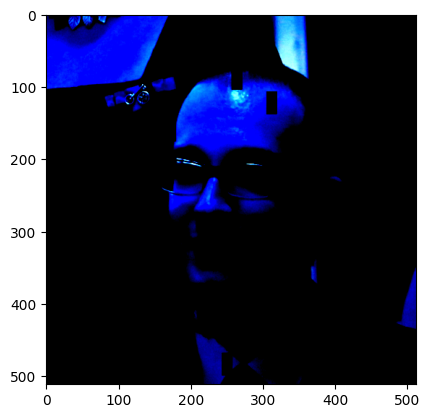

In [148]:
plt.imshow(image[1].detach().cpu().numpy().transpose(1,2,0))

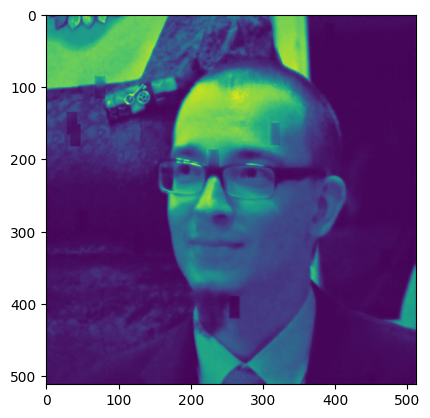

In [145]:
plt.imshow(pred[1][2].detach().cpu().numpy())

IndexError: index 3 is out of bounds for dimension 0 with size 3

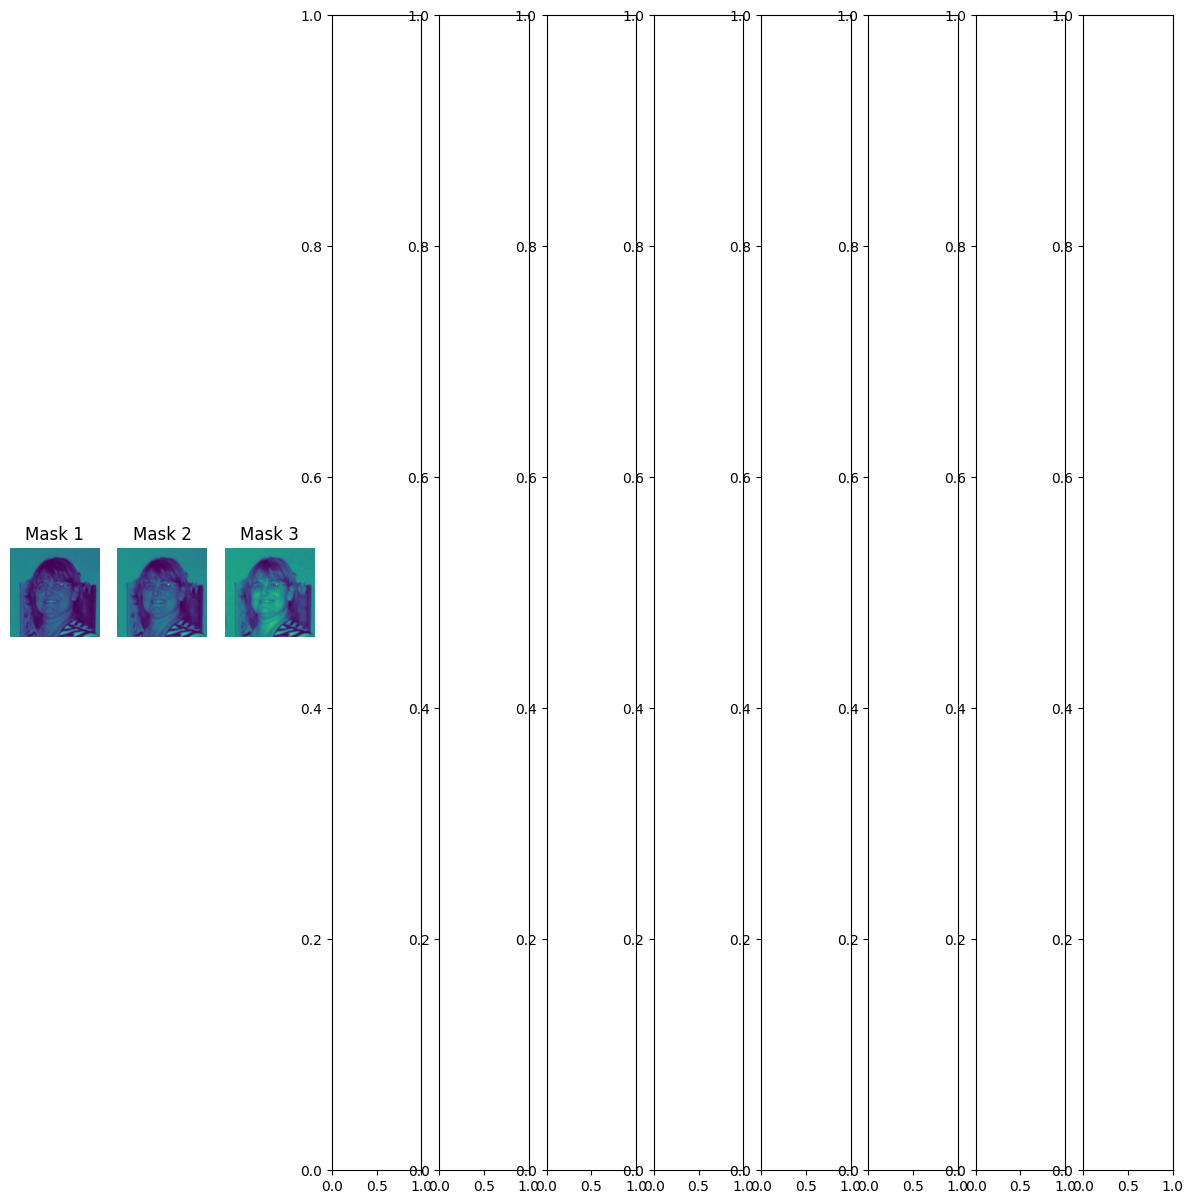

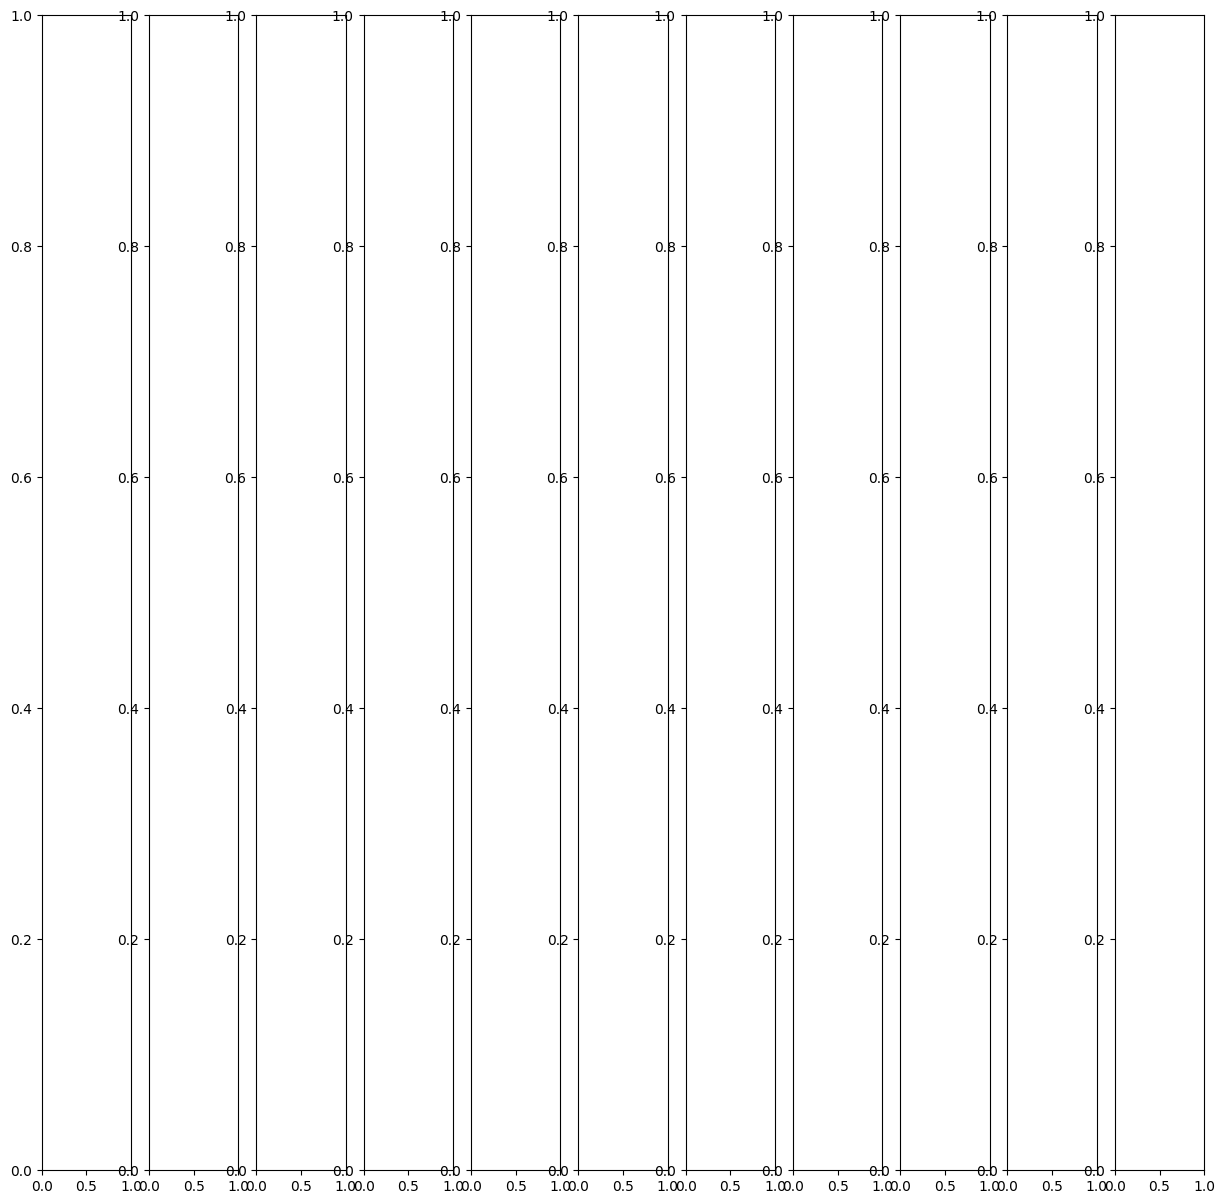

In [133]:
    num_masks = 11
    fig, axes = plt.subplots(1, num_masks, figsize=(15, 15))
    fig1, axes1 = plt.subplots(1, num_masks, figsize=(15, 15))

    # Display each mask
    for m in range(num_masks):
        axes[m].imshow(masks[1][m].cpu())
        axes[m].set_title(f'Mask {m + 1}')
        axes[m].axis('off')

    for m in range(num_masks):
        axes1[m].imshow(pred[1][m].detach().cpu().numpy())
        axes1[m].set_title(f'Mask {m + 1}')
        axes1[m].axis('off')

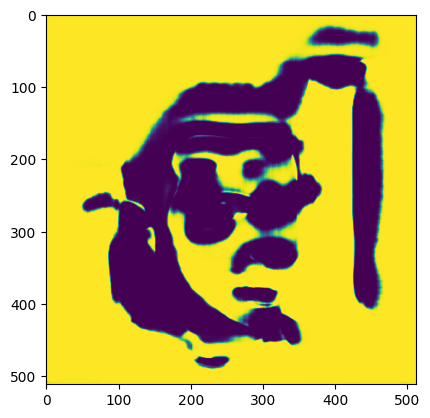

In [ ]:
plt.imshow(pred[0][0].cpu().detach().numpy())

In [ ]:
import os
import urllib
import zipfile
from tqdm import tqdm

def download(url: str, filename: str, chunk_size: int = 4096) -> None:
    with open(filename, "wb") as fh:
        with urllib.request.urlopen(urllib.request.Request(url)) as response:
            with tqdm(total=response.length) as pbar:
                for chunk in iter(lambda: response.read(chunk_size), ""):
                    if not chunk:
                        break
                    pbar.update(chunk_size)
                    fh.write(chunk)
    print(f'Dataset downloaded!')
    return None

def extract(from_path: str, to_path: str) -> None:
    with zipfile.ZipFile(from_path, "r", compression=zipfile.ZIP_STORED) as zf:
        zf.extractall(to_path)
    print('Dataset extracted!')
    return None

def download_and_extract(root: str, url: str, filename: str=None):
    root = os.path.expanduser(root)
    if not filename:
        filename = os.path.basename(url)
    fpath = os.path.join(root, filename)
    if os.path.exists(fpath):
        print('Dataset is already downloaded!')
    else:
        os.makedirs(root, exist_ok=True)
        _ = download(url, fpath)
        _ = extract(fpath, root)
    return None

In [ ]:
import glob
import torch
from PIL import Image
from torch.utils.data import Dataset

class Facades(Dataset):
    url="https://github.com/akanametov/pix2pix/releases/download/1.0/facades.zip"
    def __init__(self,
                 root: str='.',
                 transform=None,
                 download: bool=True,
                 mode: str='train',
                 direction: str='B2A'):
        if download:
            _ = download_and_extract(root, self.url)
        self.root=root
        self.files=sorted(glob.glob(f"{root}/facades/{mode}/*.jpg"))
        self.transform=transform
        self.download=download
        self.mode=mode
        self.direction=direction

    def __len__(self,):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert('RGB')
        W, H = img.size
        cW = W//2
        imgA = img.crop((0, 0, cW, H))
        imgB = img.crop((cW, 0, W, H))

        if self.transform:
            imgA, imgB = self.transform(imgA, imgB)

        if self.direction == 'A2B':
            return imgA, imgB
        else:
            return imgB, imgA

In [ ]:
dataset = Facades()

30261248it [00:00, 73001339.26it/s]                              


Dataset downloaded!
Dataset extracted!


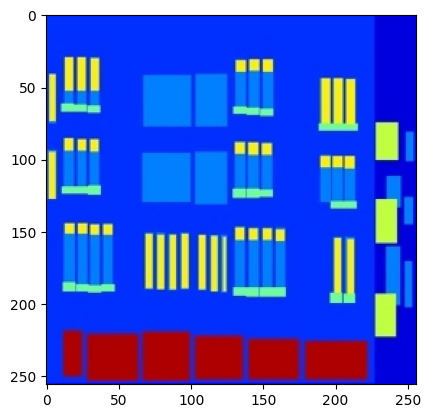

In [ ]:
plt.imshow(dataset[0][0])